# Spam Emails Detection NLP

## Part Two Features Engineering


In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import re 
pd.options.display.max_colwidth = 200
import gensim


## Import dataset and Data Exploration

[Source:](https://www.kaggle.com/karthickveerakumar/spam-filter)

In [5]:
emails = pd.read_csv('nlp_emails.csv')



## Deep learning Methods

### Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture


#### Build the corpus vocabulary( use the normolize X matrix previously)

In [ ]:
nlp_X= emails['nlp_X']

In [7]:
nlp_X.shape

(1000,)

In [357]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(nlp_X)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in nlp_X]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 14115
Vocabulary Sample: [('enron', 1), ('subject', 2), ('vince', 3), ('hou', 4), ('kaminski', 5), ('j', 6), ('time', 7), ('research', 8), ('thanks', 9), ('know', 10)]


### Build (context_words, target_word) pair generator

In [358]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [359]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['subject', 'interview', 'submitted', 'evaluation'] -> Target (Y): steve
Context (X): ['interview', 'steve', 'evaluation', 'general'] -> Target (Y): submitted
Context (X): ['steve', 'submitted', 'general', 'impression'] -> Target (Y): evaluation
Context (X): ['submitted', 'evaluation', 'impression', 'negative'] -> Target (Y): general
Context (X): ['evaluation', 'general', 'negative', 'consultant'] -> Target (Y): impression
Context (X): ['general', 'impression', 'consultant', 'type'] -> Target (Y): negative
Context (X): ['impression', 'negative', 'type', 'person'] -> Target (Y): consultant
Context (X): ['negative', 'consultant', 'person', 'speaks'] -> Target (Y): type
Context (X): ['consultant', 'type', 'speaks', 'confidence'] -> Target (Y): person
Context (X): ['type', 'person', 'confidence', 'short'] -> Target (Y): speaks
Context (X): ['person', 'speaks', 'short', 'depth'] -> Target (Y): confidence


### Build CBOW Deep Network Model

In [360]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            1411500   
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 14115)             1425615   
Total params: 2,837,115
Trainable params: 2,837,115
Non-trainable params: 0
_________________________________________________________________
None


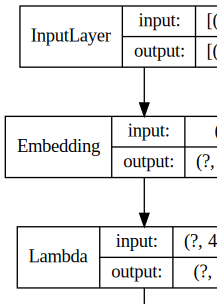

In [361]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Get Word Embeddings

In [362]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(14114, 100)


0         1         2         3         4         5   \
subject  -0.009855  0.024351 -0.033998  0.041855 -0.046814 -0.029466   
vince     0.029987 -0.030935 -0.045062 -0.047955  0.042305 -0.044902   
hou      -0.035914 -0.002440 -0.021216 -0.037789  0.010557  0.017551   
kaminski  0.011356  0.000309 -0.032490  0.007884  0.010161 -0.035524   
j         0.042914  0.035949  0.024573  0.005621 -0.008089  0.008129   

                6         7         8         9   ...        90        91  \
subject   0.048007 -0.035201 -0.024202  0.030494  ...  0.047072 -0.047120   
vince    -0.009123  0.008468  0.049319 -0.023673  ...  0.044844  0.022479   
hou       0.045368  0.030603  0.001334 -0.039487  ... -0.038130 -0.014530   
kaminski -0.001787  0.044383 -0.016555 -0.005454  ...  0.005824  0.008729   
j        -0.024174 -0.015988 -0.014914  0.038706  ... -0.001620  0.014322   

                92        93        94        95        96        97  \
subject   0.024419 -0.045086  0.034492 -0.030869 -0.024320 -0.006746   
vince     0.003315  0.049511 -0.000562 -0.031000 -0.013335 -0.029390   
hou       0.049371  0.017691  0.027837  0.007750 -0.020497 -0.012549   
kaminski -0.039217 -0.033440 -0.040212  0.018821 -0.040438 -0.024242   
j         0.021377 -0.047751  0.039737  0.048399 -0.043179 -0.005291   

                98        99  
subject  -0.012341 -0.026606  
vince    -0.016270 -0.010904  
hou      -0.048235  0.045698  
kaminski  0.024937  0.000109  
j         0.013713 -0.036713  

[5 rows x 100 columns]

### Build a distance matrix to view the most similar words (contextually)

In [391]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['software', 'price', 'new', 'enron', 'market', 'management', 'credit', 'power', 'model', 'risk']}

similar_words

(14114, 14114)


{'software': ['gifts', 'effectiveiy', 'bears', 'speaker', 'secretary'],
 'price': ['policymakers', 'deteriorated', 'lrc', 'sales', 'orderinq'],
 'new': ['sinnagasak', 'justifications', 'zerka', 'details', 'lisa'],
 'enron': ['binders', 'garp', 'giv', 'degeyter', 'seventhpower'],
 'market': ['math', 'foresaw', 'limitations', 'claims', 'alabama'],
 'management': ['additiona', 'carolyn', 'total', 'bcf', 'resignation'],
 'credit': ['prnewswire', 'jamme', 'mcadams', 'rlk', 'afteading'],
 'power': ['counter', 'include', 'bold', 'immediate', 'flection'],
 'model': ['davina', 'arrow', 'laid', 'waste', 'bandini'],
 'risk': ['mozilla', 'dnia', 'orientation', 'beta', 'wake']}

#### Build and View sample skip grams ((word1, word2) -> relevancy)

In [392]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(stephen (485), months (237)) -> 1
(negative (2052), general (322)) -> 1
(submitted (689), subject (2)) -> 1
(intelligent (3889), keynote (2150)) -> 0
(organization (835), angle (12169)) -> 0
(jumps (2969), personable (5646)) -> 1
(j (6), think (79)) -> 0
(better (223), eydeland (4843)) -> 0
(subject (2), appendix (6313)) -> 0
(ascertain (5648), assessed (13406)) -> 0


In [ ]:
#Train the model for 5 epochs

In [ ]:
''''''
#for epoch in range(1, 6):
    #loss = 0
    #for i, elem in enumerate(skip_grams):
        #pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        #pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        #labels = np.array(elem[1], dtype='int32')
        #X = [pair_first_elem, pair_second_elem]
        #Y = labels
        #if i % 10000 == 0:
            #print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        #loss += model.train_on_batch(X,Y)  

    #print('Epoch:', epoch, 'Loss:', loss)
    
''''''

### Get word embeddings

#### Build a distance matrix to view the most similar words (contextually)

In [394]:

from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['new', 'website', 'company', 'business', 'click', 'mail', 'free', 'money', 'information', 'email']}

similar_words


(14114, 14114)


{'new': ['sinnagasak', 'justifications', 'zerka', 'details', 'lisa'],
 'website': ['fehlgeschlagen', 'visualize', 'chanqes', 'inventory', 'glen'],
 'company': ['terminus', 'algorithm', 'unnmet', 'borrowers', 'hardcopy'],
 'business': ['admiration', 'nelson', 'capabilities', 'collins', 'algebra'],
 'click': ['meet', 'nerve', 'atlas', 'updates', 'ben'],
 'mail': ['oaks', 'influence', 'sender', 'incorrectly', 'cerezo'],
 'free': ['scout', 'wholesale', 'metal', 'biank', 'brownian'],
 'money': ['ja', 'provide', 'lasts', 'wm', 'heard'],
 'information': ['michaelthimmig', 'toronto', 'millions', 'chief', 'fed'],
 'email': ['rocks', 'logs', 'inter', 'archived', 'doorstep']}

### Visualize word embeddings

Total words: 60 	Word Embedding shapes: (60, 100)


<Figure size 1008x576 with 0 Axes>

Text(0, 0, 'new')

Text(0, 0, 'sinnagasak')

Text(0, 0, 'justifications')

Text(0, 0, 'zerka')

Text(0, 0, 'details')

Text(0, 0, 'lisa')

Text(0, 0, 'website')

Text(0, 0, 'fehlgeschlagen')

Text(0, 0, 'visualize')

Text(0, 0, 'chanqes')

Text(0, 0, 'inventory')

Text(0, 0, 'glen')

Text(0, 0, 'company')

Text(0, 0, 'terminus')

Text(0, 0, 'algorithm')

Text(0, 0, 'unnmet')

Text(0, 0, 'borrowers')

Text(0, 0, 'hardcopy')

Text(0, 0, 'business')

Text(0, 0, 'admiration')

Text(0, 0, 'nelson')

Text(0, 0, 'capabilities')

Text(0, 0, 'collins')

Text(0, 0, 'algebra')

Text(0, 0, 'click')

Text(0, 0, 'meet')

Text(0, 0, 'nerve')

Text(0, 0, 'atlas')

Text(0, 0, 'updates')

Text(0, 0, 'ben')

Text(0, 0, 'mail')

Text(0, 0, 'oaks')

Text(0, 0, 'influence')

Text(0, 0, 'sender')

Text(0, 0, 'incorrectly')

Text(0, 0, 'cerezo')

Text(0, 0, 'free')

Text(0, 0, 'scout')

Text(0, 0, 'wholesale')

Text(0, 0, 'metal')

Text(0, 0, 'biank')

Text(0, 0, 'brownian')

Text(0, 0, 'money')

Text(0, 0, 'ja')

Text(0, 0, 'provide')

Text(0, 0, 'lasts')

Text(0, 0, 'wm')

Text(0, 0, 'heard')

Text(0, 0, 'information')

Text(0, 0, 'michaelthimmig')

Text(0, 0, 'toronto')

Text(0, 0, 'millions')

Text(0, 0, 'chief')

Text(0, 0, 'fed')

Text(0, 0, 'email')

Text(0, 0, 'rocks')

Text(0, 0, 'logs')

Text(0, 0, 'inter')

Text(0, 0, 'archived')

Text(0, 0, 'doorstep')

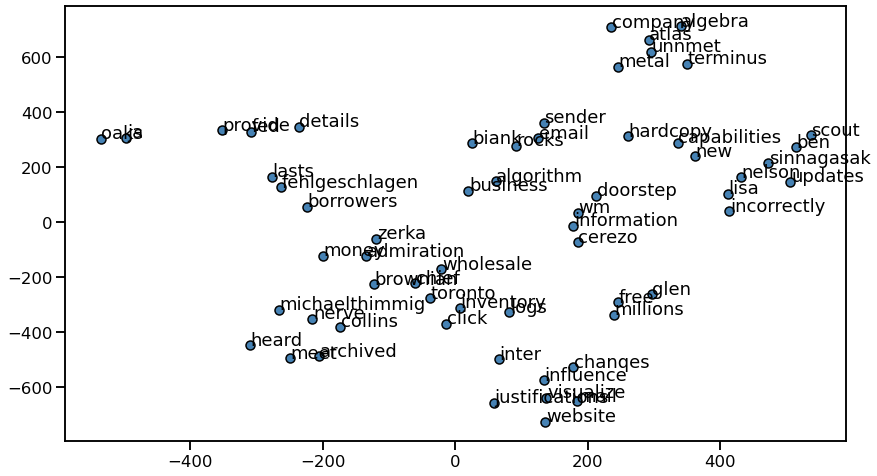

In [395]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points');

### Applying the word2vec model on normolized emails text


In [399]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in nlp_X]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)


### Visualizing word embeddings


<Figure size 1008x576 with 0 Axes>

Text(0, 0, 'new')

Text(0, 0, 'sinnagasak')

Text(0, 0, 'justifications')

Text(0, 0, 'zerka')

Text(0, 0, 'details')

Text(0, 0, 'lisa')

Text(0, 0, 'website')

Text(0, 0, 'fehlgeschlagen')

Text(0, 0, 'visualize')

Text(0, 0, 'chanqes')

Text(0, 0, 'inventory')

Text(0, 0, 'glen')

Text(0, 0, 'company')

Text(0, 0, 'terminus')

Text(0, 0, 'algorithm')

Text(0, 0, 'unnmet')

Text(0, 0, 'borrowers')

Text(0, 0, 'hardcopy')

Text(0, 0, 'business')

Text(0, 0, 'admiration')

Text(0, 0, 'nelson')

Text(0, 0, 'capabilities')

Text(0, 0, 'collins')

Text(0, 0, 'algebra')

Text(0, 0, 'click')

Text(0, 0, 'meet')

Text(0, 0, 'nerve')

Text(0, 0, 'atlas')

Text(0, 0, 'updates')

Text(0, 0, 'ben')

Text(0, 0, 'mail')

Text(0, 0, 'oaks')

Text(0, 0, 'influence')

Text(0, 0, 'sender')

Text(0, 0, 'incorrectly')

Text(0, 0, 'cerezo')

Text(0, 0, 'free')

Text(0, 0, 'scout')

Text(0, 0, 'wholesale')

Text(0, 0, 'metal')

Text(0, 0, 'biank')

Text(0, 0, 'brownian')

Text(0, 0, 'money')

Text(0, 0, 'ja')

Text(0, 0, 'provide')

Text(0, 0, 'lasts')

Text(0, 0, 'wm')

Text(0, 0, 'heard')

Text(0, 0, 'information')

Text(0, 0, 'michaelthimmig')

Text(0, 0, 'toronto')

Text(0, 0, 'millions')

Text(0, 0, 'chief')

Text(0, 0, 'fed')

Text(0, 0, 'email')

Text(0, 0, 'rocks')

Text(0, 0, 'logs')

Text(0, 0, 'inter')

Text(0, 0, 'archived')

Text(0, 0, 'doorstep')

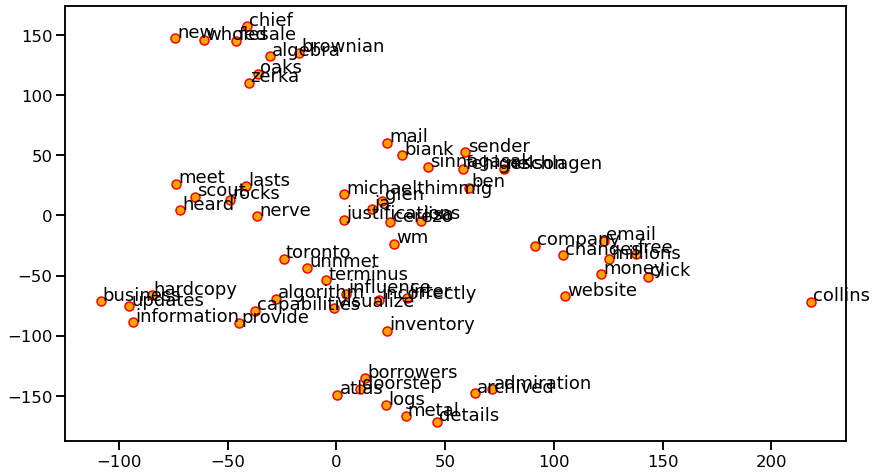

In [400]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Sample word embedding

In [401]:
w2v_model.wv['mail']

array([  1.93924   ,  -6.9758735 ,  -0.36262614,  -1.9258393 ,
         8.884471  ,  -6.7674503 ,  -5.4047527 ,  -7.3315763 ,
         0.80588436,   5.5983033 ,  -0.03018017,   0.40443963,
         3.982383  ,   0.30668783,   6.027599  ,  -0.20324963,
         4.4951744 ,  -3.6511512 ,  -1.3664141 ,   3.3122056 ,
         5.4454126 ,  -0.22570698,  -0.25718248,   2.6591763 ,
        -4.748911  ,   0.96893275,   3.5153036 ,   8.221737  ,
         3.3406882 ,   7.2396016 ,  -1.7008336 ,   5.646647  ,
         4.895161  ,   2.9669895 ,  -2.3718739 ,  -1.0930912 ,
         4.0040374 ,  -3.4903817 ,   3.8895466 ,   8.247196  ,
        -2.0515242 ,  -3.4865787 ,  -1.1588137 ,  -4.1450834 ,
        -1.1422892 ,   6.780456  ,   0.97387236,  -2.6969957 ,
        -0.36079463,  -2.9353402 ,   5.737226  ,  -6.2538023 ,
        -4.33626   ,  -2.8400655 ,  -1.8913655 ,  -2.6584406 ,
        -0.521812  ,   7.890444  ,   0.56797594,   4.674668  ,
         4.963319  ,   0.96383965,   5.0107155 ,   2.57

### Build framework for getting document level embeddings

In [402]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [403]:

w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)


0         1         2         3         4         5         6   \
0    0.217345  0.223158  0.776341  0.679249 -0.250112  0.134707  0.957055   
1   -1.195455 -0.782350 -0.085748 -0.623149  1.303726 -0.266644  0.834661   
2    0.016421  0.008330  0.308182  0.390063  0.641150 -0.153850  1.520621   
3   -0.728808 -1.337981  0.004968  0.495141  0.655348 -2.074603  0.070766   
4   -0.425503  0.225021 -0.196664  0.276326  0.768222  0.997589  2.120155   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.066645  0.562021 -1.216809  0.346370 -1.607630  0.483005 -0.625277   
996 -0.187320  0.571817  0.241197  0.449885 -0.363285  0.411005  1.143237   
997 -0.078750 -1.311722 -0.926964  0.779762 -0.131210  0.184535  1.312264   
998 -0.650046  0.304240  0.693136 -0.822569 -0.356994 -0.285612  0.203485   
999 -0.077691 -1.011816  0.618166  0.178687  0.200764 -0.403934  1.342954   

           7         8         9   ...        90        91        92  \
0   -0.564441 -1.145580 -0.370351  ... -0.358145  0.224088  0.034488   
1    0.564230  0.715379  0.698861  ...  0.744734 -0.700405 -0.611518   
2    0.127841 -0.406733 -0.054282  ... -0.752072  0.041794 -0.291661   
3   -0.906121 -1.187984 -0.607526  ... -0.670416 -0.407839 -0.409425   
4    0.264361  1.049075  1.175591  ...  1.079765 -0.146598 -0.108071   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.750071  0.726786 -0.456458  ... -0.657317 -0.232041 -0.869656   
996 -0.618576 -0.242152  0.104881  ...  0.359312 -0.319547 -0.193987   
997 -0.562412 -1.979409  0.886970  ... -0.321892  1.335268 -0.120350   
998 -1.082298 -1.219154  0.515606  ... -1.091891  0.259988  0.010444   
999 -0.082415 -0.243113  0.765576  ...  0.903772 -0.131773 -0.401249   

           93        94        95        96        97        98        99  
0   -0.057083 -0.008107 -0.692241  0.344124  0.176952 -0.364580  0.337637  
1    0.315446 -1.217174 -0.417006  1.172363 -0.260034 -0.280271 -0.353875  
2   -0.369024  0.000900 -0.147839  0.104323 -0.125392 -0.572232 -0.011687  
3    0.523567 -1.631032 -1.344985 -0.020247  0.912266 -1.820192  0.282018  
4    0.107439 -1.893656  0.157606  0.741626  0.099634 -1.922799 -0.925242  
..        ...       ...       ...       ...       ...       ...       ...  
995  0.520250 -0.308911  0.919790  0.184791 -0.123853 -0.343719 -0.234509  
996 -0.135433 -0.370571 -1.198521 -0.063335 -0.326683  1.091729 -0.271090  
997 -0.012884  0.375535 -1.377898  1.043971 -0.599939  1.583727 -1.309243  
998  0.382986  0.399552 -0.597725  0.813120  0.245974  0.432785  0.342989  
999  0.208649 -0.860844 -1.040777 -0.064876  0.710233 -0.615903  1.084803  

[1000 rows x 100 columns]

### Clustering with word embeddings

In [405]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([nlp_emails, cluster_labels], axis=1)

AffinityPropagation()

nlp_X  \
0    subject interview steve submitted evaluation general impression negative consultant type person speaks confidence short depth technical details personable outspoken organized positive red flag jum...   
1    subject ink prices got like save printer fax copier supplies brands like epson canon hewlett packard lexmark quality satisfaction guarantee money free day shipping orders beat price internet guara...   
2    subject hiya hon mandamus hi babie crystal clear remember dating website told thought id hi hon want pictures read wont sleep hear sexy later baby cryssie gal cix bornfruit cr jeffersondarcy rpbw ...   
3    subject confirmation needed reply email message confirm subscription enl dailyupdate txt email address entered subscription enl dailyupdate txt mailing list new subscription requires confirmation ...   
4    subject ready hello viagra med struggle mens erectile dysfunction like jokes sais stronq enouqh man woman orderinq viaqra online convinient fast secure way millions people daily save privacy money...   
..                                                                                                                                                                                                       ...   
995  subject moze cie zainteresuje vince dawno ze soba nie rozmawialismy mam nadzieje ze u ciebie wszystko k nie wiem czy znana jest ci postac prof aleksandra werona zajmuje sie zastosowaniem metod mat...   
996  subject var vince thanks update especially point echoes discussion yesterday want clarify responsibilities maintenance administration var need transparency process mapping decisions example easily...   
997                                                             subject vince kaminski bio good morning jim attached find short bio vince kaminski need let know presentations forthcoming great day shirley   
998  subject li sun jeff met li sun night shall rotation comes smart highly motivated person planning mark palmer wharton october finalize deal vince jeffrey shankman jana giovannini hou vince j kamins...   
999  subject urgent reply desk barr arisman shonikon chambers associates b aba road port harcourt nigeria private email address shymail dear sincerely apologize intruding privacy especially contacting ...   

     topic  ClusterLabel  
0        0             8  
1        3            75  
2        3            40  
3        1            75  
4        3            51  
..     ...           ...  
995      0            54  
996      0            79  
997      4            16  
998      4            68  
999      3            59  

[1000 rows x 3 columns]

<Figure size 576x432 with 0 Axes>

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '3')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '3')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '1')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '1')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '2')

Text(0, 0, '3')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '0')

Text(0, 0, '0')

Text(0, 0, '4')

Text(0, 0, '4')

Text(0, 0, '3')

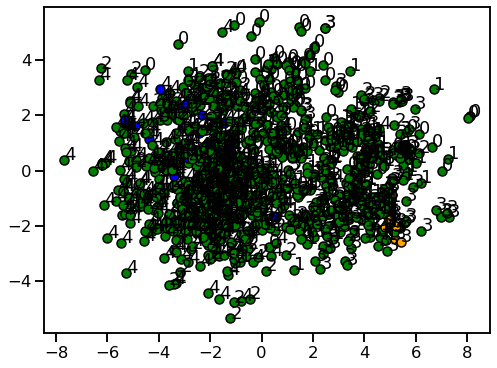

In [406]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(nlp_emails['topic'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

### GloVe Embeddings with spaCy

In [407]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


### Visualize GloVe word embeddings

In [408]:
unique_words = list(set([word for sublist in [doc.split() for doc in nlp_X] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

0        1         2         3        4         5    \
ukrainian    -0.244450  0.22652 -0.429440  0.405560  0.50742  0.025109   
reid         -0.439490  0.37625  0.460570  0.172940 -0.21795 -0.098791   
river         0.096865 -0.29063 -0.220770 -0.780660  0.45175  0.923940   
yr           -0.452010  0.33028 -0.447430  0.017756  0.22100 -0.393790   
speedy       -0.372890  0.16960 -0.569600 -0.148380  0.33929  0.183300   
...                ...      ...       ...       ...      ...       ...   
partielle    -0.122620 -0.39617  0.025031  0.216910 -0.62640 -0.726370   
fiim          0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   
refreshments  0.402920 -0.18016  0.816450  0.271330 -0.35457  0.115490   
husband      -0.060610  0.24737 -0.041243  0.204240  0.25893  0.031180   
davidbarbour  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   

                   6         7         8        9    ...       290       291  \
ukrainian     0.492590  0.011290 -0.038874 -0.15869  ...  0.059868 -0.787190   
reid          0.000752 -0.185840  0.429230  0.26330  ...  0.439250 -0.296010   
river        -0.565470  0.310980 -0.520390  2.43230  ... -0.333290 -0.192210   
yr            0.248320 -0.721930  0.543350  0.99926  ...  0.507230 -0.445110   
speedy        0.613490 -0.054933  0.469810  1.28170  ... -0.305880 -0.119440   
...                ...       ...       ...      ...  ...       ...       ...   
partielle     0.561470  0.824780 -0.285380 -1.92460  ...  0.774710 -0.721420   
fiim          0.000000  0.000000  0.000000  0.00000  ...  0.000000  0.000000   
refreshments  0.262720 -0.054833  0.011467  1.44510  ... -0.143000  0.130150   
husband       0.386560 -0.964200  0.227190  3.60530  ...  0.488530  0.071031   
davidbarbour  0.000000  0.000000  0.000000  0.00000  ...  0.000000  0.000000   

                   292       293       294       295       296       297  \
ukrainian     0.282370  0.512210  0.072048 -0.358930  0.055357 -0.641980   
reid          0.097059 -0.113920  0.671070 -0.034556 -0.245080 -0.105210   
river        -0.600980 -0.392950 -0.067076  0.021785 -0.323220 -0.203230   
yr           -0.332620  0.095303  0.248170 -0.195210 -0.182350  0.503840   
speedy        0.304980 -0.055608  0.436960 -0.107950  0.716440 -0.130550   
...                ...       ...       ...       ...       ...       ...   
partielle    -0.462010  0.028257  0.846180 -0.159390 -0.286030  0.244460   
fiim          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
refreshments  0.046665 -0.504520 -0.021279 -0.006601  0.615860 -0.154120   
husband       0.005109  0.245790  0.515060 -0.192900  0.238320  0.057265   
davidbarbour  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                   298       299  
ukrainian    -0.105540  0.275120  
reid         -0.456160  0.191250  
river        -0.395790 -0.601690  
yr            0.038552 -0.075614  
speedy       -0.620000  0.310450  
...                ...       ...  
partielle    -0.139890 -0.576760  
fiim          0.000000  0.000000  
refreshments  0.091872  0.278990  
husband       0.166440 -0.652780  
davidbarbour  0.000000  0.000000  

[14114 rows x 300 columns]

<Figure size 864x432 with 0 Axes>

Text(0, 0, 'ukrainian')

Text(0, 0, 'reid')

Text(0, 0, 'river')

Text(0, 0, 'yr')

Text(0, 0, 'speedy')

Text(0, 0, 'morale')

Text(0, 0, 'proofs')

Text(0, 0, 'healthcare')

Text(0, 0, 'availabel')

Text(0, 0, 'wydal')

Text(0, 0, 'zalaczniku')

Text(0, 0, 'freebsd')

Text(0, 0, 'depend')

Text(0, 0, 'bridge')

Text(0, 0, 'john')

Text(0, 0, 'overcoming')

Text(0, 0, 'far')

Text(0, 0, 'qcfvc')

Text(0, 0, 'baneberry')

Text(0, 0, 'router')

Text(0, 0, 'variances')

Text(0, 0, 'lavorato')

Text(0, 0, 'kulkarni')

Text(0, 0, 'realized')

Text(0, 0, 'mailed')

Text(0, 0, 'financing')

Text(0, 0, 'founding')

Text(0, 0, 'fundraising')

Text(0, 0, 'metro')

Text(0, 0, 'hq')

Text(0, 0, 'bmw')

Text(0, 0, 'tentative')

Text(0, 0, 'idaho')

Text(0, 0, 'unauthorized')

Text(0, 0, 'intact')

Text(0, 0, 'retrieval')

Text(0, 0, 'courses')

Text(0, 0, 'operating')

Text(0, 0, 'envifi')

Text(0, 0, 'adoption')

Text(0, 0, 'entering')

Text(0, 0, 'ebooks')

Text(0, 0, 'sprint')

Text(0, 0, 'practicable')

Text(0, 0, 'reconstruction')

Text(0, 0, 'capitalspreads')

Text(0, 0, 'dmitri')

Text(0, 0, 'customary')

Text(0, 0, 'iva')

Text(0, 0, 'discretionary')

Text(0, 0, 'discs')

Text(0, 0, 'glisan')

Text(0, 0, 'granted')

Text(0, 0, 'eventually')

Text(0, 0, 'sacrificing')

Text(0, 0, 'prob')

Text(0, 0, 'gebhardt')

Text(0, 0, 'licensing')

Text(0, 0, 'reactionsnet')

Text(0, 0, 'przepraszam')

Text(0, 0, 'josh')

Text(0, 0, 'shearing')

Text(0, 0, 'searchl')

Text(0, 0, 'skinner')

Text(0, 0, 'czlonkiem')

Text(0, 0, 'blockbuster')

Text(0, 0, 'hugs')

Text(0, 0, 'abroad')

Text(0, 0, 'arge')

Text(0, 0, 'murky')

Text(0, 0, 'flames')

Text(0, 0, 'wydarzeniem')

Text(0, 0, 'participants')

Text(0, 0, 'ahead')

Text(0, 0, 'signature')

Text(0, 0, 'alcohol')

Text(0, 0, 'conforming')

Text(0, 0, 'processor')

Text(0, 0, 'conceived')

Text(0, 0, 'kulczyk')

Text(0, 0, 'smailer')

Text(0, 0, 'surrounding')

Text(0, 0, 'number')

Text(0, 0, 'sorry')

Text(0, 0, 'notices')

Text(0, 0, 'sep')

Text(0, 0, 'tomorrow')

Text(0, 0, 'mindspring')

Text(0, 0, 'practices')

Text(0, 0, 'exercising')

Text(0, 0, 'sources')

Text(0, 0, 'trader')

Text(0, 0, 'clearifications')

Text(0, 0, 'brett')

Text(0, 0, 'industries')

Text(0, 0, 'informs')

Text(0, 0, 'verlfied')

Text(0, 0, 'entrepreneur')

Text(0, 0, 'european')

Text(0, 0, 'plenary')

Text(0, 0, 'aero')

Text(0, 0, 'fire')

Text(0, 0, 'maxwell')

Text(0, 0, 'oem')

Text(0, 0, 'priorities')

Text(0, 0, 'insightfull')

Text(0, 0, 'inconvenience')

Text(0, 0, 'seeesion')

Text(0, 0, 'usage')

Text(0, 0, 'reinsurance')

Text(0, 0, 'drafting')

Text(0, 0, 'vlsa')

Text(0, 0, 'employers')

Text(0, 0, 'founded')

Text(0, 0, 'outstripped')

Text(0, 0, 'breast')

Text(0, 0, 'tor')

Text(0, 0, 'technion')

Text(0, 0, 'continents')

Text(0, 0, 'spamreason')

Text(0, 0, 'usaone')

Text(0, 0, 'results')

Text(0, 0, 'examination')

Text(0, 0, 'spelling')

Text(0, 0, 'roles')

Text(0, 0, 'pagan')

Text(0, 0, 'avaiiable')

Text(0, 0, 'coned')

Text(0, 0, 'print')

Text(0, 0, 'format')

Text(0, 0, 'apx')

Text(0, 0, 'decommissioned')

Text(0, 0, 'portland')

Text(0, 0, 'agreement')

Text(0, 0, 'lunch')

Text(0, 0, 'samawi')

Text(0, 0, 'espeed')

Text(0, 0, 'woodbind')

Text(0, 0, 'mora')

Text(0, 0, 'played')

Text(0, 0, 'trust')

Text(0, 0, 'thirds')

Text(0, 0, 'sm')

Text(0, 0, 'electraparners')

Text(0, 0, 'studies')

Text(0, 0, 'fr')

Text(0, 0, 'confidentiaiity')

Text(0, 0, 'cecil')

Text(0, 0, 'smoke')

Text(0, 0, 'cuties')

Text(0, 0, 'kahn')

Text(0, 0, 'individuals')

Text(0, 0, 'amend')

Text(0, 0, 'maisonette')

Text(0, 0, 'initiatives')

Text(0, 0, 'teneo')

Text(0, 0, 'methodology')

Text(0, 0, 'telecom')

Text(0, 0, 'fee')

Text(0, 0, 'necessitated')

Text(0, 0, 'ipe')

Text(0, 0, 'attach')

Text(0, 0, 'rock')

Text(0, 0, 'marca')

Text(0, 0, 'centers')

Text(0, 0, 'savings')

Text(0, 0, 'prudency')

Text(0, 0, 'vacant')

Text(0, 0, 'fares')

Text(0, 0, 'sound')

Text(0, 0, 'temps')

Text(0, 0, 'yo')

Text(0, 0, 'dates')

Text(0, 0, 'kristin')

Text(0, 0, 'worded')

Text(0, 0, 'bisztyga')

Text(0, 0, 'ydo')

Text(0, 0, 'peter')

Text(0, 0, 'nomination')

Text(0, 0, 'ssist')

Text(0, 0, 'cushions')

Text(0, 0, 'unnmet')

Text(0, 0, 'hopkins')

Text(0, 0, 'stad')

Text(0, 0, 'tested')

Text(0, 0, 'emerged')

Text(0, 0, 'lines')

Text(0, 0, 'faxing')

Text(0, 0, 'comforting')

Text(0, 0, 'governments')

Text(0, 0, 'bardfield')

Text(0, 0, 'renewing')

Text(0, 0, 'reversion')

Text(0, 0, 'quantify')

Text(0, 0, 'robertwalters')

Text(0, 0, 'rly')

Text(0, 0, 'expire')

Text(0, 0, 'relinquish')

Text(0, 0, 'alejandra')

Text(0, 0, 'needs')

Text(0, 0, 'uaal')

Text(0, 0, 'un')

Text(0, 0, 'effectively')

Text(0, 0, 'mods')

Text(0, 0, 'welcome')

Text(0, 0, 'moved')

Text(0, 0, 'attending')

Text(0, 0, 'indebted')

Text(0, 0, 'maritime')

Text(0, 0, 'zastosowaniem')

Text(0, 0, 'envisage')

Text(0, 0, 'test')

Text(0, 0, 'jungle')

Text(0, 0, 'leroy')

Text(0, 0, 'role')

Text(0, 0, 'ptt')

Text(0, 0, 'lima')

Text(0, 0, 'comparable')

Text(0, 0, 'ehronline')

Text(0, 0, 'greene')

Text(0, 0, 'conceivable')

Text(0, 0, 'gruppen')

Text(0, 0, 'thesepowerful')

Text(0, 0, 'enhancements')

Text(0, 0, 'tail')

Text(0, 0, 'nagasaki')

Text(0, 0, 'juan')

Text(0, 0, 'choice')

Text(0, 0, 'guaranteed')

Text(0, 0, 'causing')

Text(0, 0, 'medicine')

Text(0, 0, 'warm')

Text(0, 0, 'visualbasic')

Text(0, 0, 'wscc')

Text(0, 0, 'paris')

Text(0, 0, 'increasingly')

Text(0, 0, 'tagheuers')

Text(0, 0, 'differences')

Text(0, 0, 'cara')

Text(0, 0, 'secured')

Text(0, 0, 'rll')

Text(0, 0, 'chevron')

Text(0, 0, 'resultant')

Text(0, 0, 'muitipie')

Text(0, 0, 'predictive')

Text(0, 0, 'perkins')

Text(0, 0, 'interrupted')

Text(0, 0, 'supplya')

Text(0, 0, 'bartlett')

Text(0, 0, 'peep')

Text(0, 0, 'alleviations')

Text(0, 0, 'kurth')

Text(0, 0, 'believe')

Text(0, 0, 'sapsecurity')

Text(0, 0, 'cindy')

Text(0, 0, 'happened')

Text(0, 0, 'album')

Text(0, 0, 'enormous')

Text(0, 0, 'overnight')

Text(0, 0, 'congiomerates')

Text(0, 0, 'catherine')

Text(0, 0, 'cote')

Text(0, 0, 'judge')

Text(0, 0, 'xiaojun')

Text(0, 0, 'frozen')

Text(0, 0, 'responsiveness')

Text(0, 0, 'thing')

Text(0, 0, 'minister')

Text(0, 0, 'economics')

Text(0, 0, 'honestly')

Text(0, 0, 'tej')

Text(0, 0, 'valuing')

Text(0, 0, 'kollaros')

Text(0, 0, 'overexpenditures')

Text(0, 0, 'ricardol')

Text(0, 0, 'compensated')

Text(0, 0, 'facilities')

Text(0, 0, 'mit')

Text(0, 0, 'clarification')

Text(0, 0, 'xavier')

Text(0, 0, 'fiberglassgarbage')

Text(0, 0, 'positive')

Text(0, 0, 'accepting')

Text(0, 0, 'lounghrid')

Text(0, 0, 'hostile')

Text(0, 0, 'guided')

Text(0, 0, 'multiclient')

Text(0, 0, 'erectile')

Text(0, 0, 'injecting')

Text(0, 0, 'higgle')

Text(0, 0, 'reins')

Text(0, 0, 'uncoined')

Text(0, 0, 'gainesville')

Text(0, 0, 'breasts')

Text(0, 0, 'main')

Text(0, 0, 'jun')

Text(0, 0, 'thousands')

Text(0, 0, 'branding')

Text(0, 0, 'maclean')

Text(0, 0, 'restate')

Text(0, 0, 'outagerisk')

Text(0, 0, 'akhave')

Text(0, 0, 'skim')

Text(0, 0, 'title')

Text(0, 0, 'capitalists')

Text(0, 0, 'weened')

Text(0, 0, 'record')

Text(0, 0, 'disclaimer')

Text(0, 0, 'diversification')

Text(0, 0, 'provide')

Text(0, 0, 'demand')

Text(0, 0, 'explicitly')

Text(0, 0, 'irismmack')

Text(0, 0, 'ap')

Text(0, 0, 'substance')

Text(0, 0, 'algorithms')

Text(0, 0, 'nina')

Text(0, 0, 'negative')

Text(0, 0, 'paving')

Text(0, 0, 'trademarks')

Text(0, 0, 'suite')

Text(0, 0, 'tactics')

Text(0, 0, 'palais')

Text(0, 0, 'nations')

Text(0, 0, 'shortfall')

Text(0, 0, 'yourpartner')

Text(0, 0, 'silva')

Text(0, 0, 'hampshire')

Text(0, 0, 'surrey')

Text(0, 0, 'reset')

Text(0, 0, 'osoba')

Text(0, 0, 'fms')

Text(0, 0, 'haircut')

Text(0, 0, 'dimension')

Text(0, 0, 'beacon')

Text(0, 0, 'delainy')

Text(0, 0, 'professionais')

Text(0, 0, 'installing')

Text(0, 0, 'requesting')

Text(0, 0, 'organizations')

Text(0, 0, 'operator')

Text(0, 0, 'bellwether')

Text(0, 0, 'choose')

Text(0, 0, 'mrha')

Text(0, 0, 'floated')

Text(0, 0, 'actuators')

Text(0, 0, 'identity')

Text(0, 0, 'gobel')

Text(0, 0, 'swapsmonitor')

Text(0, 0, 'footnotes')

Text(0, 0, 'lamonsoff')

Text(0, 0, 'gratefulness')

Text(0, 0, 'pan')

Text(0, 0, 'pcx')

Text(0, 0, 'botswana')

Text(0, 0, 'sampling')

Text(0, 0, 'nalin')

Text(0, 0, 'slovenia')

Text(0, 0, 'harper')

Text(0, 0, 'orders')

Text(0, 0, 'forward')

Text(0, 0, 'csli')

Text(0, 0, 'underway')

Text(0, 0, 'takiego')

Text(0, 0, 'entreprenuer')

Text(0, 0, 'epis')

Text(0, 0, 'marshall')

Text(0, 0, 'southeast')

Text(0, 0, 'spudeck')

Text(0, 0, 'doctoral')

Text(0, 0, 'overseeing')

Text(0, 0, 'giobal')

Text(0, 0, 'replacement')

Text(0, 0, 'investing')

Text(0, 0, 'coordinator')

Text(0, 0, 'favors')

Text(0, 0, 'sestate')

Text(0, 0, 'whil')

Text(0, 0, 'breslau')

Text(0, 0, 'models')

Text(0, 0, 'fellers')

Text(0, 0, 'prank')

Text(0, 0, 'volumes')

Text(0, 0, 'upgrading')

Text(0, 0, 'sofya')

Text(0, 0, 'calls')

Text(0, 0, 'dynamics')

Text(0, 0, 'care')

Text(0, 0, 'plante')

Text(0, 0, 'fastow')

Text(0, 0, 'involvement')

Text(0, 0, 'condone')

Text(0, 0, 'matchavariani')

Text(0, 0, 'battery')

Text(0, 0, 'scope')

Text(0, 0, 'popt')

Text(0, 0, 'wylie')

Text(0, 0, 'executed')

Text(0, 0, 'cuccia')

Text(0, 0, 'stories')

Text(0, 0, 'starting')

Text(0, 0, 'roberto')

Text(0, 0, 'klopot')

Text(0, 0, 'eu')

Text(0, 0, 'unserviceable')

Text(0, 0, 'unification')

Text(0, 0, 'multipart')

Text(0, 0, 'acceptable')

Text(0, 0, 'chronicles')

Text(0, 0, 'apparently')

Text(0, 0, 'sycamorenet')

Text(0, 0, 'condemn')

Text(0, 0, 'utilizes')

Text(0, 0, 'laws')

Text(0, 0, 'henahan')

Text(0, 0, 'porn')

Text(0, 0, 'ana')

Text(0, 0, 'sissingh')

Text(0, 0, 'upstream')

Text(0, 0, 'styllsh')

Text(0, 0, 'exhausted')

Text(0, 0, 'veteran')

Text(0, 0, 'margaret')

Text(0, 0, 'accrual')

Text(0, 0, 'generating')

Text(0, 0, 'youcan')

Text(0, 0, 'dealing')

Text(0, 0, 'expiry')

Text(0, 0, 'issues')

Text(0, 0, 'taught')

Text(0, 0, 'continue')

Text(0, 0, 'ims')

Text(0, 0, 'groundwork')

Text(0, 0, 'blessed')

Text(0, 0, 'utilitiesall')

Text(0, 0, 'genera')

Text(0, 0, 'abnegate')

Text(0, 0, 'kinds')

Text(0, 0, 'ship')

Text(0, 0, 'decided')

Text(0, 0, 'boo')

Text(0, 0, 'rogroup')

Text(0, 0, 'engler')

Text(0, 0, 'timothy')

Text(0, 0, 'redundancy')

Text(0, 0, 'infocast')

Text(0, 0, 'support')

Text(0, 0, 'jmccauley')

Text(0, 0, 'kochind')

Text(0, 0, 'collateral')

Text(0, 0, 'guido')

Text(0, 0, 'detailing')

Text(0, 0, 'volumetric')

Text(0, 0, 'clickpaper')

Text(0, 0, 'dow')

Text(0, 0, 'deducted')

Text(0, 0, 'zajmuje')

Text(0, 0, 'vacancy')

Text(0, 0, 'reflected')

Text(0, 0, 'quarterly')

Text(0, 0, 'judgment')

Text(0, 0, 'involve')

Text(0, 0, 'likelihood')

Text(0, 0, 'supporting')

Text(0, 0, 'brokering')

Text(0, 0, 'pharmz')

Text(0, 0, 'rear')

Text(0, 0, 'coaches')

Text(0, 0, 'runing')

Text(0, 0, 'arbitrage')

Text(0, 0, 'analyses')

Text(0, 0, 'detection')

Text(0, 0, 'certain')

Text(0, 0, 'remains')

Text(0, 0, 'agree')

Text(0, 0, 'globalcloud')

Text(0, 0, 'comes')

Text(0, 0, 'medical')

Text(0, 0, 'anonymous')

Text(0, 0, 'seethayya')

Text(0, 0, 'originations')

Text(0, 0, 'osman')

Text(0, 0, 'pasting')

Text(0, 0, 'nrumqor')

Text(0, 0, 'energies')

Text(0, 0, 'kansas')

Text(0, 0, 'cute')

Text(0, 0, 'ci')

Text(0, 0, 'katherine')

Text(0, 0, 'rewards')

Text(0, 0, 'escamilla')

Text(0, 0, 'determined')

Text(0, 0, 'ogcon')

Text(0, 0, 'casy')

Text(0, 0, 'homeitry')

Text(0, 0, 'eluxmedia')

Text(0, 0, 'stephanie')

Text(0, 0, 'syndication')

Text(0, 0, 'suarez')

Text(0, 0, 'rosenberg')

Text(0, 0, 'immediate')

Text(0, 0, 'deal')

Text(0, 0, 'necessary')

Text(0, 0, 'considerable')

Text(0, 0, 'referenced')

Text(0, 0, 'overlooked')

Text(0, 0, 'autience')

Text(0, 0, 'invitations')

Text(0, 0, 'uoh')

Text(0, 0, 'purchasing')

Text(0, 0, 'attractive')

Text(0, 0, 'coli')

Text(0, 0, 'starts')

Text(0, 0, 'wzgledy')

Text(0, 0, 'regulations')

Text(0, 0, 'duplicatable')

Text(0, 0, 'zulie')

Text(0, 0, 'established')

Text(0, 0, 'modified')

Text(0, 0, 'desktop')

Text(0, 0, 'angela')

Text(0, 0, 'reporti')

Text(0, 0, 'laughter')

Text(0, 0, 'stanford')

Text(0, 0, 'rosenfield')

Text(0, 0, 'zipped')

Text(0, 0, 'note')

Text(0, 0, 'sunphol')

Text(0, 0, 'firing')

Text(0, 0, 'surfacing')

Text(0, 0, 'labeling')

Text(0, 0, 'posters')

Text(0, 0, 'solomon')

Text(0, 0, 'ultra')

Text(0, 0, 'monday')

Text(0, 0, 'tx')

Text(0, 0, 'justifications')

Text(0, 0, 'rb')

Text(0, 0, 'wildest')

Text(0, 0, 'improvement')

Text(0, 0, 'ext')

Text(0, 0, 'forest')

Text(0, 0, 'tough')

Text(0, 0, 'oldstitz')

Text(0, 0, 'tony')

Text(0, 0, 'shocked')

Text(0, 0, 'distributor')

Text(0, 0, 'rensselaer')

Text(0, 0, 'denham')

Text(0, 0, 'payable')

Text(0, 0, 'profile')

Text(0, 0, 'shortlist')

Text(0, 0, 'timings')

Text(0, 0, 'reality')

Text(0, 0, 'credibility')

Text(0, 0, 'philipps')

Text(0, 0, 'onshore')

Text(0, 0, 'jet')

Text(0, 0, 'arisman')

Text(0, 0, 'advantages')

Text(0, 0, 'blue')

Text(0, 0, 'adept')

Text(0, 0, 'jako')

Text(0, 0, 'jturco')

Text(0, 0, 'locating')

Text(0, 0, 'pomoc')

Text(0, 0, 'superfluity')

Text(0, 0, 'supportive')

Text(0, 0, 'hotels')

Text(0, 0, 'viruschecked')

Text(0, 0, 'discounted')

Text(0, 0, 'brockett')

Text(0, 0, 'headers')

Text(0, 0, 'fakeoutdoorsman')

Text(0, 0, 'ppl')

Text(0, 0, 'competitiveness')

Text(0, 0, 'huntington')

Text(0, 0, 'counting')

Text(0, 0, 'sreet')

Text(0, 0, 'copayment')

Text(0, 0, 'hooked')

Text(0, 0, 'martos')

Text(0, 0, 'mumbai')

Text(0, 0, 'graand')

Text(0, 0, 'mbeki')

Text(0, 0, 'customized')

Text(0, 0, 'struggling')

Text(0, 0, 'taka')

Text(0, 0, 'mgusa')

Text(0, 0, 'calculator')

Text(0, 0, 'greater')

Text(0, 0, 'camera')

Text(0, 0, 'absurd')

Text(0, 0, 'phys')

Text(0, 0, 'attorney')

Text(0, 0, 'seade')

Text(0, 0, 'hughston')

Text(0, 0, 'chillers')

Text(0, 0, 'kunruether')

Text(0, 0, 'drinks')

Text(0, 0, 'purchases')

Text(0, 0, 'iconference')

Text(0, 0, 'kmart')

Text(0, 0, 'hardy')

Text(0, 0, 'teesside')

Text(0, 0, 'stuck')

Text(0, 0, 'reunions')

Text(0, 0, 'strengths')

Text(0, 0, 'upside')

Text(0, 0, 'glowna')

Text(0, 0, 'writing')

Text(0, 0, 'line')

Text(0, 0, 'grupe')

Text(0, 0, 'tagboard')

Text(0, 0, 'pail')

Text(0, 0, 'adds')

Text(0, 0, 'returnm')

Text(0, 0, 'inclined')

Text(0, 0, 'organiser')

Text(0, 0, 'inhabited')

Text(0, 0, 'dawno')

Text(0, 0, 'rip')

Text(0, 0, 'patron')

Text(0, 0, 'obsolete')

Text(0, 0, 'acted')

Text(0, 0, 'delivering')

Text(0, 0, 'po')

Text(0, 0, 'weath')

Text(0, 0, 'inconstant')

Text(0, 0, 'rescues')

Text(0, 0, 'questioning')

Text(0, 0, 'fcke')

Text(0, 0, 'fletcher')

Text(0, 0, 'dedicated')

Text(0, 0, 'valley')

Text(0, 0, 'tiger')

Text(0, 0, 'javier')

Text(0, 0, 'orldwide')

Text(0, 0, 'formalize')

Text(0, 0, 'ine')

Text(0, 0, 'supplemental')

Text(0, 0, 'sherry')

Text(0, 0, 'outlined')

Text(0, 0, 'agrocom')

Text(0, 0, 'visits')

Text(0, 0, 'admittance')

Text(0, 0, 'magazines')

Text(0, 0, 'sie')

Text(0, 0, 'bellsouthips')

Text(0, 0, 'farouk')

Text(0, 0, 'rooks')

Text(0, 0, 'bayelsa')

Text(0, 0, 'irm')

Text(0, 0, 'soon')

Text(0, 0, 'comparative')

Text(0, 0, 'qualifies')

Text(0, 0, 'gloss')

Text(0, 0, 'spot')

Text(0, 0, 'ntarr')

Text(0, 0, 'informatical')

Text(0, 0, 'kilchrist')

Text(0, 0, 'nam')

Text(0, 0, 'giovannini')

Text(0, 0, 'ossa')

Text(0, 0, 'formalnie')

Text(0, 0, 'principles')

Text(0, 0, 'armani')

Text(0, 0, 'warranty')

Text(0, 0, 'dexter')

Text(0, 0, 'rationalized')

Text(0, 0, 'mirror')

Text(0, 0, 'objectless')

Text(0, 0, 'gofree')

Text(0, 0, 'authors')

Text(0, 0, 'yergin')

Text(0, 0, 'waaaaaaaaaay')

Text(0, 0, 'yes')

Text(0, 0, 'chwil')

Text(0, 0, 'language')

Text(0, 0, 'economies')

Text(0, 0, 'fiber')

Text(0, 0, 'oops')

Text(0, 0, 'childs')

Text(0, 0, 'phanis')

Text(0, 0, 'egs')

Text(0, 0, 'intelligent')

Text(0, 0, 'desirable')

Text(0, 0, 'bpd')

Text(0, 0, 'corporate')

Text(0, 0, 'issued')

Text(0, 0, 'hotlines')

Text(0, 0, 'figures')

Text(0, 0, 'helvetica')

Text(0, 0, 'emss')

Text(0, 0, 'associates')

Text(0, 0, 'ppers')

Text(0, 0, 'possesion')

Text(0, 0, 'althrough')

Text(0, 0, 'maket')

Text(0, 0, 'bestow')

Text(0, 0, 'personal')

Text(0, 0, 'lottery')

Text(0, 0, 'microsoft')

Text(0, 0, 'subtle')

Text(0, 0, 'reproductive')

Text(0, 0, 'opening')

Text(0, 0, 'prohibiting')

Text(0, 0, 'cavei')

Text(0, 0, 'kwanzaa')

Text(0, 0, 'carolina')

Text(0, 0, 'origina')

Text(0, 0, 'absorbing')

Text(0, 0, 'iran')

Text(0, 0, 'company')

Text(0, 0, 'se')

Text(0, 0, 'nline')

Text(0, 0, 'reeves')

Text(0, 0, 'pplng')

Text(0, 0, 'transfer')

Text(0, 0, 'outcome')

Text(0, 0, 'adding')

Text(0, 0, 'arranged')

Text(0, 0, 'cumshot')

Text(0, 0, 'designing')

Text(0, 0, 'pornstarsplus')

Text(0, 0, 'yu')

Text(0, 0, 'junior')

Text(0, 0, 'installs')

Text(0, 0, 'downtown')

Text(0, 0, 'korpi')

Text(0, 0, 'stimulate')

Text(0, 0, 'ufl')

Text(0, 0, 'unreasonable')

Text(0, 0, 'kerry')

Text(0, 0, 'tenure')

Text(0, 0, 'grownups')

Text(0, 0, 'slam')

Text(0, 0, 'hypocrisy')

Text(0, 0, 'impetus')

Text(0, 0, 'bornfruit')

Text(0, 0, 'shipper')

Text(0, 0, 'parisbourse')

Text(0, 0, 'usa')

Text(0, 0, 'compos')

Text(0, 0, 'panelized')

Text(0, 0, 'ukrpi')

Text(0, 0, 'liu')

Text(0, 0, 'inter')

Text(0, 0, 'computed')

Text(0, 0, 'seventhpower')

Text(0, 0, 'smoothness')

Text(0, 0, 'electing')

Text(0, 0, 'maps')

Text(0, 0, 'identical')

Text(0, 0, 'walkup')

Text(0, 0, 'enpower')

Text(0, 0, 'discuss')

Text(0, 0, 'genuinely')

Text(0, 0, 'cuts')

Text(0, 0, 'federal')

Text(0, 0, 'experts')

Text(0, 0, 'accelerating')

Text(0, 0, 'expo')

Text(0, 0, 'burford')

Text(0, 0, 'simulation')

Text(0, 0, 'safety')

Text(0, 0, 'traders')

Text(0, 0, 'merits')

Text(0, 0, 'alang')

Text(0, 0, 'ccessfull')

Text(0, 0, 'loibl')

Text(0, 0, 'worksheet')

Text(0, 0, 'declared')

Text(0, 0, 'anticipating')

Text(0, 0, 'arrangement')

Text(0, 0, 'century')

Text(0, 0, 'heat')

Text(0, 0, 'empowered')

Text(0, 0, 'index')

Text(0, 0, 'terralibre')

Text(0, 0, 'hell')

Text(0, 0, 'curricular')

Text(0, 0, 'fileplan')

Text(0, 0, 'hotties')

Text(0, 0, 'composed')

Text(0, 0, 'showcases')

Text(0, 0, 'choir')

Text(0, 0, 'oriented')

Text(0, 0, 'sweeney')

Text(0, 0, 'odpowiedz')

Text(0, 0, 'sellers')

Text(0, 0, 'losing')

Text(0, 0, 'recommends')

Text(0, 0, 'smirked')

Text(0, 0, 'munich')

Text(0, 0, 'lisa')

Text(0, 0, 'stacks')

Text(0, 0, 'arbitrary')

Text(0, 0, 'ngl')

Text(0, 0, 'asterman')

Text(0, 0, 'ascribe')

Text(0, 0, 'stores')

Text(0, 0, 'innovative')

Text(0, 0, 'mornings')

Text(0, 0, 'corbally')

Text(0, 0, 'webi')

Text(0, 0, 'practice')

Text(0, 0, 'naic')

Text(0, 0, 'trustee')

Text(0, 0, 'tellwood')

Text(0, 0, 'quit')

Text(0, 0, 'wykonawczych')

Text(0, 0, 'cpi')

Text(0, 0, 'fraction')

Text(0, 0, 'tassels')

Text(0, 0, 'checklist')

Text(0, 0, 'variate')

Text(0, 0, 'trace')

Text(0, 0, 'rendering')

Text(0, 0, 'chikina')

Text(0, 0, 'felicia')

Text(0, 0, 'revoke')

Text(0, 0, 'oren')

Text(0, 0, 'oct')

Text(0, 0, 'khoja')

Text(0, 0, 'crazy')

Text(0, 0, 'fafxo')

Text(0, 0, 'roving')

Text(0, 0, 'war')

Text(0, 0, 'underwriters')

Text(0, 0, 'calendar')

Text(0, 0, 'interstate')

Text(0, 0, 'shonikon')

Text(0, 0, 'likewise')

Text(0, 0, 'microsoftchoose')

Text(0, 0, 'webmasters')

Text(0, 0, 'andrew')

Text(0, 0, 'hindered')

Text(0, 0, 'information')

Text(0, 0, 'karolina')

Text(0, 0, 'reply')

Text(0, 0, 'rooms')

Text(0, 0, 'henry')

Text(0, 0, 'tradeweb')

Text(0, 0, 'medication')

Text(0, 0, 'realoptions')

Text(0, 0, 'udadza')

Text(0, 0, 'pharmacists')

Text(0, 0, 'gaylard')

Text(0, 0, 'publicly')

Text(0, 0, 'referrals')

Text(0, 0, 'camp')

Text(0, 0, 'bonfire')

Text(0, 0, 'currently')

Text(0, 0, 'griffin')

Text(0, 0, 'investigations')

Text(0, 0, 'budzetu')

Text(0, 0, 'optimistic')

Text(0, 0, 'coe')

Text(0, 0, 'rejection')

Text(0, 0, 'houstonian')

Text(0, 0, 'dinners')

Text(0, 0, 'v')

Text(0, 0, 'west')

Text(0, 0, 'lug')

Text(0, 0, 'participate')

Text(0, 0, 'awhile')

Text(0, 0, 'simulator')

Text(0, 0, 'thanks')

Text(0, 0, 'indiana')

Text(0, 0, 'mistake')

Text(0, 0, 'greetings')

Text(0, 0, 'researching')

Text(0, 0, 'mehta')

Text(0, 0, 'contractually')

Text(0, 0, 'counterparty')

Text(0, 0, 'mniebruegge')

Text(0, 0, 'algorithm')

Text(0, 0, 'soiid')

Text(0, 0, 'analytic')

Text(0, 0, 'school')

Text(0, 0, 'condoms')

Text(0, 0, 'caps')

Text(0, 0, 'engageenergy')

Text(0, 0, 'intercepted')

Text(0, 0, 'procrastination')

Text(0, 0, 'discovered')

Text(0, 0, 'atocweddings')

Text(0, 0, 'powienien')

Text(0, 0, 'lewelling')

Text(0, 0, 'summarizing')

Text(0, 0, 'teresa')

Text(0, 0, 'copied')

Text(0, 0, 'mayer')

Text(0, 0, 'masayuki')

Text(0, 0, 'politically')

Text(0, 0, 'instead')

Text(0, 0, 'backlash')

Text(0, 0, 'skierowne')

Text(0, 0, 'siam')

Text(0, 0, 'threatens')

Text(0, 0, 'graphical')

Text(0, 0, 'youth')

Text(0, 0, 'zel')

Text(0, 0, 'hasten')

Text(0, 0, 'aeecl')

Text(0, 0, 'assistants')

Text(0, 0, 'producing')

Text(0, 0, 'comparisons')

Text(0, 0, 'answering')

Text(0, 0, 'bringyour')

Text(0, 0, 'qualities')

Text(0, 0, 'luck')

Text(0, 0, 'groomsman')

Text(0, 0, 'groung')

Text(0, 0, 'stamford')

Text(0, 0, 'vision')

Text(0, 0, 'special')

Text(0, 0, 'sufficiently')

Text(0, 0, 'memberships')

Text(0, 0, 'september')

Text(0, 0, 'maturity')

Text(0, 0, 'bello')

Text(0, 0, 'geynille')

Text(0, 0, 'sort')

Text(0, 0, 'promptness')

Text(0, 0, 'exactly')

Text(0, 0, 'macminn')

Text(0, 0, 'temu')

Text(0, 0, 'utilizinginternet')

Text(0, 0, 'interflora')

Text(0, 0, 'weatherdelta')

Text(0, 0, 'wa')

Text(0, 0, 'workers')

Text(0, 0, 'regulators')

Text(0, 0, 'fertilizer')

Text(0, 0, 'california')

Text(0, 0, 'ra')

Text(0, 0, 'sdt')

Text(0, 0, 'schedule')

Text(0, 0, 'ioqo')

Text(0, 0, 'earn')

Text(0, 0, 'son')

Text(0, 0, 'enhanced')

Text(0, 0, 'grm')

Text(0, 0, 'aysu')

Text(0, 0, 'uncle')

Text(0, 0, 'privilege')

Text(0, 0, 'val')

Text(0, 0, 'sport')

Text(0, 0, 'finish')

Text(0, 0, 'veldt')

Text(0, 0, 'scoping')

Text(0, 0, 'promoting')

Text(0, 0, 'ekg')

Text(0, 0, 'breeder')

Text(0, 0, 'professor')

Text(0, 0, 'bones')

Text(0, 0, 'txt')

Text(0, 0, 'depicted')

Text(0, 0, 'tures')

Text(0, 0, 'fo')

Text(0, 0, 'oakland')

Text(0, 0, 'gave')

Text(0, 0, 'folder')

Text(0, 0, 'deposit')

Text(0, 0, 'maxed')

Text(0, 0, 'risko')

Text(0, 0, 'testimonials')

Text(0, 0, 'bestddeals')

Text(0, 0, 'hrnoc')

Text(0, 0, 'estimating')

Text(0, 0, 'hewitt')

Text(0, 0, 'eugenio')

Text(0, 0, 'lookyoungnow')

Text(0, 0, 'liked')

Text(0, 0, 'officia')

Text(0, 0, 'bridging')

Text(0, 0, 'globe')

Text(0, 0, 'allay')

Text(0, 0, 'isoverwheiminq')

Text(0, 0, 'michigan')

Text(0, 0, 'madan')

Text(0, 0, 'organization')

Text(0, 0, 'wandsworth')

Text(0, 0, 'reading')

Text(0, 0, 'rm')

Text(0, 0, 'today')

Text(0, 0, 'totaly')

Text(0, 0, 'lending')

Text(0, 0, 'garbage')

Text(0, 0, 'web')

Text(0, 0, 'straighten')

Text(0, 0, 'boy')

Text(0, 0, 'turmoil')

Text(0, 0, 'york')

Text(0, 0, 'johnsen')

Text(0, 0, 'games')

Text(0, 0, 'krausz')

Text(0, 0, 'answer')

Text(0, 0, 'bachelors')

Text(0, 0, 'criteria')

Text(0, 0, 'markets')

Text(0, 0, 'enron')

Text(0, 0, 'previously')

Text(0, 0, 'hepa')

Text(0, 0, 'resort')

Text(0, 0, 'graco')

Text(0, 0, 'dmelo')

Text(0, 0, 'lived')

Text(0, 0, 'transfering')

Text(0, 0, 'simplistic')

Text(0, 0, 'sugars')

Text(0, 0, 'hardcopy')

Text(0, 0, 'bridget')

Text(0, 0, 'creative')

Text(0, 0, 'komitetow')

Text(0, 0, 'bore')

Text(0, 0, 'visible')

Text(0, 0, 'hires')

Text(0, 0, 'hiperlan')

Text(0, 0, 'member')

Text(0, 0, 'virtuously')

Text(0, 0, 'deactivated')

Text(0, 0, 'energetic')

Text(0, 0, 'dziekuje')

Text(0, 0, 'thinking')

Text(0, 0, 'expending')

Text(0, 0, 'possibility')

Text(0, 0, 'thurday')

Text(0, 0, 'xcbl')

Text(0, 0, 'lnternet')

Text(0, 0, 'iijournals')

Text(0, 0, 'banks')

Text(0, 0, 'arnell')

Text(0, 0, 'anfg')

Text(0, 0, 'sce')

Text(0, 0, 'quebec')

Text(0, 0, 'chosen')

Text(0, 0, 'leasing')

Text(0, 0, 'pussy')

Text(0, 0, 'distributing')

Text(0, 0, 'staggering')

Text(0, 0, 'absorbs')

Text(0, 0, 'duran')

Text(0, 0, 'sbramlet')

Text(0, 0, 'numer')

Text(0, 0, 'stepping')

Text(0, 0, 'becauseof')

Text(0, 0, 'warplane')

Text(0, 0, 'twc')

Text(0, 0, 'yaman')

Text(0, 0, 'copying')

Text(0, 0, 'kontaktowy')

Text(0, 0, 'bogdan')

Text(0, 0, 'mentions')

Text(0, 0, 'latha')

Text(0, 0, 'mill')

Text(0, 0, 'mclaughlin')

Text(0, 0, 'spradlin')

Text(0, 0, 'released')

Text(0, 0, 'luncheon')

Text(0, 0, 'effectiveness')

Text(0, 0, 'unattainable')

Text(0, 0, 'bs')

Text(0, 0, 'moglem')

Text(0, 0, 'athletes')

Text(0, 0, 'jcyk')

Text(0, 0, 'finalist')

Text(0, 0, 'ading')

Text(0, 0, 'poweriska')

Text(0, 0, 'nameand')

Text(0, 0, 'removeyou')

Text(0, 0, 'videoconferences')

Text(0, 0, 'covariances')

Text(0, 0, 'tracey')

Text(0, 0, 'aiias')

Text(0, 0, 'meantime')

Text(0, 0, 'hopes')

Text(0, 0, 'jon')

Text(0, 0, 'plate')

Text(0, 0, 'closest')

Text(0, 0, 'origination')

Text(0, 0, 'guide')

Text(0, 0, 'stinson')

Text(0, 0, 'azurix')

Text(0, 0, 'touch')

Text(0, 0, 'accompany')

Text(0, 0, 'classics')

Text(0, 0, 'sy')

Text(0, 0, 'outbound')

Text(0, 0, 'settings')

Text(0, 0, 'thuirsday')

Text(0, 0, 'lt')

Text(0, 0, 'privileges')

Text(0, 0, 'monster')

Text(0, 0, 'toner')

Text(0, 0, 'globalization')

Text(0, 0, 'respect')

Text(0, 0, 'explosive')

Text(0, 0, 'tangle')

Text(0, 0, 'signals')

Text(0, 0, 'msl')

Text(0, 0, 'alicia')

Text(0, 0, 'eads')

Text(0, 0, 'spamcop')

Text(0, 0, 'dhfeo')

Text(0, 0, 'subscriptions')

Text(0, 0, 'utilize')

Text(0, 0, 'ids')

Text(0, 0, 'tba')

Text(0, 0, 'completeness')

Text(0, 0, 'creek')

Text(0, 0, 'svr')

Text(0, 0, 'colleen')

Text(0, 0, 'africa')

Text(0, 0, 'dr')

Text(0, 0, 'artist')

Text(0, 0, 'reflect')

Text(0, 0, 'ayala')

Text(0, 0, 'mary')

Text(0, 0, 'stevens')

Text(0, 0, 'conversation')

Text(0, 0, 'netherlands')

Text(0, 0, 'implementing')

Text(0, 0, 'rr')

Text(0, 0, 'expenditure')

Text(0, 0, 'mineral')

Text(0, 0, 'genuine')

Text(0, 0, 'differ')

Text(0, 0, 'succeeding')

Text(0, 0, 'ralliedand')

Text(0, 0, 'castaneda')

Text(0, 0, 'thesecurities')

Text(0, 0, 'catchy')

Text(0, 0, 'inspection')

Text(0, 0, 'approach')

Text(0, 0, 'thumb')

Text(0, 0, 'phrasing')

Text(0, 0, 'florence')

Text(0, 0, 'receiver')

Text(0, 0, 'purposes')

Text(0, 0, 'alabama')

Text(0, 0, 'representations')

Text(0, 0, 'supplied')

Text(0, 0, 'tguo')

Text(0, 0, 'merton')

Text(0, 0, 'kemp')

Text(0, 0, 'janamon')

Text(0, 0, 'criterious')

Text(0, 0, 'brenda')

Text(0, 0, 'partially')

Text(0, 0, 'supervise')

Text(0, 0, 'acknowledges')

Text(0, 0, 'essentially')

Text(0, 0, 'willing')

Text(0, 0, 'especially')

Text(0, 0, 'subprime')

Text(0, 0, 'misunderstood')

Text(0, 0, 'vaal')

Text(0, 0, 'esq')

Text(0, 0, 'oprah')

Text(0, 0, 'requested')

Text(0, 0, 'overdue')

Text(0, 0, 'man')

Text(0, 0, 'hasenjager')

Text(0, 0, 'rev')

Text(0, 0, 'prosrm')

Text(0, 0, 'znalezc')

Text(0, 0, 'distance')

Text(0, 0, 'clause')

Text(0, 0, 'lonely')

Text(0, 0, 'ths')

Text(0, 0, 'ross')

Text(0, 0, 'parole')

Text(0, 0, 'browsing')

Text(0, 0, 'bryan')

Text(0, 0, 'younger')

Text(0, 0, 'apple')

Text(0, 0, 'cmos')

Text(0, 0, 'thanking')

Text(0, 0, 'roadblocks')

Text(0, 0, 'rolodex')

Text(0, 0, 'sad')

Text(0, 0, 'viable')

Text(0, 0, 'awolowo')

Text(0, 0, 'gateway')

Text(0, 0, 'met')

Text(0, 0, 'return')

Text(0, 0, 'bbo')

Text(0, 0, 'wileyprint')

Text(0, 0, 'provided')

Text(0, 0, 'quartz')

Text(0, 0, 'mscf')

Text(0, 0, 'jedyna')

Text(0, 0, 'trajectories')

Text(0, 0, 'formosa')

Text(0, 0, 'ebitda')

Text(0, 0, 'transparent')

Text(0, 0, 'lackey')

Text(0, 0, 'delegaci')

Text(0, 0, 'tea')

Text(0, 0, 'gomez')

Text(0, 0, 'statistically')

Text(0, 0, 'dark')

Text(0, 0, 'nevada')

Text(0, 0, 'accident')

Text(0, 0, 'eam')

Text(0, 0, 'familiar')

Text(0, 0, 'dirty')

Text(0, 0, 'intranet')

Text(0, 0, 'trail')

Text(0, 0, 'gigantic')

Text(0, 0, 'global')

Text(0, 0, 'donnamartos')

Text(0, 0, 'cyrus')

Text(0, 0, 'skupil')

Text(0, 0, 'lance')

Text(0, 0, 'omitted')

Text(0, 0, 'srf')

Text(0, 0, 'stipulation')

Text(0, 0, 'grumulaitis')

Text(0, 0, 'likely')

Text(0, 0, 'smtpsvc')

Text(0, 0, 'vols')

Text(0, 0, 'imm')

Text(0, 0, 'gone')

Text(0, 0, 'shrinks')

Text(0, 0, 'mfg')

Text(0, 0, 'znakomitych')

Text(0, 0, 'fplo')

Text(0, 0, 'revisit')

Text(0, 0, 'wortham')

Text(0, 0, 'erection')

Text(0, 0, 'modes')

Text(0, 0, 'named')

Text(0, 0, 'journals')

Text(0, 0, 'identities')

Text(0, 0, 'fingertips')

Text(0, 0, 'leagues')

Text(0, 0, 'turn')

Text(0, 0, 'sporting')

Text(0, 0, 'material')

Text(0, 0, 'gss')

Text(0, 0, 'camjuly')

Text(0, 0, 'maid')

Text(0, 0, 'mihura')

Text(0, 0, 'robert')

Text(0, 0, 'banker')

Text(0, 0, 'slc')

Text(0, 0, 'peters')

Text(0, 0, 'aired')

Text(0, 0, 'westford')

Text(0, 0, 'vasicek')

Text(0, 0, 'creatively')

Text(0, 0, 'product')

Text(0, 0, 'strongest')

Text(0, 0, 'css')

Text(0, 0, 'ktory')

Text(0, 0, 'pr')

Text(0, 0, 'mauricio')

Text(0, 0, 'ears')

Text(0, 0, 'ff')

Text(0, 0, 'edu')

Text(0, 0, 'briefly')

Text(0, 0, 'jestesmy')

Text(0, 0, 'cp')

Text(0, 0, 'quickbooks')

Text(0, 0, 'run')

Text(0, 0, 'nat')

Text(0, 0, 'honesty')

Text(0, 0, 'finalized')

Text(0, 0, 'min')

Text(0, 0, 'motion')

Text(0, 0, 'major')

Text(0, 0, 'mileage')

Text(0, 0, 'exoctic')

Text(0, 0, 'ostdeik')

Text(0, 0, 'thefame')

Text(0, 0, 'cooi')

Text(0, 0, 'findings')

Text(0, 0, 'overlooking')

Text(0, 0, 'remove')

Text(0, 0, 'politeness')

Text(0, 0, 'credible')

Text(0, 0, 'jmartinbiosketch')

Text(0, 0, 'zeby')

Text(0, 0, 'hemishere')

Text(0, 0, 'downgrades')

Text(0, 0, 'approver')

Text(0, 0, 'quick')

Text(0, 0, 'sniffing')

Text(0, 0, 'recovering')

Text(0, 0, 'decnet')

Text(0, 0, 'boosts')

Text(0, 0, 'versa')

Text(0, 0, 'clerk')

Text(0, 0, 'turnaround')

Text(0, 0, 'donotemail')

Text(0, 0, 'sales')

Text(0, 0, 'christopher')

Text(0, 0, 'vain')

Text(0, 0, 'ney')

Text(0, 0, 'horse')

Text(0, 0, 'focusing')

Text(0, 0, 'minimising')

Text(0, 0, 'privateering')

Text(0, 0, 'continuo')

Text(0, 0, 'configuration')

Text(0, 0, 'morsches')

Text(0, 0, 'airport')

Text(0, 0, 'cool')

Text(0, 0, 'dianne')

Text(0, 0, 'signed')

Text(0, 0, 'riskpublications')

Text(0, 0, 'cell')

Text(0, 0, 'hg')

Text(0, 0, 'cravings')

Text(0, 0, 'equilibrium')

Text(0, 0, 'speaker')

Text(0, 0, 'february')

Text(0, 0, 'technical')

Text(0, 0, 'implied')

Text(0, 0, 'mystic')

Text(0, 0, 'transmitted')

Text(0, 0, 'prevent')

Text(0, 0, 'drugi')

Text(0, 0, 'rider')

Text(0, 0, 'wizyt')

Text(0, 0, 'snow')

Text(0, 0, 'finance')

Text(0, 0, 'prize')

Text(0, 0, 'increasee')

Text(0, 0, 'zadorozhny')

Text(0, 0, 'technically')

Text(0, 0, 'celebrating')

Text(0, 0, 'disincentives')

Text(0, 0, 'impacts')

Text(0, 0, 'mikkelson')

Text(0, 0, 'sperm')

Text(0, 0, 'icbi')

Text(0, 0, 'mccurley')

Text(0, 0, 'norton')

Text(0, 0, 'virtual')

Text(0, 0, 'wavefrtl')

Text(0, 0, 'creativity')

Text(0, 0, 'items')

Text(0, 0, 'faxes')

Text(0, 0, 'pricing')

Text(0, 0, 'podjac')

Text(0, 0, 'wiht')

Text(0, 0, 'vk')

Text(0, 0, 'specifiers')

Text(0, 0, 'chorus')

Text(0, 0, 'hicks')

Text(0, 0, 'ss')

Text(0, 0, 'cardholders')

Text(0, 0, 'keeps')

Text(0, 0, 'nervous')

Text(0, 0, 'insane')

Text(0, 0, 'phreehost')

Text(0, 0, 'tez')

Text(0, 0, 'catagnola')

Text(0, 0, 'spreadsheets')

Text(0, 0, 'pratt')

Text(0, 0, 'vanderbilt')

Text(0, 0, 'sto')

Text(0, 0, 'subsequently')

Text(0, 0, 'honest')

Text(0, 0, 'nightclubs')

Text(0, 0, 'sure')

Text(0, 0, 'mandatory')

Text(0, 0, 'coveted')

Text(0, 0, 'motors')

Text(0, 0, 'encounters')

Text(0, 0, 'vitrella')

Text(0, 0, 'initialing')

Text(0, 0, 'lens')

Text(0, 0, 'repeatedly')

Text(0, 0, 'nelson')

Text(0, 0, 'extra')

Text(0, 0, 'turned')

Text(0, 0, 'emilio')

Text(0, 0, 'strengthening')

Text(0, 0, 'joao')

Text(0, 0, 'selection')

Text(0, 0, 'subscribe')

Text(0, 0, 'increasing')

Text(0, 0, 'penetration')

Text(0, 0, 'commissioner')

Text(0, 0, 'guardian')

Text(0, 0, 'computers')

Text(0, 0, 'leve')

Text(0, 0, 'nowlan')

Text(0, 0, 'gbm')

Text(0, 0, 'vecchio')

Text(0, 0, 'cups')

Text(0, 0, 'interesting')

Text(0, 0, 'ljminvestments')

Text(0, 0, 'goi')

Text(0, 0, 'seasonally')

Text(0, 0, 'tr')

Text(0, 0, 'mckeel')

Text(0, 0, 'relations')

Text(0, 0, 'cautionary')

Text(0, 0, 'surprise')

Text(0, 0, 'indigo')

Text(0, 0, 'angelides')

Text(0, 0, 'actually')

Text(0, 0, 'troy')

Text(0, 0, 'relation')

Text(0, 0, 'paneled')

Text(0, 0, 'showed')

Text(0, 0, 'phosgene')

Text(0, 0, 'hello')

Text(0, 0, 'barraged')

Text(0, 0, 'zaida')

Text(0, 0, 'binding')

Text(0, 0, 'cycling')

Text(0, 0, 'ciassica')

Text(0, 0, 'convert')

Text(0, 0, 'managing')

Text(0, 0, 'pcs')

Text(0, 0, 'sheiiafitzgerald')

Text(0, 0, 'manage')

Text(0, 0, 'mischke')

Text(0, 0, 'surety')

Text(0, 0, 'convinced')

Text(0, 0, 'vance')

Text(0, 0, 'wellhead')

Text(0, 0, 'traffic')

Text(0, 0, 'pic')

Text(0, 0, 'preliminary')

Text(0, 0, 'newsgroups')

Text(0, 0, 'szkola')

Text(0, 0, 'siewert')

Text(0, 0, 'freelinksnetwork')

Text(0, 0, 'cummins')

Text(0, 0, 'sides')

Text(0, 0, 'usually')

Text(0, 0, 'dish')

Text(0, 0, 'biank')

Text(0, 0, 'carrier')

Text(0, 0, 'daishowa')

Text(0, 0, 'epenergy')

Text(0, 0, 'charged')

Text(0, 0, 'throw')

Text(0, 0, 'dragstore')

Text(0, 0, 'agreelment')

Text(0, 0, 'nom')

Text(0, 0, 'magnitude')

Text(0, 0, 'vladimir')

Text(0, 0, 'xinlan')

Text(0, 0, 'procedure')

Text(0, 0, 'discreet')

Text(0, 0, 'jm')

Text(0, 0, 'shelves')

Text(0, 0, 'puts')

Text(0, 0, 'retaiiing')

Text(0, 0, 'mornng')

Text(0, 0, 'bay')

Text(0, 0, 'fc')

Text(0, 0, 'gorgeous')

Text(0, 0, 'ironic')

Text(0, 0, 'wo')

Text(0, 0, 'sponsors')

Text(0, 0, 'pozdrowienia')

Text(0, 0, 'objective')

Text(0, 0, 'bl')

Text(0, 0, 'perpetrates')

Text(0, 0, 'approval')

Text(0, 0, 'pickling')

Text(0, 0, 'sexual')

Text(0, 0, 'loving')

Text(0, 0, 'midstream')

Text(0, 0, 'reuters')

Text(0, 0, 'clemmons')

Text(0, 0, 'technologically')

Text(0, 0, 'chms')

Text(0, 0, 'repeating')

Text(0, 0, 'surpluses')

Text(0, 0, 'inject')

Text(0, 0, 'ashton')

Text(0, 0, 'luitgard')

Text(0, 0, 'fromdomain')

Text(0, 0, 'digits')

Text(0, 0, 'dawn')

Text(0, 0, 'improper')

Text(0, 0, 'remarks')

Text(0, 0, 'hudson')

Text(0, 0, 'cpc')

Text(0, 0, 'mailb')

Text(0, 0, 'stamina')

Text(0, 0, 'pestilent')

Text(0, 0, 'pdq')

Text(0, 0, 'ml')

Text(0, 0, 'wessexwater')

Text(0, 0, 'qualcomm')

Text(0, 0, 'podstawy')

Text(0, 0, 'dillard')

Text(0, 0, 'appendix')

Text(0, 0, 'gorte')

Text(0, 0, 'patriotic')

Text(0, 0, 'youyi')

Text(0, 0, 'weekends')

Text(0, 0, 'trudno')

Text(0, 0, 'xlt')

Text(0, 0, 'experiment')

Text(0, 0, 'ae')

Text(0, 0, 'worth')

Text(0, 0, 'invitation')

Text(0, 0, 'yale')

Text(0, 0, 'unliquidated')

Text(0, 0, 'activex')

Text(0, 0, 'optional')

Text(0, 0, 'omit')

Text(0, 0, 'msmswo')

Text(0, 0, 'manual')

Text(0, 0, 'fi')

Text(0, 0, 'gifts')

Text(0, 0, 'madrid')

Text(0, 0, 'coast')

Text(0, 0, 'lay')

Text(0, 0, 'blacklines')

Text(0, 0, 'mentoring')

Text(0, 0, 'aspx')

Text(0, 0, 'roznych')

Text(0, 0, 'relive')

Text(0, 0, 'advertisements')

Text(0, 0, 'reuben')

Text(0, 0, 'needsand')

Text(0, 0, 'yourmembership')

Text(0, 0, 'domenstrates')

Text(0, 0, 'nletter')

Text(0, 0, 'health')

Text(0, 0, 'doped')

Text(0, 0, 'scheduled')

Text(0, 0, 'weakens')

Text(0, 0, 'lows')

Text(0, 0, 'yco')

Text(0, 0, 'auli')

Text(0, 0, 'pomogl')

Text(0, 0, 'costantino')

Text(0, 0, 'bringing')

Text(0, 0, 'multiprocessing')

Text(0, 0, 'jp')

Text(0, 0, 'dyer')

Text(0, 0, 'chairing')

Text(0, 0, 'duplicate')

Text(0, 0, 'dm')

Text(0, 0, 'manned')

Text(0, 0, 'godbold')

Text(0, 0, 'netscape')

Text(0, 0, 'safat')

Text(0, 0, 'kara')

Text(0, 0, 'occur')

Text(0, 0, 'debra')

Text(0, 0, 'pennsylvania')

Text(0, 0, 'sent')

Text(0, 0, 'uncertain')

Text(0, 0, 'james')

Text(0, 0, 'unobserved')

Text(0, 0, 'demon')

Text(0, 0, 'isguaranteed')

Text(0, 0, 'kern')

Text(0, 0, 'czlowiekiem')

Text(0, 0, 'japanese')

Text(0, 0, 'coo')

Text(0, 0, 'conveying')

Text(0, 0, 'logo')

Text(0, 0, 'ning')

Text(0, 0, 'windows')

Text(0, 0, 'verifiable')

Text(0, 0, 'emy')

Text(0, 0, 'earthquake')

Text(0, 0, 'pastoria')

Text(0, 0, 'kontakt')

Text(0, 0, 'upenn')

Text(0, 0, 'nuggets')

Text(0, 0, 'bourse')

Text(0, 0, 'pa')

Text(0, 0, 'gacia')

Text(0, 0, 'tow')

Text(0, 0, 'cdt')

Text(0, 0, 'librarian')

Text(0, 0, 'agricultural')

Text(0, 0, 'alike')

Text(0, 0, 'inches')

Text(0, 0, 'hgh')

Text(0, 0, 'approx')

Text(0, 0, 'transit')

Text(0, 0, 'donald')

Text(0, 0, 'recruiters')

Text(0, 0, 'credentials')

Text(0, 0, 'coated')

Text(0, 0, 'originated')

Text(0, 0, 'watersinfo')

Text(0, 0, 'calculations')

Text(0, 0, 'fit')

Text(0, 0, 'loaded')

Text(0, 0, 'sol')

Text(0, 0, 'richness')

Text(0, 0, 'econometrics')

Text(0, 0, 'persian')

Text(0, 0, 'ttys')

Text(0, 0, 'fowler')

Text(0, 0, 'equations')

Text(0, 0, 'cyberbuilding')

Text(0, 0, 'vacancies')

Text(0, 0, 'amusing')

Text(0, 0, 'researches')

Text(0, 0, 'dispute')

Text(0, 0, 'cibc')

Text(0, 0, 'hendon')

Text(0, 0, 'rx')

Text(0, 0, 'gas')

Text(0, 0, 'presense')

Text(0, 0, 'calgary')

Text(0, 0, 'woody')

Text(0, 0, 'sposob')

Text(0, 0, 'drives')

Text(0, 0, 'panelist')

Text(0, 0, 'humidity')

Text(0, 0, 'shawn')

Text(0, 0, 'brooks')

Text(0, 0, 'necroscopy')

Text(0, 0, 'periodically')

Text(0, 0, 'assumed')

Text(0, 0, 'elrod')

Text(0, 0, 'hide')

Text(0, 0, 'disgusted')

Text(0, 0, 'equivelant')

Text(0, 0, 'twoj')

Text(0, 0, 'seizure')

Text(0, 0, 'cpuld')

Text(0, 0, 'surbl')

Text(0, 0, 'share')

Text(0, 0, 'strip')

Text(0, 0, 'ks')

Text(0, 0, 'fiala')

Text(0, 0, 'department')

Text(0, 0, 'registering')

Text(0, 0, 'summarize')

Text(0, 0, 'abrams')

Text(0, 0, 'rmzmail')

Text(0, 0, 'carrie')

Text(0, 0, 'enorn')

Text(0, 0, 'homeowners')

Text(0, 0, 'terry')

Text(0, 0, 'bootstrapping')

Text(0, 0, 'billie')

Text(0, 0, 'inflow')

Text(0, 0, 'yield')

Text(0, 0, 'frees')

Text(0, 0, 'modernization')

Text(0, 0, 'zzmacmac')

Text(0, 0, 'speculative')

Text(0, 0, 'installed')

Text(0, 0, 'unwilling')

Text(0, 0, 'concrete')

Text(0, 0, 'copies')

Text(0, 0, 'lockouts')

Text(0, 0, 'garden')

Text(0, 0, 'mis')

Text(0, 0, 'everyday')

Text(0, 0, 'purely')

Text(0, 0, 'lres')

Text(0, 0, 'chance')

Text(0, 0, 'judgments')

Text(0, 0, 'westheimer')

Text(0, 0, 'shijie')

Text(0, 0, 'diagram')

Text(0, 0, 'matter')

Text(0, 0, 'kq')

Text(0, 0, 'hadley')

Text(0, 0, 'retailer')

Text(0, 0, 'patient')

Text(0, 0, 'fortran')

Text(0, 0, 'dossier')

Text(0, 0, 'totty')

Text(0, 0, 'trained')

Text(0, 0, 'discussing')

Text(0, 0, 'track')

Text(0, 0, 'systemize')

Text(0, 0, 'classes')

Text(0, 0, 'edward')

Text(0, 0, 'ouellette')

Text(0, 0, 'lovvprice')

Text(0, 0, 'million')

Text(0, 0, 'mitchell')

Text(0, 0, 'satisfied')

Text(0, 0, 'pull')

Text(0, 0, 'decook')

Text(0, 0, 'driver')

Text(0, 0, 'hawaii')

Text(0, 0, 'negotiate')

Text(0, 0, 'inspected')

Text(0, 0, 'celebration')

Text(0, 0, 'subscribed')

Text(0, 0, 'polske')

Text(0, 0, 'mail')

Text(0, 0, 'paula')

Text(0, 0, 'factor')

Text(0, 0, 'notify')

Text(0, 0, 'charla')

Text(0, 0, 'instructed')

Text(0, 0, 'hoax')

Text(0, 0, 'reese')

Text(0, 0, 'christmas')

Text(0, 0, 'constructed')

Text(0, 0, 'kinky')

Text(0, 0, 'devcon')

Text(0, 0, 'risktrack')

Text(0, 0, 'particles')

Text(0, 0, 'diazge')

Text(0, 0, 'ruf')

Text(0, 0, 'born')

Text(0, 0, 'zarzadzania')

Text(0, 0, 'volatile')

Text(0, 0, 'landscape')

Text(0, 0, 'urquhart')

Text(0, 0, 'kaiiafox')

Text(0, 0, 'kori')

Text(0, 0, 'elite')

Text(0, 0, 'affiliate')

Text(0, 0, 'flyer')

Text(0, 0, 'massey')

Text(0, 0, 'managements')

Text(0, 0, 'awaited')

Text(0, 0, 'submits')

Text(0, 0, 'switzerland')

Text(0, 0, 'marks')

Text(0, 0, 'impossible')

Text(0, 0, 'faxed')

Text(0, 0, 'shelly')

Text(0, 0, 'ecrit')

Text(0, 0, 'vvatches')

Text(0, 0, 'takiej')

Text(0, 0, 'dealer')

Text(0, 0, 'stinston')

Text(0, 0, 'annum')

Text(0, 0, 'wszystko')

Text(0, 0, 'tene')

Text(0, 0, 'mailman')

Text(0, 0, 'bona')

Text(0, 0, 'supervised')

Text(0, 0, 'entrepreneurs')

Text(0, 0, 'totals')

Text(0, 0, 'shasta')

Text(0, 0, 'abundance')

Text(0, 0, 'trips')

Text(0, 0, 'scenario')

Text(0, 0, 'cctv')

Text(0, 0, 'qbs')

Text(0, 0, 'taint')

Text(0, 0, 'techonline')

Text(0, 0, 'termin')

Text(0, 0, 'gen')

Text(0, 0, 'brainpower')

Text(0, 0, 'millenium')

Text(0, 0, 'newsoussan')

Text(0, 0, 'throughemail')

Text(0, 0, 'unfavorable')

Text(0, 0, 'reservations')

Text(0, 0, 'allowances')

Text(0, 0, 'broken')

Text(0, 0, 'starz')

Text(0, 0, 'vast')

Text(0, 0, 'krzysztof')

Text(0, 0, 'stakeholder')

Text(0, 0, 'finished')

Text(0, 0, 'suspect')

Text(0, 0, 'ringing')

Text(0, 0, 'intake')

Text(0, 0, 'sevil')

Text(0, 0, 'chaired')

Text(0, 0, 'committe')

Text(0, 0, 'hodges')

Text(0, 0, 'basically')

Text(0, 0, 'listings')

Text(0, 0, 'lynna')

Text(0, 0, 'representation')

Text(0, 0, 'sustained')

Text(0, 0, 'xp')

Text(0, 0, 'addressed')

Text(0, 0, 'agrees')

Text(0, 0, 'channel')

Text(0, 0, 'appeared')

Text(0, 0, 'overwhich')

Text(0, 0, 'buinesses')

Text(0, 0, 'quote')

Text(0, 0, 'diligent')

Text(0, 0, 'crossing')

Text(0, 0, 'cold')

Text(0, 0, 'bizarre')

Text(0, 0, 'constituent')

Text(0, 0, 'treating')

Text(0, 0, 'insead')

Text(0, 0, 'scrutiny')

Text(0, 0, 'read')

Text(0, 0, 'xmimhost')

Text(0, 0, 'frequently')

Text(0, 0, 'conner')

Text(0, 0, 'declines')

Text(0, 0, 'hosted')

Text(0, 0, 'rozpoczyna')

Text(0, 0, 'thepower')

Text(0, 0, 'warrant')

Text(0, 0, 'occasionally')

Text(0, 0, 'isva')

Text(0, 0, 'qualified')

Text(0, 0, 'enl')

Text(0, 0, 'entitlement')

Text(0, 0, 'doorstep')

Text(0, 0, 'fail')

Text(0, 0, 'struggle')

Text(0, 0, 'steffes')

Text(0, 0, 'enemies')

Text(0, 0, 'bradford')

Text(0, 0, 'evolution')

Text(0, 0, 'graduated')

Text(0, 0, 'choate')

Text(0, 0, 'finalizing')

Text(0, 0, 'hamilton')

Text(0, 0, 'lunched')

Text(0, 0, 'truck')

Text(0, 0, 'gradual')

Text(0, 0, 'thur')

Text(0, 0, 'consultant')

Text(0, 0, 'examines')

Text(0, 0, 'vicek')

Text(0, 0, 'strange')

Text(0, 0, 'vl')

Text(0, 0, 'locked')

Text(0, 0, 'cablevision')

Text(0, 0, 'tm')

Text(0, 0, 'optionality')

Text(0, 0, 'natrajan')

Text(0, 0, 'watered')

Text(0, 0, 'ginty')

Text(0, 0, 'unofficially')

Text(0, 0, 'vend')

Text(0, 0, 'housing')

Text(0, 0, 'rapidly')

Text(0, 0, 'ffffa')

Text(0, 0, 'herndon')

Text(0, 0, 'metairie')

Text(0, 0, 'polled')

Text(0, 0, 'gratitude')

Text(0, 0, 'tree')

Text(0, 0, 'rpbw')

Text(0, 0, 'centennial')

Text(0, 0, 'seamlessly')

Text(0, 0, 'store')

Text(0, 0, 'kl')

Text(0, 0, 'boost')

Text(0, 0, 'design')

Text(0, 0, 'imagine')

Text(0, 0, 'pomieszal')

Text(0, 0, 'thick')

Text(0, 0, 'seminar')

Text(0, 0, 'tuition')

Text(0, 0, 'following')

Text(0, 0, 'stretch')

Text(0, 0, 'someday')

Text(0, 0, 'willcome')

Text(0, 0, 'errrectlon')

Text(0, 0, 'minimize')

Text(0, 0, 'rates')

Text(0, 0, 'kick')

Text(0, 0, 'warsaw')

Text(0, 0, 'folders')

Text(0, 0, 'attendees')

Text(0, 0, 'cattigan')

Text(0, 0, 'pioneer')

Text(0, 0, 'flowerists')

Text(0, 0, 'ballot')

Text(0, 0, 'closely')

Text(0, 0, 'situation')

Text(0, 0, 'szybciej')

Text(0, 0, 'eighty')

Text(0, 0, 'unfortunate')

Text(0, 0, 'orgasm')

Text(0, 0, 'rocked')

Text(0, 0, 'jeapordizing')

Text(0, 0, 'pharmaceutical')

Text(0, 0, 'relocated')

Text(0, 0, 'notional')

Text(0, 0, 'deakin')

Text(0, 0, 'cartels')

Text(0, 0, 'publishinq')

Text(0, 0, 'tonys')

Text(0, 0, 'cognizant')

Text(0, 0, 'vp')

Text(0, 0, 'mario')

Text(0, 0, 'historical')

Text(0, 0, 'expenditures')

Text(0, 0, 'leventhal')

Text(0, 0, 'discussions')

Text(0, 0, 'appreciation')

Text(0, 0, 'limbo')

Text(0, 0, 'relaxed')

Text(0, 0, 'stored')

Text(0, 0, 'travel')

Text(0, 0, 'lucia')

Text(0, 0, 'bosien')

Text(0, 0, 'regualr')

Text(0, 0, 'morris')

Text(0, 0, 'unrealistic')

Text(0, 0, 'financial')

Text(0, 0, 'maintaining')

Text(0, 0, 'survived')

Text(0, 0, 'adminder')

Text(0, 0, 'tn')

Text(0, 0, 'betwork')

Text(0, 0, 'contingencies')

Text(0, 0, 'mar')

Text(0, 0, 'emirates')

Text(0, 0, 'adjust')

Text(0, 0, 'lassle')

Text(0, 0, 'temporarily')

Text(0, 0, 'fundwatch')

Text(0, 0, 'barb')

Text(0, 0, 'masters')

Text(0, 0, 'belongings')

Text(0, 0, 'invoices')

Text(0, 0, 'fall')

Text(0, 0, 'loyd')

Text(0, 0, 'kwote')

Text(0, 0, 'littleton')

Text(0, 0, 'straightforward')

Text(0, 0, 'disseminate')

Text(0, 0, 'critiques')

Text(0, 0, 'astm')

Text(0, 0, 'functions')

Text(0, 0, 'pushing')

Text(0, 0, 'louise')

Text(0, 0, 'schoolofgeomatics')

Text(0, 0, 'actual')

Text(0, 0, 'work')

Text(0, 0, 'equities')

Text(0, 0, 'sunday')

Text(0, 0, 'vargo')

Text(0, 0, 'bzu')

Text(0, 0, 'piercy')

Text(0, 0, 'oppers')

Text(0, 0, 'copy')

Text(0, 0, 'negotiation')

Text(0, 0, 'registrations')

Text(0, 0, 'kathy')

Text(0, 0, 'nominal')

Text(0, 0, 'bracket')

Text(0, 0, 'payoff')

Text(0, 0, 'advantaqes')

Text(0, 0, 'presumably')

Text(0, 0, 'rest')

Text(0, 0, 'delhi')

Text(0, 0, 'facilitate')

Text(0, 0, 'khzal')

Text(0, 0, 'hochschild')

Text(0, 0, 'mccartney')

Text(0, 0, 'concentrates')

Text(0, 0, 'chcial')

Text(0, 0, 'users')

Text(0, 0, 'ilan')

Text(0, 0, 'sophie')

Text(0, 0, 'suspected')

Text(0, 0, 'resignation')

Text(0, 0, 'mean')

Text(0, 0, 'warszawskie')

Text(0, 0, 'multiply')

Text(0, 0, 'swept')

Text(0, 0, 'scanner')

Text(0, 0, 'represented')

Text(0, 0, 'irs')

Text(0, 0, 'diamond')

Text(0, 0, 'paymet')

Text(0, 0, 'jacf')

Text(0, 0, 'holyoke')

Text(0, 0, 'mingcheng')

Text(0, 0, 'ended')

Text(0, 0, 'endure')

Text(0, 0, 'fitzpatrick')

Text(0, 0, 'mathematica')

Text(0, 0, 'timshometownstories')

Text(0, 0, 'fukuoka')

Text(0, 0, 'wound')

Text(0, 0, 'aforementioned')

Text(0, 0, 'snowshoe')

Text(0, 0, 'kindly')

Text(0, 0, 'rodrigo')

Text(0, 0, 'unsubscribe')

Text(0, 0, 'fill')

Text(0, 0, 'hereof')

Text(0, 0, 'spambites')

Text(0, 0, 'poczatkowo')

Text(0, 0, 'archived')

Text(0, 0, 'gpa')

Text(0, 0, 'thinks')

Text(0, 0, 'ie')

Text(0, 0, 'princeton')

Text(0, 0, 'guest')

Text(0, 0, 'enlargement')

Text(0, 0, 'szopa')

Text(0, 0, 'loop')

Text(0, 0, 'lotting')

Text(0, 0, 'matched')

Text(0, 0, 'edf')

Text(0, 0, 'advances')

Text(0, 0, 'energii')

Text(0, 0, 'disparage')

Text(0, 0, 'optimizations')

Text(0, 0, 'module')

Text(0, 0, 'outputs')

Text(0, 0, 'alea')

Text(0, 0, 'depth')

Text(0, 0, 'isps')

Text(0, 0, 'convince')

Text(0, 0, 'notes')

Text(0, 0, 'photos')

Text(0, 0, 'blachman')

Text(0, 0, 'sounds')

Text(0, 0, 'entrepeneurship')

Text(0, 0, 'unitedstates')

Text(0, 0, 'engr')

Text(0, 0, 'atlanta')

Text(0, 0, 'credited')

Text(0, 0, 'ulead')

Text(0, 0, 'docieraly')

Text(0, 0, 'collaboration')

Text(0, 0, 'resellers')

Text(0, 0, 'beam')

Text(0, 0, 'waterway')

Text(0, 0, 'focussed')

Text(0, 0, 'mobutu')

Text(0, 0, 'enclosing')

Text(0, 0, 'shot')

Text(0, 0, 'keys')

Text(0, 0, 'nymarch')

Text(0, 0, 'combinatorial')

Text(0, 0, 'vq')

Text(0, 0, 'clickathome')

Text(0, 0, 'ibm')

Text(0, 0, 'rbl')

Text(0, 0, 'sovereign')

Text(0, 0, 'angeles')

Text(0, 0, 'infosel')

Text(0, 0, 'potentia')

Text(0, 0, 'induced')

Text(0, 0, 'history')

Text(0, 0, 'replies')

Text(0, 0, 'shovvn')

Text(0, 0, 'hazardous')

Text(0, 0, 'surbey')

Text(0, 0, 'singal')

Text(0, 0, 'intimidated')

Text(0, 0, 'flow')

Text(0, 0, 'beaver')

Text(0, 0, 'citrus')

Text(0, 0, 'triggered')

Text(0, 0, 'mrollhei')

Text(0, 0, 'intestate')

Text(0, 0, 'att')

Text(0, 0, 'hours')

Text(0, 0, 'willingness')

Text(0, 0, 'thorne')

Text(0, 0, 'etre')

Text(0, 0, 'parent')

Text(0, 0, 'reliantenergy')

Text(0, 0, 'unarmed')

Text(0, 0, 'explored')

Text(0, 0, 'ljacque')

Text(0, 0, 'sxjrohvneydjgucyfa')

Text(0, 0, 'exposures')

Text(0, 0, 'seitz')

Text(0, 0, 'xia')

Text(0, 0, 'dependable')

Text(0, 0, 'challenged')

Text(0, 0, 'assistant')

Text(0, 0, 'rewarding')

Text(0, 0, 'equipped')

Text(0, 0, 'diverse')

Text(0, 0, 'utilizing')

Text(0, 0, 'monaco')

Text(0, 0, 'null')

Text(0, 0, 'theology')

Text(0, 0, 'brighten')

Text(0, 0, 'foundations')

Text(0, 0, 'swaptions')

Text(0, 0, 'mems')

Text(0, 0, 'typically')

Text(0, 0, 'expressed')

Text(0, 0, 'reminder')

Text(0, 0, 'communicate')

Text(0, 0, 'probuje')

Text(0, 0, 'turk')

Text(0, 0, 'spence')

Text(0, 0, 'atlantic')

Text(0, 0, 'obesity')

Text(0, 0, 'island')

Text(0, 0, 'fqian')

Text(0, 0, 'clewlow')

Text(0, 0, 'intended')

Text(0, 0, 'wiley')

Text(0, 0, 'decreased')

Text(0, 0, 'pros')

Text(0, 0, 'zainteresowac')

Text(0, 0, 'pls')

Text(0, 0, 'garp')

Text(0, 0, 'long')

Text(0, 0, 'azerbaijan')

Text(0, 0, 'obligations')

Text(0, 0, 'sans')

Text(0, 0, 'narg')

Text(0, 0, 'ws')

Text(0, 0, 'rgbaz')

Text(0, 0, 'trish')

Text(0, 0, 'rom')

Text(0, 0, 'ultimately')

Text(0, 0, 'plywood')

Text(0, 0, 'narrow')

Text(0, 0, 'subject')

Text(0, 0, 'foreign')

Text(0, 0, 'wegemo')

Text(0, 0, 'mailsurf')

Text(0, 0, 'knowledgable')

Text(0, 0, 'appearance')

Text(0, 0, 'finalize')

Text(0, 0, 'astramowiczem')

Text(0, 0, 'crossed')

Text(0, 0, 'tomas')

Text(0, 0, 'forces')

Text(0, 0, 'lots')

Text(0, 0, 'freed')

Text(0, 0, 'stream')

Text(0, 0, 'implement')

Text(0, 0, 'franzen')

Text(0, 0, 'indicated')

Text(0, 0, 'carol')

Text(0, 0, 'mixture')

Text(0, 0, 'theseemails')

Text(0, 0, 'ungethum')

Text(0, 0, 'drs')

Text(0, 0, 'jgsfss')

Text(0, 0, 'conedenergy')

Text(0, 0, 'becker')

Text(0, 0, 'creating')

Text(0, 0, 'ruane')

Text(0, 0, 'licences')

Text(0, 0, 'excerpts')

Text(0, 0, 'forced')

Text(0, 0, 'staralismy')

Text(0, 0, 'intern')

Text(0, 0, 'hachen')

Text(0, 0, 'opiniion')

Text(0, 0, 'england')

Text(0, 0, 'formulas')

Text(0, 0, 'holdings')

Text(0, 0, 'joke')

Text(0, 0, 'hloy')

Text(0, 0, 'reponse')

Text(0, 0, 'algeria')

Text(0, 0, 'pps')

Text(0, 0, 'bey')

Text(0, 0, 'compieted')

Text(0, 0, 'archives')

Text(0, 0, 'yeow')

Text(0, 0, 'itfound')

Text(0, 0, 'incredimail')

Text(0, 0, 'marquez')

Text(0, 0, 'stuff')

Text(0, 0, 'outlines')

Text(0, 0, 'currents')

Text(0, 0, 'attracted')

Text(0, 0, 'cyberopps')

Text(0, 0, 'retailers')

Text(0, 0, 'double')

Text(0, 0, 'sherriff')

Text(0, 0, 'unforseen')

Text(0, 0, 'confidentiality')

Text(0, 0, 'chivers')

Text(0, 0, 'lynnette')

Text(0, 0, 'ktore')

Text(0, 0, 'gros')

Text(0, 0, 'pacific')

Text(0, 0, 'civilization')

Text(0, 0, 'sheble')

Text(0, 0, 'accounts')

Text(0, 0, 'refer')

Text(0, 0, 'substantial')

Text(0, 0, 'eronn')

Text(0, 0, 'piaces')

Text(0, 0, 'eatherton')

Text(0, 0, 'sin')

Text(0, 0, 'fitness')

Text(0, 0, 'bookings')

Text(0, 0, 'announced')

Text(0, 0, 'moglaby')

Text(0, 0, 'atlas')

Text(0, 0, 'ich')

Text(0, 0, 'eye')

Text(0, 0, 'reversing')

Text(0, 0, 'comfortable')

Text(0, 0, 'pil')

Text(0, 0, 'cinema')

Text(0, 0, 'koepke')

Text(0, 0, 'ebook')

Text(0, 0, 'simulations')

Text(0, 0, 'vitae')

Text(0, 0, 'leandro')

Text(0, 0, 'toshiba')

Text(0, 0, 'negligible')

Text(0, 0, 'reclass')

Text(0, 0, 'probably')

Text(0, 0, 'riskmetrics')

Text(0, 0, 'raffi')

Text(0, 0, 'kevinxu')

Text(0, 0, 'consignment')

Text(0, 0, 'stanleywoodwork')

Text(0, 0, 'merchants')

Text(0, 0, 'specialist')

Text(0, 0, 'jingming')

Text(0, 0, 'mailto')

Text(0, 0, 'stochastic')

Text(0, 0, 'hed')

Text(0, 0, 'untrue')

Text(0, 0, 'went')

Text(0, 0, 'lara')

Text(0, 0, 'xiao')

Text(0, 0, 'concierge')

Text(0, 0, 'perfidious')

Text(0, 0, 'ewrm')

Text(0, 0, 'sculpture')

Text(0, 0, 'tell')

Text(0, 0, 'eliminated')

Text(0, 0, 'current')

Text(0, 0, 'exp')

Text(0, 0, 'benton')

Text(0, 0, 'hurry')

Text(0, 0, 'outflows')

Text(0, 0, 'rental')

Text(0, 0, 'related')

Text(0, 0, 'dispatc')

Text(0, 0, 'agent')

Text(0, 0, 'drogi')

Text(0, 0, 'coded')

Text(0, 0, 'leland')

Text(0, 0, 'disappeared')

Text(0, 0, 'countries')

Text(0, 0, 'upgrades')

Text(0, 0, 'successes')

Text(0, 0, 'gunning')

Text(0, 0, 'mike')

Text(0, 0, 'shower')

Text(0, 0, 'lp')

Text(0, 0, 'techy')

Text(0, 0, 'turns')

Text(0, 0, 'add')

Text(0, 0, 'gher')

Text(0, 0, 'meteorology')

Text(0, 0, 'upped')

Text(0, 0, 'transfered')

Text(0, 0, 'laude')

Text(0, 0, 'simultaneously')

Text(0, 0, 'ioc')

Text(0, 0, 'sealed')

Text(0, 0, 'convention')

Text(0, 0, 'install')

Text(0, 0, 'genset')

Text(0, 0, 'krishnarao')

Text(0, 0, 'files')

Text(0, 0, 'affiliated')

Text(0, 0, 'reached')

Text(0, 0, 'sendgreatoffers')

Text(0, 0, 'formulate')

Text(0, 0, 'pretending')

Text(0, 0, 'extension')

Text(0, 0, 'paul')

Text(0, 0, 'esmtpa')

Text(0, 0, 'required')

Text(0, 0, 'astramowicz')

Text(0, 0, 'probabilities')

Text(0, 0, 'trade')

Text(0, 0, 'avail')

Text(0, 0, 'receive')

Text(0, 0, 'userconf')

Text(0, 0, 'defs')

Text(0, 0, 'tff')

Text(0, 0, 'liquids')

Text(0, 0, 'auctions')

Text(0, 0, 'network')

Text(0, 0, 'cataloguing')

Text(0, 0, 'obecnie')

Text(0, 0, 'rugs')

Text(0, 0, 'edition')

Text(0, 0, 'heard')

Text(0, 0, 'healthier')

Text(0, 0, 'maruti')

Text(0, 0, 'pham')

Text(0, 0, 'frustration')

Text(0, 0, 'rosie')

Text(0, 0, 'stainlesssteelback')

Text(0, 0, 'mogli')

Text(0, 0, 'greenspan')

Text(0, 0, 'mime')

Text(0, 0, 'drawer')

Text(0, 0, 'gland')

Text(0, 0, 'simple')

Text(0, 0, 'eim')

Text(0, 0, 'drive')

Text(0, 0, 'ostdiek')

Text(0, 0, 'joel')

Text(0, 0, 'ermes')

Text(0, 0, 'discreetlist')

Text(0, 0, 'wczesniej')

Text(0, 0, 'kabel')

Text(0, 0, 'confident')

Text(0, 0, 'liability')

Text(0, 0, 'saw')

Text(0, 0, 'consortium')

Text(0, 0, 'impulse')

Text(0, 0, 'crystal')

Text(0, 0, 'confimed')

Text(0, 0, 'recieved')

Text(0, 0, 'automatically')

Text(0, 0, 'pursuing')

Text(0, 0, 'jednak')

Text(0, 0, 'brands')

Text(0, 0, 'pozdrawiam')

Text(0, 0, 'earnest')

Text(0, 0, 'bent')

Text(0, 0, 'unrestricted')

Text(0, 0, 'effects')

Text(0, 0, 'ozzie')

Text(0, 0, 'emf')

Text(0, 0, 'copper')

Text(0, 0, 'biggest')

Text(0, 0, 'flaccid')

Text(0, 0, 'lycos')

Text(0, 0, 'fx')

Text(0, 0, 'sorts')

Text(0, 0, 'beloved')

Text(0, 0, 'organizacyjnie')

Text(0, 0, 'relaxing')

Text(0, 0, 'modifying')

Text(0, 0, 'distracted')

Text(0, 0, 'handful')

Text(0, 0, 'terrellyn')

Text(0, 0, 'pat')

Text(0, 0, 'vet')

Text(0, 0, 'pools')

Text(0, 0, 'borders')

Text(0, 0, 'schumack')

Text(0, 0, 'pill')

Text(0, 0, 'idealism')

Text(0, 0, 'slip')

Text(0, 0, 'downs')

Text(0, 0, 'conveyed')

Text(0, 0, 'brokerage')

Text(0, 0, 'boxed')

Text(0, 0, 'correlation')

Text(0, 0, 'nests')

Text(0, 0, 'briskey')

Text(0, 0, 'evening')

Text(0, 0, 'pozdowienia')

Text(0, 0, 'needlegun')

Text(0, 0, 'structured')

Text(0, 0, 'transparencies')

Text(0, 0, 'diffusion')

Text(0, 0, 'supplyvalid')

Text(0, 0, 'bypassable')

Text(0, 0, 'nagali')

Text(0, 0, 'luigical')

Text(0, 0, 'finishes')

Text(0, 0, 'posrednio')

Text(0, 0, 'total')

Text(0, 0, 'imposing')

Text(0, 0, 'emphasis')

Text(0, 0, 'dowjones')

Text(0, 0, 'sonia')

Text(0, 0, 'dveok')

Text(0, 0, 'rodolfo')

Text(0, 0, 'marciewarren')

Text(0, 0, 'magnet')

Text(0, 0, 'scrubbing')

Text(0, 0, 'withdraw')

Text(0, 0, 'serial')

Text(0, 0, 'odd')

Text(0, 0, 'ku')

Text(0, 0, 'etter')

Text(0, 0, 'csfb')

Text(0, 0, 'pozostalo')

Text(0, 0, 'fa')

Text(0, 0, 'reliance')

Text(0, 0, 'nba')

Text(0, 0, 'iplanet')

Text(0, 0, 'slicker')

Text(0, 0, 'xerox')

Text(0, 0, 'costly')

Text(0, 0, 'offline')

Text(0, 0, 'gget')

Text(0, 0, 'assessed')

Text(0, 0, 'reimove')

Text(0, 0, 'inquiries')

Text(0, 0, 'identifiers')

Text(0, 0, 'cripple')

Text(0, 0, 'causey')

Text(0, 0, 'inaugural')

Text(0, 0, 'homeowner')

Text(0, 0, 'ene')

Text(0, 0, 'fizycznej')

Text(0, 0, 'rcpt')

Text(0, 0, 'fellow')

Text(0, 0, 'expropriates')

Text(0, 0, 'zum')

Text(0, 0, 'defectors')

Text(0, 0, 'carbonara')

Text(0, 0, 'krogmeier')

Text(0, 0, 'disrespects')

Text(0, 0, 'rln')

Text(0, 0, 'roofpak')

Text(0, 0, 'basel')

Text(0, 0, 'grid')

Text(0, 0, 'unlike')

Text(0, 0, 'duet')

Text(0, 0, 'physics')

Text(0, 0, 'cited')

Text(0, 0, 'jeremy')

Text(0, 0, 'pierwszy')

Text(0, 0, 'elektrocieplownie')

Text(0, 0, 'august')

Text(0, 0, 'maximizing')

Text(0, 0, 'defaults')

Text(0, 0, 'moscoso')

Text(0, 0, 'cathey')

Text(0, 0, 'settlement')

Text(0, 0, 'warszawie')

Text(0, 0, 'obtained')

Text(0, 0, 'thrown')

Text(0, 0, 'apex')

Text(0, 0, 'ordinationg')

Text(0, 0, 'capsules')

Text(0, 0, 'samaniec')

Text(0, 0, 'culley')

Text(0, 0, 'tapped')

Text(0, 0, 'agendal')

Text(0, 0, 'unlimited')

Text(0, 0, 'instytucji')

Text(0, 0, 'homestead')

Text(0, 0, 'traversing')

Text(0, 0, 'register')

Text(0, 0, 'karla')

Text(0, 0, 'wolski')

Text(0, 0, 'ju')

Text(0, 0, 'correlations')

Text(0, 0, 'shouldering')

Text(0, 0, 'sv')

Text(0, 0, 'entail')

Text(0, 0, 'similar')

Text(0, 0, 'implications')

Text(0, 0, 'umber')

Text(0, 0, 'programmer')

Text(0, 0, 'affidavit')

Text(0, 0, 'inc')

Text(0, 0, 'brooklyn')

Text(0, 0, 'residence')

Text(0, 0, 'christie')

Text(0, 0, 'translate')

Text(0, 0, 'secretive')

Text(0, 0, 'ben')

Text(0, 0, 'ooo')

Text(0, 0, 'inline')

Text(0, 0, 'unit')

Text(0, 0, 'decoy')

Text(0, 0, 'iu')

Text(0, 0, 'accounting')

Text(0, 0, 'secretariat')

Text(0, 0, 'weblink')

Text(0, 0, 'nevrl')

Text(0, 0, 'resumeres')

Text(0, 0, 'detailed')

Text(0, 0, 'percentage')

Text(0, 0, 'flashnet')

Text(0, 0, 'ou')

Text(0, 0, 'leslie')

Text(0, 0, 'sue')

Text(0, 0, 'recognize')

Text(0, 0, 'bybb')

Text(0, 0, 'property')

Text(0, 0, 'drwdfrba')

Text(0, 0, 'prof')

Text(0, 0, 'presently')

Text(0, 0, 'refreshing')

Text(0, 0, 'quantitive')

Text(0, 0, 'strength')

Text(0, 0, 'communique')

Text(0, 0, 'sausage')

Text(0, 0, 'stockholm')

Text(0, 0, 'montague')

Text(0, 0, 'meetyour')

Text(0, 0, 'sizzling')

Text(0, 0, 'stand')

Text(0, 0, 'paneiized')

Text(0, 0, 'cmu')

Text(0, 0, 'university')

Text(0, 0, 'aplan')

Text(0, 0, 'correlates')

Text(0, 0, 'andrea')

Text(0, 0, 'williamson')

Text(0, 0, 'packet')

Text(0, 0, 'perspectives')

Text(0, 0, 'mainoemstore')

Text(0, 0, 'luncheons')

Text(0, 0, 'highlight')

Text(0, 0, 'immediatement')

Text(0, 0, 'funds')

Text(0, 0, 'abilities')

Text(0, 0, 'sentence')

Text(0, 0, 'turbines')

Text(0, 0, 'ginger')

Text(0, 0, 'schedules')

Text(0, 0, 'itemizing')

Text(0, 0, 'commissioners')

Text(0, 0, 'command')

Text(0, 0, 'endless')

Text(0, 0, 'henwood')

Text(0, 0, 'ey')

Text(0, 0, 'jaesoo')

Text(0, 0, 'complex')

Text(0, 0, 'whitley')

Text(0, 0, 'parallel')

Text(0, 0, 'gis')

Text(0, 0, 'chanqes')

Text(0, 0, 'knavery')

Text(0, 0, 'changes')

Text(0, 0, 'resourceful')

Text(0, 0, 'mgmt')

Text(0, 0, 'curiously')

Text(0, 0, 'liquid')

Text(0, 0, 'phi')

Text(0, 0, 'pardon')

Text(0, 0, 'anyways')

Text(0, 0, 'efficiency')

Text(0, 0, 'circulating')

Text(0, 0, 'asking')

Text(0, 0, 'imaginable')

Text(0, 0, 'curtis')

Text(0, 0, 'prosze')

Text(0, 0, 'solarc')

Text(0, 0, 'zalozyciel')

Text(0, 0, 'bullish')

Text(0, 0, 'severetension')

Text(0, 0, 'form')

Text(0, 0, 'definition')

Text(0, 0, 'aggregated')

Text(0, 0, 'soonish')

Text(0, 0, 'eine')

Text(0, 0, 'xbox')

Text(0, 0, 'advertising')

Text(0, 0, 'waiting')

Text(0, 0, 'dimichele')

Text(0, 0, 'direcway')

Text(0, 0, 'yisxx')

Text(0, 0, 'availabie')

Text(0, 0, 'economist')

Text(0, 0, 'reg')

Text(0, 0, 'laaol')

Text(0, 0, 'irish')

Text(0, 0, 'decouple')

Text(0, 0, 'attributes')

Text(0, 0, 'unstrap')

Text(0, 0, 'sincerity')

Text(0, 0, 'usagain')

Text(0, 0, 'miles')

Text(0, 0, 'intention')

Text(0, 0, 'ber')

Text(0, 0, 'tutoring')

Text(0, 0, 'pretty')

Text(0, 0, 'simulated')

Text(0, 0, 'ivaysmanbiosketch')

Text(0, 0, 'packaqes')

Text(0, 0, 'bassler')

Text(0, 0, 'yana')

Text(0, 0, 'shankman')

Text(0, 0, 'premium')

Text(0, 0, 'customer')

Text(0, 0, 'christian')

Text(0, 0, 'hallway')

Text(0, 0, 'katharina')

Text(0, 0, 'tax')

Text(0, 0, 'jpmorgan')

Text(0, 0, 'weighed')

Text(0, 0, 'roxxy')

Text(0, 0, 'problems')

Text(0, 0, 'southernenergy')

Text(0, 0, 'karimi')

Text(0, 0, 'shrivastava')

Text(0, 0, 'wrongfuliy')

Text(0, 0, 'rz')

Text(0, 0, 'surprising')

Text(0, 0, 'mergers')

Text(0, 0, 'anticipates')

Text(0, 0, 'forwarded')

Text(0, 0, 'competing')

Text(0, 0, 'bands')

Text(0, 0, 'permanent')

Text(0, 0, 'afa')

Text(0, 0, 'grooming')

Text(0, 0, 'treatment')

Text(0, 0, 'albeit')

Text(0, 0, 'delphi')

Text(0, 0, 'grange')

Text(0, 0, 'overlap')

Text(0, 0, 'password')

Text(0, 0, 'saturday')

Text(0, 0, 'jlej')

Text(0, 0, 'canon')

Text(0, 0, 'decorator')

Text(0, 0, 'shares')

Text(0, 0, 'blondes')

Text(0, 0, 'murielmcfarling')

Text(0, 0, 'anshuman')

Text(0, 0, 'romine')

Text(0, 0, 'squared')

Text(0, 0, 'approximation')

Text(0, 0, 'nadal')

Text(0, 0, 'sectors')

Text(0, 0, 'xara')

Text(0, 0, 'singles')

Text(0, 0, 'pv')

Text(0, 0, 'expense')

Text(0, 0, 'gaddis')

Text(0, 0, 'baby')

Text(0, 0, 'pradhan')

Text(0, 0, 'dollars')

Text(0, 0, 'bannersgomlm')

Text(0, 0, 'deadline')

Text(0, 0, 'swaption')

Text(0, 0, 'teens')

Text(0, 0, 'tab')

Text(0, 0, 'told')

Text(0, 0, 'clarify')

Text(0, 0, 'nbl')

Text(0, 0, 'queensland')

Text(0, 0, 'gauleiter')

Text(0, 0, 'amended')

Text(0, 0, 'maya')

Text(0, 0, 'resulting')

Text(0, 0, 'evaluating')

Text(0, 0, 'remarkably')

Text(0, 0, 'shopping')

Text(0, 0, 'judicial')

Text(0, 0, 'perfect')

Text(0, 0, 'request')

Text(0, 0, 'dopieli')

Text(0, 0, 'spacedata')

Text(0, 0, 'entreprenuership')

Text(0, 0, 'chairs')

Text(0, 0, 'carolyn')

Text(0, 0, 'dreams')

Text(0, 0, 'quants')

Text(0, 0, 'krell')

Text(0, 0, 'pencil')

Text(0, 0, 'deepa')

Text(0, 0, 'profiie')

Text(0, 0, 'shen')

Text(0, 0, 'arriving')

Text(0, 0, 'sophistication')

Text(0, 0, 'suggesting')

Text(0, 0, 'jia')

Text(0, 0, 'bias')

Text(0, 0, 'ode')

Text(0, 0, 'unambiguous')

Text(0, 0, 'classified')

Text(0, 0, 'ambiente')

Text(0, 0, 'wheaton')

Text(0, 0, 'winword')

Text(0, 0, 'mistaken')

Text(0, 0, 'oxan')

Text(0, 0, 'volunteering')

Text(0, 0, 'bengt')

Text(0, 0, 'sheep')

Text(0, 0, 'wadle')

Text(0, 0, 'succeed')

Text(0, 0, 'retroactive')

Text(0, 0, 'siedziby')

Text(0, 0, 'thambo')

Text(0, 0, 'expensive')

Text(0, 0, 'dzieki')

Text(0, 0, 'chapters')

Text(0, 0, 'legs')

Text(0, 0, 'newsprint')

Text(0, 0, 'panie')

Text(0, 0, 'provincial')

Text(0, 0, 'bowling')

Text(0, 0, 'fastlane')

Text(0, 0, 'disparaging')

Text(0, 0, 'seven')

Text(0, 0, 'numerous')

Text(0, 0, 'mnie')

Text(0, 0, 'maredia')

Text(0, 0, 'audits')

Text(0, 0, 'companion')

Text(0, 0, 'alternate')

Text(0, 0, 'echoes')

Text(0, 0, '\x14')

Text(0, 0, 'localized')

Text(0, 0, 'jimenez')

Text(0, 0, 'supposedly')

Text(0, 0, 'validated')

Text(0, 0, 'pride')

Text(0, 0, 'secetary')

Text(0, 0, 'demonstrated')

Text(0, 0, 'tweaking')

Text(0, 0, 'debacle')

Text(0, 0, 'paleologo')

Text(0, 0, 'manipulating')

Text(0, 0, 'mai')

Text(0, 0, 'boss')

Text(0, 0, 'money')

Text(0, 0, 'oooo')

Text(0, 0, 'thanx')

Text(0, 0, 'redmond')

Text(0, 0, 'purkiss')

Text(0, 0, 'autonomous')

Text(0, 0, 'macintosh')

Text(0, 0, 'pipes')

Text(0, 0, 'ion')

Text(0, 0, 'grain')

Text(0, 0, 'odds')

Text(0, 0, 'filled')

Text(0, 0, 'heartedly')

Text(0, 0, 'tiffany')

Text(0, 0, 'represent')

Text(0, 0, 'thank')

Text(0, 0, 'exhibit')

Text(0, 0, 'nadasky')

Text(0, 0, 'owed')

Text(0, 0, 'seasoning')

Text(0, 0, 'deliveryyou')

Text(0, 0, 'categories')

Text(0, 0, 'homepage')

Text(0, 0, 'germani')

Text(0, 0, 'recommendation')

Text(0, 0, 'der')

Text(0, 0, 'extn')

Text(0, 0, 'cios')

Text(0, 0, 'ghallam')

Text(0, 0, 'tank')

Text(0, 0, 'systems')

Text(0, 0, 'zealand')

Text(0, 0, 'folks')

Text(0, 0, 'skeptical')

Text(0, 0, 'extend')

Text(0, 0, 'customhouse')

Text(0, 0, 'figure')

Text(0, 0, 'janie')

Text(0, 0, 'env')

Text(0, 0, 'pewnym')

Text(0, 0, 'thought')

Text(0, 0, 'appreciated')

Text(0, 0, 'requestor')

Text(0, 0, 'truett')

Text(0, 0, 'recollection')

Text(0, 0, 'fixes')

Text(0, 0, 'equipment')

Text(0, 0, 'constituted')

Text(0, 0, 'acquisitions')

Text(0, 0, 'synfuel')

Text(0, 0, 'benefitsnow')

Text(0, 0, 'gainfully')

Text(0, 0, 'oregon')

Text(0, 0, 'documentation')

Text(0, 0, 'draws')

Text(0, 0, 'amputate')

Text(0, 0, 'considerably')

Text(0, 0, 'morning')

Text(0, 0, 'disconnect')

Text(0, 0, 'telling')

Text(0, 0, 'spouting')

Text(0, 0, 'chemicals')

Text(0, 0, 'confused')

Text(0, 0, 'vegas')

Text(0, 0, 'profconference')

Text(0, 0, 'x')

Text(0, 0, 'bubbles')

Text(0, 0, 'arie')

Text(0, 0, 'mucilage')

Text(0, 0, 'hate')

Text(0, 0, 'despatch')

Text(0, 0, 'uninterrupted')

Text(0, 0, 'tasks')

Text(0, 0, 'reaches')

Text(0, 0, 'nic')

Text(0, 0, 'vicky')

Text(0, 0, 'noon')

Text(0, 0, 'translation')

Text(0, 0, 'occurring')

Text(0, 0, 'th')

Text(0, 0, 'classica')

Text(0, 0, 'handout')

Text(0, 0, 'diane')

Text(0, 0, 'bielecki')

Text(0, 0, 'differential')

Text(0, 0, 'connects')

Text(0, 0, 'pursuant')

Text(0, 0, 'secondly')

Text(0, 0, 'herring')

Text(0, 0, 'jedyne')

Text(0, 0, 'julia')

Text(0, 0, 'exclusively')

Text(0, 0, 'minimum')

Text(0, 0, 'unveil')

Text(0, 0, 'original')

Text(0, 0, 'kuykendall')

Text(0, 0, 'sven')

Text(0, 0, 'fabricio')

Text(0, 0, 'cables')

Text(0, 0, 'universe')

Text(0, 0, 'realization')

Text(0, 0, 'overloaded')

Text(0, 0, 'fingers')

Text(0, 0, 'liamidi')

Text(0, 0, 'aimed')

Text(0, 0, 'conditioner')

Text(0, 0, 'alon')

Text(0, 0, 'proxy')

Text(0, 0, 'ones')

Text(0, 0, 'instrumental')

Text(0, 0, 'dial')

Text(0, 0, 'green')

Text(0, 0, 'recounts')

Text(0, 0, 'snowbird')

Text(0, 0, 'experiences')

Text(0, 0, 'crespo')

Text(0, 0, 'garman')

Text(0, 0, 'hrl')

Text(0, 0, 'murph')

Text(0, 0, 'indulgence')

Text(0, 0, 'shout')

Text(0, 0, 'earned')

Text(0, 0, 'great')

Text(0, 0, 'coastal')

Text(0, 0, 'tired')

Text(0, 0, 'danielle')

Text(0, 0, 'ssc')

Text(0, 0, 'automation')

Text(0, 0, 'commenting')

Text(0, 0, 'ccheap')

Text(0, 0, 'zipcode')

Text(0, 0, 'counsel')

Text(0, 0, 'position')

Text(0, 0, 'damian')

Text(0, 0, 'accomplishments')

Text(0, 0, 'intuitively')

Text(0, 0, 'bios')

Text(0, 0, 'mhotmailbc')

Text(0, 0, 'esoteric')

Text(0, 0, 'shams')

Text(0, 0, 'myshoppingplace')

Text(0, 0, 'suresh')

Text(0, 0, 'understands')

Text(0, 0, 'proceeds')

Text(0, 0, 'gsia')

Text(0, 0, 'malnutrition')

Text(0, 0, 'metod')

Text(0, 0, 'distress')

Text(0, 0, 'prototype')

Text(0, 0, 'sithe')

Text(0, 0, 'industry')

Text(0, 0, 'export')

Text(0, 0, 'comi')

Text(0, 0, 'jgsm')

Text(0, 0, 'misrepresent')

Text(0, 0, 'pinto')

Text(0, 0, 'unsecured')

Text(0, 0, 'careful')

Text(0, 0, 'startbgmlmezine')

Text(0, 0, 'sloan')

Text(0, 0, 'marcil')

Text(0, 0, 'opposed')

Text(0, 0, 'removal')

Text(0, 0, 'unsuitable')

Text(0, 0, 'zhang')

Text(0, 0, 'night')

Text(0, 0, 'talented')

Text(0, 0, 'ecf')

Text(0, 0, 'haug')

Text(0, 0, 'ferguson')

Text(0, 0, 'tappet')

Text(0, 0, 'irbxij')

Text(0, 0, 'frazier')

Text(0, 0, 'swaps')

Text(0, 0, 'saluted')

Text(0, 0, 'annual')

Text(0, 0, 'coryphee')

Text(0, 0, 'brightmore')

Text(0, 0, 'whitaker')

Text(0, 0, 'mimetrack')

Text(0, 0, 'maila')

Text(0, 0, 'quarter')

Text(0, 0, 'group')

Text(0, 0, 'servicing')

Text(0, 0, 'catch')

Text(0, 0, 'wolak')

Text(0, 0, 'expected')

Text(0, 0, 'riqht')

Text(0, 0, 'lecoultre')

Text(0, 0, 'weaknesses')

Text(0, 0, 'weigelt')

Text(0, 0, 'reporter')

Text(0, 0, 'forma')

Text(0, 0, 'pid')

Text(0, 0, 'capital')

Text(0, 0, 'visio')

Text(0, 0, 'tangible')

Text(0, 0, 'logistical')

Text(0, 0, 'prestigious')

Text(0, 0, 'cobb')

Text(0, 0, 'feerick')

Text(0, 0, 'covers')

Text(0, 0, 'obrecht')

Text(0, 0, 'retail')

Text(0, 0, 'underground')

Text(0, 0, 'professors')

Text(0, 0, 'helen')

Text(0, 0, 'markw')

Text(0, 0, 'mozilla')

Text(0, 0, 'lazy')

Text(0, 0, 'marg')

Text(0, 0, 'ruckt')

Text(0, 0, 'produce')

Text(0, 0, 'mala')

Text(0, 0, 'te')

Text(0, 0, 'goodmorning')

Text(0, 0, 'booked')

Text(0, 0, 'ratio')

Text(0, 0, 'rlc')

Text(0, 0, 'plaza')

Text(0, 0, 'starks')

Text(0, 0, 'decoration')

Text(0, 0, 'channels')

Text(0, 0, 'violation')

Text(0, 0, 'vuthy')

Text(0, 0, 'abliged')

Text(0, 0, 'preneur')

Text(0, 0, 'leads')

Text(0, 0, 'stateside')

Text(0, 0, 'secondary')

Text(0, 0, 'freddie')

Text(0, 0, 'sawhorse')

Text(0, 0, 'race')

Text(0, 0, 'sectorial')

Text(0, 0, 'recorder')

Text(0, 0, 'innogy')

Text(0, 0, 'impediment')

Text(0, 0, 'griebling')

Text(0, 0, 'jett')

Text(0, 0, 'proposing')

Text(0, 0, 'sodergreen')

Text(0, 0, 'huffman')

Text(0, 0, 'usly')

Text(0, 0, 'invitees')

Text(0, 0, 'processed')

Text(0, 0, 'durable')

Text(0, 0, 'od')

Text(0, 0, 'southwest')

Text(0, 0, 'democratic')

Text(0, 0, 'falls')

Text(0, 0, 'smi')

Text(0, 0, 'dispensing')

Text(0, 0, 'yan')

Text(0, 0, 'encourages')

Text(0, 0, 'floyd')

Text(0, 0, 'pc')

Text(0, 0, 'formats')

Text(0, 0, 'tigers')

Text(0, 0, 'unify')

Text(0, 0, 'solving')

Text(0, 0, 'acumen')

Text(0, 0, 'elegance')

Text(0, 0, 'symantec')

Text(0, 0, 'gardner')

Text(0, 0, 'spieto')

Text(0, 0, 'beautiful')

Text(0, 0, 'consequences')

Text(0, 0, 'toadminister')

Text(0, 0, 'hea')

Text(0, 0, 'emphasised')

Text(0, 0, 'ziplip')

Text(0, 0, 'lbs')

Text(0, 0, 'substantival')

Text(0, 0, 'miiiion')

Text(0, 0, 'choosing')

Text(0, 0, 'expertise')

Text(0, 0, 'arial')

Text(0, 0, 'btu')

Text(0, 0, 'rotations')

Text(0, 0, 'copyright')

Text(0, 0, 'buckets')

Text(0, 0, 'totalling')

Text(0, 0, 'pgc')

Text(0, 0, 'dsa')

Text(0, 0, 'denver')

Text(0, 0, 'air')

Text(0, 0, 'adv')

Text(0, 0, 'bluff')

Text(0, 0, 'voicemail')

Text(0, 0, 'ob')

Text(0, 0, 'collaborative')

Text(0, 0, 'hilarious')

Text(0, 0, 'pll')

Text(0, 0, 'unfold')

Text(0, 0, 'pitch')

Text(0, 0, 'scientistmark')

Text(0, 0, 'philip')

Text(0, 0, 'roundtable')

Text(0, 0, 'emissions')

Text(0, 0, 'winton')

Text(0, 0, 'sec')

Text(0, 0, 'reassure')

Text(0, 0, 'nkzrotlw')

Text(0, 0, 'tallking')

Text(0, 0, 'trushar')

Text(0, 0, 'commercial')

Text(0, 0, 'owl')

Text(0, 0, 'attendance')

Text(0, 0, 'fbi')

Text(0, 0, 'law')

Text(0, 0, 'amaze')

Text(0, 0, 'taients')

Text(0, 0, 'options')

Text(0, 0, 'pledge')

Text(0, 0, 'ee')

Text(0, 0, 'amin')

Text(0, 0, 'researchers')

Text(0, 0, 'cfa')

Text(0, 0, 'eydeland')

Text(0, 0, 'defining')

Text(0, 0, 'rafalem')

Text(0, 0, 'requirements')

Text(0, 0, 'catalog')

Text(0, 0, 'fireproof')

Text(0, 0, 'quantified')

Text(0, 0, 'donahue')

Text(0, 0, 'benchmarks')

Text(0, 0, 'evalutation')

Text(0, 0, 'pgen')

Text(0, 0, 'pure')

Text(0, 0, 'belvieu')

Text(0, 0, 'temat')

Text(0, 0, 'claris')

Text(0, 0, 'mails')

Text(0, 0, 'rxmedications')

Text(0, 0, 'accessenergy')

Text(0, 0, 'vanish')

Text(0, 0, 'nogid')

Text(0, 0, 'insuring')

Text(0, 0, 'niezmiernie')

Text(0, 0, 'stem')

Text(0, 0, 'complete')

Text(0, 0, 'compiling')

Text(0, 0, 'given')

Text(0, 0, 'carpetbagger')

Text(0, 0, 'defiled')

Text(0, 0, 'resolved')

Text(0, 0, 'weinert')

Text(0, 0, 'fra')

Text(0, 0, 'nowz')

Text(0, 0, 'courdney')

Text(0, 0, 'thankful')

Text(0, 0, 'pdfs')

Text(0, 0, 'entitles')

Text(0, 0, 'eyes')

Text(0, 0, 'owes')

Text(0, 0, 'operations')

Text(0, 0, 'conrad')

Text(0, 0, 'virendra')

Text(0, 0, 'docs')

Text(0, 0, 'mbox')

Text(0, 0, 'coachmen')

Text(0, 0, 'library')

Text(0, 0, 'parker')

Text(0, 0, 'profit')

Text(0, 0, 'hi')

Text(0, 0, 'discovery')

Text(0, 0, 'isolates')

Text(0, 0, 'proposals')

Text(0, 0, 'urine')

Text(0, 0, 'yahoobb')

Text(0, 0, 'et')

Text(0, 0, 'mmbtus')

Text(0, 0, 'strictly')

Text(0, 0, 'taxes')

Text(0, 0, 'harshly')

Text(0, 0, 'berman')

Text(0, 0, 'bybtb')

Text(0, 0, 'alto')

Text(0, 0, 'russell')

Text(0, 0, 'multithreading')

Text(0, 0, 'lolurfgyy')

Text(0, 0, 'suites')

Text(0, 0, 'culmination')

Text(0, 0, 'sale')

Text(0, 0, 'annualized')

Text(0, 0, 'presidential')

Text(0, 0, 'sweetness')

Text(0, 0, 'sorted')

Text(0, 0, 'essential')

Text(0, 0, 'modulation')

Text(0, 0, 'convey')

Text(0, 0, 'fda')

Text(0, 0, 'kenny')

Text(0, 0, 'concern')

Text(0, 0, 'accommodation')

Text(0, 0, 'domino')

Text(0, 0, 'installations')

Text(0, 0, 'trustworthy')

Text(0, 0, 'grwhit')

Text(0, 0, 'thomsen')

Text(0, 0, 'specifying')

Text(0, 0, 'melinda')

Text(0, 0, 'dynasolve')

Text(0, 0, 'krautz')

Text(0, 0, 'highlights')

Text(0, 0, 'understanding')

Text(0, 0, 'comprising')

Text(0, 0, 'directed')

Text(0, 0, 'tribolet')

Text(0, 0, 'pt')

Text(0, 0, 'piled')

Text(0, 0, 'participant')

Text(0, 0, 'conus')

Text(0, 0, 'distribute')

Text(0, 0, 'wheelock')

Text(0, 0, 'inexpressive')

Text(0, 0, 'firenze')

Text(0, 0, 'joined')

Text(0, 0, 'phanish')

Text(0, 0, 'giv')

Text(0, 0, 'convened')

Text(0, 0, 'joining')

Text(0, 0, 'rakhi')

Text(0, 0, 'gilson')

Text(0, 0, 'damaged')

Text(0, 0, 'porno')

Text(0, 0, 'vivek')

Text(0, 0, 'templates')

Text(0, 0, 'squirrelmail')

Text(0, 0, 'vivid')

Text(0, 0, 'je')

Text(0, 0, 'recipients')

Text(0, 0, 'concentration')

Text(0, 0, 'lzsy')

Text(0, 0, 'sciences')

Text(0, 0, 'jog')

Text(0, 0, 'bluetooth')

Text(0, 0, 'indicating')

Text(0, 0, 'marginal')

Text(0, 0, 'staple')

Text(0, 0, 'dan')

Text(0, 0, 'tokyo')

Text(0, 0, 'ride')

Text(0, 0, 'cbos')

Text(0, 0, 'game')

Text(0, 0, 'akllp')

Text(0, 0, 'angelova')

Text(0, 0, 'popular')

Text(0, 0, 'cars')

Text(0, 0, 'goodss')

Text(0, 0, 'oniine')

Text(0, 0, 'corba')

Text(0, 0, 'focus')

Text(0, 0, 'kaminiski')

Text(0, 0, 'drafts')

Text(0, 0, 'stepheng')

Text(0, 0, 'vdg')

Text(0, 0, 'holmes')

Text(0, 0, 'threatened')

Text(0, 0, 'martinj')

Text(0, 0, 'cal')

Text(0, 0, 'nd')

Text(0, 0, 'exception')

Text(0, 0, 'start')

Text(0, 0, 'wells')

Text(0, 0, 'ihrig')

Text(0, 0, 'postion')

Text(0, 0, 'empf')

Text(0, 0, 'gurunath')

Text(0, 0, 'turnkey')

Text(0, 0, 'desiqner')

Text(0, 0, 'generates')

Text(0, 0, 'converted')

Text(0, 0, 'bich')

Text(0, 0, 'russo')

Text(0, 0, 'oxford')

Text(0, 0, 'koch')

Text(0, 0, 'lovely')

Text(0, 0, 'degree')

Text(0, 0, 'sfaiz')

Text(0, 0, 'hold')

Text(0, 0, 'distmetkarmetkar')

Text(0, 0, 'roan')

Text(0, 0, 'tickets')

Text(0, 0, 'banken')

Text(0, 0, 'relatives')

Text(0, 0, 'funding')

Text(0, 0, 'redeemable')

Text(0, 0, 'khanna')

Text(0, 0, 'ram')

Text(0, 0, 'raved')

Text(0, 0, 'gains')

Text(0, 0, 'explore')

Text(0, 0, 'benna')

Text(0, 0, 'scans')

Text(0, 0, 'comvisit')

Text(0, 0, 'cazalet')

Text(0, 0, 'cathy')

Text(0, 0, 'stevestock')

Text(0, 0, 'blend')

Text(0, 0, 'stimulating')

Text(0, 0, 'rting')

Text(0, 0, 'orientation')

Text(0, 0, 'messengers')

Text(0, 0, 'surprised')

Text(0, 0, 'audition')

Text(0, 0, 'ture')

Text(0, 0, 'unspecified')

Text(0, 0, 'sister')

Text(0, 0, 'hobby')

Text(0, 0, 'potter')

Text(0, 0, 'produced')

Text(0, 0, 'polish')

Text(0, 0, 'sherman')

Text(0, 0, 'classed')

Text(0, 0, 'edge')

Text(0, 0, 'tilebond')

Text(0, 0, 'highly')

Text(0, 0, 'recruiting')

Text(0, 0, 'inzynierii')

Text(0, 0, 'czlonkow')

Text(0, 0, 'unavailable')

Text(0, 0, 'incoming')

Text(0, 0, 'woorks')

Text(0, 0, 'machines')

Text(0, 0, 'norristown')

Text(0, 0, 'belching')

Text(0, 0, 'raise')

Text(0, 0, 'revert')

Text(0, 0, 'ups')

Text(0, 0, 'infrequently')

Text(0, 0, 'allow')

Text(0, 0, 'northeast')

Text(0, 0, 'hlb')

Text(0, 0, 'cordless')

Text(0, 0, 'disclosure')

Text(0, 0, 'apologise')

Text(0, 0, 'tournament')

Text(0, 0, 'lower')

Text(0, 0, 'recovery')

Text(0, 0, 'osonenko')

Text(0, 0, 'lessons')

Text(0, 0, 'timetable')

Text(0, 0, 'concurrent')

Text(0, 0, 'lane')

Text(0, 0, 'messaging')

Text(0, 0, 'serous')

Text(0, 0, 'adreporting')

Text(0, 0, 'hitters')

Text(0, 0, 'damages')

Text(0, 0, 'maen')

Text(0, 0, 'eckerd')

Text(0, 0, 'pages')

Text(0, 0, 'prominent')

Text(0, 0, 'urgency')

Text(0, 0, 'electron')

Text(0, 0, 'insure')

Text(0, 0, 'relied')

Text(0, 0, 'powerpoint')

Text(0, 0, 'luv')

Text(0, 0, 'nas')

Text(0, 0, 'sumof')

Text(0, 0, 'cumulative')

Text(0, 0, 'em')

Text(0, 0, 'erstellte')

Text(0, 0, 'mass')

Text(0, 0, 'spend')

Text(0, 0, 'analytica')

Text(0, 0, 'breaking')

Text(0, 0, 'gaming')

Text(0, 0, 'ta')

Text(0, 0, 'powolac')

Text(0, 0, 'meant')

Text(0, 0, 'succeeded')

Text(0, 0, 'spin')

Text(0, 0, 'tricia')

Text(0, 0, 'blitz')

Text(0, 0, 'sfull')

Text(0, 0, 'commence')

Text(0, 0, 'realignment')

Text(0, 0, 'emailaddresses')

Text(0, 0, 'consequence')

Text(0, 0, 'bbc')

Text(0, 0, 'revision')

Text(0, 0, 'winners')

Text(0, 0, 'multilevel')

Text(0, 0, 'itm')

Text(0, 0, 'demianen')

Text(0, 0, 'shuttle')

Text(0, 0, 'little')

Text(0, 0, 'aluminum')

Text(0, 0, 'hammer')

Text(0, 0, 'sets')

Text(0, 0, 'conference')

Text(0, 0, 'beggin')

Text(0, 0, 'pharma')

Text(0, 0, 'abeis')

Text(0, 0, 'cussioncontent')

Text(0, 0, 'based')

Text(0, 0, 'overhead')

Text(0, 0, 'canoga')

Text(0, 0, 'deregulated')

Text(0, 0, 'tube')

Text(0, 0, 'allan')

Text(0, 0, 'traci')

Text(0, 0, 'academic')

Text(0, 0, 'ktorzy')

Text(0, 0, 'luminator')

Text(0, 0, 'feet')

Text(0, 0, 'sendmultiple')

Text(0, 0, 'ocn')

Text(0, 0, 'grosvenor')

Text(0, 0, 'framemaker')

Text(0, 0, 'dofinansowania')

Text(0, 0, 'dealers')

Text(0, 0, 'wiedziec')

Text(0, 0, 'las')

Text(0, 0, 'stellar')

Text(0, 0, 'attn')

Text(0, 0, 'virtualiy')

Text(0, 0, 'lenders')

Text(0, 0, 'contain')

Text(0, 0, 'recorded')

Text(0, 0, 'recommended')

Text(0, 0, 'relationships')

Text(0, 0, 'antoniopilurzo')

Text(0, 0, 'suitable')

Text(0, 0, 'wer')

Text(0, 0, 'notesmail')

Text(0, 0, 'sierra')

Text(0, 0, 'ceiling')

Text(0, 0, 'benachrichtung')

Text(0, 0, 'invention')

Text(0, 0, 'ofdm')

Text(0, 0, 'intimidate')

Text(0, 0, 'averages')

Text(0, 0, 'abstract')

Text(0, 0, 'telematical')

Text(0, 0, 'excel')

Text(0, 0, 'crying')

Text(0, 0, 'chew')

Text(0, 0, 'handlowej')

Text(0, 0, 'westbro')

Text(0, 0, 'correspondent')

Text(0, 0, 'location')

Text(0, 0, 'ne')

Text(0, 0, 'practitioner')

Text(0, 0, 'pnance')

Text(0, 0, 'sunglass')

Text(0, 0, 'calmly')

Text(0, 0, 'shockwave')

Text(0, 0, 'acquired')

Text(0, 0, 'shapes')

Text(0, 0, 'va')

Text(0, 0, 'lock')

Text(0, 0, 'satellite')

Text(0, 0, 'collect')

Text(0, 0, 'comprise')

Text(0, 0, 'definitely')

Text(0, 0, 'applying')

Text(0, 0, 'wednesday')

Text(0, 0, 'gooday')

Text(0, 0, 'shifted')

Text(0, 0, 'rumor')

Text(0, 0, 'announded')

Text(0, 0, 'networks')

Text(0, 0, 'wps')

Text(0, 0, 'posadas')

Text(0, 0, 'logging')

Text(0, 0, 'goals')

Text(0, 0, 'recall')

Text(0, 0, 'situs')

Text(0, 0, 'built')

Text(0, 0, 'esai')

Text(0, 0, 'sessions')

Text(0, 0, 'bw')

Text(0, 0, 'infiuentia')

Text(0, 0, 'gentle')

Text(0, 0, 'impact')

Text(0, 0, 'monitor')

Text(0, 0, 'starter')

Text(0, 0, 'published')

Text(0, 0, 'relates')

Text(0, 0, 'boris')

Text(0, 0, 'controlled')

Text(0, 0, 'spots')

Text(0, 0, 'mack')

Text(0, 0, 'arnold')

Text(0, 0, 'palace')

Text(0, 0, 'circus')

Text(0, 0, 'rendez')

Text(0, 0, 'jhherbert')

Text(0, 0, 'personally')

Text(0, 0, 'grimes')

Text(0, 0, 'cannon')

Text(0, 0, 'parallelism')

Text(0, 0, 'order')

Text(0, 0, 'velocity')

Text(0, 0, 'tailored')

Text(0, 0, 'transition')

Text(0, 0, 'dana')

Text(0, 0, 'connections')

Text(0, 0, 'doctors')

Text(0, 0, 'globally')

Text(0, 0, 'apologized')

Text(0, 0, 'discriminating')

Text(0, 0, 'waters')

Text(0, 0, 'pounds')

Text(0, 0, 'moddeling')

Text(0, 0, 'braddock')

Text(0, 0, 'reproduce')

Text(0, 0, 'enside')

Text(0, 0, 'usps')

Text(0, 0, 'secondment')

Text(0, 0, 'rightfully')

Text(0, 0, 'pennies')

Text(0, 0, 'kilku')

Text(0, 0, 'occupation')

Text(0, 0, 'coscia')

Text(0, 0, 'orlandotaylor')

Text(0, 0, 'milenia')

Text(0, 0, 'indexed')

Text(0, 0, 'reliably')

Text(0, 0, 'corsages')

Text(0, 0, 'irrespective')

Text(0, 0, 'donna')

Text(0, 0, 'andrews')

Text(0, 0, 'ena')

Text(0, 0, 'circulate')

Text(0, 0, 'secretary')

Text(0, 0, 'arefieva')

Text(0, 0, 'ec')

Text(0, 0, 'business')

Text(0, 0, 'quentin')

Text(0, 0, 'lunches')

Text(0, 0, 'steering')

Text(0, 0, 'beneficial')

Text(0, 0, 'greeters')

Text(0, 0, 'internship')

Text(0, 0, 'dagogo')

Text(0, 0, 'offered')

Text(0, 0, 'dengie')

Text(0, 0, 'essex')

Text(0, 0, 'wydaje')

Text(0, 0, 'borenstein')

Text(0, 0, 'myers')

Text(0, 0, 'author')

Text(0, 0, 'breed')

Text(0, 0, 'arrive')

Text(0, 0, 'debbie')

Text(0, 0, 'participated')

Text(0, 0, 'officers')

Text(0, 0, 'prevailing')

Text(0, 0, 'doit')

Text(0, 0, 'expects')

Text(0, 0, 'realistic')

Text(0, 0, 'discipline')

Text(0, 0, 'bibliographical')

Text(0, 0, 'mccormick')

Text(0, 0, 'hou')

Text(0, 0, 'bernard')

Text(0, 0, 'darrell')

Text(0, 0, 'unsent')

Text(0, 0, 'notbeing')

Text(0, 0, 'misc')

Text(0, 0, 'passport')

Text(0, 0, 'calories')

Text(0, 0, 'alp')

Text(0, 0, 'drove')

Text(0, 0, 'research')

Text(0, 0, 'cop')

Text(0, 0, 'occurred')

Text(0, 0, 'sofware')

Text(0, 0, 'jl')

Text(0, 0, 'anticipate')

Text(0, 0, 'themes')

Text(0, 0, 'concerned')

Text(0, 0, 'zasugerowalem')

Text(0, 0, 'resign')

Text(0, 0, 'tenured')

Text(0, 0, 'thatthey')

Text(0, 0, 'thisbusiness')

Text(0, 0, 'volleyball')

Text(0, 0, 'systematical')

Text(0, 0, 'fakty')

Text(0, 0, 'office')

Text(0, 0, 'rickbellrist')

Text(0, 0, 'pancaking')

Text(0, 0, 'precipitate')

Text(0, 0, 'fue')

Text(0, 0, 'ube')

Text(0, 0, 'panned')

Text(0, 0, 'enclosed')

Text(0, 0, 'cabinets')

Text(0, 0, 'fours')

Text(0, 0, 'alvarado')

Text(0, 0, 'westbrook')

Text(0, 0, 'hostess')

Text(0, 0, 'pilot')

Text(0, 0, 'protective')

Text(0, 0, 'tried')

Text(0, 0, 'informal')

Text(0, 0, 'resell')

Text(0, 0, 'cap')

Text(0, 0, 'promotions')

Text(0, 0, 'separately')

Text(0, 0, 'sh')

Text(0, 0, 'laps')

Text(0, 0, 'starscan')

Text(0, 0, 'pefect')

Text(0, 0, 'worried')

Text(0, 0, 'mo')

Text(0, 0, 'sandy')

Text(0, 0, 'bilgin')

Text(0, 0, 'usename')

Text(0, 0, 'rachel')

Text(0, 0, 'deserved')

Text(0, 0, 'departmental')

Text(0, 0, 'cisse')

Text(0, 0, 'bouillion')

Text(0, 0, 'wallet')

Text(0, 0, 'inception')

Text(0, 0, 'tuffano')

Text(0, 0, 'flyers')

Text(0, 0, 'spent')

Text(0, 0, 'overworked')

Text(0, 0, 'robbins')

Text(0, 0, 'whoily')

Text(0, 0, 'inform')

Text(0, 0, 'uswith')

Text(0, 0, 'advance')

Text(0, 0, 'toraise')

Text(0, 0, 'sugqestions')

Text(0, 0, 'historically')

Text(0, 0, 'control')

Text(0, 0, 'aging')

Text(0, 0, 'appended')

Text(0, 0, 'retai')

Text(0, 0, 'stamp')

Text(0, 0, 'ianguage')

Text(0, 0, 'unresolved')

Text(0, 0, 'mdqw')

Text(0, 0, 'aquiiino')

Text(0, 0, 'termsheets')

Text(0, 0, 'warbler')

Text(0, 0, 'methods')

Text(0, 0, 'orlando')

Text(0, 0, 'resume')

Text(0, 0, 'messagelabs')

Text(0, 0, 'successmark')

Text(0, 0, 'germany')

Text(0, 0, 'extracted')

Text(0, 0, 'arrangements')

Text(0, 0, 'bermuda')

Text(0, 0, 'mozesz')

Text(0, 0, 'proving')

Text(0, 0, 'sokolov')

Text(0, 0, 'natures')

Text(0, 0, 'aim')

Text(0, 0, 'porting')

Text(0, 0, 'character')

Text(0, 0, 'phily')

Text(0, 0, 'complications')

Text(0, 0, 'multiple')

Text(0, 0, 'noresco')

Text(0, 0, 'bylo')

Text(0, 0, 'earliest')

Text(0, 0, 'dead')

Text(0, 0, 'journalist')

Text(0, 0, 'linked')

Text(0, 0, 'darralyn')

Text(0, 0, 'hospitals')

Text(0, 0, 'hits')

Text(0, 0, 'bothered')

Text(0, 0, 'enhancers')

Text(0, 0, 'smith')

Text(0, 0, 'neck')

Text(0, 0, 'rights')

Text(0, 0, 'bother')

Text(0, 0, 'intrinsic')

Text(0, 0, 'peer')

Text(0, 0, 'recent')

Text(0, 0, 'relevant')

Text(0, 0, 'slightly')

Text(0, 0, 'independently')

Text(0, 0, 'mechanisms')

Text(0, 0, 'scripting')

Text(0, 0, 'resource')

Text(0, 0, 'incidental')

Text(0, 0, 'singleton')

Text(0, 0, 'tooffer')

Text(0, 0, 'reveal')

Text(0, 0, 'highlighted')

Text(0, 0, 'arsystem')

Text(0, 0, 'comparison')

Text(0, 0, 'gif')

Text(0, 0, 'hammers')

Text(0, 0, 'realaudio')

Text(0, 0, 'pneumonia')

Text(0, 0, 'winship')

Text(0, 0, 'lehr')

Text(0, 0, 'trend')

Text(0, 0, 'gilley')

Text(0, 0, 'conglomerates')

Text(0, 0, 'withdrawing')

Text(0, 0, 'expansion')

Text(0, 0, 'foot')

Text(0, 0, 'older')

Text(0, 0, 'filings')

Text(0, 0, 'prepared')

Text(0, 0, 'hack')

Text(0, 0, 'blame')

Text(0, 0, 'pics')

Text(0, 0, 'assess')

Text(0, 0, 'probabilistic')

Text(0, 0, 'practicality')

Text(0, 0, 'makevc')

Text(0, 0, 'otc')

Text(0, 0, 'payments')

Text(0, 0, 'gran')

Text(0, 0, 'standard')

Text(0, 0, 'prizemama')

Text(0, 0, 'objection')

Text(0, 0, 'returns')

Text(0, 0, 'lewis')

Text(0, 0, 'unic')

Text(0, 0, 'forthcoming')

Text(0, 0, 'wont')

Text(0, 0, 'second')

Text(0, 0, 'birches')

Text(0, 0, 'taylor')

Text(0, 0, 'manager')

Text(0, 0, 'inconvenienced')

Text(0, 0, 'commandant')

Text(0, 0, 'latin')

Text(0, 0, 'repond')

Text(0, 0, 'speculate')

Text(0, 0, 'repeat')

Text(0, 0, 'seemingly')

Text(0, 0, 'antoniop')

Text(0, 0, 'ots')

Text(0, 0, 'criminals')

Text(0, 0, 'medzonlin')

Text(0, 0, 'optimising')

Text(0, 0, 'measurably')

Text(0, 0, 'ldupnr')

Text(0, 0, 'resend')

Text(0, 0, 'e')

Text(0, 0, 'energywriter')

Text(0, 0, 'car')

Text(0, 0, 'roll')

Text(0, 0, 'nonsense')

Text(0, 0, 'hxgi')

Text(0, 0, 'raving')

Text(0, 0, 'branches')

Text(0, 0, 'qlist')

Text(0, 0, 'unusually')

Text(0, 0, 'healthy')

Text(0, 0, 'grand')

Text(0, 0, 'marketability')

Text(0, 0, 'bldg')

Text(0, 0, 'iswl')

Text(0, 0, 'notation')

Text(0, 0, 'wait')

Text(0, 0, 'windle')

Text(0, 0, 'paperwork')

Text(0, 0, 'procedures')

Text(0, 0, 'cerise')

Text(0, 0, 'tokia')

Text(0, 0, 'ethan')

Text(0, 0, 'ganjoo')

Text(0, 0, 'newpower')

Text(0, 0, 'workplace')

Text(0, 0, 'aproached')

Text(0, 0, 'wholeworld')

Text(0, 0, 'electronicall')

Text(0, 0, 'swags')

Text(0, 0, 'niego')

Text(0, 0, 'brown')

Text(0, 0, 'admiration')

Text(0, 0, 'rockafellar')

Text(0, 0, 'dave')

Text(0, 0, 'facsimile')

Text(0, 0, 'viewer')

Text(0, 0, 'realizes')

Text(0, 0, 'wydarzeniu')

Text(0, 0, 'december')

Text(0, 0, 'pangs')

Text(0, 0, 'djinteractive')

Text(0, 0, 'showcase')

Text(0, 0, 'valery')

Text(0, 0, 'aro')

Text(0, 0, 'insync')

Text(0, 0, 'fumigate')

Text(0, 0, 'supply')

Text(0, 0, 'cpu')

Text(0, 0, 'schoppe')

Text(0, 0, 'lawn')

Text(0, 0, 'half')

Text(0, 0, 'enermetrix')

Text(0, 0, 'powers')

Text(0, 0, 'views')

Text(0, 0, 'exim')

Text(0, 0, 'misplaced')

Text(0, 0, 'writting')

Text(0, 0, 'interstore')

Text(0, 0, 'programming')

Text(0, 0, 'seventy')

Text(0, 0, 'doyle')

Text(0, 0, 'garment')

Text(0, 0, 'refered')

Text(0, 0, 'bardzo')

Text(0, 0, 'llmkul')

Text(0, 0, 'revolutionize')

Text(0, 0, 'chonawee')

Text(0, 0, 'queries')

Text(0, 0, 'forsaw')

Text(0, 0, 'freyre')

Text(0, 0, 'xmas')

Text(0, 0, 'piedmont')

Text(0, 0, 'marketers')

Text(0, 0, 'oral')

Text(0, 0, 'scanned')

Text(0, 0, 'leakages')

Text(0, 0, 'outlook')

Text(0, 0, 'pod')

Text(0, 0, 'metals')

Text(0, 0, 'logon')

Text(0, 0, 'glad')

Text(0, 0, 'click')

Text(0, 0, 'undergone')

Text(0, 0, 'idle')

Text(0, 0, 'stiff')

Text(0, 0, 'przywodztwa')

Text(0, 0, 'redistribution')

Text(0, 0, 'black')

Text(0, 0, 'eliable')

Text(0, 0, 'tholen')

Text(0, 0, 'gershenson')

Text(0, 0, 'asside')

Text(0, 0, 'catalogues')

Text(0, 0, 'brochure')

Text(0, 0, 'performed')

Text(0, 0, 'ecomog')

Text(0, 0, 'feel')

Text(0, 0, 'field')

Text(0, 0, 'crude')

Text(0, 0, 'vesta')

Text(0, 0, 'contracts')

Text(0, 0, 'huang')

Text(0, 0, 'encouraging')

Text(0, 0, 'jez')

Text(0, 0, 'riskcalc')

Text(0, 0, 'uncovering')

Text(0, 0, 'shults')

Text(0, 0, 'points')

Text(0, 0, 'rapid')

Text(0, 0, 'describe')

Text(0, 0, 'neg')

Text(0, 0, 'rearrange')

Text(0, 0, 'reviewed')

Text(0, 0, 'represente')

Text(0, 0, 'nondisclosure')

Text(0, 0, 'dogs')

Text(0, 0, 'contributeto')

Text(0, 0, 'trash')

Text(0, 0, 'actions')

Text(0, 0, 'cz')

Text(0, 0, 'eurocash')

Text(0, 0, 'quadra')

Text(0, 0, 'summers')

Text(0, 0, 'jose')

Text(0, 0, 'decline')

Text(0, 0, 'contacts')

Text(0, 0, 'functional')

Text(0, 0, 'res')

Text(0, 0, 'vital')

Text(0, 0, 'reviews')

Text(0, 0, 'lokalnych')

Text(0, 0, 'prohibited')

Text(0, 0, 'dribbled')

Text(0, 0, 'buttons')

Text(0, 0, 'rough')

Text(0, 0, 'degrees')

Text(0, 0, 'niecale')

Text(0, 0, 'master')

Text(0, 0, 'neutralize')

Text(0, 0, 'emnet')

Text(0, 0, 'shouid')

Text(0, 0, 'amounts')

Text(0, 0, 'cr')

Text(0, 0, 'murphy')

Text(0, 0, 'toolkit')

Text(0, 0, 'st')

Text(0, 0, 'insurers')

Text(0, 0, 'ip')

Text(0, 0, 'regular')

Text(0, 0, 'staude')

Text(0, 0, 'swojej')

Text(0, 0, 'barefi')

Text(0, 0, 'prime')

Text(0, 0, 'coding')

Text(0, 0, 'consumable')

Text(0, 0, 'reaction')

Text(0, 0, 'wyniku')

Text(0, 0, 'fontcolor')

Text(0, 0, 'hargrave')

Text(0, 0, 'philosophy')

Text(0, 0, 'news')

Text(0, 0, 'nesa')

Text(0, 0, 'documenting')

Text(0, 0, 'breakthru')

Text(0, 0, 'benefits')

Text(0, 0, 'vetoed')

Text(0, 0, 'compressed')

Text(0, 0, 'marge')

Text(0, 0, 'dakota')

Text(0, 0, 'increases')

Text(0, 0, 'journey')

Text(0, 0, 'enaresearch')

Text(0, 0, 'domestic')

Text(0, 0, 'normally')

Text(0, 0, 'kiatsupaibul')

Text(0, 0, 'duudd')

Text(0, 0, 'administrator')

Text(0, 0, 'palumbo')

Text(0, 0, 'hopelessly')

Text(0, 0, 'schiller')

Text(0, 0, 'bulgaria')

Text(0, 0, 'birthday')

Text(0, 0, 'gpgfin')

Text(0, 0, 'wysokim')

Text(0, 0, 'multimedia')

Text(0, 0, 'hedges')

Text(0, 0, 'stronie')

Text(0, 0, 'aba')

Text(0, 0, 'newark')

Text(0, 0, 'vom')

Text(0, 0, 'wakeless')

Text(0, 0, 'fired')

Text(0, 0, 'ii')

Text(0, 0, 'altra')

Text(0, 0, 'knowing')

Text(0, 0, 'tfs')

Text(0, 0, 'hackers')

Text(0, 0, 'melodramatic')

Text(0, 0, 'aims')

Text(0, 0, 'makes')

Text(0, 0, 'burn')

Text(0, 0, 'technologies')

Text(0, 0, 'investigated')

Text(0, 0, 'arguments')

Text(0, 0, 'invstment')

Text(0, 0, 'ondarza')

Text(0, 0, 'rhonna')

Text(0, 0, 'slides')

Text(0, 0, 'donaji')

Text(0, 0, 'sitting')

Text(0, 0, 'ia')

Text(0, 0, 'ongoing')

Text(0, 0, 'uts')

Text(0, 0, 'compensation')

Text(0, 0, 'recreate')

Text(0, 0, 'fusion')

Text(0, 0, 'dla')

Text(0, 0, 'insudtry')

Text(0, 0, 'excercise')

Text(0, 0, 'awaiting')

Text(0, 0, 'doliars')

Text(0, 0, 'adjusted')

Text(0, 0, 'iove')

Text(0, 0, 'small')

Text(0, 0, 'shippinq')

Text(0, 0, 'randal')

Text(0, 0, 'broke')

Text(0, 0, 'cds')

Text(0, 0, 'moffett')

Text(0, 0, 'confirms')

Text(0, 0, 'ecth')

Text(0, 0, 'junk')

Text(0, 0, 'ramesh')

Text(0, 0, 'kenneth')

Text(0, 0, 'fits')

Text(0, 0, 'morrison')

Text(0, 0, 'feb')

Text(0, 0, 'ely')

Text(0, 0, 'marketplaces')

Text(0, 0, 'projector')

Text(0, 0, 'mc')

Text(0, 0, 'debtors')

Text(0, 0, 'chapman')

Text(0, 0, 'histogram')

Text(0, 0, 'vf')

Text(0, 0, 'nsl')

Text(0, 0, 'mailing')

Text(0, 0, 'single')

Text(0, 0, 'authorised')

Text(0, 0, 'exisiting')

Text(0, 0, 'gordian')

Text(0, 0, 'xxx')

Text(0, 0, 'jonathanwylie')

Text(0, 0, 'madam')

Text(0, 0, 'received')

Text(0, 0, 'landed')

Text(0, 0, 'concur')

Text(0, 0, 'elaborate')

Text(0, 0, 'worry')

Text(0, 0, 'checking')

Text(0, 0, 'uh')

Text(0, 0, 'abundancegroup')

Text(0, 0, 'flash')

Text(0, 0, 'citizen')

Text(0, 0, 'soreness')

Text(0, 0, 'babe')

Text(0, 0, 'hook')

Text(0, 0, 'infancy')

Text(0, 0, 'eprofile')

Text(0, 0, 'teenage')

Text(0, 0, 'schuh')

Text(0, 0, 'del')

Text(0, 0, 'surech')

Text(0, 0, 'przyszlym')

Text(0, 0, 'seating')

Text(0, 0, 'carefui')

Text(0, 0, 'govern')

Text(0, 0, 'expiration')

Text(0, 0, 'explain')

Text(0, 0, 'trucking')

Text(0, 0, 'internet')

Text(0, 0, 'duely')

Text(0, 0, 'compensate')

Text(0, 0, 'lwd')

Text(0, 0, 'itc')

Text(0, 0, 'eminent')

Text(0, 0, 'consisting')

Text(0, 0, 'facials')

Text(0, 0, 'cosimo')

Text(0, 0, 'gathers')

Text(0, 0, 'ei')

Text(0, 0, 'pooling')

Text(0, 0, 'box')

Text(0, 0, 'whilst')

Text(0, 0, 'morita')

Text(0, 0, 'serif')

Text(0, 0, 'prevails')

Text(0, 0, 'respond')

Text(0, 0, 'informacje')

Text(0, 0, 'tom')

Text(0, 0, 'aspect')

Text(0, 0, 'distant')

Text(0, 0, 'singer')

Text(0, 0, 'mcmullen')

Text(0, 0, 'reporting')

Text(0, 0, 'iost')

Text(0, 0, 'fashion')

Text(0, 0, 'vega')

Text(0, 0, 'surveillance')

Text(0, 0, 'transacting')

Text(0, 0, 'sized')

Text(0, 0, 'feeling')

Text(0, 0, 'vary')

Text(0, 0, 'analog')

Text(0, 0, 'fazie')

Text(0, 0, 'feng')

Text(0, 0, 'artments')

Text(0, 0, 'intoxicated')

Text(0, 0, 'limitations')

Text(0, 0, 'rosalinda')

Text(0, 0, 'franchise')

Text(0, 0, 'pomocy')

Text(0, 0, 'creditors')

Text(0, 0, 'typeset')

Text(0, 0, 'conducted')

Text(0, 0, 'wolfin')

Text(0, 0, 'beans')

Text(0, 0, 'embracing')

Text(0, 0, 'circumlocutory')

Text(0, 0, 'eliminates')

Text(0, 0, 'prior')

Text(0, 0, 'grows')

Text(0, 0, 'sum')

Text(0, 0, 'weeks')

Text(0, 0, 'protected')

Text(0, 0, 'lmp')

Text(0, 0, 'cards')

Text(0, 0, 'lorrie')

Text(0, 0, 'eprmconf')

Text(0, 0, 'apophthegm')

Text(0, 0, 'edi')

Text(0, 0, 'quaranteed')

Text(0, 0, 'reducing')

Text(0, 0, 'relativistic')

Text(0, 0, 'episode')

Text(0, 0, 'denton')

Text(0, 0, 'handled')

Text(0, 0, 'paqemaker')

Text(0, 0, 'regards')

Text(0, 0, 'bibiliography')

Text(0, 0, 'ftrs')

Text(0, 0, 'font')

Text(0, 0, 'validating')

Text(0, 0, 'quackenbush')

Text(0, 0, 'converges')

Text(0, 0, 'supervisors')

Text(0, 0, 'anjam')

Text(0, 0, 'farm')

Text(0, 0, 'tsa')

Text(0, 0, 'bob')

Text(0, 0, 'sailors')

Text(0, 0, 'projected')

Text(0, 0, 'vinnce')

Text(0, 0, 'doc')

Text(0, 0, 'thay')

Text(0, 0, 'filename')

Text(0, 0, 'cracks')

Text(0, 0, 'calibrations')

Text(0, 0, 'representing')

Text(0, 0, 'coupon')

Text(0, 0, 'accreditation')

Text(0, 0, 'handing')

Text(0, 0, 'aleksandra')

Text(0, 0, 'patents')

Text(0, 0, 'nash')

Text(0, 0, 'waterproof')

Text(0, 0, 'san')

Text(0, 0, 'giuseppe')

Text(0, 0, 'consumed')

Text(0, 0, 'general')

Text(0, 0, 'businessman')

Text(0, 0, 'setupmefree')

Text(0, 0, 'id')

Text(0, 0, 'rtf')

Text(0, 0, 'scroll')

Text(0, 0, 'buyers')

Text(0, 0, 'stong')

Text(0, 0, 'releases')

Text(0, 0, 'advisement')

Text(0, 0, 'innocent')

Text(0, 0, 'transforming')

Text(0, 0, 'hydro')

Text(0, 0, 'agentur')

Text(0, 0, 'affected')

Text(0, 0, 'cooperative')

Text(0, 0, 'compounded')

Text(0, 0, 'originator')

Text(0, 0, 'co')

Text(0, 0, 'asian')

Text(0, 0, 'specifications')

Text(0, 0, 'smooth')

Text(0, 0, 'convinient')

Text(0, 0, 'burgundy')

Text(0, 0, 'teleconference')

Text(0, 0, 'lawrence')

Text(0, 0, 'mayor')

Text(0, 0, 'ith')

Text(0, 0, 'employ')

Text(0, 0, 'treat')

Text(0, 0, 'updat')

Text(0, 0, 'prezentacje')

Text(0, 0, 'mckinsey')

Text(0, 0, 'mogliby')

Text(0, 0, 'hopoallergenic')

Text(0, 0, 'introducing')

Text(0, 0, 'tarr')

Text(0, 0, 'azuix')

Text(0, 0, 'voluntary')

Text(0, 0, 'maxim')

Text(0, 0, 'tiaa')

Text(0, 0, 'mccaffrey')

Text(0, 0, 'professions')

Text(0, 0, 'seeking')

Text(0, 0, 'nordic')

Text(0, 0, 'mainly')

Text(0, 0, 'dispersed')

Text(0, 0, 'witness')

Text(0, 0, 'conditioned')

Text(0, 0, 'bonnard')

Text(0, 0, 'rj')

Text(0, 0, 'easy')

Text(0, 0, 'dietary')

Text(0, 0, 'addition')

Text(0, 0, 'workbooks')

Text(0, 0, 'closed')

Text(0, 0, 'injection')

Text(0, 0, 'diagnostics')

Text(0, 0, 'youtouseemail')

Text(0, 0, 'conectiv')

Text(0, 0, 'jacobs')

Text(0, 0, 'historic')

Text(0, 0, 'varied')

Text(0, 0, 'requisition')

Text(0, 0, 'cashflows')

Text(0, 0, 'eott')

Text(0, 0, 'yvette')

Text(0, 0, 'explorer')

Text(0, 0, 'challenging')

Text(0, 0, 'harry')

Text(0, 0, 'featured')

Text(0, 0, 'cdgt')

Text(0, 0, 'ref')

Text(0, 0, 'utbxcuhepuffbnkwq')

Text(0, 0, 'canada')

Text(0, 0, 'pgpfreeware')

Text(0, 0, 'owe')

Text(0, 0, 'postac')

Text(0, 0, 'jody')

Text(0, 0, 'wrting')

Text(0, 0, 'hnmorris')

Text(0, 0, 'bears')

Text(0, 0, 'causes')

Text(0, 0, 'cref')

Text(0, 0, 'referral')

Text(0, 0, 'speakerreg')

Text(0, 0, 'interfaces')

Text(0, 0, 'proposed')

Text(0, 0, 'branded')

Text(0, 0, 'iccrea')

Text(0, 0, 'located')

Text(0, 0, 'farmer')

Text(0, 0, 'geographically')

Text(0, 0, 'presidents')

Text(0, 0, 'article')

Text(0, 0, 'butts')

Text(0, 0, 'seconds')

Text(0, 0, 'sk')

Text(0, 0, 'sockets')

Text(0, 0, 'pleaserefer')

Text(0, 0, 'concealed')

Text(0, 0, 'corresponding')

Text(0, 0, 'receivables')

Text(0, 0, 'gal')

Text(0, 0, 'bug')

Text(0, 0, 'transportation')

Text(0, 0, 'arrange')

Text(0, 0, 'comprehensible')

Text(0, 0, 'doan')

Text(0, 0, 'colorado')

Text(0, 0, 'embanet')

Text(0, 0, 'confidentially')

Text(0, 0, 'tanya')

Text(0, 0, 'hk')

Text(0, 0, 'deb')

Text(0, 0, 'richter')

Text(0, 0, 'delivered')

Text(0, 0, 'moody')

Text(0, 0, 'jump')

Text(0, 0, 'modeller')

Text(0, 0, 'addressgood')

Text(0, 0, 'generators')

Text(0, 0, 'dividend')

Text(0, 0, 'proportion')

Text(0, 0, 'auction')

Text(0, 0, 'dynemic')

Text(0, 0, 'appropriate')

Text(0, 0, 'combine')

Text(0, 0, 'magazine')

Text(0, 0, 'scratching')

Text(0, 0, 'ashleybaxter')

Text(0, 0, 'message')

Text(0, 0, 'driven')

Text(0, 0, 'operation')

Text(0, 0, 'opted')

Text(0, 0, 'legitimacy')

Text(0, 0, 'andrei')

Text(0, 0, 'brooksdisanto')

Text(0, 0, 'witter')

Text(0, 0, 'hansford')

Text(0, 0, 'intramonth')

Text(0, 0, 'jermakyan')

Text(0, 0, 'grains')

Text(0, 0, 'gpcm')

Text(0, 0, 'thursdays')

Text(0, 0, 'illustration')

Text(0, 0, 'registrar')

Text(0, 0, 'successfull')

Text(0, 0, 'tendered')

Text(0, 0, 'illinois')

Text(0, 0, 'wonderful')

Text(0, 0, 'coating')

Text(0, 0, 'protector')

Text(0, 0, 'vshanbh')

Text(0, 0, 'naszego')

Text(0, 0, 'abrasive')

Text(0, 0, 'localbloke')

Text(0, 0, 'pse')

Text(0, 0, 'fishing')

Text(0, 0, 'milnthorp')

Text(0, 0, 'demos')

Text(0, 0, 'relate')

Text(0, 0, 'redraft')

Text(0, 0, 'icelandic')

Text(0, 0, 'describing')

Text(0, 0, 'nodes')

Text(0, 0, 'authorize')

Text(0, 0, 'cobol')

Text(0, 0, 'wings')

Text(0, 0, 'golden')

Text(0, 0, 'fernando')

Text(0, 0, 'combustion')

Text(0, 0, 'hillh')

Text(0, 0, 'niej')

Text(0, 0, 'loqos')

Text(0, 0, 'gdyby')

Text(0, 0, 'smoking')

Text(0, 0, 'unsearchable')

Text(0, 0, 'lengthy')

Text(0, 0, 'anita')

Text(0, 0, 'shortened')

Text(0, 0, 'breathtaking')

Text(0, 0, 'wil')

Text(0, 0, 'apw')

Text(0, 0, 'conferencing')

Text(0, 0, 'football')

Text(0, 0, 'byc')

Text(0, 0, 'slashing')

Text(0, 0, 'rdi')

Text(0, 0, 'designate')

Text(0, 0, 'mateog')

Text(0, 0, 'section')

Text(0, 0, 'verge')

Text(0, 0, 'availablility')

Text(0, 0, 'joy')

Text(0, 0, 'aaa')

Text(0, 0, 'dl')

Text(0, 0, 'insulation')

Text(0, 0, 'press')

Text(0, 0, 'uid')

Text(0, 0, 'indentified')

Text(0, 0, 'clog')

Text(0, 0, 'fileletter')

Text(0, 0, 'margins')

Text(0, 0, 'chcialbym')

Text(0, 0, 'pho')

Text(0, 0, 'contactyour')

Text(0, 0, 'masson')

Text(0, 0, 'rockets')

Text(0, 0, 'reasonably')

Text(0, 0, 'impressed')

Text(0, 0, 'materially')

Text(0, 0, 'skit')

Text(0, 0, 'rode')

Text(0, 0, 'books')

Text(0, 0, 'andersson')

Text(0, 0, 'enginelistings')

Text(0, 0, 'skew')

Text(0, 0, 'levy')

Text(0, 0, 'blocked')

Text(0, 0, 'pocket')

Text(0, 0, 'held')

Text(0, 0, 'concerning')

Text(0, 0, 'advise')

Text(0, 0, 'malus')

Text(0, 0, 'congress')

Text(0, 0, 'platforms')

Text(0, 0, 'hanks')

Text(0, 0, 'thursady')

Text(0, 0, 'aoberg')

Text(0, 0, 'nasa')

Text(0, 0, 'attributed')

Text(0, 0, 'endorsed')

Text(0, 0, 'sooner')

Text(0, 0, 'victimization')

Text(0, 0, 'dynamic')

Text(0, 0, 'considerations')

Text(0, 0, 'madeof')

Text(0, 0, 'know')

Text(0, 0, 'bannerghatta')

Text(0, 0, 'clifford')

Text(0, 0, 'dimensionality')

Text(0, 0, 'pacificorp')

Text(0, 0, 'leg')

Text(0, 0, 'cb')

Text(0, 0, 'salesl')

Text(0, 0, 'winnings')

Text(0, 0, 'individual')

Text(0, 0, 'placement')

Text(0, 0, 'efo')

Text(0, 0, 'jordan')

Text(0, 0, 'glory')

Text(0, 0, 'arguement')

Text(0, 0, 'organizational')

Text(0, 0, 'envelope')

Text(0, 0, 'hierarchy')

Text(0, 0, 'experiencing')

Text(0, 0, 'inspire')

Text(0, 0, 'jaideep')

Text(0, 0, 'homes')

Text(0, 0, 'laymen')

Text(0, 0, 'keenly')

Text(0, 0, 'transarea')

Text(0, 0, 'vaccinations')

Text(0, 0, 'tejas')

Text(0, 0, 'accountants')

Text(0, 0, 'default')

Text(0, 0, 'predicament')

Text(0, 0, 'northern')

Text(0, 0, 'micahel')

Text(0, 0, 'hotmail')

Text(0, 0, 'devil')

Text(0, 0, 'robotics')

Text(0, 0, 'yahoo')

Text(0, 0, 'longoria')

Text(0, 0, 'ujjwal')

Text(0, 0, 'insist')

Text(0, 0, 'love')

Text(0, 0, 'automobile')

Text(0, 0, 'precipitation')

Text(0, 0, 'szczegolowy')

Text(0, 0, 'satisfies')

Text(0, 0, 'tags')

Text(0, 0, 'ukprankcalls')

Text(0, 0, 'rofr')

Text(0, 0, 'negotiations')

Text(0, 0, 'bvlb')

Text(0, 0, 'retaining')

Text(0, 0, 'curves')

Text(0, 0, 'morgan')

Text(0, 0, 'phillip')

Text(0, 0, 'shortname')

Text(0, 0, 'initiate')

Text(0, 0, 'usprawiedliwic')

Text(0, 0, 'miguel')

Text(0, 0, 'es')

Text(0, 0, 'reselling')

Text(0, 0, 'colo')

Text(0, 0, 'dhabol')

Text(0, 0, 'fastwebsnet')

Text(0, 0, 'existing')

Text(0, 0, 'rlk')

Text(0, 0, 'impaired')

Text(0, 0, 'centerpiece')

Text(0, 0, 'investigate')

Text(0, 0, 'ceba')

Text(0, 0, 'zipper')

Text(0, 0, 'kaminsky')

Text(0, 0, 'thurs')

Text(0, 0, 'decreasing')

Text(0, 0, 'enroot')

Text(0, 0, 'coolers')

Text(0, 0, 'mcgregor')

Text(0, 0, 'lake')

Text(0, 0, 'gordianresume')

Text(0, 0, 'onward')

Text(0, 0, 'beta')

Text(0, 0, 'tuesday')

Text(0, 0, 'visual')

Text(0, 0, 'uwage')

Text(0, 0, 'doilars')

Text(0, 0, 'coference')

Text(0, 0, 'suffered')

Text(0, 0, 'daw')

Text(0, 0, 'enouqh')

Text(0, 0, 'reputed')

Text(0, 0, 'replying')

Text(0, 0, 'rich')

Text(0, 0, 'retrieve')

Text(0, 0, 'pop')

Text(0, 0, 'sensitivity')

Text(0, 0, 'installation')

Text(0, 0, 'employees')

Text(0, 0, 'andrzeju')

Text(0, 0, 'ago')

Text(0, 0, 'exhibits')

Text(0, 0, 'kean')

Text(0, 0, 'presentabie')

Text(0, 0, 'juerg')

Text(0, 0, 'captured')

Text(0, 0, 'colleagues')

Text(0, 0, 'matematycznych')

Text(0, 0, 'hisd')

Text(0, 0, 'mcmahon')

Text(0, 0, 'immediateiy')

Text(0, 0, 'comments')

Text(0, 0, 'carrying')

Text(0, 0, 'lehman')

Text(0, 0, 'customers')

Text(0, 0, 'particularily')

Text(0, 0, 'av')

Text(0, 0, 'prosper')

Text(0, 0, 'supports')

Text(0, 0, 'inciudinq')

Text(0, 0, 'nwilson')

Text(0, 0, 'rhapsodical')

Text(0, 0, 'lectern')

Text(0, 0, 'formulating')

Text(0, 0, 'circle')

Text(0, 0, 'wind')

Text(0, 0, 'negotiator')

Text(0, 0, 'overstocked')

Text(0, 0, 'china')

Text(0, 0, 'jpbresume')

Text(0, 0, 'submit')

Text(0, 0, 'filtering')

Text(0, 0, 'derivation')

Text(0, 0, 'zabral')

Text(0, 0, 'okazana')

Text(0, 0, 'aquila')

Text(0, 0, 'chahal')

Text(0, 0, 'admin')

Text(0, 0, 'woodwork')

Text(0, 0, 'bvlgaries')

Text(0, 0, 'potentially')

Text(0, 0, 'aviation')

Text(0, 0, 'chan')

Text(0, 0, 'matthew')

Text(0, 0, 'honered')

Text(0, 0, 'aid')

Text(0, 0, 'interests')

Text(0, 0, 'gentleman')

Text(0, 0, 'tricked')

Text(0, 0, 'desde')

Text(0, 0, 'living')

Text(0, 0, 'suffocation')

Text(0, 0, 'iq')

Text(0, 0, 'burglary')

Text(0, 0, 'ranks')

Text(0, 0, 'isfor')

Text(0, 0, 'seamless')

Text(0, 0, 'pe')

Text(0, 0, 'lisk')

Text(0, 0, 'factual')

Text(0, 0, 'dostal')

Text(0, 0, 'althea')

Text(0, 0, 'herbal')

Text(0, 0, 'hallermann')

Text(0, 0, 'cable')

Text(0, 0, 'release')

Text(0, 0, 'charges')

Text(0, 0, 'alter')

Text(0, 0, 'commitments')

Text(0, 0, 'timely')

Text(0, 0, 'privvy')

Text(0, 0, 'antique')

Text(0, 0, 'writer')

Text(0, 0, 'oslo')

Text(0, 0, 'meeet')

Text(0, 0, 'depart')

Text(0, 0, 'terminus')

Text(0, 0, 'otcbb')

Text(0, 0, 'wilson')

Text(0, 0, 'frictions')

Text(0, 0, 'airline')

Text(0, 0, 'percentages')

Text(0, 0, 'jobs')

Text(0, 0, 'krishan')

Text(0, 0, 'assume')

Text(0, 0, 'niamh')

Text(0, 0, 'studentow')

Text(0, 0, 'immigration')

Text(0, 0, 'txu')

Text(0, 0, 'amnm')

Text(0, 0, 'ebs')

Text(0, 0, 'cartridges')

Text(0, 0, 'foam')

Text(0, 0, 'panellist')

Text(0, 0, 'diversify')

Text(0, 0, 'obecnym')

Text(0, 0, 'uprightness')

Text(0, 0, 'sneezy')

Text(0, 0, 'deliver')

Text(0, 0, 'mitigation')

Text(0, 0, 'feverfew')

Text(0, 0, 'movie')

Text(0, 0, 'developments')

Text(0, 0, 'uncover')

Text(0, 0, 'specuiative')

Text(0, 0, 'confidences')

Text(0, 0, 'fbdxq')

Text(0, 0, 'shawna')

Text(0, 0, 'delegate')

Text(0, 0, 'sp')

Text(0, 0, 'odbedzie')

Text(0, 0, 'kicker')

Text(0, 0, 'mordaunt')

Text(0, 0, 'betterof')

Text(0, 0, 'xb')

Text(0, 0, 'denying')

Text(0, 0, 'hara')

Text(0, 0, 'ail')

Text(0, 0, 'corpjobsl')

Text(0, 0, 'williams')

Text(0, 0, 'username')

Text(0, 0, 'chen')

Text(0, 0, 'algorithmical')

Text(0, 0, 'marcus')

Text(0, 0, 'faarakxavoxcadetxjpir')

Text(0, 0, 'ecole')

Text(0, 0, 'convenient')

Text(0, 0, 'financially')

Text(0, 0, 'distributional')

Text(0, 0, 'toughs')

Text(0, 0, 'ftr')

Text(0, 0, 'wearable')

Text(0, 0, 'rouse')

Text(0, 0, 'cfm')

Text(0, 0, 'environments')

Text(0, 0, 'tractors')

Text(0, 0, 'watch')

Text(0, 0, 'matches')

Text(0, 0, 'lti')

Text(0, 0, 'interview')

Text(0, 0, 'epoxies')

Text(0, 0, 'int')

Text(0, 0, 'xpjk')

Text(0, 0, 'replied')

Text(0, 0, 'texaco')

Text(0, 0, 'ugly')

Text(0, 0, 'risky')

Text(0, 0, 'void')

Text(0, 0, 'keepers')

Text(0, 0, 'reshuffled')

Text(0, 0, 'considerate')

Text(0, 0, 'noise')

Text(0, 0, 'development')

Text(0, 0, 'introduced')

Text(0, 0, 'self')

Text(0, 0, 'talbot')

Text(0, 0, 'apologize')

Text(0, 0, 'responsibilities')

Text(0, 0, 'outside')

Text(0, 0, 'eda')

Text(0, 0, 'waist')

Text(0, 0, 'cdsnet')

Text(0, 0, 'elbows')

Text(0, 0, 'salary')

Text(0, 0, 'reports')

Text(0, 0, 'adult')

Text(0, 0, 'buiiding')

Text(0, 0, 'modify')

Text(0, 0, 'courage')

Text(0, 0, 'flowerist')

Text(0, 0, 'oaks')

Text(0, 0, 'ballroom')

Text(0, 0, 'renegotiation')

Text(0, 0, 'calender')

Text(0, 0, 'kilims')

Text(0, 0, 'bbtec')

Text(0, 0, 'mxo')

Text(0, 0, 'nazwisko')

Text(0, 0, 'ubieglym')

Text(0, 0, 'dose')

Text(0, 0, 'roche')

Text(0, 0, 'theft')

Text(0, 0, 'conciusion')

Text(0, 0, 'silent')

Text(0, 0, 'prices')

Text(0, 0, 'threaten')

Text(0, 0, 'assignments')

Text(0, 0, 'perception')

Text(0, 0, 'accordance')

Text(0, 0, 'pf')

Text(0, 0, 'danger')

Text(0, 0, 'miaghkaia')

Text(0, 0, 'ba')

Text(0, 0, 'uklinux')

Text(0, 0, 'jak')

Text(0, 0, 'coordinated')

Text(0, 0, 'bobbye')

Text(0, 0, 'dolores')

Text(0, 0, 'benitez')

Text(0, 0, 'account')

Text(0, 0, 'quotes')

Text(0, 0, 'titman')

Text(0, 0, 'cross')

Text(0, 0, 'subsequent')

Text(0, 0, 'michelle')

Text(0, 0, 'perez')

Text(0, 0, 'footer')

Text(0, 0, 'crisis')

Text(0, 0, 'wear')

Text(0, 0, 'executives')

Text(0, 0, 'pertained')

Text(0, 0, 'bcf')

Text(0, 0, 'led')

Text(0, 0, 'attention')

Text(0, 0, 'result')

Text(0, 0, 'helpdesk')

Text(0, 0, 'babie')

Text(0, 0, 'winmail')

Text(0, 0, 'ascertain')

Text(0, 0, 'strategic')

Text(0, 0, 'laurie')

Text(0, 0, 'spool')

Text(0, 0, 'betting')

Text(0, 0, 'possesses')

Text(0, 0, 'morphology')

Text(0, 0, 'burnertip')

Text(0, 0, 'rulers')

Text(0, 0, 'intervention')

Text(0, 0, 'blakej')

Text(0, 0, 'cruise')

Text(0, 0, 'apologies')

Text(0, 0, 'emailcentre')

Text(0, 0, 'compile')

Text(0, 0, 'companys')

Text(0, 0, 'reopen')

Text(0, 0, 'par')

Text(0, 0, 'collins')

Text(0, 0, 'ninfa')

Text(0, 0, 'graphics')

Text(0, 0, 'premise')

Text(0, 0, 'mozliwe')

Text(0, 0, 'achievements')

Text(0, 0, 'solis')

Text(0, 0, 'exampies')

Text(0, 0, 'ednao')

Text(0, 0, 'whomever')

Text(0, 0, 'severance')

Text(0, 0, 'arising')

Text(0, 0, 'spray')

Text(0, 0, 'jpt')

Text(0, 0, 'crawl')

Text(0, 0, 'cd')

Text(0, 0, 'ghosh')

Text(0, 0, 'tracking')

Text(0, 0, 'anto')

Text(0, 0, 'tiller')

Text(0, 0, 'este')

Text(0, 0, 'spiders')

Text(0, 0, 'lon')

Text(0, 0, 'needing')

Text(0, 0, 'tiffin')

Text(0, 0, 'marketplace')

Text(0, 0, 'decides')

Text(0, 0, 'planoconvex')

Text(0, 0, 'counterparties')

Text(0, 0, 'fascism')

Text(0, 0, 'variables')

Text(0, 0, 'shanaemorgan')

Text(0, 0, 'associated')

Text(0, 0, 'cfo')

Text(0, 0, 'xll')

Text(0, 0, 'ministers')

Text(0, 0, 'rice')

Text(0, 0, 'implying')

Text(0, 0, 'spans')

Text(0, 0, 'expires')

Text(0, 0, 'trouble')

Text(0, 0, 'dnia')

Text(0, 0, 'deviations')

Text(0, 0, 'hint')

Text(0, 0, 'ait')

Text(0, 0, 'associate')

Text(0, 0, 'intend')

Text(0, 0, 'wording')

Text(0, 0, 'shl')

Text(0, 0, 'rlj')

Text(0, 0, 'budget')

Text(0, 0, 'knop')

Text(0, 0, 'pania')

Text(0, 0, 'waterloo')

Text(0, 0, 'fatal')

Text(0, 0, 'texas')

Text(0, 0, 'insider')

Text(0, 0, 'szanowny')

Text(0, 0, 'duane')

Text(0, 0, 'portfolios')

Text(0, 0, 'jeffersondarcy')

Text(0, 0, 'misleading')

Text(0, 0, 'youlosing')

Text(0, 0, 'leahy')

Text(0, 0, 'nontransactional')

Text(0, 0, 'cornelia')

Text(0, 0, 'jest')

Text(0, 0, 'selected')

Text(0, 0, 'town')

Text(0, 0, 'toolson')

Text(0, 0, 'pro')

Text(0, 0, 'nominating')

Text(0, 0, 'failure')

Text(0, 0, 'beyonfd')

Text(0, 0, 'fourten')

Text(0, 0, 'cope')

Text(0, 0, 'gsheble')

Text(0, 0, 'departs')

Text(0, 0, 'series')

Text(0, 0, 'distributed')

Text(0, 0, 'londynu')

Text(0, 0, 'dispensed')

Text(0, 0, 'bacchic')

Text(0, 0, 'bridgeport')

Text(0, 0, 'kgme')

Text(0, 0, 'attic')

Text(0, 0, 'eurolds')

Text(0, 0, 'fergus')

Text(0, 0, 'picking')

Text(0, 0, 'afterthought')

Text(0, 0, 'waw')

Text(0, 0, 'inefficient')

Text(0, 0, 'fitzgerald')

Text(0, 0, 'tefoglou')

Text(0, 0, 'eliminating')

Text(0, 0, 'therapy')

Text(0, 0, 'keiron')

Text(0, 0, 'winner')

Text(0, 0, 'president')

Text(0, 0, 'kulatilaka')

Text(0, 0, 'barrister')

Text(0, 0, 'oniy')

Text(0, 0, 'haunts')

Text(0, 0, 'earning')

Text(0, 0, 'nomtxfellow')

Text(0, 0, 'denis')

Text(0, 0, 'bd')

Text(0, 0, 'carry')

Text(0, 0, 'lightsourceonline')

Text(0, 0, 'respective')

Text(0, 0, 'vinve')

Text(0, 0, 'grow')

Text(0, 0, 'gathering')

Text(0, 0, 'telusplanet')

Text(0, 0, 'fuel')

Text(0, 0, 'interestingly')

Text(0, 0, 'fremont')

Text(0, 0, 'mariano')

Text(0, 0, 'suppliers')

Text(0, 0, 'cairn')

Text(0, 0, 'usefull')

Text(0, 0, 'destruction')

Text(0, 0, 'extract')

Text(0, 0, 'mahogany')

Text(0, 0, 'enront')

Text(0, 0, 'approached')

Text(0, 0, 'shannon')

Text(0, 0, 'cialls')

Text(0, 0, 'subdirectory')

Text(0, 0, 'fice')

Text(0, 0, 'leaving')

Text(0, 0, 'adrianbold')

Text(0, 0, 'santiago')

Text(0, 0, 'firewalls')

Text(0, 0, 'pain')

Text(0, 0, 'projekt')

Text(0, 0, 'poziomie')

Text(0, 0, 'keenan')

Text(0, 0, 'rand')

Text(0, 0, 'hopefully')

Text(0, 0, 'tracing')

Text(0, 0, 'weathereffects')

Text(0, 0, 'selling')

Text(0, 0, 'sitara')

Text(0, 0, 'sugarland')

Text(0, 0, 'kwasniewskiego')

Text(0, 0, 'uecker')

Text(0, 0, 'setting')

Text(0, 0, 'envelopes')

Text(0, 0, 'representatives')

Text(0, 0, 'computations')

Text(0, 0, 'zimbabwe')

Text(0, 0, 'departments')

Text(0, 0, 'indecisive')

Text(0, 0, 'gigabytes')

Text(0, 0, 'low')

Text(0, 0, 'herding')

Text(0, 0, 'customerswho')

Text(0, 0, 'devices')

Text(0, 0, 'affect')

Text(0, 0, 'rivera')

Text(0, 0, 'delay')

Text(0, 0, 'boards')

Text(0, 0, 'inclusive')

Text(0, 0, 'simone')

Text(0, 0, 'valued')

Text(0, 0, 'troop')

Text(0, 0, 'shhhhhh')

Text(0, 0, 'enhancing')

Text(0, 0, 'ochoa')

Text(0, 0, 'excess')

Text(0, 0, 'sb')

Text(0, 0, 'maneuvers')

Text(0, 0, 'bennett')

Text(0, 0, 'equivalent')

Text(0, 0, 'letterman')

Text(0, 0, 'reallydurable')

Text(0, 0, 'ssinvite')

Text(0, 0, 'regeneration')

Text(0, 0, 'huntco')

Text(0, 0, 'maffett')

Text(0, 0, 'pertinent')

Text(0, 0, 'goes')

Text(0, 0, 'seriousness')

Text(0, 0, 'promoted')

Text(0, 0, 'stopped')

Text(0, 0, 'officials')

Text(0, 0, 'attain')

Text(0, 0, 'topography')

Text(0, 0, 'horoscopes')

Text(0, 0, 'humbly')

Text(0, 0, 'gwyn')

Text(0, 0, 'attachement')

Text(0, 0, 'regression')

Text(0, 0, 'maxine')

Text(0, 0, 'kilkakrotnie')

Text(0, 0, 'nonrefundable')

Text(0, 0, 'skilled')

Text(0, 0, 'fontaine')

Text(0, 0, 'plug')

Text(0, 0, 'explicit')

Text(0, 0, 'lee')

Text(0, 0, 'loqo')

Text(0, 0, 'coal')

Text(0, 0, 'enterprise')

Text(0, 0, 'mnash')

Text(0, 0, 'tulika')

Text(0, 0, 'convective')

Text(0, 0, 'shift')

Text(0, 0, 'variants')

Text(0, 0, 'compete')

Text(0, 0, 'petroleum')

Text(0, 0, 'valient')

Text(0, 0, 'plural')

Text(0, 0, 'angeies')

Text(0, 0, 'stems')

Text(0, 0, 'stella')

Text(0, 0, 'alain')

Text(0, 0, 'aeronautic')

Text(0, 0, 'grown')

Text(0, 0, 'tollefsen')

Text(0, 0, 'capability')

Text(0, 0, 'dessert')

Text(0, 0, 'math')

Text(0, 0, 'tranches')

Text(0, 0, 'electrical')

Text(0, 0, 'cameraman')

Text(0, 0, 'spending')

Text(0, 0, 'putting')

Text(0, 0, 'mainway')

Text(0, 0, 'theirproducts')

Text(0, 0, 'pai')

Text(0, 0, 'confirming')

Text(0, 0, 'lucio')

Text(0, 0, 'andrzej')

Text(0, 0, 'cellphone')

Text(0, 0, 'mccarty')

Text(0, 0, 'cyberzone')

Text(0, 0, 'victory')

Text(0, 0, 'helyette')

Text(0, 0, 'melman')

Text(0, 0, 'personell')

Text(0, 0, 'fooled')

Text(0, 0, 'terminate')

Text(0, 0, 'girls')

Text(0, 0, 'ryan')

Text(0, 0, 'projection')

Text(0, 0, 'ees')

Text(0, 0, 'labbe')

Text(0, 0, 'bogus')

Text(0, 0, 'tradinf')

Text(0, 0, 'possibly')

Text(0, 0, 'right')

Text(0, 0, 'groth')

Text(0, 0, 'codes')

Text(0, 0, 'cellulose')

Text(0, 0, 'domain')

Text(0, 0, 'functionally')

Text(0, 0, 'brian')

Text(0, 0, 'segev')

Text(0, 0, 'erase')

Text(0, 0, 'smart')

Text(0, 0, 'eeshelp')

Text(0, 0, 'enviroline')

Text(0, 0, 'raghavan')

Text(0, 0, 'ignoring')

Text(0, 0, 'houstonenergy')

Text(0, 0, 'snap')

Text(0, 0, 'cambridge')

Text(0, 0, 'pressured')

Text(0, 0, 'expect')

Text(0, 0, 'idp')

Text(0, 0, 'roommate')

Text(0, 0, 'focuses')

Text(0, 0, 'eng')

Text(0, 0, 'syphilitic')

Text(0, 0, 'institutions')

Text(0, 0, 'cinergy')

Text(0, 0, 'mtholyoke')

Text(0, 0, 'happens')

Text(0, 0, 'conferm')

Text(0, 0, 'za')

Text(0, 0, 'firmami')

Text(0, 0, 'durant')

Text(0, 0, 'embarrassed')

Text(0, 0, 'imagination')

Text(0, 0, 'hetzel')

Text(0, 0, 'licensee')

Text(0, 0, 'zwwyw')

Text(0, 0, 'premier')

Text(0, 0, 'comcast')

Text(0, 0, 'large')

Text(0, 0, 'quirke')

Text(0, 0, 'carneige')

Text(0, 0, 'knepshield')

Text(0, 0, 'mitigate')

Text(0, 0, 'bank')

Text(0, 0, 'fob')

Text(0, 0, 'entity')

Text(0, 0, 'relief')

Text(0, 0, 'constitute')

Text(0, 0, 'finals')

Text(0, 0, 'wilmingtontrust')

Text(0, 0, 'bidder')

Text(0, 0, 'attire')

Text(0, 0, 'assets')

Text(0, 0, 'salt')

Text(0, 0, 'intitial')

Text(0, 0, 'sigh')

Text(0, 0, 'reprint')

Text(0, 0, 'heuristically')

Text(0, 0, 'reassessing')

Text(0, 0, 'albanis')

Text(0, 0, 'paypal')

Text(0, 0, 'icon')

Text(0, 0, 'dieting')

Text(0, 0, 'calego')

Text(0, 0, 'component')

Text(0, 0, 'kicks')

Text(0, 0, 'drawers')

Text(0, 0, 'kwasniewski')

Text(0, 0, 'terri')

Text(0, 0, 'gallup')

Text(0, 0, 'calculated')

Text(0, 0, 'medium')

Text(0, 0, 'masterdisc')

Text(0, 0, 'hectic')

Text(0, 0, 'proceedings')

Text(0, 0, 'endowments')

Text(0, 0, 'aviod')

Text(0, 0, 'transport')

Text(0, 0, 'continues')

Text(0, 0, 'yannis')

Text(0, 0, 'sauce')

Text(0, 0, 'donation')

Text(0, 0, 'accomplishing')

Text(0, 0, 'girlfriend')

Text(0, 0, 'studio')

Text(0, 0, 'kw')

Text(0, 0, 'rearranged')

Text(0, 0, 'lynn')

Text(0, 0, 'program')

Text(0, 0, 'relationship')

Text(0, 0, 'guy')

Text(0, 0, 'spearhead')

Text(0, 0, 'hypersmart')

Text(0, 0, 'develoment')

Text(0, 0, 'spurring')

Text(0, 0, 'froth')

Text(0, 0, 'picl')

Text(0, 0, 'ajimenez')

Text(0, 0, 'generated')

Text(0, 0, 'ai')

Text(0, 0, 'redispatching')

Text(0, 0, 'mapdrawing')

Text(0, 0, 'megs')

Text(0, 0, 'deteriorate')

Text(0, 0, 'barrel')

Text(0, 0, 'dollar')

Text(0, 0, 'contingent')

Text(0, 0, 'alta')

Text(0, 0, 'explanation')

Text(0, 0, 'julies')

Text(0, 0, 'payouts')

Text(0, 0, 'receipt')

Text(0, 0, 'pha')

Text(0, 0, 'wtih')

Text(0, 0, 'draw')

Text(0, 0, 'calmer')

Text(0, 0, 'pojawil')

Text(0, 0, 'bedfast')

Text(0, 0, 'installment')

Text(0, 0, 'cooking')

Text(0, 0, 'inviting')

Text(0, 0, 'science')

Text(0, 0, 'arab')

Text(0, 0, 'businesses')

Text(0, 0, 'dotted')

Text(0, 0, 'bad')

Text(0, 0, 'durex')

Text(0, 0, 'shifting')

Text(0, 0, 'rosters')

Text(0, 0, 'steeple')

Text(0, 0, 'ken')

Text(0, 0, 'ailiance')

Text(0, 0, 'minute')

Text(0, 0, 'voting')

Text(0, 0, 'handlowa')

Text(0, 0, 'cocks')

Text(0, 0, 'sunglasses')

Text(0, 0, 'mound')

Text(0, 0, 'barschkis')

Text(0, 0, 'nalink')

Text(0, 0, 'outlay')

Text(0, 0, 'augment')

Text(0, 0, 'lutego')

Text(0, 0, 'stationary')

Text(0, 0, 'complacent')

Text(0, 0, 'q')

Text(0, 0, 'toknow')

Text(0, 0, 'suddenly')

Text(0, 0, 'interviewee')

Text(0, 0, 'summary')

Text(0, 0, 'issuance')

Text(0, 0, 'strictest')

Text(0, 0, 'selfish')

Text(0, 0, 'yaron')

Text(0, 0, 'notwithstanding')

Text(0, 0, 'neighbors')

Text(0, 0, 'modern')

Text(0, 0, 'gift')

Text(0, 0, 'dofinansowac')

Text(0, 0, 'strong')

Text(0, 0, 'flows')

Text(0, 0, 'kamela')

Text(0, 0, 'peeved')

Text(0, 0, 'types')

Text(0, 0, 'dilemma')

Text(0, 0, 'eckao')

Text(0, 0, 'rosemary')

Text(0, 0, 'bigs')

Text(0, 0, 'aaron')

Text(0, 0, 'writingyou')

Text(0, 0, 'graphic')

Text(0, 0, 'smoker')

Text(0, 0, 'analysis')

Text(0, 0, 'magnanimous')

Text(0, 0, 'doors')

Text(0, 0, 'active')

Text(0, 0, 'threshold')

Text(0, 0, 'sharp')

Text(0, 0, 'reforms')

Text(0, 0, 'caucus')

Text(0, 0, 'gill')

Text(0, 0, 'technology')

Text(0, 0, 'flaws')

Text(0, 0, 'zmsx')

Text(0, 0, 'euro')

Text(0, 0, 'emaildata')

Text(0, 0, 'eunet')

Text(0, 0, 'majority')

Text(0, 0, 'eliz')

Text(0, 0, 'ceraweek')

Text(0, 0, 'malina')

Text(0, 0, 'deco')

Text(0, 0, 'portals')

Text(0, 0, 'elyse')

Text(0, 0, 'shipped')

Text(0, 0, 'determine')

Text(0, 0, 'stopping')

Text(0, 0, 'bases')

Text(0, 0, 'abels')

Text(0, 0, 'gail')

Text(0, 0, 'eligibility')

Text(0, 0, 'unregulated')

Text(0, 0, 'applicant')

Text(0, 0, 'transactional')

Text(0, 0, 'wheeler')

Text(0, 0, 'attack')

Text(0, 0, 'catastrophe')

Text(0, 0, 'frankly')

Text(0, 0, 'approve')

Text(0, 0, 'headline')

Text(0, 0, 'ought')

Text(0, 0, 'assessment')

Text(0, 0, 'circumstance')

Text(0, 0, 'garland')

Text(0, 0, 'jennings')

Text(0, 0, 'maret')

Text(0, 0, 'attics')

Text(0, 0, 'grumbled')

Text(0, 0, 'oficjalnym')

Text(0, 0, 'ieader')

Text(0, 0, 'ray')

Text(0, 0, 'marriage')

Text(0, 0, 'classmate')

Text(0, 0, 'ces')

Text(0, 0, 'foward')

Text(0, 0, 'hoot')

Text(0, 0, 'considering')

Text(0, 0, 'reclassification')

Text(0, 0, 'killer')

Text(0, 0, 'advent')

Text(0, 0, 'wrong')

Text(0, 0, 'downgrade')

Text(0, 0, 'unlikely')

Text(0, 0, 'exmaple')

Text(0, 0, 'percentiles')

Text(0, 0, 'map')

Text(0, 0, 'nontrivial')

Text(0, 0, 'wprowadzenia')

Text(0, 0, 'limitless')

Text(0, 0, 'luthra')

Text(0, 0, 'pharr')

Text(0, 0, 'nn')

Text(0, 0, 'qllo')

Text(0, 0, 'haas')

Text(0, 0, 'ciphers')

Text(0, 0, 'rourke')

Text(0, 0, 'brongniart')

Text(0, 0, 'adenauera')

Text(0, 0, 'ratcliff')

Text(0, 0, 'avenue')

Text(0, 0, 'hand')

Text(0, 0, 'diana')

Text(0, 0, 'boat')

Text(0, 0, 'bigalow')

Text(0, 0, 'lawsuit')

Text(0, 0, 'attempts')

Text(0, 0, 'charity')

Text(0, 0, 'headquartes')

Text(0, 0, 'domains')

Text(0, 0, 'entailing')

Text(0, 0, 'kristal')

Text(0, 0, 'collaborate')

Text(0, 0, 'user')

Text(0, 0, 'continuous')

Text(0, 0, 'jabber')

Text(0, 0, 'oversees')

Text(0, 0, 'rspudeck')

Text(0, 0, 'ease')

Text(0, 0, 'amateur')

Text(0, 0, 'visibie')

Text(0, 0, 'exportable')

Text(0, 0, 'venue')

Text(0, 0, 'astonished')

Text(0, 0, 'fetra')

Text(0, 0, 'potentialcustomers')

Text(0, 0, 'mitigations')

Text(0, 0, 'decrease')

Text(0, 0, 'bergbau')

Text(0, 0, 'version')

Text(0, 0, 'complement')

Text(0, 0, 'dictated')

Text(0, 0, 'champagne')

Text(0, 0, 'enhancement')

Text(0, 0, 'variable')

Text(0, 0, 'assortment')

Text(0, 0, 'brazpow')

Text(0, 0, 'symposium')

Text(0, 0, 'houstoncellular')

Text(0, 0, 'ladder')

Text(0, 0, 'break')

Text(0, 0, 'samples')

Text(0, 0, 'literature')

Text(0, 0, 'afternoons')

Text(0, 0, 'deleting')

Text(0, 0, 'haa')

Text(0, 0, 'azure')

Text(0, 0, 'philippov')

Text(0, 0, 'damage')

Text(0, 0, 'agresti')

Text(0, 0, 'informix')

Text(0, 0, 'stolen')

Text(0, 0, 'lert')

Text(0, 0, 'seneca')

Text(0, 0, 'georgia')

Text(0, 0, 'sit')

Text(0, 0, 'purchasers')

Text(0, 0, 'lian')

Text(0, 0, 'fortitude')

Text(0, 0, 'al')

Text(0, 0, 'neural')

Text(0, 0, 'toltec')

Text(0, 0, 'accordingly')

Text(0, 0, 'timeout')

Text(0, 0, 'chcialem')

Text(0, 0, 'agencies')

Text(0, 0, 'charities')

Text(0, 0, 'remember')

Text(0, 0, 'stewart')

Text(0, 0, 'unclear')

Text(0, 0, 'debug')

Text(0, 0, 'blxenpedteczmwome')

Text(0, 0, 'riveria')

Text(0, 0, 'despite')

Text(0, 0, 'czesc')

Text(0, 0, 'wili')

Text(0, 0, 'tawney')

Text(0, 0, 'outstandinq')

Text(0, 0, 'overseer')

Text(0, 0, 'felecia')

Text(0, 0, 'disbatching')

Text(0, 0, 'exactiy')

Text(0, 0, 'heavily')

Text(0, 0, 'posting')

Text(0, 0, 'gendermail')

Text(0, 0, 'pgp')

Text(0, 0, 'speciality')

Text(0, 0, 'spni')

Text(0, 0, 'educator')

Text(0, 0, 'otwarcie')

Text(0, 0, 'uc')

Text(0, 0, 'misapropriations')

Text(0, 0, 'cusip')

Text(0, 0, 'bshay')

Text(0, 0, 'fellowship')

Text(0, 0, 'mtpi')

Text(0, 0, 'mg')

Text(0, 0, 'unsatisfied')

Text(0, 0, 'hiding')

Text(0, 0, 'thyroid')

Text(0, 0, 'determining')

Text(0, 0, 'complements')

Text(0, 0, 'cheri')

Text(0, 0, 'jeff')

Text(0, 0, 'denmark')

Text(0, 0, 'hundreds')

Text(0, 0, 'lender')

Text(0, 0, 'reactor')

Text(0, 0, 'burst')

Text(0, 0, 'enviado')

Text(0, 0, 'internationa')

Text(0, 0, 'affiliation')

Text(0, 0, 'lat')

Text(0, 0, 'burden')

Text(0, 0, 'written')

Text(0, 0, 'zipter')

Text(0, 0, 'carlo')

Text(0, 0, 'face')

Text(0, 0, 'infrastructure')

Text(0, 0, 'humidor')

Text(0, 0, 'affiiiated')

Text(0, 0, 'seventh')

Text(0, 0, 'slide')

Text(0, 0, 'exploit')

Text(0, 0, 'glance')

Text(0, 0, 'impromptu')

Text(0, 0, 'stared')

Text(0, 0, 'header')

Text(0, 0, 'william')

Text(0, 0, 'btamail')

Text(0, 0, 'started')

Text(0, 0, 'physician')

Text(0, 0, 'merging')

Text(0, 0, 'empirical')

Text(0, 0, 'purchase')

Text(0, 0, 'instructions')

Text(0, 0, 'flection')

Text(0, 0, 'feas')

Text(0, 0, 'producers')

Text(0, 0, 'illness')

Text(0, 0, 'protecting')

Text(0, 0, 'auctioneer')

Text(0, 0, 'realise')

Text(0, 0, 'teammates')

Text(0, 0, 'trusted')

Text(0, 0, 'ahamer')

Text(0, 0, 'ruiz')

Text(0, 0, 'deterministic')

Text(0, 0, 'provider')

Text(0, 0, 'eslick')

Text(0, 0, 'ieee')

Text(0, 0, 'regis')

Text(0, 0, 'electronics')

Text(0, 0, 'sorting')

Text(0, 0, 'analyse')

Text(0, 0, 'date')

Text(0, 0, 'distorts')

Text(0, 0, 'continuity')

Text(0, 0, 'couple')

Text(0, 0, 'belden')

Text(0, 0, 'biometric')

Text(0, 0, 'naphtha')

Text(0, 0, 'pragmatic')

Text(0, 0, 'establishing')

Text(0, 0, 'reconvene')

Text(0, 0, 'rank')

Text(0, 0, 'assisting')

Text(0, 0, 'ianguaqe')

Text(0, 0, 'mmaddox')

Text(0, 0, 'standardoptout')

Text(0, 0, 'frayre')

Text(0, 0, 'insisted')

Text(0, 0, 'astramowicza')

Text(0, 0, 'clarifications')

Text(0, 0, 'wenxiong')

Text(0, 0, 'ftenergy')

Text(0, 0, 'accountable')

Text(0, 0, 'reservation')

Text(0, 0, 'warren')

Text(0, 0, 'intuitive')

Text(0, 0, 'razorfish')

Text(0, 0, 'crash')

Text(0, 0, 'datren')

Text(0, 0, 'according')

Text(0, 0, 'logistics')

Text(0, 0, 'etc')

Text(0, 0, 'unfortunately')

Text(0, 0, 'vargas')

Text(0, 0, 'mullen')

Text(0, 0, 'lost')

Text(0, 0, 'problem')

Text(0, 0, 'monthy')

Text(0, 0, 'data')

Text(0, 0, 'eat')

Text(0, 0, 'dea')

Text(0, 0, 'rotational')

Text(0, 0, 'usr')

Text(0, 0, 'static')

Text(0, 0, 'medzonli')

Text(0, 0, 'judgements')

Text(0, 0, 'motor')

Text(0, 0, 'loss')

Text(0, 0, 'ohp')

Text(0, 0, 'carter')

Text(0, 0, 'cheque')

Text(0, 0, 'ed')

Text(0, 0, 'resolution')

Text(0, 0, 'minor')

Text(0, 0, 'integration')

Text(0, 0, 'rozpoczeciem')

Text(0, 0, 'bobby')

Text(0, 0, 'inquiring')

Text(0, 0, 'motivations')

Text(0, 0, 'devali')

Text(0, 0, 'hyperlinked')

Text(0, 0, 'dill')

Text(0, 0, 'werner')

Text(0, 0, 'roof')

Text(0, 0, 'thousand')

Text(0, 0, 'gradu')

Text(0, 0, 'puranam')

Text(0, 0, 'tool')

Text(0, 0, 'lenos')

Text(0, 0, 'znana')

Text(0, 0, 'volunteer')

Text(0, 0, 'approved')

Text(0, 0, 'medicaments')

Text(0, 0, 'confidential')

Text(0, 0, 'casinos')

Text(0, 0, 'deconstructing')

Text(0, 0, 'jot')

Text(0, 0, 'phiri')

Text(0, 0, 'mhhs')

Text(0, 0, 'optimisation')

Text(0, 0, 'waikola')

Text(0, 0, 'hanging')

Text(0, 0, 'esther')

Text(0, 0, 'boring')

Text(0, 0, 'tue')

Text(0, 0, 'seminariach')

Text(0, 0, 'words')

Text(0, 0, 'forever')

Text(0, 0, 'otani')

Text(0, 0, 'lcd')

Text(0, 0, 'dnslive')

Text(0, 0, 'derived')

Text(0, 0, 'contingency')

Text(0, 0, 'case')

Text(0, 0, 'rd')

Text(0, 0, 'epa')

Text(0, 0, 'rhythm')

Text(0, 0, 'localhost')

Text(0, 0, 'remarkable')

Text(0, 0, 'mankind')

Text(0, 0, 'lsls')

Text(0, 0, 'predicting')

Text(0, 0, 'alwyas')

Text(0, 0, 'osprey')

Text(0, 0, 'officicals')

Text(0, 0, 'shape')

Text(0, 0, 'kinneman')

Text(0, 0, 'ieta')

Text(0, 0, 'newton')

Text(0, 0, 'saryusz')

Text(0, 0, 'mozliwosc')

Text(0, 0, 'panels')

Text(0, 0, 'arrow')

Text(0, 0, 'pavilion')

Text(0, 0, 'bacillus')

Text(0, 0, 'selects')

Text(0, 0, 'fuil')

Text(0, 0, 'edson')

Text(0, 0, 'kerr')

Text(0, 0, 'utilized')

Text(0, 0, 'hedstrom')

Text(0, 0, 'notice')

Text(0, 0, 'classic')

Text(0, 0, 'poison')

Text(0, 0, 'time')

Text(0, 0, 'shoppers')

Text(0, 0, 'dnsolpaypal')

Text(0, 0, 'predictions')

Text(0, 0, 'manipulation')

Text(0, 0, 'yao')

Text(0, 0, 'circumstances')

Text(0, 0, 'zachary')

Text(0, 0, 'modernized')

Text(0, 0, 'masterdisk')

Text(0, 0, 'publishes')

Text(0, 0, 'lgg')

Text(0, 0, 'sanjeev')

Text(0, 0, 'write')

Text(0, 0, 'keynote')

Text(0, 0, 'maple')

Text(0, 0, 'imperial')

Text(0, 0, 'perryton')

Text(0, 0, 'designs')

Text(0, 0, 'caverns')

Text(0, 0, 'youll')

Text(0, 0, 'gross')

Text(0, 0, 'greet')

Text(0, 0, 'zenon')

Text(0, 0, 'brochures')

Text(0, 0, 'chemical')

Text(0, 0, 'shanbhogue')

Text(0, 0, 'profits')

Text(0, 0, 'backgrounds')

Text(0, 0, 'grammar')

Text(0, 0, 'esource')

Text(0, 0, 'roviris')

Text(0, 0, 'allayannis')

Text(0, 0, 'administers')

Text(0, 0, 'peopie')

Text(0, 0, 'zawiedli')

Text(0, 0, 'rightwards')

Text(0, 0, 'eiements')

Text(0, 0, 'optionally')

Text(0, 0, 'telefonica')

Text(0, 0, 'rsa')

Text(0, 0, 'otemachi')

Text(0, 0, 'repair')

Text(0, 0, 'mixed')

Text(0, 0, 'upto')

Text(0, 0, 'zlu')

Text(0, 0, 'lead')

Text(0, 0, 'developed')

Text(0, 0, 'achieving')

Text(0, 0, 'teams')

Text(0, 0, 'recycling')

Text(0, 0, 'communicated')

Text(0, 0, 'nj')

Text(0, 0, 'micro')

Text(0, 0, 'humps')

Text(0, 0, 'laura')

Text(0, 0, 'ri')

Text(0, 0, 'modalities')

Text(0, 0, 'amazingly')

Text(0, 0, 'curran')

Text(0, 0, 'refuse')

Text(0, 0, 'zrobic')

Text(0, 0, 'king')

Text(0, 0, 'discontinue')

Text(0, 0, 'pose')

Text(0, 0, 'assesment')

Text(0, 0, 'manfred')

Text(0, 0, 'sms')

Text(0, 0, 'balance')

Text(0, 0, 'stranger')

Text(0, 0, 'tweak')

Text(0, 0, 'regularly')

Text(0, 0, 'anthropoid')

Text(0, 0, 'anticipated')

Text(0, 0, 'splenic')

Text(0, 0, 'obvious')

Text(0, 0, 'prezentacja')

Text(0, 0, 'seminars')

Text(0, 0, 'competency')

Text(0, 0, 'piazzet')

Text(0, 0, 'fixed')

Text(0, 0, 'occuring')

Text(0, 0, 'conveniently')

Text(0, 0, 'foundation')

Text(0, 0, 'stm')

Text(0, 0, 'noxp')

Text(0, 0, 'anthony')

Text(0, 0, 'epsc')

Text(0, 0, 'concept')

Text(0, 0, 'grady')

Text(0, 0, 'stupid')

Text(0, 0, 'workflow')

Text(0, 0, 'dell')

Text(0, 0, 'conedsolutions')

Text(0, 0, 'qualifications')

Text(0, 0, 'sfo')

Text(0, 0, 'aggregates')

Text(0, 0, 'representative')

Text(0, 0, 'hearing')

Text(0, 0, 'flnd')

Text(0, 0, 'sally')

Text(0, 0, 'began')

Text(0, 0, 'gerratt')

Text(0, 0, 'todd')

Text(0, 0, 'reservist')

Text(0, 0, 'market')

Text(0, 0, 'vice')

Text(0, 0, 'tw')

Text(0, 0, 'emailing')

Text(0, 0, 'srodkow')

Text(0, 0, 'prevents')

Text(0, 0, 'meltdown')

Text(0, 0, 'integrator')

Text(0, 0, 'live')

Text(0, 0, 'semester')

Text(0, 0, 'valverde')

Text(0, 0, 'barr')

Text(0, 0, 'xu')

Text(0, 0, 'newworldtoenter')

Text(0, 0, 'spillover')

Text(0, 0, 'protoplasmic')

Text(0, 0, 'deceptive')

Text(0, 0, 'hollweck')

Text(0, 0, 'liberalized')

Text(0, 0, 'subscription')

Text(0, 0, 'sinc')

Text(0, 0, 'covalent')

Text(0, 0, 'unsettled')

Text(0, 0, 'upset')

Text(0, 0, 'supatgiat')

Text(0, 0, 'physicians')

Text(0, 0, 'switchboard')

Text(0, 0, 'cryptography')

Text(0, 0, 'unclaimed')

Text(0, 0, 'gala')

Text(0, 0, 'otwarciem')

Text(0, 0, 'probler')

Text(0, 0, 'kerrigan')

Text(0, 0, 'seasonal')

Text(0, 0, 'cabinet')

Text(0, 0, 'machine')

Text(0, 0, 'injury')

Text(0, 0, 'got')

Text(0, 0, 'arose')

Text(0, 0, 'financed')

Text(0, 0, 'experienced')

Text(0, 0, 'exploring')

Text(0, 0, 'damaging')

Text(0, 0, 'lodging')

Text(0, 0, 'dey')

Text(0, 0, 'liaison')

Text(0, 0, 'nakedmail')

Text(0, 0, 'printer')

Text(0, 0, 'erik')

Text(0, 0, 'tenor')

Text(0, 0, 'unchanged')

Text(0, 0, 'vattenfall')

Text(0, 0, 'customerss')

Text(0, 0, 'containment')

Text(0, 0, 'bit')

Text(0, 0, 'type')

Text(0, 0, 'gratis')

Text(0, 0, 'vittal')

Text(0, 0, 'editing')

Text(0, 0, 'freedom')

Text(0, 0, 'speak')

Text(0, 0, 'lifestyle')

Text(0, 0, 'waived')

Text(0, 0, 'mountain')

Text(0, 0, 'dishcloth')

Text(0, 0, 'bycountries')

Text(0, 0, 'erections')

Text(0, 0, 'win')

Text(0, 0, 'judith')

Text(0, 0, 'houstonstreet')

Text(0, 0, 'weather')

Text(0, 0, 'intellectual')

Text(0, 0, 'optical')

Text(0, 0, 'orderstatus')

Text(0, 0, 'lydia')

Text(0, 0, 'dancing')

Text(0, 0, 'score')

Text(0, 0, 'headquarters')

Text(0, 0, 'presentation')

Text(0, 0, 'process')

Text(0, 0, 'millie')

Text(0, 0, 'mailer')

Text(0, 0, 'jazz')

Text(0, 0, 'learning')

Text(0, 0, 'roth')

Text(0, 0, 'ultimate')

Text(0, 0, 'expand')

Text(0, 0, 'replacing')

Text(0, 0, 'restaurants')

Text(0, 0, 'mun')

Text(0, 0, 'neutrino')

Text(0, 0, 'international')

Text(0, 0, 'death')

Text(0, 0, 'lawyers')

Text(0, 0, 'execution')

Text(0, 0, 'sprintpcs')

Text(0, 0, 'bandwidth')

Text(0, 0, 'heightened')

Text(0, 0, 'productive')

Text(0, 0, 'fifth')

Text(0, 0, 'rozmowie')

Text(0, 0, 'bored')

Text(0, 0, 'runshi')

Text(0, 0, 'october')

Text(0, 0, 'delainey')

Text(0, 0, 'instant')

Text(0, 0, 'shaw')

Text(0, 0, 'doug')

Text(0, 0, 'phelim')

Text(0, 0, 'believed')

Text(0, 0, 'cng')

Text(0, 0, 'distinct')

Text(0, 0, 'mahmoud')

Text(0, 0, 'staked')

Text(0, 0, 'refugee')

Text(0, 0, 'bundled')

Text(0, 0, 'sheryl')

Text(0, 0, 'gustavo')

Text(0, 0, 'tang')

Text(0, 0, 'noticed')

Text(0, 0, 'topology')

Text(0, 0, 'keyword')

Text(0, 0, 'melissa')

Text(0, 0, 'habiba')

Text(0, 0, 'packed')

Text(0, 0, 'chips')

Text(0, 0, 'gene')

Text(0, 0, 'ses')

Text(0, 0, 'strona')

Text(0, 0, 'pictures')

Text(0, 0, 'martinez')

Text(0, 0, 'motivated')

Text(0, 0, 'wireless')

Text(0, 0, 'audience')

Text(0, 0, 'benthien')

Text(0, 0, 'plays')

Text(0, 0, 'jochenfechtel')

Text(0, 0, 'surprisingly')

Text(0, 0, 'departure')

Text(0, 0, 'safe')

Text(0, 0, 'tani')

Text(0, 0, 'pagenetips')

Text(0, 0, 'submitting')

Text(0, 0, 'radio')

Text(0, 0, 'iisted')

Text(0, 0, 'lacked')

Text(0, 0, 'suggests')

Text(0, 0, 'gate')

Text(0, 0, 'jseade')

Text(0, 0, 'worst')

Text(0, 0, 'piatek')

Text(0, 0, 'faith')

Text(0, 0, 'associations')

Text(0, 0, 'profitable')

Text(0, 0, 'nansen')

Text(0, 0, 'ksdk')

Text(0, 0, 'glow')

Text(0, 0, 'edit')

Text(0, 0, 'jan')

Text(0, 0, 'cessfull')

Text(0, 0, 'protesting')

Text(0, 0, 'universite')

Text(0, 0, 'historicals')

Text(0, 0, 'precedence')

Text(0, 0, 'liam')

Text(0, 0, 'raises')

Text(0, 0, 'shops')

Text(0, 0, 'mohan')

Text(0, 0, 'depts')

Text(0, 0, 'lasts')

Text(0, 0, 'kto')

Text(0, 0, 'prints')

Text(0, 0, 'tlapek')

Text(0, 0, 'veterans')

Text(0, 0, 'brasseaux')

Text(0, 0, 'wlasnymi')

Text(0, 0, 'approving')

Text(0, 0, 'imaqe')

Text(0, 0, 'vings')

Text(0, 0, 'priced')

Text(0, 0, 'carriages')

Text(0, 0, 'shotgun')

Text(0, 0, 'shed')

Text(0, 0, 'hired')

Text(0, 0, 'olin')

Text(0, 0, 'supposed')

Text(0, 0, 'oscillations')

Text(0, 0, 'rolling')

Text(0, 0, 'closer')

Text(0, 0, 'rat')

Text(0, 0, 'rci')

Text(0, 0, 'decision')

Text(0, 0, 'tamara')

Text(0, 0, 'interact')

Text(0, 0, 'hydrocarbons')

Text(0, 0, 'mental')

Text(0, 0, 'ensures')

Text(0, 0, 'ado')

Text(0, 0, 'express')

Text(0, 0, 'size')

Text(0, 0, 'wake')

Text(0, 0, 'liquidity')

Text(0, 0, 'onwards')

Text(0, 0, 'fixture')

Text(0, 0, 'properly')

Text(0, 0, 'charging')

Text(0, 0, 'display')

Text(0, 0, 'dating')

Text(0, 0, 'lieutenant')

Text(0, 0, 'worlds')

Text(0, 0, 'tompaidis')

Text(0, 0, 'czy')

Text(0, 0, 'ultimatum')

Text(0, 0, 'requiring')

Text(0, 0, 'knowledgeable')

Text(0, 0, 'futhermore')

Text(0, 0, 'proposition')

Text(0, 0, 'coming')

Text(0, 0, 'sansom')

Text(0, 0, 'teamed')

Text(0, 0, 'lothar')

Text(0, 0, 'include')

Text(0, 0, 'bremen')

Text(0, 0, 'ponds')

Text(0, 0, 'stars')

Text(0, 0, 'optimize')

Text(0, 0, 'works')

Text(0, 0, 'stubs')

Text(0, 0, 'planned')

Text(0, 0, 'esaibos')

Text(0, 0, 'edgewater')

Text(0, 0, 'artwork')

Text(0, 0, 'innovation')

Text(0, 0, 'davila')

Text(0, 0, 'street')

Text(0, 0, 'formalise')

Text(0, 0, 'practically')

Text(0, 0, 'destitution')

Text(0, 0, 'contracted')

Text(0, 0, 'term')

Text(0, 0, 'hoping')

Text(0, 0, 'futures')

Text(0, 0, 'wspolpracujemy')

Text(0, 0, 'artists')

Text(0, 0, 'temperatures')

Text(0, 0, 'reminded')

Text(0, 0, 'fide')

Text(0, 0, 'select')

Text(0, 0, 'deployment')

Text(0, 0, 'uhc')

Text(0, 0, 'declined')

Text(0, 0, 'regardless')

Text(0, 0, 'raquel')

Text(0, 0, 'villevald')

Text(0, 0, 'leworthy')

Text(0, 0, 'tariff')

Text(0, 0, 'packs')

Text(0, 0, 'debts')

Text(0, 0, 'rebuttal')

Text(0, 0, 'humbug')

Text(0, 0, 'explains')

Text(0, 0, 'workstation')

Text(0, 0, 'weak')

Text(0, 0, 'rolexes')

Text(0, 0, 'natpower')

Text(0, 0, 'forgotten')

Text(0, 0, 'years')

Text(0, 0, 'outer')

Text(0, 0, 'connection')

Text(0, 0, 'shireley')

Text(0, 0, 'monetized')

Text(0, 0, 'faksowe')

Text(0, 0, 'seriously')

Text(0, 0, 'colombia')

Text(0, 0, 'inside')

Text(0, 0, 'code')

Text(0, 0, 'rediscovered')

Text(0, 0, 'eva')

Text(0, 0, 'broadband')

Text(0, 0, 'kicking')

Text(0, 0, 'managerlpc')

Text(0, 0, 'aa')

Text(0, 0, 'booking')

Text(0, 0, 'totaling')

Text(0, 0, 'efl')

Text(0, 0, 'zapytac')

Text(0, 0, 'removed')

Text(0, 0, 'prospective')

Text(0, 0, 'incidentally')

Text(0, 0, 'terrible')

Text(0, 0, 'stack')

Text(0, 0, 'birth')

Text(0, 0, 'backtesting')

Text(0, 0, 'making')

Text(0, 0, 'misplacement')

Text(0, 0, 'krishna')

Text(0, 0, 'enter')

Text(0, 0, 'improvements')

Text(0, 0, 'wiem')

Text(0, 0, 'ryzykiem')

Text(0, 0, 'refi')

Text(0, 0, 'fractals')

Text(0, 0, 'jolly')

Text(0, 0, 'oak')

Text(0, 0, 'zia')

Text(0, 0, 'paru')

Text(0, 0, 'formed')

Text(0, 0, 'tie')

Text(0, 0, 'dynegy')

Text(0, 0, 'mi')

Text(0, 0, 'dynamically')

Text(0, 0, 'bonuses')

Text(0, 0, 'physicals')

Text(0, 0, 'zimin')

Text(0, 0, 'quicker')

Text(0, 0, 'high')

Text(0, 0, 'harrelson')

Text(0, 0, 'symbol')

Text(0, 0, 'peel')

Text(0, 0, 'washgh')

Text(0, 0, 'correspond')

Text(0, 0, 'resale')

Text(0, 0, 'query')

Text(0, 0, 'shelton')

Text(0, 0, 'community')

Text(0, 0, 'nance')

Text(0, 0, 'econo')

Text(0, 0, 'insta')

Text(0, 0, 'pl')

Text(0, 0, 'unsown')

Text(0, 0, 'uri')

Text(0, 0, 'additional')

Text(0, 0, 'receivable')

Text(0, 0, 'pojutrze')

Text(0, 0, 'synchronization')

Text(0, 0, 'pena')

Text(0, 0, 'wide')

Text(0, 0, 'life')

Text(0, 0, 'jorge')

Text(0, 0, 'du')

Text(0, 0, 'verbally')

Text(0, 0, 'volume')

Text(0, 0, 'gentleness')

Text(0, 0, 'stamer')

Text(0, 0, 'rebels')

Text(0, 0, 'zwlaszcza')

Text(0, 0, 'foreigner')

Text(0, 0, 'soba')

Text(0, 0, 'overcrowding')

Text(0, 0, 'conceive')

Text(0, 0, 'worthwhile')

Text(0, 0, 'savita')

Text(0, 0, 'pornstars')

Text(0, 0, 'southafrican')

Text(0, 0, 'slow')

Text(0, 0, 'usefulness')

Text(0, 0, 'disrespected')

Text(0, 0, 'claimed')

Text(0, 0, 'utilization')

Text(0, 0, 'silami')

Text(0, 0, 'extraction')

Text(0, 0, 'importance')

Text(0, 0, 'mvv')

Text(0, 0, 'broader')

Text(0, 0, 'maggie')

Text(0, 0, 'whittaker')

Text(0, 0, 'contract')

Text(0, 0, 'personnel')

Text(0, 0, 'cfpcisseo')

Text(0, 0, 'hedge')

Text(0, 0, 'avionics')

Text(0, 0, 'seei')

Text(0, 0, 'empts')

Text(0, 0, 'dealt')

Text(0, 0, 'subcription')

Text(0, 0, 'reach')

Text(0, 0, 'emarketplace')

Text(0, 0, 'gemunu')

Text(0, 0, 'counterparts')

Text(0, 0, 'prediction')

Text(0, 0, 'creatinq')

Text(0, 0, 'spreadingaround')

Text(0, 0, 'doubletree')

Text(0, 0, 'patience')

Text(0, 0, 'tremendously')

Text(0, 0, 'yen')

Text(0, 0, 'positively')

Text(0, 0, 'saunders')

Text(0, 0, 'hesitating')

Text(0, 0, 'behappy')

Text(0, 0, 'produces')

Text(0, 0, 'dress')

Text(0, 0, 'conciuded')

Text(0, 0, 'characterising')

Text(0, 0, 'says')

Text(0, 0, 'proliferation')

Text(0, 0, 'designer')

Text(0, 0, 'abdulla')

Text(0, 0, 'fan')

Text(0, 0, 'ikenberry')

Text(0, 0, 'crri')

Text(0, 0, 'allowing')

Text(0, 0, 'afforable')

Text(0, 0, 'pathstar')

Text(0, 0, 'dispositions')

Text(0, 0, 'obtain')

Text(0, 0, 'csibe')

Text(0, 0, 'pstemarie')

Text(0, 0, 'incredible')

Text(0, 0, 'pool')

Text(0, 0, 'bollerslev')

Text(0, 0, 'eglobal')

Text(0, 0, 'bylem')

Text(0, 0, 'lauderdale')

Text(0, 0, 'wsr')

Text(0, 0, 'rle')

Text(0, 0, 'inputs')

Text(0, 0, 'bars')

Text(0, 0, 'vague')

Text(0, 0, 'agenda')

Text(0, 0, 'laboratory')

Text(0, 0, 'megasite')

Text(0, 0, 'spacing')

Text(0, 0, 'er')

Text(0, 0, 'effectiveiy')

Text(0, 0, 'compares')

Text(0, 0, 'talks')

Text(0, 0, 'avenues')

Text(0, 0, 'bp')

Text(0, 0, 'outagepricingo')

Text(0, 0, 'execpc')

Text(0, 0, 'versen')

Text(0, 0, 'carroll')

Text(0, 0, 'grants')

Text(0, 0, 'folgende')

Text(0, 0, 'shared')

Text(0, 0, 'sincereiy')

Text(0, 0, 'accent')

Text(0, 0, 'baa')

Text(0, 0, 'sign')

Text(0, 0, 'ronnie')

Text(0, 0, 'globa')

Text(0, 0, 'donnis')

Text(0, 0, 'tyler')

Text(0, 0, 'maladministration')

Text(0, 0, 'yellowness')

Text(0, 0, 'joshua')

Text(0, 0, 'entertainment')

Text(0, 0, 'ctg')

Text(0, 0, 'new')

Text(0, 0, 'ergonomics')

Text(0, 0, 'pleasure')

Text(0, 0, 'fractionator')

Text(0, 0, 'lduppc')

Text(0, 0, 'amit')

Text(0, 0, 'unscheduled')

Text(0, 0, 'linda')

Text(0, 0, 'collonges')

Text(0, 0, 'innych')

Text(0, 0, 'corrected')

Text(0, 0, 'buildinq')

Text(0, 0, 'compute')

Text(0, 0, 'pays')

Text(0, 0, 'lode')

Text(0, 0, 'assign')

Text(0, 0, 'charge')

Text(0, 0, 'submitted')

Text(0, 0, 'hz')

Text(0, 0, 'trial')

Text(0, 0, 'modelvar')

Text(0, 0, 'customizable')

Text(0, 0, 'ch')

Text(0, 0, 'argentine')

Text(0, 0, 'players')

Text(0, 0, 'knudsen')

Text(0, 0, 'integrating')

Text(0, 0, 'caused')

Text(0, 0, 'notable')

Text(0, 0, 'sick')

Text(0, 0, 'duvall')

Text(0, 0, 'sap')

Text(0, 0, 'incumbents')

Text(0, 0, 'talk')

Text(0, 0, 'pda')

Text(0, 0, 'abuja')

Text(0, 0, 'koogler')

Text(0, 0, 'band')

Text(0, 0, 'bz')

Text(0, 0, 'tuseday')

Text(0, 0, 'estimation')

Text(0, 0, 'omers')

Text(0, 0, 'duffie')

Text(0, 0, 'credits')

Text(0, 0, 'metal')

Text(0, 0, 'springs')

Text(0, 0, 'finansowe')

Text(0, 0, 'instruction')

Text(0, 0, 'dostac')

Text(0, 0, 'wy')

Text(0, 0, 'vlady')

Text(0, 0, 'cause')

Text(0, 0, 'sonesta')

Text(0, 0, 'puplic')

Text(0, 0, 'adventure')

Text(0, 0, 'ngx')

Text(0, 0, 'spe')

Text(0, 0, 'need')

Text(0, 0, 'burkhart')

Text(0, 0, 'displayed')

Text(0, 0, 'christine')

Text(0, 0, 'construction')

Text(0, 0, 'ehud')

Text(0, 0, 'loehr')

Text(0, 0, 'thconfsessions')

Text(0, 0, 'joe')

Text(0, 0, 'miertschin')

Text(0, 0, 'markham')

Text(0, 0, 'matured')

Text(0, 0, 'congo')

Text(0, 0, 'viastar')

Text(0, 0, 'visiting')

Text(0, 0, 'piease')

Text(0, 0, 'gentlepeople')

Text(0, 0, 'alphabetically')

Text(0, 0, 'committal')

Text(0, 0, 'cumshots')

Text(0, 0, 'radiant')

Text(0, 0, 'founder')

Text(0, 0, 'displaying')

Text(0, 0, 'stainlesssteel')

Text(0, 0, 'power')

Text(0, 0, 'nails')

Text(0, 0, 'flexible')

Text(0, 0, 'espeak')

Text(0, 0, 'touche')

Text(0, 0, 'owning')

Text(0, 0, 'subcommittee')

Text(0, 0, 'college')

Text(0, 0, 'uda')

Text(0, 0, 'buiider')

Text(0, 0, 'professionally')

Text(0, 0, 'splendid')

Text(0, 0, 'barnes')

Text(0, 0, 'rules')

Text(0, 0, 'teppco')

Text(0, 0, 'sandeep')

Text(0, 0, 'modifications')

Text(0, 0, 'limit')

Text(0, 0, 'procurement')

Text(0, 0, 'powerdirect')

Text(0, 0, 'benzene')

Text(0, 0, 'flight')

Text(0, 0, 'innymi')

Text(0, 0, 'alignment')

Text(0, 0, 'stitzel')

Text(0, 0, 'anoush')

Text(0, 0, 'brotherly')

Text(0, 0, 'piece')

Text(0, 0, 'pmo')

Text(0, 0, 'infrequent')

Text(0, 0, 'wales')

Text(0, 0, 'nger')

Text(0, 0, 'world')

Text(0, 0, 'cms')

Text(0, 0, 'province')

Text(0, 0, 'computing')

Text(0, 0, 'clacton')

Text(0, 0, 'contractor')

Text(0, 0, 'unverified')

Text(0, 0, 'wishes')

Text(0, 0, 'origin')

Text(0, 0, 'videotaped')

Text(0, 0, 'freezers')

Text(0, 0, 'angelika')

Text(0, 0, 'optimise')

Text(0, 0, 'pluviometer')

Text(0, 0, 'titles')

Text(0, 0, 'spotkania')

Text(0, 0, 'abbas')

Text(0, 0, 'lies')

Text(0, 0, 'ghose')

Text(0, 0, 'clothing')

Text(0, 0, 'trajectory')

Text(0, 0, 'endowment')

Text(0, 0, 'consent')

Text(0, 0, 'dod')

Text(0, 0, 'ekrapels')

Text(0, 0, 'pound')

Text(0, 0, 'aylor')

Text(0, 0, 'prepare')

Text(0, 0, 'cpanel')

Text(0, 0, 'wonder')

Text(0, 0, 'value')

Text(0, 0, 'polyurea')

Text(0, 0, 'designed')

Text(0, 0, 'sluttish')

Text(0, 0, 'baselabbas')

Text(0, 0, 'friend')

Text(0, 0, 'happening')

Text(0, 0, 'sheet')

Text(0, 0, 'totalamount')

Text(0, 0, 'rocks')

Text(0, 0, 'spamassassin')

Text(0, 0, 'ensuring')

Text(0, 0, 'quilkey')

Text(0, 0, 'longer')

Text(0, 0, 'promote')

Text(0, 0, 'kluczowa')

Text(0, 0, 'marry')

Text(0, 0, 'ianquage')

Text(0, 0, 'binder')

Text(0, 0, 'marek')

Text(0, 0, 'erequest')

Text(0, 0, 'pserc')

Text(0, 0, 'wild')

Text(0, 0, 'hour')

Text(0, 0, 'wizards')

Text(0, 0, 'cheryl')

Text(0, 0, 'glkh')

Text(0, 0, 'lattices')

Text(0, 0, 'reck')

Text(0, 0, 'kholodnyi')

Text(0, 0, 'bryant')

Text(0, 0, 'algorithmist')

Text(0, 0, 'samar')

Text(0, 0, 'truth')

Text(0, 0, 'price')

Text(0, 0, 'resulted')

Text(0, 0, 'debrief')

Text(0, 0, 'directories')

Text(0, 0, 'lpm')

Text(0, 0, 'chome')

Text(0, 0, 'abdul')

Text(0, 0, 'paso')

Text(0, 0, 'postpone')

Text(0, 0, 'secco')

Text(0, 0, 'consistentiy')

Text(0, 0, 'approvers')

Text(0, 0, 'lorriep')

Text(0, 0, 'howard')

Text(0, 0, 'plugs')

Text(0, 0, 'reservoir')

Text(0, 0, 'kano')

Text(0, 0, 'begining')

Text(0, 0, 'beth')

Text(0, 0, 'henderson')

Text(0, 0, 'cunningham')

Text(0, 0, 'table')

Text(0, 0, 'warning')

Text(0, 0, 'mentioning')

Text(0, 0, 'freight')

Text(0, 0, 'compliance')

Text(0, 0, 'arizona')

Text(0, 0, 'quotation')

Text(0, 0, 'srol')

Text(0, 0, 'ingram')

Text(0, 0, 'production')

Text(0, 0, 'surgeries')

Text(0, 0, 'afraid')

Text(0, 0, 'geographic')

Text(0, 0, 'correspondence')

Text(0, 0, 'positioned')

Text(0, 0, 'steven')

Text(0, 0, 'seo')

Text(0, 0, 'kongresowej')

Text(0, 0, 'adequate')

Text(0, 0, 'projektu')

Text(0, 0, 'privacy')

Text(0, 0, 'lawless')

Text(0, 0, 'posted')

Text(0, 0, 'limited')

Text(0, 0, 'hair')

Text(0, 0, 'dick')

Text(0, 0, 'tammie')

Text(0, 0, 'big')

Text(0, 0, 'pavel')

Text(0, 0, 'christa')

Text(0, 0, 'thermal')

Text(0, 0, 'kvbgi')

Text(0, 0, 'analytical')

Text(0, 0, 'camminus')

Text(0, 0, 'stone')

Text(0, 0, 'fundamentally')

Text(0, 0, 'hitch')

Text(0, 0, 'markovian')

Text(0, 0, 'previous')

Text(0, 0, 'polyureas')

Text(0, 0, 'amnis')

Text(0, 0, 'wordings')

Text(0, 0, 'podczas')

Text(0, 0, 'lauren')

Text(0, 0, 'actuary')

Text(0, 0, 'rynku')

Text(0, 0, 'precision')

Text(0, 0, 'def')

Text(0, 0, 'prefectly')

Text(0, 0, 'recording')

Text(0, 0, 'begin')

Text(0, 0, 'heavy')

Text(0, 0, 'shelley')

Text(0, 0, 'interconnector')

Text(0, 0, 'breach')

Text(0, 0, 'participatory')

Text(0, 0, 'blends')

Text(0, 0, 'bill')

Text(0, 0, 'agreed')

Text(0, 0, 'lillian')

Text(0, 0, 'incorrectly')

Text(0, 0, 'rvs')

Text(0, 0, 'mercedes')

Text(0, 0, 'politics')

Text(0, 0, 'etapie')

Text(0, 0, 'agents')

Text(0, 0, 'otten')

Text(0, 0, 'ghost')

Text(0, 0, 'mxl')

Text(0, 0, 'opportunities')

Text(0, 0, 'ferc')

Text(0, 0, 'ise')

Text(0, 0, 'accompanying')

Text(0, 0, 'max')

Text(0, 0, 'patterns')

Text(0, 0, 'gom')

Text(0, 0, 'forfast')

Text(0, 0, 'winny')

Text(0, 0, 'promising')

Text(0, 0, 'repulsion')

Text(0, 0, 'slight')

Text(0, 0, 'flowing')

Text(0, 0, 'cam')

Text(0, 0, 'ds')

Text(0, 0, 'controlling')

Text(0, 0, 'isp')

Text(0, 0, 'executon')

Text(0, 0, 'personalized')

Text(0, 0, 'dvd')

Text(0, 0, 'devoted')

Text(0, 0, 'womenshealth')

Text(0, 0, 'sf')

Text(0, 0, 'pvrefi')

Text(0, 0, 'acquiring')

Text(0, 0, 'targetted')

Text(0, 0, 'server')

Text(0, 0, 'worldpower')

Text(0, 0, 'racs')

Text(0, 0, 'gzo')

Text(0, 0, 'stark')

Text(0, 0, 'swisher')

Text(0, 0, 'mu')

Text(0, 0, 'bewilderment')

Text(0, 0, 'exceptional')

Text(0, 0, 'anderson')

Text(0, 0, 'joyner')

Text(0, 0, 'huan')

Text(0, 0, 'eager')

Text(0, 0, 'marketer')

Text(0, 0, 'proved')

Text(0, 0, 'rlz')

Text(0, 0, 'postage')

Text(0, 0, 'affiliates')

Text(0, 0, 'chairman')

Text(0, 0, 'loadings')

Text(0, 0, 'scholar')

Text(0, 0, 'efm')

Text(0, 0, 'computerized')

Text(0, 0, 'dice')

Text(0, 0, 'reflecting')

Text(0, 0, 'detect')

Text(0, 0, 'disasters')

Text(0, 0, 'sponsorem')

Text(0, 0, 'chick')

Text(0, 0, 'avg')

Text(0, 0, 'nigerian')

Text(0, 0, 'de')

Text(0, 0, 'jana')

Text(0, 0, 'anymore')

Text(0, 0, 'probs')

Text(0, 0, 'leppard')

Text(0, 0, 'mature')

Text(0, 0, 'lognormal')

Text(0, 0, 'url')

Text(0, 0, 'favorite')

Text(0, 0, 'underlying')

Text(0, 0, 'barney')

Text(0, 0, 'curent')

Text(0, 0, 'swiftmail')

Text(0, 0, 'baxter')

Text(0, 0, 'wigner')

Text(0, 0, 'ord')

Text(0, 0, 'entrepreneurial')

Text(0, 0, 'quirk')

Text(0, 0, 'clements')

Text(0, 0, 'simon')

Text(0, 0, 'gvj')

Text(0, 0, 'propose')

Text(0, 0, 'sharon')

Text(0, 0, 'um')

Text(0, 0, 'capacities')

Text(0, 0, 'kettler')

Text(0, 0, 'competence')

Text(0, 0, 'provendiscovery')

Text(0, 0, 'subscribers')

Text(0, 0, 'incent')

Text(0, 0, 'lan')

Text(0, 0, 'osierbed')

Text(0, 0, 'intereste')

Text(0, 0, 'databeacon')

Text(0, 0, 'gnaws')

Text(0, 0, 'tknight')

Text(0, 0, 'manufacturers')

Text(0, 0, 'anlytical')

Text(0, 0, 'oniony')

Text(0, 0, 'assassins')

Text(0, 0, 'fundamentals')

Text(0, 0, 'lawyer')

Text(0, 0, 'consideration')

Text(0, 0, 'reminds')

Text(0, 0, 'household')

Text(0, 0, 'opens')

Text(0, 0, 'hirko')

Text(0, 0, 'networking')

Text(0, 0, 'uncomfortable')

Text(0, 0, 'przed')

Text(0, 0, 'ph')

Text(0, 0, 'summarized')

Text(0, 0, 'jgarven')

Text(0, 0, 'government')

Text(0, 0, 'dockets')

Text(0, 0, 'assure')

Text(0, 0, 'cared')

Text(0, 0, 'antivirus')

Text(0, 0, 'storm')

Text(0, 0, 'recession')

Text(0, 0, 'films')

Text(0, 0, 'talked')

Text(0, 0, 'joan')

Text(0, 0, 'desired')

Text(0, 0, 'emit')

Text(0, 0, 'stud')

Text(0, 0, 'digging')

Text(0, 0, 'reduce')

Text(0, 0, 'sous')

Text(0, 0, 'likes')

Text(0, 0, 'whichcontain')

Text(0, 0, 'construct')

Text(0, 0, 'iles')

Text(0, 0, 'reverse')

Text(0, 0, 'warner')

Text(0, 0, 'penalized')

Text(0, 0, 'additionai')

Text(0, 0, 'festival')

Text(0, 0, 'clamuko')

Text(0, 0, 'lyou')

Text(0, 0, 'telephone')

Text(0, 0, 'doubled')

Text(0, 0, 'intellctual')

Text(0, 0, 'mechanical')

Text(0, 0, 'gulf')

Text(0, 0, 'lerea')

Text(0, 0, 'trifoliate')

Text(0, 0, 'approva')

Text(0, 0, 'stat')

Text(0, 0, 'lifts')

Text(0, 0, 'team')

Text(0, 0, 'stu')

Text(0, 0, 'abdelnour')

Text(0, 0, 'merten')

Text(0, 0, 'eighth')

Text(0, 0, 'inman')

Text(0, 0, 'thompson')

Text(0, 0, 'sheets')

Text(0, 0, 'spoken')

Text(0, 0, 'favored')

Text(0, 0, 'boys')

Text(0, 0, 'plain')

Text(0, 0, 'aiesec')

Text(0, 0, 'ailowing')

Text(0, 0, 'turning')

Text(0, 0, 'limiting')

Text(0, 0, 'staff')

Text(0, 0, 'eworld')

Text(0, 0, 'winstons')

Text(0, 0, 'fronts')

Text(0, 0, 'access')

Text(0, 0, 'crews')

Text(0, 0, 'weight')

Text(0, 0, 'jones')

Text(0, 0, 'higher')

Text(0, 0, 'volo')

Text(0, 0, 'klaiber')

Text(0, 0, 'zbyt')

Text(0, 0, 'descriptions')

Text(0, 0, 'statistical')

Text(0, 0, 'mx')

Text(0, 0, 'behalf')

Text(0, 0, 'maximum')

Text(0, 0, 'curatives')

Text(0, 0, 'om')

Text(0, 0, 'amavisd')

Text(0, 0, 'sushi')

Text(0, 0, 'nypp')

Text(0, 0, 'parameters')

Text(0, 0, 'scientific')

Text(0, 0, 'macheke')

Text(0, 0, 'responded')

Text(0, 0, 'mover')

Text(0, 0, 'error')

Text(0, 0, 'israni')

Text(0, 0, 'serving')

Text(0, 0, 'mccumber')

Text(0, 0, 'completes')

Text(0, 0, 'horrified')

Text(0, 0, 'beat')

Text(0, 0, 'ashley')

Text(0, 0, 'revolution')

Text(0, 0, 'isye')

Text(0, 0, 'sandwiches')

Text(0, 0, 'sluts')

Text(0, 0, 'interviewed')

Text(0, 0, 'haha')

Text(0, 0, 'ex')

Text(0, 0, 'mall')

Text(0, 0, 'description')

Text(0, 0, 'final')

Text(0, 0, 'galvan')

Text(0, 0, 'dixon')

Text(0, 0, 'gets')

Text(0, 0, 'featuress')

Text(0, 0, 'negotiated')

Text(0, 0, 'revamping')

Text(0, 0, 'clayton')

Text(0, 0, 'debugging')

Text(0, 0, 'ratepayers')

Text(0, 0, 'validate')

Text(0, 0, 'technoiogies')

Text(0, 0, 'define')

Text(0, 0, 'condition')

Text(0, 0, 'passed')

Text(0, 0, 'yesterday')

Text(0, 0, 'hugo')

Text(0, 0, 'rayban')

Text(0, 0, 'attendee')

Text(0, 0, 'heathman')

Text(0, 0, 'perleman')

Text(0, 0, 'scrw')

Text(0, 0, 'jasononline')

Text(0, 0, 'shane')

Text(0, 0, 'alpharetta')

Text(0, 0, 'shown')

Text(0, 0, 'simpson')

Text(0, 0, 'subjects')

Text(0, 0, 'bowed')

Text(0, 0, 'initiating')

Text(0, 0, 'backing')

Text(0, 0, 'bambos')

Text(0, 0, 'buffalo')

Text(0, 0, 'spaces')

Text(0, 0, 'indivisible')

Text(0, 0, 'tack')

Text(0, 0, 'exclusive')

Text(0, 0, 'hyperconfident')

Text(0, 0, 'weston')

Text(0, 0, 'severin')

Text(0, 0, 'rollup')

Text(0, 0, 'locate')

Text(0, 0, 'tamiment')

Text(0, 0, 'dramatic')

Text(0, 0, 'taking')

Text(0, 0, 'palmer')

Text(0, 0, 'adler')

Text(0, 0, 'memorable')

Text(0, 0, 'exponentially')

Text(0, 0, 'ted')

Text(0, 0, 'permitting')

Text(0, 0, 'authoritive')

Text(0, 0, 'wisconsin')

Text(0, 0, 'ordinary')

Text(0, 0, 'rehab')

Text(0, 0, 'bonus')

Text(0, 0, 'extreme')

Text(0, 0, 'building')

Text(0, 0, 'desire')

Text(0, 0, 'incure')

Text(0, 0, 'dodatkowych')

Text(0, 0, 'rausser')

Text(0, 0, 'boxes')

Text(0, 0, 'announcements')

Text(0, 0, 'samaniego')

Text(0, 0, 'shirts')

Text(0, 0, 'director')

Text(0, 0, 'intimate')

Text(0, 0, 'markwart')

Text(0, 0, 'utmost')

Text(0, 0, 'skylarkchamfer')

Text(0, 0, 'adrianne')

Text(0, 0, 'sav')

Text(0, 0, 'pleus')

Text(0, 0, 'speed')

Text(0, 0, 'eluding')

Text(0, 0, 'november')

Text(0, 0, 'skurdahl')

Text(0, 0, 'consequently')

Text(0, 0, 'star')

Text(0, 0, 'ajello')

Text(0, 0, 'quantification')

Text(0, 0, 'centered')

Text(0, 0, 'mcurran')

Text(0, 0, 'profiteering')

Text(0, 0, 'permission')

Text(0, 0, 'session')

Text(0, 0, 'optout')

Text(0, 0, 'altamont')

Text(0, 0, 'jpdoggett')

Text(0, 0, 'irvine')

Text(0, 0, 'fruitful')

Text(0, 0, 'perspective')

Text(0, 0, 'allegheny')

Text(0, 0, 'improves')

Text(0, 0, 'greenlee')

Text(0, 0, 'sufficient')

Text(0, 0, 'calling')

Text(0, 0, 'auctioning')

Text(0, 0, 'liners')

Text(0, 0, 'hannah')

Text(0, 0, 'sustaita')

Text(0, 0, 'cannotrelease')

Text(0, 0, 'present')

Text(0, 0, 'awfc')

Text(0, 0, 'saucebox')

Text(0, 0, 'kindall')

Text(0, 0, 'calpine')

Text(0, 0, 'kellie')

Text(0, 0, 'toon')

Text(0, 0, 'filming')

Text(0, 0, 'englewood')

Text(0, 0, 'imprisonment')

Text(0, 0, 'viewers')

Text(0, 0, 'structuring')

Text(0, 0, 'screaming')

Text(0, 0, 'nahou')

Text(0, 0, 'zajetym')

Text(0, 0, 'eraser')

Text(0, 0, 'thuraisingham')

Text(0, 0, 'investors')

Text(0, 0, 'jakas')

Text(0, 0, 'magee')

Text(0, 0, 'retrospect')

Text(0, 0, 'stick')

Text(0, 0, 'vax')

Text(0, 0, 'verification')

Text(0, 0, 'bes')

Text(0, 0, 'batch')

Text(0, 0, 'regionow')

Text(0, 0, 'relevance')

Text(0, 0, 'charles')

Text(0, 0, 'carmen')

Text(0, 0, 'federico')

Text(0, 0, 'governmental')

Text(0, 0, 'polaroid')

Text(0, 0, 'asymmetric')

Text(0, 0, 'aicohol')

Text(0, 0, 'mentor')

Text(0, 0, 'shortly')

Text(0, 0, 'host')

Text(0, 0, 'imagined')

Text(0, 0, 'electronically')

Text(0, 0, 'chorally')

Text(0, 0, 'gustafson')

Text(0, 0, 'maximize')

Text(0, 0, 'helping')

Text(0, 0, 'nights')

Text(0, 0, 'steing')

Text(0, 0, 'oppurtunites')

Text(0, 0, 'expands')

Text(0, 0, 'doubling')

Text(0, 0, 'edna')

Text(0, 0, 'delta')

Text(0, 0, 'retain')

Text(0, 0, 'libor')

Text(0, 0, 'tygodnie')

Text(0, 0, 'awesome')

Text(0, 0, 'chin')

Text(0, 0, 'zarzeczny')

Text(0, 0, 'vickrey')

Text(0, 0, 'edges')

Text(0, 0, 'misfortunes')

Text(0, 0, 'architecture')

Text(0, 0, 'mathematically')

Text(0, 0, 'momentum')

Text(0, 0, 'logic')

Text(0, 0, 'poorer')

Text(0, 0, 'subbu')

Text(0, 0, 'merit')

Text(0, 0, 'treasury')

Text(0, 0, 'hartfield')

Text(0, 0, 'lduppz')

Text(0, 0, 'quant')

Text(0, 0, 'deai')

Text(0, 0, 'january')

Text(0, 0, 'society')

Text(0, 0, 'phone')

Text(0, 0, 'tijerina')

Text(0, 0, 'bei')

Text(0, 0, 'suited')

Text(0, 0, 'color')

Text(0, 0, 'traveling')

Text(0, 0, 'entertaining')

Text(0, 0, 'marty')

Text(0, 0, 'wife')

Text(0, 0, 'aii')

Text(0, 0, 'limits')

Text(0, 0, 'proprietary')

Text(0, 0, 'bellsouth')

Text(0, 0, 'lenny')

Text(0, 0, 'tks')

Text(0, 0, 'lo')

Text(0, 0, 'henceforth')

Text(0, 0, 'generous')

Text(0, 0, 'renew')

Text(0, 0, 'conditional')

Text(0, 0, 'reputation')

Text(0, 0, 'analyze')

Text(0, 0, 'ascii')

Text(0, 0, 'versionlb')

Text(0, 0, 'mepr')

Text(0, 0, 'seized')

Text(0, 0, 'repairs')

Text(0, 0, 'hsbc')

Text(0, 0, 'billard')

Text(0, 0, 'basic')

Text(0, 0, 'icop')

Text(0, 0, 'hyperlinks')

Text(0, 0, 'port')

Text(0, 0, 'ccprod')

Text(0, 0, 'lk')

Text(0, 0, 'mandeep')

Text(0, 0, 'dai')

Text(0, 0, 'thoughtful')

Text(0, 0, 'shorter')

Text(0, 0, 'spice')

Text(0, 0, 'violet')

Text(0, 0, 'przy')

Text(0, 0, 'cellulite')

Text(0, 0, 'menu')

Text(0, 0, 'alternatives')

Text(0, 0, 'ezsx')

Text(0, 0, 'increased')

Text(0, 0, 'contribution')

Text(0, 0, 'gerald')

Text(0, 0, 'unrestrained')

Text(0, 0, 'melly')

Text(0, 0, 'sid')

Text(0, 0, 'pjmcur')

Text(0, 0, 'merger')

Text(0, 0, 'murder')

Text(0, 0, 'greg')

Text(0, 0, 'leann')

Text(0, 0, 'smtp')

Text(0, 0, 'wile')

Text(0, 0, 'reject')

Text(0, 0, 'enjoying')

Text(0, 0, 'gutierrez')

Text(0, 0, 'wankhade')

Text(0, 0, 'mintz')

Text(0, 0, 'comporium')

Text(0, 0, 'transmission')

Text(0, 0, 'sea')

Text(0, 0, 'faking')

Text(0, 0, 'sub')

Text(0, 0, 'divulge')

Text(0, 0, 'webpage')

Text(0, 0, 'jealous')

Text(0, 0, 'koi')

Text(0, 0, 'cotonou')

Text(0, 0, 'early')

Text(0, 0, 'interoperability')

Text(0, 0, 'simply')

Text(0, 0, 'culture')

Text(0, 0, 'donations')

Text(0, 0, 'diplomas')

Text(0, 0, 'nowa')

Text(0, 0, 'km')

Text(0, 0, 'origins')

Text(0, 0, 'coverage')

Text(0, 0, 'synthesize')

Text(0, 0, 'seeing')

Text(0, 0, 'concluded')

Text(0, 0, 'personality')

Text(0, 0, 'necessarily')

Text(0, 0, 'examining')

Text(0, 0, 'grutzmacher')

Text(0, 0, 'people')

Text(0, 0, 'nurse')

Text(0, 0, 'aboard')

Text(0, 0, 'bernardo')

Text(0, 0, 'chcielibysmy')

Text(0, 0, 'hon')

Text(0, 0, 'compared')

Text(0, 0, 'fitting')

Text(0, 0, 'farms')

Text(0, 0, 'shebl')

Text(0, 0, 'quantities')

Text(0, 0, 'beck')

Text(0, 0, 'investigating')

Text(0, 0, 'schwartz')

Text(0, 0, 'architectures')

Text(0, 0, 'indication')

Text(0, 0, 'solicit')

Text(0, 0, 'reasonable')

Text(0, 0, 'solvable')

Text(0, 0, 'graduates')

Text(0, 0, 'cartiers')

Text(0, 0, 'amnesty')

Text(0, 0, 'south')

Text(0, 0, 'carl')

Text(0, 0, 'alerted')

Text(0, 0, 'wonderingly')

Text(0, 0, 'dvdcopyxp')

Text(0, 0, 'inclusion')

Text(0, 0, 'jimenezcrespo')

Text(0, 0, 'incorporates')

Text(0, 0, 'terminal')

Text(0, 0, 'thereof')

Text(0, 0, 'end')

Text(0, 0, 'nicole')

Text(0, 0, 'sas')

Text(0, 0, 'reworded')

Text(0, 0, 'recruit')

Text(0, 0, 'simplicity')

Text(0, 0, 'beresford')

Text(0, 0, 'messages')

Text(0, 0, 'swallow')

Text(0, 0, 'newman')

Text(0, 0, 'lesson')

Text(0, 0, 'chart')

Text(0, 0, 'manufacturing')

Text(0, 0, 'centre')

Text(0, 0, 'sites')

Text(0, 0, 'sexually')

Text(0, 0, 'invisible')

Text(0, 0, 'vanessa')

Text(0, 0, 'directives')

Text(0, 0, 'influence')

Text(0, 0, 'herman')

Text(0, 0, 'senft')

Text(0, 0, 'thin')

Text(0, 0, 'jury')

Text(0, 0, 'minkowski')

Text(0, 0, 'dernehl')

Text(0, 0, 'merriss')

Text(0, 0, 'studying')

Text(0, 0, 'nickname')

Text(0, 0, 'tv')

Text(0, 0, 'oasis')

Text(0, 0, 'key')

Text(0, 0, 'kudin')

Text(0, 0, 'yamada')

Text(0, 0, 'jackie')

Text(0, 0, 'consolidate')

Text(0, 0, 'cease')

Text(0, 0, 'managemnet')

Text(0, 0, 'pomyslal')

Text(0, 0, 'applicable')

Text(0, 0, 'jean')

Text(0, 0, 'bio')

Text(0, 0, 'experimentation')

Text(0, 0, 'appendage')

Text(0, 0, 'exec')

Text(0, 0, 'catalogue')

Text(0, 0, 'handbook')

Text(0, 0, 'skontaktowac')

Text(0, 0, 'pozniej')

Text(0, 0, 'parkway')

Text(0, 0, 'phrase')

Text(0, 0, 'drawdown')

Text(0, 0, 'simou')

Text(0, 0, 'zagubiono')

Text(0, 0, 'multinationals')

Text(0, 0, 'transcribe')

Text(0, 0, 'sera')

Text(0, 0, 'iimb')

Text(0, 0, 'baichun')

Text(0, 0, 'davina')

Text(0, 0, 'pana')

Text(0, 0, 'lenard')

Text(0, 0, 'organizacje')

Text(0, 0, 'dealbench')

Text(0, 0, 'evidently')

Text(0, 0, 'concisely')

Text(0, 0, 'derek')

Text(0, 0, 'tholan')

Text(0, 0, 'fyi')

Text(0, 0, 'qf')

Text(0, 0, 'cordiality')

Text(0, 0, 'risklimited')

Text(0, 0, 'muscles')

Text(0, 0, 'untrodden')

Text(0, 0, 'johnna')

Text(0, 0, 'bouncing')

Text(0, 0, 'danka')

Text(0, 0, 'remedy')

Text(0, 0, 'conangelo')

Text(0, 0, 'unum')

Text(0, 0, 'ellent')

Text(0, 0, 'vi')

Text(0, 0, 'gmii')

Text(0, 0, 'certified')

Text(0, 0, 'cigna')

Text(0, 0, 'dat')

Text(0, 0, 'goodpasture')

Text(0, 0, 'seeks')

Text(0, 0, 'hensel')

Text(0, 0, 'belgium')

Text(0, 0, 'frusco')

Text(0, 0, 'guidance')

Text(0, 0, 'australian')

Text(0, 0, 'mexico')

Text(0, 0, 'unlocked')

Text(0, 0, 'materials')

Text(0, 0, 'peggott')

Text(0, 0, 'chastisement')

Text(0, 0, 'advisable')

Text(0, 0, 'indian')

Text(0, 0, 'credit')

Text(0, 0, 'cash')

Text(0, 0, 'treatments')

Text(0, 0, 'bring')

Text(0, 0, 'andreas')

Text(0, 0, 'occasion')

Text(0, 0, 'anh')

Text(0, 0, 'halt')

Text(0, 0, 'heirs')

Text(0, 0, 'midget')

Text(0, 0, 'referees')

Text(0, 0, 'reaching')

Text(0, 0, 'officially')

Text(0, 0, 'successor')

Text(0, 0, 'infocom')

Text(0, 0, 'sexiest')

Text(0, 0, 'contacted')

Text(0, 0, 'quickly')

Text(0, 0, 'turkish')

Text(0, 0, 'theres')

Text(0, 0, 'nicosia')

Text(0, 0, 'permanently')

Text(0, 0, 'ty')

Text(0, 0, 'proficiency')

Text(0, 0, 'slotl')

Text(0, 0, 'attend')

Text(0, 0, 'werona')

Text(0, 0, 'screen')

Text(0, 0, 'wing')

Text(0, 0, 'potted')

Text(0, 0, 'check')

Text(0, 0, 'pifer')

Text(0, 0, 'el')

Text(0, 0, 'aesp')

Text(0, 0, 'hole')

Text(0, 0, 'prlces')

Text(0, 0, 'internetowej')

Text(0, 0, 'eighties')

Text(0, 0, 'telefoniczne')

Text(0, 0, 'manifolds')

Text(0, 0, 'p')

Text(0, 0, 'socially')

Text(0, 0, 'unexpected')

Text(0, 0, 'expired')

Text(0, 0, 'submittal')

Text(0, 0, 'inn')

Text(0, 0, 'alexios')

Text(0, 0, 'ministries')

Text(0, 0, 'screening')

Text(0, 0, 'abandoned')

Text(0, 0, 'oppose')

Text(0, 0, 'tied')

Text(0, 0, 'unfolds')

Text(0, 0, 'reinstate')

Text(0, 0, 'launched')

Text(0, 0, 'sender')

Text(0, 0, 'notch')

Text(0, 0, 'require')

Text(0, 0, 'wiecej')

Text(0, 0, 'interoffice')

Text(0, 0, 'colwell')

Text(0, 0, 'layton')

Text(0, 0, 'esoy')

Text(0, 0, 'borrow')

Text(0, 0, 'chair')

Text(0, 0, 'labor')

Text(0, 0, 'lx')

Text(0, 0, 'infinitesimal')

Text(0, 0, 'jod')

Text(0, 0, 'shortening')

Text(0, 0, 'wincenty')

Text(0, 0, 'thx')

Text(0, 0, 'ali')

Text(0, 0, 'disregard')

Text(0, 0, 'millionaire')

Text(0, 0, 'payment')

Text(0, 0, 'tabs')

Text(0, 0, 'weblinks')

Text(0, 0, 'purpose')

Text(0, 0, 'mini')

Text(0, 0, 'reichardt')

Text(0, 0, 'eligible')

Text(0, 0, 'ourmailings')

Text(0, 0, 'editorial')

Text(0, 0, 'larry')

Text(0, 0, 'failing')

Text(0, 0, 'pak')

Text(0, 0, 'exercised')

Text(0, 0, 'noble')

Text(0, 0, 'knew')

Text(0, 0, 'problemem')

Text(0, 0, 'characteristics')

Text(0, 0, 'mueller')

Text(0, 0, 'lined')

Text(0, 0, 'wishing')

Text(0, 0, 'decorate')

Text(0, 0, 'elba')

Text(0, 0, 'charm')

Text(0, 0, 'unbelivable')

Text(0, 0, 'cpm')

Text(0, 0, 'conflict')

Text(0, 0, 'fact')

Text(0, 0, 'intercourse')

Text(0, 0, 'barriers')

Text(0, 0, 'drastically')

Text(0, 0, 'sums')

Text(0, 0, 'filing')

Text(0, 0, 'mtaol')

Text(0, 0, 'compiete')

Text(0, 0, 'heartburn')

Text(0, 0, 'continent')

Text(0, 0, 'postaram')

Text(0, 0, 'physicschair')

Text(0, 0, 'fascinating')

Text(0, 0, 'appointments')

Text(0, 0, 'invisibie')

Text(0, 0, 'auto')

Text(0, 0, 'newsletters')

Text(0, 0, 'senarios')

Text(0, 0, 'seperate')

Text(0, 0, 'rlm')

Text(0, 0, 'interface')

Text(0, 0, 'emails')

Text(0, 0, 'finishing')

Text(0, 0, 'thoughts')

Text(0, 0, 'site')

Text(0, 0, 'foremost')

Text(0, 0, 'pseg')

Text(0, 0, 'pregnant')

Text(0, 0, 'dramatically')

Text(0, 0, 'windmill')

Text(0, 0, 'squabbling')

Text(0, 0, 'apart')

Text(0, 0, 'geared')

Text(0, 0, 'phantom')

Text(0, 0, 'issue')

Text(0, 0, 'aireal')

Text(0, 0, 'bought')

Text(0, 0, 'scattered')

Text(0, 0, 'trying')

Text(0, 0, 'vu')

Text(0, 0, 'chattingilisten')

Text(0, 0, 'puerto')

Text(0, 0, 'important')

Text(0, 0, 'greatestprices')

Text(0, 0, 'trump')

Text(0, 0, 'diesel')

Text(0, 0, 'sean')

Text(0, 0, 'mild')

Text(0, 0, 'amends')

Text(0, 0, 'accord')

Text(0, 0, 'politely')

Text(0, 0, 'sahalia')

Text(0, 0, 'fujita')

Text(0, 0, 'konrada')

Text(0, 0, 'anxious')

Text(0, 0, 'christy')

Text(0, 0, 'hewlett')

Text(0, 0, 'millions')

Text(0, 0, 'derivatives')

Text(0, 0, 'gil')

Text(0, 0, 'annually')

Text(0, 0, 'ale')

Text(0, 0, 'generic')

Text(0, 0, 'specials')

Text(0, 0, 'hit')

Text(0, 0, 'uooirdym')

Text(0, 0, 'hawkins')

Text(0, 0, 'savvy')

Text(0, 0, 'chaney')

Text(0, 0, 'management')

Text(0, 0, 'amy')

Text(0, 0, 'pink')

Text(0, 0, 'arrival')

Text(0, 0, 'dewar')

Text(0, 0, 'crammed')

Text(0, 0, 'cutey')

Text(0, 0, 'coliform')

Text(0, 0, 'eeks')

Text(0, 0, 'wander')

Text(0, 0, 'inroads')

Text(0, 0, 'render')

Text(0, 0, 'wiii')

Text(0, 0, 'guerrilla')

Text(0, 0, 'ruling')

Text(0, 0, 'distributions')

Text(0, 0, 'moj')

Text(0, 0, 'geophysicist')

Text(0, 0, 'outspoken')

Text(0, 0, 'assented')

Text(0, 0, 'controls')

Text(0, 0, 'courtesy')

Text(0, 0, 'luxurious')

Text(0, 0, 'freelance')

Text(0, 0, 'task')

Text(0, 0, 'confucius')

Text(0, 0, 'cure')

Text(0, 0, 'enthusiastically')

Text(0, 0, 'introduction')

Text(0, 0, 'siebel')

Text(0, 0, 'states')

Text(0, 0, 'ratings')

Text(0, 0, 'jtf')

Text(0, 0, 'pay')

Text(0, 0, 'shore')

Text(0, 0, 'amoung')

Text(0, 0, 'mccombs')

Text(0, 0, 'bags')

Text(0, 0, 'xaao')

Text(0, 0, 'shaped')

Text(0, 0, 'realplayer')

Text(0, 0, 'exceptionally')

Text(0, 0, 'jh')

Text(0, 0, 'elena')

Text(0, 0, 'malcolm')

Text(0, 0, 'alcantara')

Text(0, 0, 'caranti')

Text(0, 0, 'shall')

Text(0, 0, 'chaos')

Text(0, 0, 'reaffirmed')

Text(0, 0, 'constitutes')

Text(0, 0, 'sportsbetting')

Text(0, 0, 'invalid')

Text(0, 0, 'ronh')

Text(0, 0, 'duncan')

Text(0, 0, 'searcher')

Text(0, 0, 'cried')

Text(0, 0, 'mcm')

Text(0, 0, 'deals')

Text(0, 0, 'spambytes')

Text(0, 0, 'requisite')

Text(0, 0, 'proctection')

Text(0, 0, 'scale')

Text(0, 0, 'researched')

Text(0, 0, 'generation')

Text(0, 0, 'evenly')

Text(0, 0, 'impress')

Text(0, 0, 'concurrence')

Text(0, 0, 'ciick')

Text(0, 0, 'rogers')

Text(0, 0, 'gilts')

Text(0, 0, 'mega')

Text(0, 0, 'cpillc')

Text(0, 0, 'installer')

Text(0, 0, 'youdo')

Text(0, 0, 'sex')

Text(0, 0, 'introduce')

Text(0, 0, 'telefonicznej')

Text(0, 0, 'skyrocketing')

Text(0, 0, 'unproductive')

Text(0, 0, 'versus')

Text(0, 0, 'preference')

Text(0, 0, 'consecutive')

Text(0, 0, 'cbs')

Text(0, 0, 'firm')

Text(0, 0, 'greatest')

Text(0, 0, 'deficits')

Text(0, 0, 'kopper')

Text(0, 0, 'rla')

Text(0, 0, 'gina')

Text(0, 0, 'potrzebowac')

Text(0, 0, 'tego')

Text(0, 0, 'traylor')

Text(0, 0, 'ladies')

Text(0, 0, 'meme')

Text(0, 0, 'national')

Text(0, 0, 'printers')

Text(0, 0, 'referring')

Text(0, 0, 'maloney')

Text(0, 0, 'raz')

Text(0, 0, 'adjustment')

Text(0, 0, 'retroactively')

Text(0, 0, 'murdered')

Text(0, 0, 'respected')

Text(0, 0, 'estate')

Text(0, 0, 'k')

Text(0, 0, 'cbyi')

Text(0, 0, 'engagements')

Text(0, 0, 'revamp')

Text(0, 0, 'soares')

Text(0, 0, 'manhood')

Text(0, 0, 'ldap')

Text(0, 0, 'bounced')

Text(0, 0, 'dean')

Text(0, 0, 'philadelphia')

Text(0, 0, 'sandbox')

Text(0, 0, 'erin')

Text(0, 0, 'minimizing')

Text(0, 0, 'biography')

Text(0, 0, 'hesinet')

Text(0, 0, 'ens')

Text(0, 0, 'dh')

Text(0, 0, 'rep')

Text(0, 0, 'virani')

Text(0, 0, 'musicihouse')

Text(0, 0, 'refined')

Text(0, 0, 'na')

Text(0, 0, 'daughter')

Text(0, 0, 'concentrate')

Text(0, 0, 'citizens')

Text(0, 0, 'repine')

Text(0, 0, 'delete')

Text(0, 0, 'manpower')

Text(0, 0, 'manufacturer')

Text(0, 0, 'lagrasta')

Text(0, 0, 'longname')

Text(0, 0, 'orgasms')

Text(0, 0, 'annoucement')

Text(0, 0, 'downioad')

Text(0, 0, 'assurance')

Text(0, 0, 'usd')

Text(0, 0, 'ravi')

Text(0, 0, 'mount')

Text(0, 0, 'boland')

Text(0, 0, 'olechowski')

Text(0, 0, 'niestety')

Text(0, 0, 'tamera')

Text(0, 0, 'erected')

Text(0, 0, 'examined')

Text(0, 0, 'marketinq')

Text(0, 0, 'recognition')

Text(0, 0, 'febuary')

Text(0, 0, 'mix')

Text(0, 0, 'node')

Text(0, 0, 'normal')

Text(0, 0, 'incurred')

Text(0, 0, 'alstom')

Text(0, 0, 'aeronautical')

Text(0, 0, 'crafted')

Text(0, 0, 'ansguman')

Text(0, 0, 'juiy')

Text(0, 0, 'avfs')

Text(0, 0, 'abovetelefax')

Text(0, 0, 'elections')

Text(0, 0, 'aft')

Text(0, 0, 'employment')

Text(0, 0, 'bankers')

Text(0, 0, 'asp')

Text(0, 0, 'claire')

Text(0, 0, 'honoured')

Text(0, 0, 'skilling')

Text(0, 0, 'murray')

Text(0, 0, 'respectfully')

Text(0, 0, 'inciuding')

Text(0, 0, 'economy')

Text(0, 0, 'holland')

Text(0, 0, 'diagrammatic')

Text(0, 0, 'bagley')

Text(0, 0, 'panelists')

Text(0, 0, 'faced')

Text(0, 0, 'scrensh')

Text(0, 0, 'nguyen')

Text(0, 0, 'aguilar')

Text(0, 0, 'appealing')

Text(0, 0, 'wondering')

Text(0, 0, 'hills')

Text(0, 0, 'publication')

Text(0, 0, 'antonio')

Text(0, 0, 'protect')

Text(0, 0, 'combined')

Text(0, 0, 'behaved')

Text(0, 0, 'lift')

Text(0, 0, 'charset')

Text(0, 0, 'depends')

Text(0, 0, 'municipality')

Text(0, 0, 'genco')

Text(0, 0, 'enrolment')

Text(0, 0, 'dynergy')

Text(0, 0, 'cheap')

Text(0, 0, 'imieniu')

Text(0, 0, 'brietilings')

Text(0, 0, 'consider')

Text(0, 0, 'attended')

Text(0, 0, 'introductory')

Text(0, 0, 'mead')

Text(0, 0, 'passes')

Text(0, 0, 'addressing')

Text(0, 0, 'dirk')

Text(0, 0, 'rents')

Text(0, 0, 'gunaratne')

Text(0, 0, 'measurement')

Text(0, 0, 'scribners')

Text(0, 0, 'empowerment')

Text(0, 0, 'versions')

Text(0, 0, 'blush')

Text(0, 0, 'membership')

Text(0, 0, 'venita')

Text(0, 0, 'molly')

Text(0, 0, 'stickers')

Text(0, 0, 'scout')

Text(0, 0, 'spotkalem')

Text(0, 0, 'kacal')

Text(0, 0, 'stainlessteelbody')

Text(0, 0, 'inherent')

Text(0, 0, 'discriminatory')

Text(0, 0, 'mailin')

Text(0, 0, 'zobaczenie')

Text(0, 0, 'actively')

Text(0, 0, 'question')

Text(0, 0, 'skin')

Text(0, 0, 'favour')

Text(0, 0, 'cics')

Text(0, 0, 'bugs')

Text(0, 0, 'linking')

Text(0, 0, 'certifies')

Text(0, 0, 'body')

Text(0, 0, 'abide')

Text(0, 0, 'statistics')

Text(0, 0, 'fati')

Text(0, 0, 'collapse')

Text(0, 0, 'schottla')

Text(0, 0, 'speech')

Text(0, 0, 'usgen')

Text(0, 0, 'chartered')

Text(0, 0, 'vasut')

Text(0, 0, 'grace')

Text(0, 0, 'convection')

Text(0, 0, 'mimics')

Text(0, 0, 'rrrhythms')

Text(0, 0, 'remain')

Text(0, 0, 'lap')

Text(0, 0, 'koncowej')

Text(0, 0, 'newest')

Text(0, 0, 'telecommunications')

Text(0, 0, 'photoshop')

Text(0, 0, 'showing')

Text(0, 0, 'force')

Text(0, 0, 'graduate')

Text(0, 0, 'renewable')

Text(0, 0, 'proven')

Text(0, 0, 'briefing')

Text(0, 0, 'continually')

Text(0, 0, 'honbank')

Text(0, 0, 'drugs')

Text(0, 0, 'submissions')

Text(0, 0, 'nb')

Text(0, 0, 'peripherical')

Text(0, 0, 'ledbetter')

Text(0, 0, 'setup')

Text(0, 0, 'ratification')

Text(0, 0, 'fisticuff')

Text(0, 0, 'constitutional')

Text(0, 0, 'yuan')

Text(0, 0, 'josey')

Text(0, 0, 'bieinawski')

Text(0, 0, 'directing')

Text(0, 0, 'tycholiz')

Text(0, 0, 'destinataire')

Text(0, 0, 'jumped')

Text(0, 0, 'funeral')

Text(0, 0, 'graduation')

Text(0, 0, 'interviewees')

Text(0, 0, 'scss')

Text(0, 0, 'hardware')

Text(0, 0, 'guys')

Text(0, 0, 'przesylam')

Text(0, 0, 'ccd')

Text(0, 0, 'missy')

Text(0, 0, 'raised')

Text(0, 0, 'proceeding')

Text(0, 0, 'tina')

Text(0, 0, 'db')

Text(0, 0, 'ichi')

Text(0, 0, 'instantaneous')

Text(0, 0, 'union')

Text(0, 0, 'illustrator')

Text(0, 0, 'francisco')

Text(0, 0, 'liabilities')

Text(0, 0, 'resales')

Text(0, 0, 'obligated')

Text(0, 0, 'verbal')

Text(0, 0, 'envy')

Text(0, 0, 'block')

Text(0, 0, 'administrative')

Text(0, 0, 'zesto')

Text(0, 0, 'viagra')

Text(0, 0, 'gunfleet')

Text(0, 0, 'manipulated')

Text(0, 0, 'xml')

Text(0, 0, 'dale')

Text(0, 0, 'excessive')

Text(0, 0, 'hjlzc')

Text(0, 0, 'compound')

Text(0, 0, 'kunreuther')

Text(0, 0, 'tomers')

Text(0, 0, 'harker')

Text(0, 0, 'xinhua')

Text(0, 0, 'brief')

Text(0, 0, 'awarded')

Text(0, 0, 'bhalla')

Text(0, 0, 'accessible')

Text(0, 0, 'confidenti')

Text(0, 0, 'dincerler')

Text(0, 0, 'thconfsessionsl')

Text(0, 0, 'police')

Text(0, 0, 'noted')

Text(0, 0, 'mailbox')

Text(0, 0, 'excell')

Text(0, 0, 'overhaul')

Text(0, 0, 'overcome')

Text(0, 0, 'buy')

Text(0, 0, 'mlm')

Text(0, 0, 'bardic')

Text(0, 0, 'loosing')

Text(0, 0, 'wizard')

Text(0, 0, 'tonnes')

Text(0, 0, 'aimone')

Text(0, 0, 'operated')

Text(0, 0, 'sarasota')

Text(0, 0, 'scribner')

Text(0, 0, 'rehired')

Text(0, 0, 'iwon')

Text(0, 0, 'kenya')

Text(0, 0, 'capabilities')

Text(0, 0, 'insight')

Text(0, 0, 'oil')

Text(0, 0, 'djnr')

Text(0, 0, 'disfunction')

Text(0, 0, 'called')

Text(0, 0, 'corporations')

Text(0, 0, 'length')

Text(0, 0, 'excellence')

Text(0, 0, 'investigates')

Text(0, 0, 'parting')

Text(0, 0, 'county')

Text(0, 0, 'peg')

Text(0, 0, 'myriad')

Text(0, 0, 'jutro')

Text(0, 0, 'records')

Text(0, 0, 'treated')

Text(0, 0, 'refinance')

Text(0, 0, 'christin')

Text(0, 0, 'pethealth')

Text(0, 0, 'tip')

Text(0, 0, 'administrators')

Text(0, 0, 'yermack')

Text(0, 0, 'multi')

Text(0, 0, 'human')

Text(0, 0, 'ajay')

Text(0, 0, 'relay')

Text(0, 0, 'govt')

Text(0, 0, 'policymakers')

Text(0, 0, 'grabstald')

Text(0, 0, 'fdiebold')

Text(0, 0, 'blackrock')

Text(0, 0, 'tells')

Text(0, 0, 'htm')

Text(0, 0, 'harm')

Text(0, 0, 'linearly')

Text(0, 0, 'rankings')

Text(0, 0, 'woodlands')

Text(0, 0, 'court')

Text(0, 0, 'kathie')

Text(0, 0, 'cooper')

Text(0, 0, 'startinq')

Text(0, 0, 'entities')

Text(0, 0, 'scoring')

Text(0, 0, 'orb')

Text(0, 0, 'british')

Text(0, 0, 'colleague')

Text(0, 0, 'blew')

Text(0, 0, 'felix')

Text(0, 0, 'candidates')

Text(0, 0, 'sophisticated')

Text(0, 0, 'obi')

Text(0, 0, 'imo')

Text(0, 0, 'jeffrey')

Text(0, 0, 'concerns')

Text(0, 0, 'completion')

Text(0, 0, 'cerisoli')

Text(0, 0, 'analyst')

Text(0, 0, 'ibuyitpayables')

Text(0, 0, 'enhance')

Text(0, 0, 'hotline')

Text(0, 0, 'cmo')

Text(0, 0, 'pharmonlin')

Text(0, 0, 'bid')

Text(0, 0, 'snapshot')

Text(0, 0, 'ian')

Text(0, 0, 'hanley')

Text(0, 0, 'starvation')

Text(0, 0, 'hypnotic')

Text(0, 0, 'acquisition')

Text(0, 0, 'authority')

Text(0, 0, 'iif')

Text(0, 0, 'cherri')

Text(0, 0, 'achieve')

Text(0, 0, 'primary')

Text(0, 0, 'megaplex')

Text(0, 0, 'rita')

Text(0, 0, 'gehle')

Text(0, 0, 'valeria')

Text(0, 0, 'textbook')

Text(0, 0, 'cmiller')

Text(0, 0, 'moderation')

Text(0, 0, 'confernce')

Text(0, 0, 'stronq')

Text(0, 0, 'common')

Text(0, 0, 'urethane')

Text(0, 0, 'palazzi')

Text(0, 0, 'pson')

Text(0, 0, 'ywlvcqb')

Text(0, 0, 'mugabe')

Text(0, 0, 'supervisor')

Text(0, 0, 'marsha')

Text(0, 0, 'mailings')

Text(0, 0, 'theotcbb')

Text(0, 0, 'strike')

Text(0, 0, 'galley')

Text(0, 0, 'upwards')

Text(0, 0, 'ebl')

Text(0, 0, 'ft')

Text(0, 0, 'exposed')

Text(0, 0, 'wszystkim')

Text(0, 0, 'assured')

Text(0, 0, 'cob')

Text(0, 0, 'realize')

Text(0, 0, 'upper')

Text(0, 0, 'places')

Text(0, 0, 'sutton')

Text(0, 0, 'robison')

Text(0, 0, 'nyse')

Text(0, 0, 'binders')

Text(0, 0, 'saved')

Text(0, 0, 'creatorstoll')

Text(0, 0, 'mianowicie')

Text(0, 0, 'suggestions')

Text(0, 0, 'regardoing')

Text(0, 0, 'manhatan')

Text(0, 0, 'brainstorm')

Text(0, 0, 'commercialize')

Text(0, 0, 'lyn')

Text(0, 0, 'seismic')

Text(0, 0, 'methodoology')

Text(0, 0, 'maybe')

Text(0, 0, 'bristow')

Text(0, 0, 'apartheid')

Text(0, 0, 'gem')

Text(0, 0, 'bruckert')

Text(0, 0, 'avistar')

Text(0, 0, 'memorandum')

Text(0, 0, 'neal')

Text(0, 0, 'vktfyngoqevl')

Text(0, 0, 'ground')

Text(0, 0, 'sundays')

Text(0, 0, 'shareholder')

Text(0, 0, 'arrives')

Text(0, 0, 'twice')

Text(0, 0, 'rhetoric')

Text(0, 0, 'upcoming')

Text(0, 0, 'firkin')

Text(0, 0, 'excellent')

Text(0, 0, 'lalji')

Text(0, 0, 'nt')

Text(0, 0, 'stakes')

Text(0, 0, 'kickers')

Text(0, 0, 'ieor')

Text(0, 0, 'outstandings')

Text(0, 0, 'slots')

Text(0, 0, 'balaganu')

Text(0, 0, 'bjorn')

Text(0, 0, 'conrail')

Text(0, 0, 'lindholm')

Text(0, 0, 'burnished')

Text(0, 0, 'unrelated')

Text(0, 0, 'defer')

Text(0, 0, 'remarked')

Text(0, 0, 'jerry')

Text(0, 0, 'queue')

Text(0, 0, 'lhtdma')

Text(0, 0, 'omgroup')

Text(0, 0, 'accomplish')

Text(0, 0, 'canal')

Text(0, 0, 'biorac')

Text(0, 0, 'poswiecenie')

Text(0, 0, 'improbable')

Text(0, 0, 'fundamental')

Text(0, 0, 'penetrate')

Text(0, 0, 'specify')

Text(0, 0, 'leclaire')

Text(0, 0, 'thirty')

Text(0, 0, 'administering')

Text(0, 0, 'fwd')

Text(0, 0, 'expectations')

Text(0, 0, 'additiona')

Text(0, 0, 'handed')

Text(0, 0, 'facing')

Text(0, 0, 'unusual')

Text(0, 0, 'remaining')

Text(0, 0, 'solve')

Text(0, 0, 'staring')

Text(0, 0, 'preprints')

Text(0, 0, 'solicited')

Text(0, 0, 'unturned')

Text(0, 0, 'offall')

Text(0, 0, 'attl')

Text(0, 0, 'stipulates')

Text(0, 0, 'state')

Text(0, 0, 'movies')

Text(0, 0, 'valter')

Text(0, 0, 'peoples')

Text(0, 0, 'porta')

Text(0, 0, 'decay')

Text(0, 0, 'deng')

Text(0, 0, 'imprezy')

Text(0, 0, 'consumer')

Text(0, 0, 'cigarettez')

Text(0, 0, 'originators')

Text(0, 0, 'disturb')

Text(0, 0, 'stock')

Text(0, 0, 'icynene')

Text(0, 0, 'harsimran')

Text(0, 0, 'leonard')

Text(0, 0, 'susan')

Text(0, 0, 'madman')

Text(0, 0, 'var')

Text(0, 0, 'softtabs')

Text(0, 0, 'properties')

Text(0, 0, 'barry')

Text(0, 0, 'bermittlung')

Text(0, 0, 'preferences')

Text(0, 0, 'investment')

Text(0, 0, 'joaquin')

Text(0, 0, 'gentlemen')

Text(0, 0, 'mark')

Text(0, 0, 'necessity')

Text(0, 0, 'kao')

Text(0, 0, 'backorder')

Text(0, 0, 'bessik')

Text(0, 0, 'spoofed')

Text(0, 0, 'spadochronowej')

Text(0, 0, 'logs')

Text(0, 0, 'minority')

Text(0, 0, 'mailo')

Text(0, 0, 'vidal')

Text(0, 0, 'american')

Text(0, 0, 'awodni')

Text(0, 0, 'compuserve')

Text(0, 0, 'alimentation')

Text(0, 0, 'rag')

Text(0, 0, 'measuring')

Text(0, 0, 'tagliarino')

Text(0, 0, 'subtlety')

Text(0, 0, 'darowizne')

Text(0, 0, 'jens')

Text(0, 0, 'iv')

Text(0, 0, 'outstanding')

Text(0, 0, 'nick')

Text(0, 0, 'ipo')

Text(0, 0, 'deeply')

Text(0, 0, 'improved')

Text(0, 0, 'counterpart')

Text(0, 0, 'ranges')

Text(0, 0, 'assumes')

Text(0, 0, 'authored')

Text(0, 0, 'getting')

Text(0, 0, 'continual')

Text(0, 0, 'strive')

Text(0, 0, 'srivastava')

Text(0, 0, 'andromeda')

Text(0, 0, 'wrinkles')

Text(0, 0, 'mw')

Text(0, 0, 'wnarongw')

Text(0, 0, 'teaching')

Text(0, 0, 'hillis')

Text(0, 0, 'mydebtsite')

Text(0, 0, 'uidl')

Text(0, 0, 'aircrafts')

Text(0, 0, 'sense')

Text(0, 0, 'fresh')

Text(0, 0, 'quiet')

Text(0, 0, 'directly')

Text(0, 0, 'gerry')

Text(0, 0, 'moritz')

Text(0, 0, 'marketpointinc')

Text(0, 0, 'capitalization')

Text(0, 0, 'plummet')

Text(0, 0, 'trigger')

Text(0, 0, 'reasoning')

Text(0, 0, 'rseitrweao')

Text(0, 0, 'numbers')

Text(0, 0, 'prematurely')

Text(0, 0, 'instruments')

Text(0, 0, 'park')

Text(0, 0, 'dillingham')

Text(0, 0, 'techniques')

Text(0, 0, 'enskilda')

Text(0, 0, 'grateful')

Text(0, 0, 'accountant')

Text(0, 0, 'autocorrelated')

Text(0, 0, 'pickle')

Text(0, 0, 'pressures')

Text(0, 0, 'recipient')

Text(0, 0, 'ncsu')

Text(0, 0, 'commitment')

Text(0, 0, 'distribution')

Text(0, 0, 'libel')

Text(0, 0, 'terror')

Text(0, 0, 'pazirik')

Text(0, 0, 'initiative')

Text(0, 0, 'technicians')

Text(0, 0, 'naveen')

Text(0, 0, 'corel')

Text(0, 0, 'aram')

Text(0, 0, 'pico')

Text(0, 0, 'rows')

Text(0, 0, 'ends')

Text(0, 0, 'invaded')

Text(0, 0, 'unbilled')

Text(0, 0, 'salil')

Text(0, 0, 'brick')

Text(0, 0, 'helpful')

Text(0, 0, 'xj')

Text(0, 0, 'chad')

Text(0, 0, 'lu')

Text(0, 0, 'retains')

Text(0, 0, 'charlie')

Text(0, 0, 'pains')

Text(0, 0, 'castro')

Text(0, 0, 'vehicles')

Text(0, 0, 'buying')

Text(0, 0, 'organised')

Text(0, 0, 'edits')

Text(0, 0, 'belief')

Text(0, 0, 'delores')

Text(0, 0, 'implementation')

Text(0, 0, 'substances')

Text(0, 0, 'freeserve')

Text(0, 0, 'iker')

Text(0, 0, 'away')

Text(0, 0, 'joseph')

Text(0, 0, 'friday')

Text(0, 0, 'conducting')

Text(0, 0, 'punch')

Text(0, 0, 'remainder')

Text(0, 0, 'brownian')

Text(0, 0, 'compose')

Text(0, 0, 'postmaster')

Text(0, 0, 'metromediaenergy')

Text(0, 0, 'hrweb')

Text(0, 0, 'book')

Text(0, 0, 'bowen')

Text(0, 0, 'mia')

Text(0, 0, 'hurredly')

Text(0, 0, 'kill')

Text(0, 0, 'resources')

Text(0, 0, 'wrapped')

Text(0, 0, 'includes')

Text(0, 0, 'compass')

Text(0, 0, 'monteal')

Text(0, 0, 'softly')

Text(0, 0, 'bbl')

Text(0, 0, 'templete')

Text(0, 0, 'rpmynofdopnqnyej')

Text(0, 0, 'kevin')

Text(0, 0, 'levinson')

Text(0, 0, 'persons')

Text(0, 0, 'july')

Text(0, 0, 'discriminates')

Text(0, 0, 'removes')

Text(0, 0, 'fornaio')

Text(0, 0, 'prl')

Text(0, 0, 'innovator')

Text(0, 0, 'ibuyit')

Text(0, 0, 'acquaintance')

Text(0, 0, 'nl')

Text(0, 0, 'valerie')

Text(0, 0, 'illustrations')

Text(0, 0, 'true')

Text(0, 0, 'adopted')

Text(0, 0, 'non')

Text(0, 0, 'racicot')

Text(0, 0, 'candidate')

Text(0, 0, 'adaptive')

Text(0, 0, 'quicken')

Text(0, 0, 'refusing')

Text(0, 0, 'negotiating')

Text(0, 0, 'predefined')

Text(0, 0, 'guam')

Text(0, 0, 'vaidaweeks')

Text(0, 0, 'kpmg')

Text(0, 0, 'kemen')

Text(0, 0, 'organizowal')

Text(0, 0, 'guangzhou')

Text(0, 0, 'phila')

Text(0, 0, 'collections')

Text(0, 0, 'fef')

Text(0, 0, 'lately')

Text(0, 0, 'encouraged')

Text(0, 0, 'supervising')

Text(0, 0, 'traditional')

Text(0, 0, 'personable')

Text(0, 0, 'obtains')

Text(0, 0, 'svc')

Text(0, 0, 'lng')

Text(0, 0, 'epo')

Text(0, 0, 'feiipaaguilar')

Text(0, 0, 'floppy')

Text(0, 0, 'switched')

Text(0, 0, 'reponsibility')

Text(0, 0, 'generics')

Text(0, 0, 'telerate')

Text(0, 0, 'meditate')

Text(0, 0, 'blow')

Text(0, 0, 'knight')

Text(0, 0, 'admiral')

Text(0, 0, 'switching')

Text(0, 0, 'choosy')

Text(0, 0, 'boyish')

Text(0, 0, 'piaced')

Text(0, 0, 'picture')

Text(0, 0, 'adjustable')

Text(0, 0, 'mansfeld')

Text(0, 0, 'labhart')

Text(0, 0, 'absence')

Text(0, 0, 'silently')

Text(0, 0, 'needed')

Text(0, 0, 'horses')

Text(0, 0, 'projects')

Text(0, 0, 'harshness')

Text(0, 0, 'broadcast')

Text(0, 0, 'atft')

Text(0, 0, 'dome')

Text(0, 0, 'disruption')

Text(0, 0, 'przygotowywalismy')

Text(0, 0, 'suggest')

Text(0, 0, 'vacs')

Text(0, 0, 'volatility')

Text(0, 0, 'partner')

Text(0, 0, 'carson')

Text(0, 0, 'plan')

Text(0, 0, 'questions')

Text(0, 0, 'permision')

Text(0, 0, 'peking')

Text(0, 0, 'particulars')

Text(0, 0, 'environment')

Text(0, 0, 'giving')

Text(0, 0, 'ajit')

Text(0, 0, 'republican')

Text(0, 0, 'laine')

Text(0, 0, 'wiltshire')

Text(0, 0, 'student')

Text(0, 0, 'cumberland')

Text(0, 0, 'responses')

Text(0, 0, 'houses')

Text(0, 0, 'crew')

Text(0, 0, 'volcano')

Text(0, 0, 'printed')

Text(0, 0, 'maildoc')

Text(0, 0, 'authorization')

Text(0, 0, 'media')

Text(0, 0, 'positiveiy')

Text(0, 0, 'andy')

Text(0, 0, 'attribution')

Text(0, 0, 'drama')

Text(0, 0, 'uryasev')

Text(0, 0, 'stones')

Text(0, 0, 'lim')

Text(0, 0, 'liquitity')

Text(0, 0, 'cut')

Text(0, 0, 'disturnal')

Text(0, 0, 'blood')

Text(0, 0, 'comet')

Text(0, 0, 'overkill')

Text(0, 0, 'waco')

Text(0, 0, 'fcp')

Text(0, 0, 'allure')

Text(0, 0, 'degiacinto')

Text(0, 0, 'renumbered')

Text(0, 0, 'jem')

Text(0, 0, 'videoconference')

Text(0, 0, 'im')

Text(0, 0, 'pilar')

Text(0, 0, 'disturbed')

Text(0, 0, 'invoice')

Text(0, 0, 'believes')

Text(0, 0, 'brazilian')

Text(0, 0, 'justification')

Text(0, 0, 'enehou')

Text(0, 0, 'ov')

Text(0, 0, 'onthis')

Text(0, 0, 'cerium')

Text(0, 0, 'obligation')

Text(0, 0, 'wsparcie')

Text(0, 0, 'patti')

Text(0, 0, 'tod')

Text(0, 0, 'mac')

Text(0, 0, 'rico')

Text(0, 0, 'teeth')

Text(0, 0, 'edison')

Text(0, 0, 'accountability')

Text(0, 0, 'dokonac')

Text(0, 0, 'impotence')

Text(0, 0, 'pllu')

Text(0, 0, 'odbeda')

Text(0, 0, 'dns')

Text(0, 0, 'actuallyreverses')

Text(0, 0, 'markedly')

Text(0, 0, 'inoculated')

Text(0, 0, 'septemeber')

Text(0, 0, 'dissertation')

Text(0, 0, 'ject')

Text(0, 0, 'ancient')

Text(0, 0, 'repealed')

Text(0, 0, 'extensively')

Text(0, 0, 'faculty')

Text(0, 0, 'rarely')

Text(0, 0, 'unable')

Text(0, 0, 'derivative')

Text(0, 0, 'carpool')

Text(0, 0, 'smell')

Text(0, 0, 'guilt')

Text(0, 0, 'ministry')

Text(0, 0, 'farther')

Text(0, 0, 'receipts')

Text(0, 0, 'ngol')

Text(0, 0, 'smile')

Text(0, 0, 'capstone')

Text(0, 0, 'diego')

Text(0, 0, 'magnetslip')

Text(0, 0, 'cana')

Text(0, 0, 'popelnilismy')

Text(0, 0, 'isos')

Text(0, 0, 'subsidize')

Text(0, 0, 'nautile')

Text(0, 0, 'interviews')

Text(0, 0, 'taken')

Text(0, 0, 'littie')

Text(0, 0, 'analogy')

Text(0, 0, 'diverted')

Text(0, 0, 'jcashin')

Text(0, 0, 'contemplating')

Text(0, 0, 'calculus')

Text(0, 0, 'handler')

Text(0, 0, 'llc')

Text(0, 0, 'outmoded')

Text(0, 0, 'disk')

Text(0, 0, 'vista')

Text(0, 0, 'flexibility')

Text(0, 0, 'population')

Text(0, 0, 'contender')

Text(0, 0, 'mcgarret')

Text(0, 0, 'prudence')

Text(0, 0, 'kvmdoor')

Text(0, 0, 'bunn')

Text(0, 0, 'persia')

Text(0, 0, 'medlcations')

Text(0, 0, 'brownish')

Text(0, 0, 'miscellaneous')

Text(0, 0, 'berkeley')

Text(0, 0, 'diligence')

Text(0, 0, 'reorganization')

Text(0, 0, 'expenses')

Text(0, 0, 'insurancemail')

Text(0, 0, 'chelmsord')

Text(0, 0, 'sarah')

Text(0, 0, 'vandy')

Text(0, 0, 'downey')

Text(0, 0, 'lowest')

Text(0, 0, 'paper')

Text(0, 0, 'portal')

Text(0, 0, 'facilitated')

Text(0, 0, 'disorder')

Text(0, 0, 'wsop')

Text(0, 0, 'weekend')

Text(0, 0, 'benachrichtigung')

Text(0, 0, 'uttered')

Text(0, 0, 'feedback')

Text(0, 0, 'floor')

Text(0, 0, 'dispatched')

Text(0, 0, 'conform')

Text(0, 0, 'tage')

Text(0, 0, 'arora')

Text(0, 0, 'want')

Text(0, 0, 'laptop')

Text(0, 0, 'iii')

Text(0, 0, 'murat')

Text(0, 0, 'berry')

Text(0, 0, 'restrictions')

Text(0, 0, 'road')

Text(0, 0, 'carlos')

Text(0, 0, 'effort')

Text(0, 0, 'weronem')

Text(0, 0, 'loni')

Text(0, 0, 'particularly')

Text(0, 0, 'designers')

Text(0, 0, 'amouth')

Text(0, 0, 'easily')

Text(0, 0, 'przeczytac')

Text(0, 0, 'layer')

Text(0, 0, 'equal')

Text(0, 0, 'sprayers')

Text(0, 0, 'biztalk')

Text(0, 0, 'miss')

Text(0, 0, 'volunteers')

Text(0, 0, 'mvwin')

Text(0, 0, 'efforts')

Text(0, 0, 'ldupqo')

Text(0, 0, 'keith')

Text(0, 0, 'reqards')

Text(0, 0, 'singh')

Text(0, 0, 'publiciy')

Text(0, 0, 'compatriots')

Text(0, 0, 'automatic')

Text(0, 0, 'latex')

Text(0, 0, 'youhave')

Text(0, 0, '\x05')

Text(0, 0, 'mode')

Text(0, 0, 'unacceptably')

Text(0, 0, 'defferal')

Text(0, 0, 'frame')

Text(0, 0, 'forming')

Text(0, 0, 'unix')

Text(0, 0, 'reti')

Text(0, 0, 'lb')

Text(0, 0, 'ashman')

Text(0, 0, 'proper')

Text(0, 0, 'olson')

Text(0, 0, 'builder')

Text(0, 0, 'evaluated')

Text(0, 0, 'completed')

Text(0, 0, 'eileen')

Text(0, 0, 'affordable')

Text(0, 0, 'tag')

Text(0, 0, 'breckenridge')

Text(0, 0, 'innatpenn')

Text(0, 0, 'qp')

Text(0, 0, 'norma')

Text(0, 0, 'usual')

Text(0, 0, 'replace')

Text(0, 0, 'ili')

Text(0, 0, 'minutes')

Text(0, 0, 'old')

Text(0, 0, 'cheers')

Text(0, 0, 'dozens')

Text(0, 0, 'potency')

Text(0, 0, 'energydesk')

Text(0, 0, 'educate')

Text(0, 0, 'educational')

Text(0, 0, 'argument')

Text(0, 0, 'centerport')

Text(0, 0, 'c')

Text(0, 0, 'steel')

Text(0, 0, 'bytes')

Text(0, 0, 'learner')

Text(0, 0, 'suliyono')

Text(0, 0, 'career')

Text(0, 0, 'expecting')

Text(0, 0, 'ies')

Text(0, 0, 'danner')

Text(0, 0, 'tonight')

Text(0, 0, 'campos')

Text(0, 0, 'weaver')

Text(0, 0, 'yeager')

Text(0, 0, 'functioning')

Text(0, 0, 'agc')

Text(0, 0, 'dysfunction')

Text(0, 0, 'photo')

Text(0, 0, 'notatce')

Text(0, 0, 'przyszlych')

Text(0, 0, 'orleans')

Text(0, 0, 'alan')

Text(0, 0, 'resumel')

Text(0, 0, 'duty')

Text(0, 0, 'intends')

Text(0, 0, 'tactical')

Text(0, 0, 'sina')

Text(0, 0, 'cgi')

Text(0, 0, 'proof')

Text(0, 0, 'corgy')

Text(0, 0, 'bond')

Text(0, 0, 'endorsement')

Text(0, 0, 'quantal')

Text(0, 0, 'hearts')

Text(0, 0, 'decorations')

Text(0, 0, 'exchange')

Text(0, 0, 'explaining')

Text(0, 0, 'monopoly')

Text(0, 0, 'wedding')

Text(0, 0, 'closes')

Text(0, 0, 'qualitative')

Text(0, 0, 'inkjet')

Text(0, 0, 'shades')

Text(0, 0, 'aiready')

Text(0, 0, 'lintner')

Text(0, 0, 'browning')

Text(0, 0, 'nature')

Text(0, 0, 'fraud')

Text(0, 0, 'cases')

Text(0, 0, 'wealso')

Text(0, 0, 'filtration')

Text(0, 0, 'rtp')

Text(0, 0, 'org')

Text(0, 0, 'plant')

Text(0, 0, 'ops')

Text(0, 0, 'publications')

Text(0, 0, 'ionescu')

Text(0, 0, 'stages')

Text(0, 0, 'gappy')

Text(0, 0, 'chapter')

Text(0, 0, 'spears')

Text(0, 0, 'candice')

Text(0, 0, 'bmlm')

Text(0, 0, 'rene')

Text(0, 0, 'consistently')

Text(0, 0, 'sellinternetaccess')

Text(0, 0, 'peers')

Text(0, 0, 'zerka')

Text(0, 0, 'industrial')

Text(0, 0, 'commented')

Text(0, 0, 'daryl')

Text(0, 0, 'assists')

Text(0, 0, 'fix')

Text(0, 0, 'endowed')

Text(0, 0, 'chief')

Text(0, 0, 'harcourt')

Text(0, 0, 'authorities')

Text(0, 0, 'couldnt')

Text(0, 0, 'holder')

Text(0, 0, 'principle')

Text(0, 0, 'setupglobal')

Text(0, 0, 'rigorously')

Text(0, 0, 'mens')

Text(0, 0, 'follow')

Text(0, 0, 'exercises')

Text(0, 0, 'wrote')

Text(0, 0, 'retrial')

Text(0, 0, 'stressed')

Text(0, 0, 'preceeded')

Text(0, 0, 'affairs')

Text(0, 0, 'ambiguous')

Text(0, 0, 'niewlasciwa')

Text(0, 0, 'ghiai')

Text(0, 0, 'repatriating')

Text(0, 0, 'forensics')

Text(0, 0, 'party')

Text(0, 0, 'plus')

Text(0, 0, 'operative')

Text(0, 0, 'staffing')

Text(0, 0, 'rajaram')

Text(0, 0, 'potrzebowal')

Text(0, 0, 'tour')

Text(0, 0, 'freehostchina')

Text(0, 0, 'grandson')

Text(0, 0, 'pedroza')

Text(0, 0, 'contradictory')

Text(0, 0, 'catches')

Text(0, 0, 'deep')

Text(0, 0, 'come')

Text(0, 0, 'richer')

Text(0, 0, 'wisethe')

Text(0, 0, 'frontend')

Text(0, 0, 'sponsored')

Text(0, 0, 'collection')

Text(0, 0, 'guo')

Text(0, 0, 'charlene')

Text(0, 0, 'reconfirm')

Text(0, 0, 'seattle')

Text(0, 0, 'think')

Text(0, 0, 'stationarity')

Text(0, 0, 'oid')

Text(0, 0, 'reconfiguing')

Text(0, 0, 'geek')

Text(0, 0, 'coral')

Text(0, 0, 'econ')

Text(0, 0, 'powerful')

Text(0, 0, 'downward')

Text(0, 0, 'herod')

Text(0, 0, 'fbcfbdl')

Text(0, 0, 'sese')

Text(0, 0, 'george')

Text(0, 0, 'maine')

Text(0, 0, 'kent')

Text(0, 0, 'firming')

Text(0, 0, 'conv')

Text(0, 0, 'brazil')

Text(0, 0, 'ag')

Text(0, 0, 'egm')

Text(0, 0, 'sourcing')

Text(0, 0, 'nepool')

Text(0, 0, 'llaji')

Text(0, 0, 'sir')

Text(0, 0, 'donnie')

Text(0, 0, 'extending')

Text(0, 0, 'aby')

Text(0, 0, 'faces')

Text(0, 0, 'bloomer')

Text(0, 0, 'mailat')

Text(0, 0, 'generalist')

Text(0, 0, 'supervision')

Text(0, 0, 'laugh')

Text(0, 0, 'jul')

Text(0, 0, 'bounday')

Text(0, 0, 'updating')

Text(0, 0, 'calro')

Text(0, 0, 'nowadays')

Text(0, 0, 'becky')

Text(0, 0, 'aicohoi')

Text(0, 0, 'teievision')

Text(0, 0, 'cody')

Text(0, 0, 'walking')

Text(0, 0, 'prayer')

Text(0, 0, 'testimonial')

Text(0, 0, 'kept')

Text(0, 0, 'academics')

Text(0, 0, 'merciful')

Text(0, 0, 'demonstrably')

Text(0, 0, 'cornell')

Text(0, 0, 'trafficentral')

Text(0, 0, 'baltes')

Text(0, 0, 'desk')

Text(0, 0, 'hbburnham')

Text(0, 0, 'prizes')

Text(0, 0, 'kohli')

Text(0, 0, 'glynn')

Text(0, 0, 'manifesto')

Text(0, 0, 'electricite')

Text(0, 0, 'realrhapsody')

Text(0, 0, 'missing')

Text(0, 0, 'checked')

Text(0, 0, 'jane')

Text(0, 0, 'direction')

Text(0, 0, 'separated')

Text(0, 0, 'gopalakrishnan')

Text(0, 0, 'operatic')

Text(0, 0, 'freeservers')

Text(0, 0, 'prompt')

Text(0, 0, 'raul')

Text(0, 0, 'indicate')

Text(0, 0, 'whalley')

Text(0, 0, 'portfolio')

Text(0, 0, 'coordinates')

Text(0, 0, 'faithfully')

Text(0, 0, 'czym')

Text(0, 0, 'route')

Text(0, 0, 'shnabhogue')

Text(0, 0, 'list')

Text(0, 0, 'howy')

Text(0, 0, 'cdrom')

Text(0, 0, 'zawarte')

Text(0, 0, 'lecturer')

Text(0, 0, 'indicator')

Text(0, 0, 'partners')

Text(0, 0, 'rejtman')

Text(0, 0, 'daiiy')

Text(0, 0, 'virawan')

Text(0, 0, 'verity')

Text(0, 0, 'mcvey')

Text(0, 0, 'alongside')

Text(0, 0, 'vvays')

Text(0, 0, 'column')

Text(0, 0, 'tails')

Text(0, 0, 'ltd')

Text(0, 0, 'overdyke')

Text(0, 0, 'performance')

Text(0, 0, 'spreadsheet')

Text(0, 0, 'notably')

Text(0, 0, 'committees')

Text(0, 0, 'datingidaily')

Text(0, 0, 'kindness')

Text(0, 0, 'howardlin')

Text(0, 0, 'tends')

Text(0, 0, 'invested')

Text(0, 0, 'surveys')

Text(0, 0, 'nameplate')

Text(0, 0, 'finger')

Text(0, 0, 'readily')

Text(0, 0, 'demonstrate')

Text(0, 0, 'said')

Text(0, 0, 'secure')

Text(0, 0, 'stocks')

Text(0, 0, 'providers')

Text(0, 0, 'palo')

Text(0, 0, 'aisa')

Text(0, 0, 'examine')

Text(0, 0, 'hedged')

Text(0, 0, 'onfidentiaiity')

Text(0, 0, 'suppressed')

Text(0, 0, 'escalates')

Text(0, 0, 'ist')

Text(0, 0, 'durasoft')

Text(0, 0, 'enajobsl')

Text(0, 0, 'validation')

Text(0, 0, 'mollie')

Text(0, 0, 'womenscare')

Text(0, 0, 'correcting')

Text(0, 0, 'inadvertently')

Text(0, 0, 'hedging')

Text(0, 0, 'traveled')

Text(0, 0, 'plane')

Text(0, 0, 'organisation')

Text(0, 0, 'diaz')

Text(0, 0, 'serves')

Text(0, 0, 'raroc')

Text(0, 0, 'intrigued')

Text(0, 0, 'baskets')

Text(0, 0, 'oranjestad')

Text(0, 0, 'doctorate')

Text(0, 0, 'dropped')

Text(0, 0, 'totally')

Text(0, 0, 'importantly')

Text(0, 0, 'differently')

Text(0, 0, 'predict')

Text(0, 0, 'exclude')

Text(0, 0, 'involving')

Text(0, 0, 'thinkgeek')

Text(0, 0, 'update')

Text(0, 0, 'enerdata')

Text(0, 0, 'tygodniu')

Text(0, 0, 'hey')

Text(0, 0, 'guideline')

Text(0, 0, 'netblah')

Text(0, 0, 'dissect')

Text(0, 0, 'formally')

Text(0, 0, 'randy')

Text(0, 0, 'medz')

Text(0, 0, 'surface')

Text(0, 0, 'pussies')

Text(0, 0, 'behemoths')

Text(0, 0, '\x15')

Text(0, 0, 'fri')

Text(0, 0, 'hvubl')

Text(0, 0, 'constantly')

Text(0, 0, 'winter')

Text(0, 0, 'maths')

Text(0, 0, 'litany')

Text(0, 0, 'claiming')

Text(0, 0, 'liberal')

Text(0, 0, 'identified')

Text(0, 0, 'chain')

Text(0, 0, 'lduppd')

Text(0, 0, 'antiques')

Text(0, 0, 'annuity')

Text(0, 0, 'accommodate')

Text(0, 0, 'scholes')

Text(0, 0, 'humphreys')

Text(0, 0, 'ask')

Text(0, 0, 'mastercard')

Text(0, 0, 'apply')

Text(0, 0, 'delayed')

Text(0, 0, 'pick')

Text(0, 0, 'marketmakers')

Text(0, 0, 'agnihotri')

Text(0, 0, 'clickthrus')

Text(0, 0, 'unbelivabie')

Text(0, 0, 'bailey')

Text(0, 0, 'commissioned')

Text(0, 0, 'cline')

Text(0, 0, 'preparation')

Text(0, 0, 'intriguing')

Text(0, 0, 'procedural')

Text(0, 0, 'basak')

Text(0, 0, 'rely')

Text(0, 0, 'maria')

Text(0, 0, 'study')

Text(0, 0, 'lande')

Text(0, 0, 'interconnections')

Text(0, 0, 'variance')

Text(0, 0, 'fargo')

Text(0, 0, 'sending')

Text(0, 0, 'powerisk')

Text(0, 0, 'branch')

Text(0, 0, 'monitoring')

Text(0, 0, 'discerning')

Text(0, 0, 'zhendong')

Text(0, 0, 'monsters')

Text(0, 0, 'enable')

Text(0, 0, 'teacher')

Text(0, 0, 'sheri')

Text(0, 0, 'reference')

Text(0, 0, 'hilton')

Text(0, 0, 'indicates')

Text(0, 0, 'analyzing')

Text(0, 0, 'haag')

Text(0, 0, 'short')

Text(0, 0, 'healthen')

Text(0, 0, 'bolton')

Text(0, 0, 'abnormal')

Text(0, 0, 'goal')

Text(0, 0, 'fromthe')

Text(0, 0, 'jim')

Text(0, 0, 'maddox')

Text(0, 0, 'relating')

Text(0, 0, 'competitive')

Text(0, 0, 'document')

Text(0, 0, 'worldwide')

Text(0, 0, 'treachery')

Text(0, 0, 'barkley')

Text(0, 0, 'interaction')

Text(0, 0, 'bonnie')

Text(0, 0, 'better')

Text(0, 0, 'nonlinear')

Text(0, 0, 'billing')

Text(0, 0, 'reliant')

Text(0, 0, 'cera')

Text(0, 0, 'pdx')

Text(0, 0, 'advertizing')

Text(0, 0, 'dysplasia')

Text(0, 0, 'assigned')

Text(0, 0, 'harare')

Text(0, 0, 'jcc')

Text(0, 0, 'eric')

Text(0, 0, 'inciudes')

Text(0, 0, 'glass')

Text(0, 0, 'nabbed')

Text(0, 0, 'undelivered')

Text(0, 0, 'action')

Text(0, 0, 'shirely')

Text(0, 0, 'guilty')

Text(0, 0, 'ding')

Text(0, 0, 'hidalgo')

Text(0, 0, 'cas')

Text(0, 0, 'function')

Text(0, 0, 'cleared')

Text(0, 0, 'cndavis')

Text(0, 0, 'electronic')

Text(0, 0, 'nikt')

Text(0, 0, 'spamming')

Text(0, 0, 'paulo')

Text(0, 0, 'sais')

Text(0, 0, 'restricted')

Text(0, 0, 'defendable')

Text(0, 0, 'encoding')

Text(0, 0, 'op')

Text(0, 0, 'headcount')

Text(0, 0, 'humming')

Text(0, 0, 'approvals')

Text(0, 0, 'savviest')

Text(0, 0, 'briar')

Text(0, 0, 'pasted')

Text(0, 0, 'bflassociates')

Text(0, 0, 'prosba')

Text(0, 0, 'conversion')

Text(0, 0, 'chatting')

Text(0, 0, 'cefer')

Text(0, 0, 'weddings')

Text(0, 0, 'surely')

Text(0, 0, 'coarse')

Text(0, 0, 'firmly')

Text(0, 0, 'paths')

Text(0, 0, 'exotica')

Text(0, 0, 'immensely')

Text(0, 0, 'incurve')

Text(0, 0, 'overbid')

Text(0, 0, 'heads')

Text(0, 0, 'jednej')

Text(0, 0, 'equity')

Text(0, 0, 'furthermore')

Text(0, 0, 'searchable')

Text(0, 0, 'dept')

Text(0, 0, 'revolved')

Text(0, 0, 'completely')

Text(0, 0, 'camporeale')

Text(0, 0, 'widely')

Text(0, 0, 'bos')

Text(0, 0, 'encouragement')

Text(0, 0, 'dorsey')

Text(0, 0, 'includ')

Text(0, 0, 'casket')

Text(0, 0, 'szkole')

Text(0, 0, 'alert')

Text(0, 0, 'transferred')

Text(0, 0, 'projektach')

Text(0, 0, 'sigam')

Text(0, 0, 'n')

Text(0, 0, 'scudderpublishing')

Text(0, 0, 'stinks')

Text(0, 0, 'processors')

Text(0, 0, 'fields')

Text(0, 0, 'cerezo')

Text(0, 0, 'tj')

Text(0, 0, 'otm')

Text(0, 0, 'assuming')

Text(0, 0, 'liczymy')

Text(0, 0, 'dilution')

Text(0, 0, 'hates')

Text(0, 0, 'footnote')

Text(0, 0, 'mailwisconsin')

Text(0, 0, 'confiscate')

Text(0, 0, 'jay')

Text(0, 0, 'rh')

Text(0, 0, 'mariah')

Text(0, 0, 'devoid')

Text(0, 0, 'redesign')

Text(0, 0, 'stoiani')

Text(0, 0, 'progressed')

Text(0, 0, 'came')

Text(0, 0, 'declarations')

Text(0, 0, 'novosibirsk')

Text(0, 0, 'victim')

Text(0, 0, 'establish')

Text(0, 0, 'provides')

Text(0, 0, 'rad')

Text(0, 0, 'bailout')

Text(0, 0, 'postaramy')

Text(0, 0, 'scratch')

Text(0, 0, 'social')

Text(0, 0, 'art')

Text(0, 0, 'pri')

Text(0, 0, 'cornett')

Text(0, 0, 'leaing')

Text(0, 0, 'heaven')

Text(0, 0, 'friends')

Text(0, 0, 'bet')

Text(0, 0, 'serve')

Text(0, 0, 'georgeanne')

Text(0, 0, 'labeis')

Text(0, 0, 'drummond')

Text(0, 0, 'elm')

Text(0, 0, 'leadership')

Text(0, 0, 'schenck')

Text(0, 0, 'cyprus')

Text(0, 0, 'responding')

Text(0, 0, 'mel')

Text(0, 0, 'patrick')

Text(0, 0, 'interpretation')

Text(0, 0, 'duhon')

Text(0, 0, 'ascended')

Text(0, 0, 'philippe')

Text(0, 0, 'zajzeniu')

Text(0, 0, 'ubn')

Text(0, 0, 'indictments')

Text(0, 0, 'unveiled')

Text(0, 0, 'root')

Text(0, 0, 'bench')

Text(0, 0, 'cos')

Text(0, 0, 'cardholder')

Text(0, 0, 'promise')

Text(0, 0, 'computational')

Text(0, 0, 'revolutionary')

Text(0, 0, 'lend')

Text(0, 0, 'barrier')

Text(0, 0, 'picazo')

Text(0, 0, 'citywhizkid')

Text(0, 0, 'erotic')

Text(0, 0, 'converging')

Text(0, 0, 'paradigm')

Text(0, 0, 'graded')

Text(0, 0, 'answers')

Text(0, 0, 'ja')

Text(0, 0, 'froehls')

Text(0, 0, 'perform')

Text(0, 0, 'parsons')

Text(0, 0, 'hershkovitz')

Text(0, 0, 'advisory')

Text(0, 0, 'method')

Text(0, 0, 'fairly')

Text(0, 0, 'weighing')

Text(0, 0, 'substitute')

Text(0, 0, 'gestation')

Text(0, 0, 'patch')

Text(0, 0, 'horizon')

Text(0, 0, 'leap')

Text(0, 0, 'bayi')

Text(0, 0, 'slated')

Text(0, 0, 'nazareth')

Text(0, 0, 'returning')

Text(0, 0, 'successfully')

Text(0, 0, 'intimated')

Text(0, 0, 'beda')

Text(0, 0, 'ciekaw')

Text(0, 0, 'enrolled')

Text(0, 0, 'petzel')

Text(0, 0, 'ticket')

Text(0, 0, 'algebra')

Text(0, 0, 'kazibwe')

Text(0, 0, 'separate')

Text(0, 0, 'burroughs')

Text(0, 0, 'backroom')

Text(0, 0, 'chose')

Text(0, 0, 'hoc')

Text(0, 0, 'enginering')

Text(0, 0, 'federation')

Text(0, 0, 'cothran')

Text(0, 0, 'downside')

Text(0, 0, 'auctioned')

Text(0, 0, 'hop')

Text(0, 0, 'confirmation')

Text(0, 0, 'geman')

Text(0, 0, 'veneto')

Text(0, 0, 'guarantee')

Text(0, 0, 'headed')

Text(0, 0, 'possibilities')

Text(0, 0, 'holidays')

Text(0, 0, 'bath')

Text(0, 0, 'redeem')

Text(0, 0, 'contacting')

Text(0, 0, 'stability')

Text(0, 0, 'supporters')

Text(0, 0, 'peace')

Text(0, 0, 'foodchain')

Text(0, 0, 'villarreal')

Text(0, 0, 'riskwaters')

Text(0, 0, 'penny')

Text(0, 0, 'cancelled')

Text(0, 0, 'effeciency')

Text(0, 0, '\x01')

Text(0, 0, 'infante')

Text(0, 0, 'kilgore')

Text(0, 0, 'north')

Text(0, 0, 'gimg')

Text(0, 0, 'allocated')

Text(0, 0, 'hunger')

Text(0, 0, 'selecting')

Text(0, 0, 'nondiscriminatory')

Text(0, 0, 'referal')

Text(0, 0, 'claims')

Text(0, 0, 'incumbent')

Text(0, 0, 'mobile')

Text(0, 0, 'visitors')

Text(0, 0, 'nilay')

Text(0, 0, 'owner')

Text(0, 0, 'jonathan')

Text(0, 0, 'fest')

Text(0, 0, 'camoglu')

Text(0, 0, 'msword')

Text(0, 0, 'pharmonli')

Text(0, 0, 'walmart')

Text(0, 0, 'ibrahim')

Text(0, 0, 'classroom')

Text(0, 0, 'dazzle')

Text(0, 0, 'object')

Text(0, 0, 'nancy')

Text(0, 0, 'plenty')

Text(0, 0, 'conferencetimes')

Text(0, 0, 'vous')

Text(0, 0, 'standing')

Text(0, 0, 'dependent')

Text(0, 0, 'gov')

Text(0, 0, 'insiders')

Text(0, 0, 'coverages')

Text(0, 0, 'disease')

Text(0, 0, 'word')

Text(0, 0, 'advisor')

Text(0, 0, 'lucky')

Text(0, 0, 'hats')

Text(0, 0, 'mseb')

Text(0, 0, 'consistent')

Text(0, 0, 'judy')

Text(0, 0, 'failures')

Text(0, 0, 'seb')

Text(0, 0, 'eis')

Text(0, 0, 'seppi')

Text(0, 0, 'institute')

Text(0, 0, 'naszych')

Text(0, 0, 'reduction')

Text(0, 0, 'rosen')

Text(0, 0, 'wydarzenie')

Text(0, 0, 'keywords')

Text(0, 0, 'ga')

Text(0, 0, 'suits')

Text(0, 0, 'cast')

Text(0, 0, 'yolanda')

Text(0, 0, 'exordium')

Text(0, 0, 'termination')

Text(0, 0, 'stronger')

Text(0, 0, 'isquite')

Text(0, 0, 'europie')

Text(0, 0, 'arrived')

Text(0, 0, 'able')

Text(0, 0, 'merely')

Text(0, 0, 'teporocha')

Text(0, 0, 'religion')

Text(0, 0, 'autolearn')

Text(0, 0, 'instantly')

Text(0, 0, 'paragraphs')

Text(0, 0, 'warmest')

Text(0, 0, 'whitehill')

Text(0, 0, 'critically')

Text(0, 0, 'nigeria')

Text(0, 0, 'obtaining')

Text(0, 0, 'filling')

Text(0, 0, 'absolve')

Text(0, 0, 'wessex')

Text(0, 0, 'freenet')

Text(0, 0, 'dust')

Text(0, 0, 'kaufman')

Text(0, 0, 'variety')

Text(0, 0, 'commissions')

Text(0, 0, 'oraz')

Text(0, 0, 'prefered')

Text(0, 0, 'sole')

Text(0, 0, 'marked')

Text(0, 0, 'ms')

Text(0, 0, 'helps')

Text(0, 0, 'contended')

Text(0, 0, 'lab')

Text(0, 0, 'gambling')

Text(0, 0, 'weekly')

Text(0, 0, 'hosting')

Text(0, 0, 'respectively')

Text(0, 0, 'briefcase')

Text(0, 0, 'morn')

Text(0, 0, 'maker')

Text(0, 0, 'ghw')

Text(0, 0, 'soma')

Text(0, 0, 'rosary')

Text(0, 0, 'applicants')

Text(0, 0, 'ronald')

Text(0, 0, 'expanded')

Text(0, 0, 'exit')

Text(0, 0, 'engineers')

Text(0, 0, 'cobank')

Text(0, 0, 'drivers')

Text(0, 0, 'prosperous')

Text(0, 0, 'fluid')

Text(0, 0, 'langeland')

Text(0, 0, 'hass')

Text(0, 0, 'report')

Text(0, 0, 'partial')

Text(0, 0, 'arthur')

Text(0, 0, 'local')

Text(0, 0, 'stan')

Text(0, 0, 'lookln')

Text(0, 0, 'quantity')

Text(0, 0, 'instytucjonalnie')

Text(0, 0, 'msn')

Text(0, 0, 'exceedingly')

Text(0, 0, 'bus')

Text(0, 0, 'lbck')

Text(0, 0, 'territory')

Text(0, 0, 'undisciplined')

Text(0, 0, 'yoga')

Text(0, 0, 'board')

Text(0, 0, 'ambitious')

Text(0, 0, 'wroc')

Text(0, 0, 'leading')

Text(0, 0, 'marc')

Text(0, 0, 'accomodative')

Text(0, 0, 'telecoms')

Text(0, 0, 'koenig')

Text(0, 0, 'cctvcameras')

Text(0, 0, 'pumped')

Text(0, 0, 'upgrade')

Text(0, 0, 'phil')

Text(0, 0, 'baal')

Text(0, 0, 'boomvang')

Text(0, 0, 'rfm')

Text(0, 0, 'everett')

Text(0, 0, 'nair')

Text(0, 0, 'teachers')

Text(0, 0, 'restore')

Text(0, 0, 'residuals')

Text(0, 0, 'picturepost')

Text(0, 0, 'entouch')

Text(0, 0, 'hari')

Text(0, 0, 'compatible')

Text(0, 0, 'winokur')

Text(0, 0, 'mcdermott')

Text(0, 0, 'drift')

Text(0, 0, 'satisfaction')

Text(0, 0, 'clicking')

Text(0, 0, 'albrecht')

Text(0, 0, 'lgw')

Text(0, 0, 'desiqn')

Text(0, 0, 'pressed')

Text(0, 0, 'gotten')

Text(0, 0, 'station')

Text(0, 0, 'environmental')

Text(0, 0, 'resendez')

Text(0, 0, 'coordinating')

Text(0, 0, 'wideband')

Text(0, 0, 'wc')

Text(0, 0, 'promotional')

Text(0, 0, 'listen')

Text(0, 0, 'tablet')

Text(0, 0, 'disappear')

Text(0, 0, 'basket')

Text(0, 0, 'starved')

Text(0, 0, 'otrzymalem')

Text(0, 0, 'sheila')

Text(0, 0, 'interns')

Text(0, 0, 'dear')

Text(0, 0, 'inciude')

Text(0, 0, 'roman')

Text(0, 0, 'escape')

Text(0, 0, 'changed')

Text(0, 0, 'prefer')

Text(0, 0, 'melanie')

Text(0, 0, 'fpl')

Text(0, 0, 'unauthorised')

Text(0, 0, 'jt')

Text(0, 0, 'addressee')

Text(0, 0, 'oo')

Text(0, 0, 'duplicating')

Text(0, 0, 'checkour')

Text(0, 0, 'limo')

Text(0, 0, 'settled')

Text(0, 0, 'zaszczyt')

Text(0, 0, 'callers')

Text(0, 0, 'pasentertainment')

Text(0, 0, 'underwrite')

Text(0, 0, 'directions')

Text(0, 0, 'hitting')

Text(0, 0, 'uncertainty')

Text(0, 0, 'analyzed')

Text(0, 0, 'committee')

Text(0, 0, 'fare')

Text(0, 0, 'discretion')

Text(0, 0, 'phare')

Text(0, 0, 'shipments')

Text(0, 0, 'eestest')

Text(0, 0, 'sourceforge')

Text(0, 0, 'cv')

Text(0, 0, 'analysts')

Text(0, 0, 'baylor')

Text(0, 0, 'mellon')

Text(0, 0, 'hard')

Text(0, 0, 'eb')

Text(0, 0, 'moves')

Text(0, 0, 'eq')

Text(0, 0, 'hope')

Text(0, 0, 'measure')

Text(0, 0, 'sungvince')

Text(0, 0, 'real')

Text(0, 0, 'consistency')

Text(0, 0, 'amarillo')

Text(0, 0, 'shi')

Text(0, 0, 'finding')

Text(0, 0, 'confirmations')

Text(0, 0, 'organize')

Text(0, 0, 'family')

Text(0, 0, 'beginning')

Text(0, 0, 'gssgeomatics')

Text(0, 0, 'beaumont')

Text(0, 0, 'bra')

Text(0, 0, 'reader')

Text(0, 0, 'attacked')

Text(0, 0, 'prereview')

Text(0, 0, 'quota')

Text(0, 0, 'watershed')

Text(0, 0, 'clarified')

Text(0, 0, 'wright')

Text(0, 0, 'issuer')

Text(0, 0, 'yoou')

Text(0, 0, 'alec')

Text(0, 0, 'giancola')

Text(0, 0, 'subsidized')

Text(0, 0, 'tfi')

Text(0, 0, 'hunt')

Text(0, 0, 'megawatt')

Text(0, 0, 'transparency')

Text(0, 0, 'predatory')

Text(0, 0, 'friendly')

Text(0, 0, 'suon')

Text(0, 0, 'profiles')

Text(0, 0, 'bird')

Text(0, 0, 'accurate')

Text(0, 0, 'hidden')

Text(0, 0, 'mouth')

Text(0, 0, 'kernel')

Text(0, 0, 'trends')

Text(0, 0, 'lessar')

Text(0, 0, 'briggs')

Text(0, 0, 'marketeer')

Text(0, 0, 'meeting')

Text(0, 0, 'gain')

Text(0, 0, 'montecarlo')

Text(0, 0, 'lists')

Text(0, 0, 'lookbacks')

Text(0, 0, 'univ')

Text(0, 0, 'selachian')

Text(0, 0, 'speach')

Text(0, 0, 'fp')

Text(0, 0, 'enterprises')

Text(0, 0, 'city')

Text(0, 0, 'battaglia')

Text(0, 0, 'rusty')

Text(0, 0, 'louisiana')

Text(0, 0, 'nicely')

Text(0, 0, 'familiarity')

Text(0, 0, 'investigation')

Text(0, 0, 'kathryn')

Text(0, 0, 'page')

Text(0, 0, 'roberts')

Text(0, 0, 'freely')

Text(0, 0, 'steve')

Text(0, 0, 'bloomberg')

Text(0, 0, 'begins')

Text(0, 0, 'eprocurement')

Text(0, 0, 'anw')

Text(0, 0, 'arena')

Text(0, 0, 'chat')

Text(0, 0, 'tripp')

Text(0, 0, 'dream')

Text(0, 0, 'lands')

Text(0, 0, 'internships')

Text(0, 0, 'campaigns')

Text(0, 0, 'booster')

Text(0, 0, 'lotus')

Text(0, 0, 'memorial')

Text(0, 0, 'invaluable')

Text(0, 0, 'behavior')

Text(0, 0, 'dusty')

Text(0, 0, 'unused')

Text(0, 0, 'polski')

Text(0, 0, 'averaging')

Text(0, 0, 'retry')

Text(0, 0, 'stadtwerke')

Text(0, 0, 'meaningful')

Text(0, 0, 'volunteered')

Text(0, 0, 'strickland')

Text(0, 0, 'tommorrow')

Text(0, 0, 'preussenelektra')

Text(0, 0, 'statement')

Text(0, 0, 'penciled')

Text(0, 0, 'registation')

Text(0, 0, 'hudsonw')

Text(0, 0, 'exchanged')

Text(0, 0, 'gimmicks')

Text(0, 0, 'pomoglo')

Text(0, 0, 'technoiogy')

Text(0, 0, 'assembly')

Text(0, 0, 'dies')

Text(0, 0, 'swlx')

Text(0, 0, 'acquires')

Text(0, 0, 'fleeks')

Text(0, 0, 'inability')

Text(0, 0, 'ac')

Text(0, 0, 'wolf')

Text(0, 0, 'tractebel')

Text(0, 0, 'politycznie')

Text(0, 0, 'severai')

Text(0, 0, 'ews')

Text(0, 0, 'valorize')

Text(0, 0, 'hp')

Text(0, 0, 'pjm')

Text(0, 0, 'lira')

Text(0, 0, 'exploratory')

Text(0, 0, 'freeq')

Text(0, 0, 'agreeing')

Text(0, 0, 'kathleen')

Text(0, 0, 'anytime')

Text(0, 0, 'billed')

Text(0, 0, 'pdf')

Text(0, 0, 'ordinates')

Text(0, 0, 'moral')

Text(0, 0, 'moines')

Text(0, 0, 'graphs')

Text(0, 0, 'digitals')

Text(0, 0, 'gioba')

Text(0, 0, 'iowa')

Text(0, 0, 'maxdisc')

Text(0, 0, 'anticipation')

Text(0, 0, 'managerial')

Text(0, 0, 'binney')

Text(0, 0, 'plenum')

Text(0, 0, 'mimesweeper')

Text(0, 0, 'sapient')

Text(0, 0, 'frank')

Text(0, 0, 'gun')

Text(0, 0, 'aged')

Text(0, 0, 'dining')

Text(0, 0, 'services')

Text(0, 0, 'lodge')

Text(0, 0, 'recieving')

Text(0, 0, 'sixth')

Text(0, 0, 'gr')

Text(0, 0, 'siegel')

Text(0, 0, 'faiz')

Text(0, 0, 'passing')

Text(0, 0, 'advertised')

Text(0, 0, 'dc')

Text(0, 0, 'adelaide')

Text(0, 0, 'lq')

Text(0, 0, 'commiserative')

Text(0, 0, 'marianne')

Text(0, 0, 'billions')

Text(0, 0, 'zanu')

Text(0, 0, 'trueb')

Text(0, 0, 'tourney')

Text(0, 0, 'rlf')

Text(0, 0, 'fails')

Text(0, 0, 'rt')

Text(0, 0, 'deciding')

Text(0, 0, 'secs')

Text(0, 0, 'claudio')

Text(0, 0, 'highest')

Text(0, 0, 'absolutely')

Text(0, 0, 'jpicazo')

Text(0, 0, 'toshow')

Text(0, 0, 'pricevsoutage')

Text(0, 0, 'gbp')

Text(0, 0, 'hannon')

Text(0, 0, 'quoted')

Text(0, 0, 'entre')

Text(0, 0, 'gandy')

Text(0, 0, 'split')

Text(0, 0, 'bpc')

Text(0, 0, 'supplement')

Text(0, 0, 'spain')

Text(0, 0, 'palmquist')

Text(0, 0, 'reverting')

Text(0, 0, 'intent')

Text(0, 0, 'sarzyna')

Text(0, 0, 'upfront')

Text(0, 0, 'sell')

Text(0, 0, 'trobison')

Text(0, 0, 'ilug')

Text(0, 0, 'israel')

Text(0, 0, 'adonna')

Text(0, 0, 'bright')

Text(0, 0, 'envied')

Text(0, 0, 'spearman')

Text(0, 0, 'infer')

Text(0, 0, 'crumb')

Text(0, 0, 'wesley')

Text(0, 0, 'ok')

Text(0, 0, 'coders')

Text(0, 0, 'intermodal')

Text(0, 0, 'worked')

Text(0, 0, 'elizabeth')

Text(0, 0, 'attaching')

Text(0, 0, 'zisman')

Text(0, 0, 'ssn')

Text(0, 0, 'hastings')

Text(0, 0, 'bomb')

Text(0, 0, 'married')

Text(0, 0, 'java')

Text(0, 0, 'stairs')

Text(0, 0, 'lsu')

Text(0, 0, 'extremely')

Text(0, 0, 'budgeted')

Text(0, 0, 'puffin')

Text(0, 0, 'lickin')

Text(0, 0, 'persuasion')

Text(0, 0, 'neil')

Text(0, 0, 'promises')

Text(0, 0, 'existed')

Text(0, 0, 'wpd')

Text(0, 0, 'inconvenient')

Text(0, 0, 'insights')

Text(0, 0, 'tries')

Text(0, 0, 'girl')

Text(0, 0, 'lynne')

Text(0, 0, 'siratu')

Text(0, 0, 'specialists')

Text(0, 0, 'chubb')

Text(0, 0, 'image')

Text(0, 0, 'conventional')

Text(0, 0, 'category')

Text(0, 0, 'ramaswamy')

Text(0, 0, 'manners')

Text(0, 0, 'visas')

Text(0, 0, 'ze')

Text(0, 0, 'preparing')

Text(0, 0, 'round')

Text(0, 0, 'matt')

Text(0, 0, 'happiest')

Text(0, 0, 'pack')

Text(0, 0, 'quantin')

Text(0, 0, 'abbott')

Text(0, 0, 'b')

Text(0, 0, 'semi')

Text(0, 0, 'credittrading')

Text(0, 0, 'officialsin')

Text(0, 0, 'anniversary')

Text(0, 0, 'testing')

Text(0, 0, 'czytaj')

Text(0, 0, 'siddiqi')

Text(0, 0, 'bin')

Text(0, 0, 'maintenance')

Text(0, 0, 'melt')

Text(0, 0, 'monte')

Text(0, 0, 'coleman')

Text(0, 0, 'review')

Text(0, 0, 'hagen')

Text(0, 0, 'wood')

Text(0, 0, 'varies')

Text(0, 0, 'aruba')

Text(0, 0, 'realistically')

Text(0, 0, 'google')

Text(0, 0, 'reiease')

Text(0, 0, 'kaminski')

Text(0, 0, 'lett')

Text(0, 0, 'hillier')

Text(0, 0, 'pagemaker')

Text(0, 0, 'excitements')

Text(0, 0, 'rentals')

Text(0, 0, 'csse')

Text(0, 0, 'buddies')

Text(0, 0, 'gather')

Text(0, 0, 'securitiesact')

Text(0, 0, 'printable')

Text(0, 0, 'randomly')

Text(0, 0, 'maintain')

Text(0, 0, 'escrow')

Text(0, 0, 'accrued')

Text(0, 0, 'sharad')

Text(0, 0, 'entrants')

Text(0, 0, 'absent')

Text(0, 0, 'synthetically')

Text(0, 0, 'masuyuki')

Text(0, 0, 'successnet')

Text(0, 0, 'differentiated')

Text(0, 0, 'aegis')

Text(0, 0, 'merchandise')

Text(0, 0, 'policies')

Text(0, 0, 'exceed')

Text(0, 0, 'hotel')

Text(0, 0, 'whichever')

Text(0, 0, 'pk')

Text(0, 0, 'ecommerce')

Text(0, 0, 'distmatu')

Text(0, 0, 'intra')

Text(0, 0, 'pinsky')

Text(0, 0, 'romania')

Text(0, 0, 'gorsuch')

Text(0, 0, 'seanet')

Text(0, 0, 'medzone')

Text(0, 0, 'remittance')

Text(0, 0, 'disclosed')

Text(0, 0, 'deserve')

Text(0, 0, 'hiring')

Text(0, 0, 'vijayawada')

Text(0, 0, 'efficiently')

Text(0, 0, 'bucks')

Text(0, 0, 'cdma')

Text(0, 0, 'nordpool')

Text(0, 0, 'centrally')

Text(0, 0, 'rizo')

Text(0, 0, 'agreements')

Text(0, 0, 'button')

Text(0, 0, 'seat')

Text(0, 0, 'iterate')

Text(0, 0, 'segment')

Text(0, 0, 'system')

Text(0, 0, 'specialising')

Text(0, 0, 'elisabeth')

Text(0, 0, 'friedman')

Text(0, 0, 'methodologies')

Text(0, 0, 'pam')

Text(0, 0, 'construed')

Text(0, 0, 'carryover')

Text(0, 0, 'path')

Text(0, 0, 'area')

Text(0, 0, 'offices')

Text(0, 0, 'withdrawn')

Text(0, 0, 'livestock')

Text(0, 0, 'havemore')

Text(0, 0, 'shalesh')

Text(0, 0, 'iris')

Text(0, 0, 'harvard')

Text(0, 0, 'yankees')

Text(0, 0, 'strand')

Text(0, 0, 'ejaculation')

Text(0, 0, 'irrevocable')

Text(0, 0, 'leaked')

Text(0, 0, 'sends')

Text(0, 0, 'fees')

Text(0, 0, 'forestweb')

Text(0, 0, 'pittsburgh')

Text(0, 0, 'indio')

Text(0, 0, 'jumps')

Text(0, 0, 'refereed')

Text(0, 0, 'organizacyjnego')

Text(0, 0, 'comprehend')

Text(0, 0, 'soul')

Text(0, 0, 'lasting')

Text(0, 0, 'puttting')

Text(0, 0, 'sipc')

Text(0, 0, 'sexy')

Text(0, 0, 'restructuring')

Text(0, 0, 'fiscal')

Text(0, 0, 'pas')

Text(0, 0, 'statements')

Text(0, 0, 'clean')

Text(0, 0, 'iogo')

Text(0, 0, 'cy')

Text(0, 0, 'happy')

Text(0, 0, 'spikes')

Text(0, 0, 'nbc')

Text(0, 0, 'ton')

Text(0, 0, 'understand')

Text(0, 0, 'janet')

Text(0, 0, 'condemned')

Text(0, 0, 'view')

Text(0, 0, 'montana')

Text(0, 0, 'mckendree')

Text(0, 0, 'sensitive')

Text(0, 0, 'virgin')

Text(0, 0, 'nath')

Text(0, 0, 'luxury')

Text(0, 0, 'discounts')

Text(0, 0, 'consists')

Text(0, 0, 'yellow')

Text(0, 0, 'carr')

Text(0, 0, 'americans')

Text(0, 0, 'sharing')

Text(0, 0, 'vis')

Text(0, 0, 'cordially')

Text(0, 0, 'caution')

Text(0, 0, 'reception')

Text(0, 0, 'wed')

Text(0, 0, 'advice')

Text(0, 0, 'ran')

Text(0, 0, 'kokenge')

Text(0, 0, 'asylum')

Text(0, 0, 'cholesterol')

Text(0, 0, 'hangout')

Text(0, 0, 'warmish')

Text(0, 0, 'kilometer')

Text(0, 0, 'holders')

Text(0, 0, 'daniel')

Text(0, 0, 'confirmed')

Text(0, 0, 'berate')

Text(0, 0, 'detected')

Text(0, 0, 'phenomenon')

Text(0, 0, 'send')

Text(0, 0, 'arfsten')

Text(0, 0, 'deterioration')

Text(0, 0, 'ennron')

Text(0, 0, 'walk')

Text(0, 0, 'naturally')

Text(0, 0, 'binghamton')

Text(0, 0, 'copiers')

Text(0, 0, 'desert')

Text(0, 0, 'search')

Text(0, 0, 'buzz')

Text(0, 0, 'way')

Text(0, 0, 'greenish')

Text(0, 0, 'window')

Text(0, 0, 'calculatiion')

Text(0, 0, 'miller')

Text(0, 0, 'congratulating')

Text(0, 0, 'food')

Text(0, 0, 'daco')

Text(0, 0, 'pinnamaneni')

Text(0, 0, 'accessories')

Text(0, 0, 'wieloma')

Text(0, 0, 'lives')

Text(0, 0, 'vest')

Text(0, 0, 'havent')

Text(0, 0, 'hsu')

Text(0, 0, 'vendors')

Text(0, 0, 'citron')

Text(0, 0, 'ursula')

Text(0, 0, 'grounds')

Text(0, 0, 'sanjosel')

Text(0, 0, 'notifications')

Text(0, 0, 'mapping')

Text(0, 0, 'iastate')

Text(0, 0, 'usinf')

Text(0, 0, 'elements')

Text(0, 0, 'elementary')

Text(0, 0, 'stocastic')

Text(0, 0, 'vote')

Text(0, 0, 'vms')

Text(0, 0, 'viewed')

Text(0, 0, 'karin')

Text(0, 0, 'ciebie')

Text(0, 0, 'secret')

Text(0, 0, 'adapted')

Text(0, 0, 'diers')

Text(0, 0, 'cocoa')

Text(0, 0, 'magnificent')

Text(0, 0, 'den')

Text(0, 0, 'qrklx')

Text(0, 0, 'notification')

Text(0, 0, 'leverage')

Text(0, 0, 'instructors')

Text(0, 0, 'manufacture')

Text(0, 0, 'shepherd')

Text(0, 0, 'elective')

Text(0, 0, 'exchanging')

Text(0, 0, 'ramchand')

Text(0, 0, 'karie')

Text(0, 0, 'sta')

Text(0, 0, 'crap')

Text(0, 0, 'wholly')

Text(0, 0, 'confidence')

Text(0, 0, 'herem')

Text(0, 0, 'bombay')

Text(0, 0, 'lf')

Text(0, 0, 'programmers')

Text(0, 0, 'dreamwaver')

Text(0, 0, 'quantifying')

Text(0, 0, 'leone')

Text(0, 0, 'integrates')

Text(0, 0, 'wade')

Text(0, 0, 'hlpplng')

Text(0, 0, 'schultz')

Text(0, 0, 'feed')

Text(0, 0, 'wydarzenia')

Text(0, 0, 'ainsley')

Text(0, 0, 'pills')

Text(0, 0, 'revenue')

Text(0, 0, 'johnson')

Text(0, 0, 'declare')

Text(0, 0, 'bis')

Text(0, 0, 'pubiishing')

Text(0, 0, 'houston')

Text(0, 0, 'qfs')

Text(0, 0, 'evaluate')

Text(0, 0, 'cfos')

Text(0, 0, 'calcing')

Text(0, 0, 'toronto')

Text(0, 0, 'companies')

Text(0, 0, 'ahmad')

Text(0, 0, 'semiconscious')

Text(0, 0, 'visit')

Text(0, 0, 'travlling')

Text(0, 0, 'correlate')

Text(0, 0, 'glas')

Text(0, 0, 'oliver')

Text(0, 0, 'fortunately')

Text(0, 0, 'r')

Text(0, 0, 'accomplished')

Text(0, 0, 'breathing')

Text(0, 0, 'core')

Text(0, 0, 'questionnaire')

Text(0, 0, 'dorn')

Text(0, 0, 'autorisee')

Text(0, 0, 'definitions')

Text(0, 0, 'masha')

Text(0, 0, 'philly')

Text(0, 0, 'welcomes')

Text(0, 0, 'indexes')

Text(0, 0, 'captive')

Text(0, 0, 'stacey')

Text(0, 0, 'pre')

Text(0, 0, 'plrk')

Text(0, 0, 'pirrong')

Text(0, 0, 'african')

Text(0, 0, 'service')

Text(0, 0, 'strenuous')

Text(0, 0, 'advised')

Text(0, 0, 'practical')

Text(0, 0, 'businessopps')

Text(0, 0, 'prescriptions')

Text(0, 0, 'evacuation')

Text(0, 0, 'macminnr')

Text(0, 0, 'wave')

Text(0, 0, 'northbound')

Text(0, 0, 'hronline')

Text(0, 0, 'pitching')

Text(0, 0, 'provisionally')

Text(0, 0, 'shooting')

Text(0, 0, 'different')

Text(0, 0, 'values')

Text(0, 0, 'utexas')

Text(0, 0, 'wants')

Text(0, 0, 'requires')

Text(0, 0, 'mechanically')

Text(0, 0, 'junel')

Text(0, 0, 'monks')

Text(0, 0, 'srrs')

Text(0, 0, 'neta')

Text(0, 0, 'liz')

Text(0, 0, 'wv')

Text(0, 0, 'elimination')

Text(0, 0, 'midst')

Text(0, 0, 'larger')

Text(0, 0, 'election')

Text(0, 0, 'entailed')

Text(0, 0, 'holsworth')

Text(0, 0, 'csv')

Text(0, 0, 'losses')

Text(0, 0, 'integer')

Text(0, 0, 'lieu')

Text(0, 0, 'affordability')

Text(0, 0, 'strategie')

Text(0, 0, 'rab')

Text(0, 0, 'biz')

Text(0, 0, 'inherently')

Text(0, 0, 'efficacy')

Text(0, 0, 'nephew')

Text(0, 0, 'unprotected')

Text(0, 0, 'prezydenta')

Text(0, 0, 'cosmetic')

Text(0, 0, 'disapprove')

Text(0, 0, 'cpo')

Text(0, 0, 'contributes')

Text(0, 0, 'variuous')

Text(0, 0, 'kirstee')

Text(0, 0, 'ensure')

Text(0, 0, 'mercur')

Text(0, 0, 'evaluation')

Text(0, 0, 'audio')

Text(0, 0, 'wouldamaze')

Text(0, 0, 'adobechoose')

Text(0, 0, 'cchoose')

Text(0, 0, 'respectability')

Text(0, 0, 'reviewer')

Text(0, 0, 'hiim')

Text(0, 0, 'draft')

Text(0, 0, 'rivals')

Text(0, 0, 'disclaimers')

Text(0, 0, 'tribunals')

Text(0, 0, 'transfers')

Text(0, 0, 'terman')

Text(0, 0, 'fluctuations')

Text(0, 0, 'inefficiencies')

Text(0, 0, 'underwriting')

Text(0, 0, 'newness')

Text(0, 0, 'enclosure')

Text(0, 0, 'traded')

Text(0, 0, 'nv')

Text(0, 0, 'passive')

Text(0, 0, 'danilochkina')

Text(0, 0, 'restaurant')

Text(0, 0, 'monkeys')

Text(0, 0, 'encryption')

Text(0, 0, 'rhartfi')

Text(0, 0, 'speaks')

Text(0, 0, 'articles')

Text(0, 0, 'joyce')

Text(0, 0, 'perfectly')

Text(0, 0, 'pearce')

Text(0, 0, 'application')

Text(0, 0, 'silica')

Text(0, 0, 'tenneco')

Text(0, 0, 'picks')

Text(0, 0, 'remote')

Text(0, 0, 'gained')

Text(0, 0, 'walton')

Text(0, 0, 'survival')

Text(0, 0, 'vanbeyrer')

Text(0, 0, 'presents')

Text(0, 0, 'sweetie')

Text(0, 0, 'independence')

Text(0, 0, 'film')

Text(0, 0, 'nay')

Text(0, 0, 'democrats')

Text(0, 0, 'tso')

Text(0, 0, 'summer')

Text(0, 0, 'painful')

Text(0, 0, 'communication')

Text(0, 0, 'flights')

Text(0, 0, 'vkaminski')

Text(0, 0, 'mother')

Text(0, 0, 'gsa')

Text(0, 0, 'founders')

Text(0, 0, 'woksal')

Text(0, 0, 'jsp')

Text(0, 0, 'dg')

Text(0, 0, 'ames')

Text(0, 0, 'sleeping')

Text(0, 0, 'shortfalls')

Text(0, 0, 'ew')

Text(0, 0, 'prezydent')

Text(0, 0, 'matching')

Text(0, 0, 'commodity')

Text(0, 0, 'netofficesys')

Text(0, 0, 'wciaz')

Text(0, 0, 'ronn')

Text(0, 0, 'alexander')

Text(0, 0, 'lawsuits')

Text(0, 0, 'najwiecej')

Text(0, 0, 'confirm')

Text(0, 0, 'payroll')

Text(0, 0, 'caliber')

Text(0, 0, 'whiie')

Text(0, 0, 'offs')

Text(0, 0, 'suffield')

Text(0, 0, 'automate')

Text(0, 0, 'embedded')

Text(0, 0, 'effectuate')

Text(0, 0, 'rudi')

Text(0, 0, 'issler')

Text(0, 0, 'wharton')

Text(0, 0, 'suc')

Text(0, 0, 'future')

Text(0, 0, 'luptowitsch')

Text(0, 0, 'governor')

Text(0, 0, 'ceremony')

Text(0, 0, 'wclb')

Text(0, 0, 'mulong')

Text(0, 0, 'escondido')

Text(0, 0, 'festivities')

Text(0, 0, 'brinq')

Text(0, 0, 'justify')

Text(0, 0, 'pace')

Text(0, 0, 'geographical')

Text(0, 0, 'complementary')

Text(0, 0, 'eastern')

Text(0, 0, 'promptly')

Text(0, 0, 'whirling')

Text(0, 0, 'sa')

Text(0, 0, 'pulled')

Text(0, 0, 'rmscy')

Text(0, 0, 'security')

Text(0, 0, 'farhangi')

Text(0, 0, 'zabarankin')

Text(0, 0, 'bonds')

Text(0, 0, 'relocation')

Text(0, 0, 'restored')

Text(0, 0, 'exciting')

Text(0, 0, 'dialup')

Text(0, 0, 'apt')

Text(0, 0, 'bowes')

Text(0, 0, 'quotable')

Text(0, 0, 'overcapacity')

Text(0, 0, 'recognized')

Text(0, 0, 'martin')

Text(0, 0, 'ashok')

Text(0, 0, 'determines')

Text(0, 0, 'costs')

Text(0, 0, 'yoyoforsheerjoy')

Text(0, 0, 'delmarva')

Text(0, 0, 'reported')

Text(0, 0, 'pes')

Text(0, 0, 'alternatively')

Text(0, 0, 'sebastien')

Text(0, 0, 'stephen')

Text(0, 0, 'preventing')

Text(0, 0, 'combo')

Text(0, 0, 'financials')

Text(0, 0, 'rae')

Text(0, 0, 'oz')

Text(0, 0, 'palash')

Text(0, 0, 'necrology')

Text(0, 0, 'targets')

Text(0, 0, 'thiagarajan')

Text(0, 0, 'bullet')

Text(0, 0, 'earth')

Text(0, 0, 'dediocinto')

Text(0, 0, 'piper')

Text(0, 0, 'lecture')

Text(0, 0, 'northwest')

Text(0, 0, 'grannys')

Text(0, 0, 'renegotiated')

Text(0, 0, 'month')

Text(0, 0, 'infinity')

Text(0, 0, 'alums')

Text(0, 0, 'deemed')

Text(0, 0, 'meclcher')

Text(0, 0, 'ideal')

Text(0, 0, 'drastic')

Text(0, 0, 'ir')

Text(0, 0, 'ford')

Text(0, 0, 'array')

Text(0, 0, 'greiter')

Text(0, 0, 'postdoc')

Text(0, 0, 'mutual')

Text(0, 0, 'avistaenergy')

Text(0, 0, 'sold')

Text(0, 0, 'overy')

Text(0, 0, 'pressrelease')

Text(0, 0, 'frequency')

Text(0, 0, 'constitution')

Text(0, 0, 'moim')

Text(0, 0, 'demonstration')

Text(0, 0, 'sezgen')

Text(0, 0, 'beach')

Text(0, 0, 'interactive')

Text(0, 0, 'forget')

Text(0, 0, 'tufano')

Text(0, 0, 'ftp')

Text(0, 0, 'transaction')

Text(0, 0, 'wealthy')

Text(0, 0, 'uses')

Text(0, 0, 'modelling')

Text(0, 0, 'rdvbfylolythsp')

Text(0, 0, 'dabhol')

Text(0, 0, 'mathematics')

Text(0, 0, 'happen')

Text(0, 0, 'requiremus')

Text(0, 0, 'bacton')

Text(0, 0, 'completing')

Text(0, 0, 'mathematical')

Text(0, 0, 'republicans')

Text(0, 0, 'ubycvski')

Text(0, 0, 'accusation')

Text(0, 0, 'bibi')

Text(0, 0, 'rofrs')

Text(0, 0, 'underwritten')

Text(0, 0, 'extraordinarily')

Text(0, 0, 'fundusz')

Text(0, 0, 'akaike')

Text(0, 0, 'french')

Text(0, 0, 'adjutancy')

Text(0, 0, 'peaks')

Text(0, 0, 'keeping')

Text(0, 0, 'sentences')

Text(0, 0, 'collaborating')

Text(0, 0, 'liberty')

Text(0, 0, 'lansquenet')

Text(0, 0, 'super')

Text(0, 0, 'identification')

Text(0, 0, 'gensets')

Text(0, 0, 'l')

Text(0, 0, 'means')

Text(0, 0, 'amendments')

Text(0, 0, 'heart')

Text(0, 0, 'sergey')

Text(0, 0, 'certainty')

Text(0, 0, 'jackson')

Text(0, 0, 'compelling')

Text(0, 0, 'ruptures')

Text(0, 0, 'fedex')

Text(0, 0, 'season')

Text(0, 0, 'ni')

Text(0, 0, 'sponsor')

Text(0, 0, 'light')

Text(0, 0, 'diploma')

Text(0, 0, 'bar')

Text(0, 0, 'anne')

Text(0, 0, 'hone')

Text(0, 0, 'przedstawiciela')

Text(0, 0, 'nyc')

Text(0, 0, 'phd')

Text(0, 0, 'offer')

Text(0, 0, 'ivy')

Text(0, 0, 'accompanied')

Text(0, 0, 'gerhart')

Text(0, 0, 'bayview')

Text(0, 0, 'treasuries')

Text(0, 0, 'rational')

Text(0, 0, 'humphrey')

Text(0, 0, 'websit')

Text(0, 0, 'forum')

Text(0, 0, 'ln')

Text(0, 0, 'virtural')

Text(0, 0, 'sr')

Text(0, 0, 'kg')

Text(0, 0, 'announcement')

Text(0, 0, 'arise')

Text(0, 0, 'patsargent')

Text(0, 0, 'publishing')

Text(0, 0, 'gammar')

Text(0, 0, 'linear')

Text(0, 0, 'forumforenergy')

Text(0, 0, 'shebanow')

Text(0, 0, 'meadows')

Text(0, 0, 'tools')

Text(0, 0, 'bankrupt')

Text(0, 0, 'ticketing')

Text(0, 0, 'qian')

Text(0, 0, 'percentile')

Text(0, 0, 'brine')

Text(0, 0, 'mission')

Text(0, 0, 'pi')

Text(0, 0, 'hrgovcic')

Text(0, 0, 'wilder')

Text(0, 0, 'collecting')

Text(0, 0, 'takriti')

Text(0, 0, 'handling')

Text(0, 0, 'cycle')

Text(0, 0, 'trs')

Text(0, 0, 'talent')

Text(0, 0, 'chambers')

Text(0, 0, 'jedna')

Text(0, 0, 'asap')

Text(0, 0, 'spyros')

Text(0, 0, 'quality')

Text(0, 0, 'baseball')

Text(0, 0, 'economic')

Text(0, 0, 'amc')

Text(0, 0, 'procmail')

Text(0, 0, 'isc')

Text(0, 0, 'eservice')

Text(0, 0, 'uhle')

Text(0, 0, 'strategy')

Text(0, 0, 'direcpc')

Text(0, 0, 'penetrations')

Text(0, 0, 'let')

Text(0, 0, 'provisions')

Text(0, 0, 'sands')

Text(0, 0, 'sponser')

Text(0, 0, 'voice')

Text(0, 0, 'billion')

Text(0, 0, 'luckily')

Text(0, 0, 'ivonne')

Text(0, 0, 'mou')

Text(0, 0, 'undiscovered')

Text(0, 0, 'shareholders')

Text(0, 0, 'annmarie')

Text(0, 0, 'pjml')

Text(0, 0, 'chicago')

Text(0, 0, 'keiser')

Text(0, 0, 'interpersonal')

Text(0, 0, 'xiguan')

Text(0, 0, 'subscribing')

Text(0, 0, 'disrespect')

Text(0, 0, 'famously')

Text(0, 0, 'nice')

Text(0, 0, 'les')

Text(0, 0, 'incremental')

Text(0, 0, 'accelerate')

Text(0, 0, 'fl')

Text(0, 0, 'identifying')

Text(0, 0, 'running')

Text(0, 0, 'lack')

Text(0, 0, 'phthisic')

Text(0, 0, 'ktora')

Text(0, 0, 'surveyed')

Text(0, 0, 'logos')

Text(0, 0, 'etes')

Text(0, 0, 'tower')

Text(0, 0, 'bibianna')

Text(0, 0, 'guess')

Text(0, 0, 'valnek')

Text(0, 0, 'presentable')

Text(0, 0, 'contractual')

Text(0, 0, 'open')

Text(0, 0, 'circa')

Text(0, 0, 'maintained')

Text(0, 0, 'turner')

Text(0, 0, 'col')

Text(0, 0, 'presentations')

Text(0, 0, 'plateau')

Text(0, 0, 'oversee')

Text(0, 0, 'corporation')

Text(0, 0, 'prompted')

Text(0, 0, 'ozt')

Text(0, 0, 'wang')

Text(0, 0, 'eei')

Text(0, 0, 'warmth')

Text(0, 0, 'makeup')

Text(0, 0, 'cyennpicahgf')

Text(0, 0, 'icann')

Text(0, 0, 'modeled')

Text(0, 0, 'deadlines')

Text(0, 0, 'regulation')

Text(0, 0, 'smoothly')

Text(0, 0, 'link')

Text(0, 0, 'stepped')

Text(0, 0, 'paused')

Text(0, 0, 'endlogo')

Text(0, 0, 'timing')

Text(0, 0, 'mshop')

Text(0, 0, 'age')

Text(0, 0, 'diversion')

Text(0, 0, 'hermann')

Text(0, 0, 'arlene')

Text(0, 0, 'mcvicker')

Text(0, 0, 'sided')

Text(0, 0, 'sat')

Text(0, 0, 'walters')

Text(0, 0, 'holding')

Text(0, 0, 'archive')

Text(0, 0, 'havard')

Text(0, 0, 'herminia')

Text(0, 0, 'honored')

Text(0, 0, 'vmi')

Text(0, 0, 'minstrelsy')

Text(0, 0, 'defaulted')

Text(0, 0, 'axis')

Text(0, 0, 'expressions')

Text(0, 0, 'concentrated')

Text(0, 0, 'agency')

Text(0, 0, 'rationally')

Text(0, 0, 'disconnected')

Text(0, 0, 'oft')

Text(0, 0, 'acucmulated')

Text(0, 0, 'manifestation')

Text(0, 0, 'toy')

Text(0, 0, 'zwrocic')

Text(0, 0, 'died')

Text(0, 0, 'assumption')

Text(0, 0, 'cpa')

Text(0, 0, 'ricardo')

Text(0, 0, 'hr')

Text(0, 0, 'unemployment')

Text(0, 0, 'conservative')

Text(0, 0, 'land')

Text(0, 0, 'seabreeze')

Text(0, 0, 'saying')

Text(0, 0, 'ethic')

Text(0, 0, 'relax')

Text(0, 0, 'compilation')

Text(0, 0, 'contains')

Text(0, 0, 'symbols')

Text(0, 0, 'angier')

Text(0, 0, 'arisen')

Text(0, 0, 'whitening')

Text(0, 0, 'petrie')

Text(0, 0, 'organizowac')

Text(0, 0, 'exported')

Text(0, 0, 'input')

Text(0, 0, 'forecasts')

Text(0, 0, 'formatted')

Text(0, 0, 'calger')

Text(0, 0, 'oi')

Text(0, 0, 'interpret')

Text(0, 0, 'relative')

Text(0, 0, 'regulated')

Text(0, 0, 'maill')

Text(0, 0, 'hill')

Text(0, 0, 'patchwork')

Text(0, 0, 'listmaster')

Text(0, 0, 'bidding')

Text(0, 0, 'natarajan')

Text(0, 0, 'bureaus')

Text(0, 0, 'vehicle')

Text(0, 0, 'harvey')

Text(0, 0, 'dignitaries')

Text(0, 0, 'bragg')

Text(0, 0, 'duke')

Text(0, 0, 'textbooks')

Text(0, 0, 'camaraderie')

Text(0, 0, 'enroll')

Text(0, 0, 'seams')

Text(0, 0, 'caloric')

Text(0, 0, 'expert')

Text(0, 0, 'functionality')

Text(0, 0, 'monitored')

Text(0, 0, 'homemade')

Text(0, 0, 'payee')

Text(0, 0, 'homesite')

Text(0, 0, 'glasses')

Text(0, 0, 'hotfix')

Text(0, 0, 'appreciate')

Text(0, 0, 'looking')

Text(0, 0, 'endeavor')

Text(0, 0, 'available')

Text(0, 0, 'dzialaniom')

Text(0, 0, 'confience')

Text(0, 0, 'cushion')

Text(0, 0, 'quantinleap')

Text(0, 0, 'unbeiivable')

Text(0, 0, 'macmillan')

Text(0, 0, 'carey')

Text(0, 0, 'mcsherry')

Text(0, 0, 'personages')

Text(0, 0, 'brennan')

Text(0, 0, 'qualitec')

Text(0, 0, 'amr')

Text(0, 0, 'dummy')

Text(0, 0, 'vincent')

Text(0, 0, 'aurora')

Text(0, 0, 'rick')

Text(0, 0, 'arrears')

Text(0, 0, 'interest')

Text(0, 0, 'qu')

Text(0, 0, 'collegue')

Text(0, 0, 'bohn')

Text(0, 0, 'kleindorfer')

Text(0, 0, 'pub')

Text(0, 0, 'howards')

Text(0, 0, 'days')

Text(0, 0, 'finite')

Text(0, 0, 'panem')

Text(0, 0, 'vigorously')

Text(0, 0, 'seesions')

Text(0, 0, 'automated')

Text(0, 0, 'clays')

Text(0, 0, 'sections')

Text(0, 0, 'itemized')

Text(0, 0, 'hesitate')

Text(0, 0, 'reproduction')

Text(0, 0, 'equals')

Text(0, 0, 'stanley')

Text(0, 0, 'qualify')

Text(0, 0, 'lumber')

Text(0, 0, 'acknowledgement')

Text(0, 0, 'prealablement')

Text(0, 0, 'brings')

Text(0, 0, 'luce')

Text(0, 0, 'robust')

Text(0, 0, 'enjoys')

Text(0, 0, 'argentina')

Text(0, 0, 'hotat')

Text(0, 0, 'stop')

Text(0, 0, 'skill')

Text(0, 0, 'cribriform')

Text(0, 0, 'nfcf')

Text(0, 0, 'mdaemon')

Text(0, 0, 'coiumbia')

Text(0, 0, 'warrants')

Text(0, 0, 'chanukah')

Text(0, 0, 'varietyof')

Text(0, 0, 'gloves')

Text(0, 0, 'reciept')

Text(0, 0, 'brent')

Text(0, 0, 'bull')

Text(0, 0, 'peripherals')

Text(0, 0, 'sourced')

Text(0, 0, 'chi')

Text(0, 0, 'neill')

Text(0, 0, 'chemist')

Text(0, 0, 'calculation')

Text(0, 0, 'aig')

Text(0, 0, 'template')

Text(0, 0, 'acquire')

Text(0, 0, 'pontiff')

Text(0, 0, 'winnetka')

Text(0, 0, 'bucharest')

Text(0, 0, 'maneuver')

Text(0, 0, 'lingo')

Text(0, 0, 'pitied')

Text(0, 0, 'slava')

Text(0, 0, 'center')

Text(0, 0, 'interested')

Text(0, 0, 'pittman')

Text(0, 0, 'xuni')

Text(0, 0, 'replaced')

Text(0, 0, 'confidentiaii')

Text(0, 0, 'jo')

Text(0, 0, 'powerfui')

Text(0, 0, 'conventions')

Text(0, 0, 'unhappy')

Text(0, 0, 'cherylene')

Text(0, 0, 'g')

Text(0, 0, 'pomysl')

Text(0, 0, 'promigas')

Text(0, 0, 'official')

Text(0, 0, 'preservation')

Text(0, 0, 'nim')

Text(0, 0, 'ps')

Text(0, 0, 'approvalsbefore')

Text(0, 0, 'lie')

Text(0, 0, 'swl')

Text(0, 0, 'beprocessed')

Text(0, 0, 'daffin')

Text(0, 0, 'panel')

Text(0, 0, 'urlopie')

Text(0, 0, 'jiz')

Text(0, 0, 'unforeseen')

Text(0, 0, 'reaped')

Text(0, 0, 'surfaced')

Text(0, 0, 'itshigh')

Text(0, 0, 'seeded')

Text(0, 0, 'praveen')

Text(0, 0, 'shirley')

Text(0, 0, 'viejo')

Text(0, 0, 'vested')

Text(0, 0, 'safely')

Text(0, 0, 'engelska')

Text(0, 0, 'fully')

Text(0, 0, 'placed')

Text(0, 0, 'stationery')

Text(0, 0, 'pessimistic')

Text(0, 0, 'behave')

Text(0, 0, 'invited')

Text(0, 0, 'pppoe')

Text(0, 0, 'ezine')

Text(0, 0, 'experiments')

Text(0, 0, 'libraries')

Text(0, 0, 'schmidt')

Text(0, 0, 'distinctive')

Text(0, 0, 'rickard')

Text(0, 0, 'itinerary')

Text(0, 0, 'tanker')

Text(0, 0, 'lme')

Text(0, 0, 'attracting')

Text(0, 0, 'enthusiastic')

Text(0, 0, 'thorn')

Text(0, 0, 'cart')

Text(0, 0, 'source')

Text(0, 0, 'accepted')

Text(0, 0, 'lacima')

Text(0, 0, 'prospect')

Text(0, 0, 'dependence')

Text(0, 0, 'gentilini')

Text(0, 0, 'ibrkntol')

Text(0, 0, 'exists')

Text(0, 0, 'slot')

Text(0, 0, 'readings')

Text(0, 0, 'lynda')

Text(0, 0, 'urgently')

Text(0, 0, 'listinfo')

Text(0, 0, 'attribute')

Text(0, 0, 'push')

Text(0, 0, 'knowledge')

Text(0, 0, 'discarded')

Text(0, 0, 'white')

Text(0, 0, 'plc')

Text(0, 0, 'diagrams')

Text(0, 0, 'children')

Text(0, 0, 'crohn')

Text(0, 0, 'dribbling')

Text(0, 0, 'item')

Text(0, 0, 'pollard')

Text(0, 0, 'prickett')

Text(0, 0, 'hague')

Text(0, 0, 'okay')

Text(0, 0, 'neale')

Text(0, 0, 'foreignremittance')

Text(0, 0, 'mock')

Text(0, 0, 'detlef')

Text(0, 0, 'surethat')

Text(0, 0, 'remembering')

Text(0, 0, 'relies')

Text(0, 0, 'nie')

Text(0, 0, 'tomczyk')

Text(0, 0, 'education')

Text(0, 0, 'invitational')

Text(0, 0, 'garimella')

Text(0, 0, 'legislation')

Text(0, 0, 'zzncacst')

Text(0, 0, 'jgs')

Text(0, 0, 'onset')

Text(0, 0, 'stress')

Text(0, 0, 'kenton')

Text(0, 0, 'political')

Text(0, 0, 'mtm')

Text(0, 0, 'titie')

Text(0, 0, 'mhuang')

Text(0, 0, 'pharmacist')

Text(0, 0, 'chilkina')

Text(0, 0, 'blaming')

Text(0, 0, 'technologist')

Text(0, 0, 'pory')

Text(0, 0, 'jefferid')

Text(0, 0, 'created')

Text(0, 0, 'fame')

Text(0, 0, 'viewstory')

Text(0, 0, 'mobility')

Text(0, 0, 'deceased')

Text(0, 0, 'bb')

Text(0, 0, 'doggett')

Text(0, 0, 'nfl')

Text(0, 0, 'somebody')

Text(0, 0, 'li')

Text(0, 0, 'hejka')

Text(0, 0, 'claim')

Text(0, 0, 'toda')

Text(0, 0, 'laconic')

Text(0, 0, 'iot')

Text(0, 0, 'fastest')

Text(0, 0, 'felt')

Text(0, 0, 'quietly')

Text(0, 0, 'afflictions')

Text(0, 0, 'player')

Text(0, 0, 'challenger')

Text(0, 0, 'au')

Text(0, 0, 'committed')

Text(0, 0, 'ploitis')

Text(0, 0, 'devastating')

Text(0, 0, 'unnecessarily')

Text(0, 0, 'squeeze')

Text(0, 0, 'kothari')

Text(0, 0, 'holloway')

Text(0, 0, 'allowed')

Text(0, 0, 'epson')

Text(0, 0, 'begging')

Text(0, 0, 'marketpoint')

Text(0, 0, 'conversations')

Text(0, 0, 'boundary')

Text(0, 0, 'period')

Text(0, 0, 'nord')

Text(0, 0, 'mumford')

Text(0, 0, 'rude')

Text(0, 0, 'newly')

Text(0, 0, 'spread')

Text(0, 0, 'joann')

Text(0, 0, 'fiexible')

Text(0, 0, 'browse')

Text(0, 0, 'lkao')

Text(0, 0, 'awkward')

Text(0, 0, 'letsyou')

Text(0, 0, 'sadzilem')

Text(0, 0, 'diabetes')

Text(0, 0, 'hasappeared')

Text(0, 0, 'parts')

Text(0, 0, 'person')

Text(0, 0, 'revised')

Text(0, 0, 'anniversaries')

Text(0, 0, 'increase')

Text(0, 0, 'gadd')

Text(0, 0, 'fuels')

Text(0, 0, 'valid')

Text(0, 0, 'sogomonian')

Text(0, 0, 'rating')

Text(0, 0, 'aircraft')

Text(0, 0, 'monetezation')

Text(0, 0, 'avscanned')

Text(0, 0, 'swift')

Text(0, 0, 'netcommission')

Text(0, 0, 'gender')

Text(0, 0, 'braveheart')

Text(0, 0, 'nuclear')

Text(0, 0, 'travis')

Text(0, 0, 'areas')

Text(0, 0, 'bradley')

Text(0, 0, 'nicki')

Text(0, 0, 'match')

Text(0, 0, 'inbox')

Text(0, 0, 'speeds')

Text(0, 0, 'poetic')

Text(0, 0, 'detail')

Text(0, 0, 'appears')

Text(0, 0, 'remind')

Text(0, 0, 'cancer')

Text(0, 0, 'logged')

Text(0, 0, 'rudl')

Text(0, 0, 'raw')

Text(0, 0, 'space')

Text(0, 0, 'establishments')

Text(0, 0, 'survey')

Text(0, 0, 'cliff')

Text(0, 0, 'creates')

Text(0, 0, 'consisted')

Text(0, 0, 'sgpis')

Text(0, 0, 'deferral')

Text(0, 0, 'przyznal')

Text(0, 0, 'explode')

Text(0, 0, 'telemarketing')

Text(0, 0, 'shoot')

Text(0, 0, 'condemnation')

Text(0, 0, 'ramsey')

Text(0, 0, 'delegates')

Text(0, 0, 'television')

Text(0, 0, 'shdh')

Text(0, 0, 'howardagent')

Text(0, 0, 'mallik')

Text(0, 0, 'redlining')

Text(0, 0, 'hedger')

Text(0, 0, 'ercot')

Text(0, 0, 'advertisement')

Text(0, 0, 'shauywn')

Text(0, 0, 'alumnis')

Text(0, 0, 'lllustrator')

Text(0, 0, 'stinso')

Text(0, 0, 'amazon')

Text(0, 0, 'temperature')

Text(0, 0, 'refusal')

Text(0, 0, 'gielda')

Text(0, 0, 'piazze')

Text(0, 0, 'outlining')

Text(0, 0, 'wodnicki')

Text(0, 0, 'military')

Text(0, 0, 'darden')

Text(0, 0, 'ranendra')

Text(0, 0, 'converting')

Text(0, 0, 'antenna')

Text(0, 0, 'dot')

Text(0, 0, 'jason')

Text(0, 0, 'wanting')

Text(0, 0, 'thu')

Text(0, 0, 'curious')

Text(0, 0, 'association')

Text(0, 0, 'raymond')

Text(0, 0, 'door')

Text(0, 0, 'mediaone')

Text(0, 0, 'enrons')

Text(0, 0, 'experimental')

Text(0, 0, 'references')

Text(0, 0, 'mines')

Text(0, 0, 'randall')

Text(0, 0, 'withdrawal')

Text(0, 0, 'millionsof')

Text(0, 0, 'tables')

Text(0, 0, 'valles')

Text(0, 0, 'tons')

Text(0, 0, 'baker')

Text(0, 0, 'unlisted')

Text(0, 0, 'head')

Text(0, 0, 'retaliate')

Text(0, 0, 'vaiue')

Text(0, 0, 'preloaded')

Text(0, 0, 'income')

Text(0, 0, 'undecided')

Text(0, 0, 'atwood')

Text(0, 0, 'floors')

Text(0, 0, 'discussed')

Text(0, 0, 'laser')

Text(0, 0, 'men')

Text(0, 0, 'jego')

Text(0, 0, 'wam')

Text(0, 0, 'industryindustry')

Text(0, 0, 'flying')

Text(0, 0, 'diversifying')

Text(0, 0, 'bayou')

Text(0, 0, 'pmb')

Text(0, 0, 'contained')

Text(0, 0, 'lifting')

Text(0, 0, 'businessabetter')

Text(0, 0, 'entered')

Text(0, 0, 'notke')

Text(0, 0, 'tzamouranis')

Text(0, 0, 'derring')

Text(0, 0, 'virtually')

Text(0, 0, 'undergraduate')

Text(0, 0, 'misnumbered')

Text(0, 0, 'consolidation')

Text(0, 0, 'wrapping')

Text(0, 0, 'medford')

Text(0, 0, 'combat')

Text(0, 0, 'ways')

Text(0, 0, 'fault')

Text(0, 0, 'automaticaliy')

Text(0, 0, 'dunphy')

Text(0, 0, 'reformatted')

Text(0, 0, 'decentralized')

Text(0, 0, 'exhibitors')

Text(0, 0, 'regency')

Text(0, 0, 'chase')

Text(0, 0, 'fas')

Text(0, 0, 'downloading')

Text(0, 0, 'vickers')

Text(0, 0, 'texts')

Text(0, 0, 'cousino')

Text(0, 0, 'fortune')

Text(0, 0, 'crunch')

Text(0, 0, 'cfillye')

Text(0, 0, 'integral')

Text(0, 0, 'multiples')

Text(0, 0, 'zhan')

Text(0, 0, 'senate')

Text(0, 0, 'conscious')

Text(0, 0, 'looks')

Text(0, 0, 'benchmark')

Text(0, 0, 'weds')

Text(0, 0, 'emily')

Text(0, 0, 'featuring')

Text(0, 0, 'transformation')

Text(0, 0, 'villa')

Text(0, 0, 'zlotys')

Text(0, 0, 'weatherderivs')

Text(0, 0, 'bertil')

Text(0, 0, 'nationwide')

Text(0, 0, 'potent')

Text(0, 0, 'giannini')

Text(0, 0, 'shaky')

Text(0, 0, 'proposes')

Text(0, 0, 'biographical')

Text(0, 0, 'dual')

Text(0, 0, 'optimization')

Text(0, 0, 'campus')

Text(0, 0, 'organizer')

Text(0, 0, 'en')

Text(0, 0, 'settle')

Text(0, 0, 'menscare')

Text(0, 0, 'conferences')

Text(0, 0, 'commit')

Text(0, 0, 'advanced')

Text(0, 0, 'blanchard')

Text(0, 0, 'individualized')

Text(0, 0, 'defaultable')

Text(0, 0, 'aggregating')

Text(0, 0, 'address')

Text(0, 0, 'yasuda')

Text(0, 0, 'electricity')

Text(0, 0, 'visualize')

Text(0, 0, 'entrepreneurship')

Text(0, 0, 'imply')

Text(0, 0, 'evaluations')

Text(0, 0, 'joys')

Text(0, 0, 'residual')

Text(0, 0, 'hot')

Text(0, 0, 'settlements')

Text(0, 0, 'archimedean')

Text(0, 0, 'voted')

Text(0, 0, 'oxley')

Text(0, 0, 'haakan')

Text(0, 0, 'manner')

Text(0, 0, 'optics')

Text(0, 0, 'modification')

Text(0, 0, 'clks')

Text(0, 0, 'mends')

Text(0, 0, 'fantastic')

Text(0, 0, 'smugglers')

Text(0, 0, 'constrants')

Text(0, 0, 'bugged')

Text(0, 0, 'rmb')

Text(0, 0, 'employed')

Text(0, 0, 'prides')

Text(0, 0, 'xo')

Text(0, 0, 'internally')

Text(0, 0, 'mckillop')

Text(0, 0, 'corny')

Text(0, 0, 'percent')

Text(0, 0, 'vigne')

Text(0, 0, 'analysing')

Text(0, 0, 'female')

Text(0, 0, 'csice')

Text(0, 0, 'grms')

Text(0, 0, 'capture')

Text(0, 0, 'allegations')

Text(0, 0, 'nerve')

Text(0, 0, 'calme')

Text(0, 0, 'officer')

Text(0, 0, 'formula')

Text(0, 0, 'tradingexhange')

Text(0, 0, 'forit')

Text(0, 0, 'backed')

Text(0, 0, 'compromised')

Text(0, 0, 'gillan')

Text(0, 0, 'use')

Text(0, 0, 'profession')

Text(0, 0, 'voluntarily')

Text(0, 0, 'virus')

Text(0, 0, 'rockey')

Text(0, 0, 'cix')

Text(0, 0, 'highs')

Text(0, 0, 'z')

Text(0, 0, 'boston')

Text(0, 0, 'mls')

Text(0, 0, 'colour')

Text(0, 0, 'finansowania')

Text(0, 0, 'mcd')

Text(0, 0, 'blackbroad')

Text(0, 0, 'justice')

Text(0, 0, 'habits')

Text(0, 0, 'lburke')

Text(0, 0, 'alberto')

Text(0, 0, 'gibner')

Text(0, 0, 'anagrafica')

Text(0, 0, 'luis')

Text(0, 0, 'burned')

Text(0, 0, 'funded')

Text(0, 0, 'cloaca')

Text(0, 0, 'largest')

Text(0, 0, 'mmbtu')

Text(0, 0, 'su')

Text(0, 0, 'missouri')

Text(0, 0, 'offering')

Text(0, 0, 'valorous')

Text(0, 0, 'receives')

Text(0, 0, 'pulp')

Text(0, 0, 'seize')

Text(0, 0, 'shlpplng')

Text(0, 0, 'grill')

Text(0, 0, 'kacee')

Text(0, 0, 'fertility')

Text(0, 0, 'annoying')

Text(0, 0, 'sept')

Text(0, 0, 'jr')

Text(0, 0, 'recordsets')

Text(0, 0, 'loves')

Text(0, 0, 'arismanshonikon')

Text(0, 0, 'norris')

Text(0, 0, 'aisaac')

Text(0, 0, 'mention')

Text(0, 0, 'lump')

Text(0, 0, 'ebusiness')

Text(0, 0, 'microfilm')

Text(0, 0, 'html')

Text(0, 0, 'similarly')

Text(0, 0, 'gwen')

Text(0, 0, 'deloitte')

Text(0, 0, 'workshops')

Text(0, 0, 'reverses')

Text(0, 0, 'wisely')

Text(0, 0, 'argue')

Text(0, 0, 'grimm')

Text(0, 0, 'arms')

Text(0, 0, 'reap')

Text(0, 0, 'wd')

Text(0, 0, 'tel')

Text(0, 0, 'recommendations')

Text(0, 0, 'hyatt')

Text(0, 0, 'mortgages')

Text(0, 0, 'teknecon')

Text(0, 0, 'ink')

Text(0, 0, 'synergy')

Text(0, 0, 'developingand')

Text(0, 0, 'described')

Text(0, 0, 'wyklady')

Text(0, 0, 'chavira')

Text(0, 0, 'goetzmann')

Text(0, 0, 'remitted')

Text(0, 0, 'instructional')

Text(0, 0, 'shanboghe')

Text(0, 0, 'ceos')

Text(0, 0, 'scifi')

Text(0, 0, 'excite')

Text(0, 0, 'coursework')

Text(0, 0, 'lacking')

Text(0, 0, 'nominated')

Text(0, 0, 'arango')

Text(0, 0, 'radisson')

Text(0, 0, 'commentaryto')

Text(0, 0, 'organizacji')

Text(0, 0, 'swly')

Text(0, 0, 'organika')

Text(0, 0, 'imporatant')

Text(0, 0, 'expiring')

Text(0, 0, 'licensees')

Text(0, 0, 'suicide')

Text(0, 0, 'hagelmann')

Text(0, 0, 'wanted')

Text(0, 0, 'fiberglass')

Text(0, 0, 'laid')

Text(0, 0, 'aggressive')

Text(0, 0, 'tests')

Text(0, 0, 'ppa')

Text(0, 0, 'begun')

Text(0, 0, 'anomalies')

Text(0, 0, 'wi')

Text(0, 0, 'identifiable')

Text(0, 0, 'improperly')

Text(0, 0, 'persistence')

Text(0, 0, 'processing')

Text(0, 0, 'hagar')

Text(0, 0, 'kashiwamura')

Text(0, 0, 'modem')

Text(0, 0, 'deferred')

Text(0, 0, 'ham')

Text(0, 0, 'bombs')

Text(0, 0, 'picked')

Text(0, 0, 'till')

Text(0, 0, 'sogei')

Text(0, 0, 'partsong')

Text(0, 0, 'lmonth')

Text(0, 0, 'license')

Text(0, 0, 'comply')

Text(0, 0, 'museum')

Text(0, 0, 'nel')

Text(0, 0, 'rub')

Text(0, 0, 'march')

Text(0, 0, 'residents')

Text(0, 0, 'accurately')

Text(0, 0, 'theu')

Text(0, 0, 'commercialized')

Text(0, 0, 'significant')

Text(0, 0, 'airbus')

Text(0, 0, 'impartial')

Text(0, 0, 'haal')

Text(0, 0, 'occupants')

Text(0, 0, 'lorene')

Text(0, 0, 'feedbacks')

Text(0, 0, 'sygnalizowal')

Text(0, 0, 'wat')

Text(0, 0, 'bullrich')

Text(0, 0, 'serverl')

Text(0, 0, 'excels')

Text(0, 0, 'intermediary')

Text(0, 0, 'citizenship')

Text(0, 0, 'brackett')

Text(0, 0, 'gilt')

Text(0, 0, 'romano')

Text(0, 0, 'famiiiar')

Text(0, 0, 'receiving')

Text(0, 0, 'advises')

Text(0, 0, 'simplified')

Text(0, 0, 'laidlaw')

Text(0, 0, 'snack')

Text(0, 0, 'iafe')

Text(0, 0, 'mcadams')

Text(0, 0, 'excluding')

Text(0, 0, 'card')

Text(0, 0, 'asia')

Text(0, 0, 'recordings')

Text(0, 0, 'coats')

Text(0, 0, 'brakujaca')

Text(0, 0, 'sava')

Text(0, 0, 'curtain')

Text(0, 0, 'forbes')

Text(0, 0, 'rosettanet')

Text(0, 0, 'haedicke')

Text(0, 0, 'garrett')

Text(0, 0, 'withholding')

Text(0, 0, 'thesepowerfui')

Text(0, 0, 'idea')

Text(0, 0, 'kyle')

Text(0, 0, 'incredibly')

Text(0, 0, 'lczbj')

Text(0, 0, 'example')

Text(0, 0, 'jere')

Text(0, 0, 'amazing')

Text(0, 0, 'ktorego')

Text(0, 0, 'riverside')

Text(0, 0, 'whiten')

Text(0, 0, 'fiexibie')

Text(0, 0, 'loops')

Text(0, 0, 'explained')

Text(0, 0, 'audit')

Text(0, 0, 'comment')

Text(0, 0, 'perish')

Text(0, 0, 'bland')

Text(0, 0, 'emailed')

Text(0, 0, 'instance')

Text(0, 0, 'siig')

Text(0, 0, 'suggested')

Text(0, 0, 'bush')

Text(0, 0, 'coordinate')

Text(0, 0, 'specified')

Text(0, 0, 'stable')

Text(0, 0, 'wrinkle')

Text(0, 0, 'skyrocket')

Text(0, 0, 'df')

Text(0, 0, 'eel')

Text(0, 0, 'patterson')

Text(0, 0, 'systematically')

Text(0, 0, 'supplying')

Text(0, 0, 'umd')

Text(0, 0, 'communicator')

Text(0, 0, 'tamarchenko')

Text(0, 0, 'tidy')

Text(0, 0, 'criterion')

Text(0, 0, 'roosevelt')

Text(0, 0, 'patty')

Text(0, 0, 'glenbrook')

Text(0, 0, 'prey')

Text(0, 0, 'steroid')

Text(0, 0, 'shrinkage')

Text(0, 0, 'aof')

Text(0, 0, 'protocols')

Text(0, 0, 'payne')

Text(0, 0, 'course')

Text(0, 0, 'dauphine')

Text(0, 0, 'obviously')

Text(0, 0, 'conceptually')

Text(0, 0, 'ragged')

Text(0, 0, 'ers')

Text(0, 0, 'vasant')

Text(0, 0, 'romanian')

Text(0, 0, 'lagged')

Text(0, 0, 'resembles')

Text(0, 0, 'instructor')

Text(0, 0, 'yho')

Text(0, 0, 'cook')

Text(0, 0, 'das')

Text(0, 0, 'lst')

Text(0, 0, 'monthly')

Text(0, 0, 'farris')

Text(0, 0, 'dwa')

Text(0, 0, 'justin')

Text(0, 0, 'sequential')

Text(0, 0, 'mcclellan')

Text(0, 0, 'consuming')

Text(0, 0, 'postone')

Text(0, 0, 'coffey')

Text(0, 0, 'physical')

Text(0, 0, 'jokes')

Text(0, 0, 'sells')

Text(0, 0, 'allocations')

Text(0, 0, 'bullets')

Text(0, 0, 'mozliwosci')

Text(0, 0, 'biura')

Text(0, 0, 'requester')

Text(0, 0, 'longhorn')

Text(0, 0, 'daily')

Text(0, 0, 'thoroughly')

Text(0, 0, 'paddling')

Text(0, 0, 'arguijo')

Text(0, 0, 'allows')

Text(0, 0, 'looted')

Text(0, 0, 'inch')

Text(0, 0, 'comprehensive')

Text(0, 0, 'ceramic')

Text(0, 0, 'promotion')

Text(0, 0, 'siurek')

Text(0, 0, 'breen')

Text(0, 0, 'wholesalers')

Text(0, 0, 'alms')

Text(0, 0, 'priority')

Text(0, 0, 'olsson')

Text(0, 0, 'uk')

Text(0, 0, 'cisco')

Text(0, 0, 'welcomed')

Text(0, 0, 'offset')

Text(0, 0, 'corrections')

Text(0, 0, 'stating')

Text(0, 0, 'plans')

Text(0, 0, 'stathis')

Text(0, 0, 'br')

Text(0, 0, 'loleary')

Text(0, 0, 'specializing')

Text(0, 0, 'coach')

Text(0, 0, 'structure')

Text(0, 0, 'intendto')

Text(0, 0, 'moge')

Text(0, 0, 'clemens')

Text(0, 0, 'informational')

Text(0, 0, 'involved')

Text(0, 0, 'typical')

Text(0, 0, 'ties')

Text(0, 0, 'nicholas')

Text(0, 0, 'interviewing')

Text(0, 0, 'namiary')

Text(0, 0, 'brakuje')

Text(0, 0, 'bash')

Text(0, 0, 'duffee')

Text(0, 0, 'calej')

Text(0, 0, 'quantum')

Text(0, 0, 'connected')

Text(0, 0, 'creativeness')

Text(0, 0, 'variability')

Text(0, 0, 'wsi')

Text(0, 0, 'aol')

Text(0, 0, 'miliion')

Text(0, 0, 'independent')

Text(0, 0, 'nkw')

Text(0, 0, 'roku')

Text(0, 0, 'challenge')

Text(0, 0, 'turbulence')

Text(0, 0, 'wisdom')

Text(0, 0, 'glaring')

Text(0, 0, 'hear')

Text(0, 0, 'qljiyisjdvambww')

Text(0, 0, 'rotenberbg')

Text(0, 0, 'enjoyed')

Text(0, 0, 'suspicious')

Text(0, 0, 'tours')

Text(0, 0, 'chekhlov')

Text(0, 0, 'bloodshed')

Text(0, 0, 'donor')

Text(0, 0, 'unsuccessful')

Text(0, 0, 'topics')

Text(0, 0, 'brittain')

Text(0, 0, 'dll')

Text(0, 0, 'usman')

Text(0, 0, 'sycamore')

Text(0, 0, 'dispatches')

Text(0, 0, 'seekercenter')

Text(0, 0, 'dateline')

Text(0, 0, 'jinbaek')

Text(0, 0, 'bcc')

Text(0, 0, 'cardmembers')

Text(0, 0, 'pet')

Text(0, 0, 'guidelines')

Text(0, 0, 'backups')

Text(0, 0, 'paying')

Text(0, 0, 'pmoney')

Text(0, 0, 'qmail')

Text(0, 0, 'entry')

Text(0, 0, 'austingrp')

Text(0, 0, 'stole')

Text(0, 0, 'awenda')

Text(0, 0, 'deploying')

Text(0, 0, 'firmy')

Text(0, 0, 'connect')

Text(0, 0, 'padova')

Text(0, 0, 'revenues')

Text(0, 0, 'bowers')

Text(0, 0, 'destructive')

Text(0, 0, 'printing')

Text(0, 0, 'mechanics')

Text(0, 0, 'annoyance')

Text(0, 0, 'despain')

Text(0, 0, 'econophysics')

Text(0, 0, 'benjamin')

Text(0, 0, 'denominated')

Text(0, 0, 'anybody')

Text(0, 0, 'tioned')

Text(0, 0, 'advertise')

Text(0, 0, 'gasdat')

Text(0, 0, 'cybersstore')

Text(0, 0, 'tits')

Text(0, 0, 'rollout')

Text(0, 0, 'enronxgate')

Text(0, 0, 'ball')

Text(0, 0, 'lezbonet')

Text(0, 0, 'cassettes')

Text(0, 0, 'fear')

Text(0, 0, 'rubbish')

Text(0, 0, 'workstations')

Text(0, 0, 'rembursement')

Text(0, 0, 'nomad')

Text(0, 0, 'estrada')

Text(0, 0, 'mellacheruvu')

Text(0, 0, 'eastman')

Text(0, 0, 'bcqqf')

Text(0, 0, 'speeding')

Text(0, 0, 'ut')

Text(0, 0, 'virgina')

Text(0, 0, 'shmuel')

Text(0, 0, 'cpproved')

Text(0, 0, 'confusing')

Text(0, 0, 'invest')

Text(0, 0, 'acts')

Text(0, 0, 'reviewing')

Text(0, 0, 'pass')

Text(0, 0, 'dec')

Text(0, 0, 'cern')

Text(0, 0, 'farina')

Text(0, 0, 'memos')

Text(0, 0, 'ksiazki')

Text(0, 0, 'projecthoneypot')

Text(0, 0, 'content')

Text(0, 0, 'curriculum')

Text(0, 0, 'nominee')

Text(0, 0, 'talents')

Text(0, 0, 'grades')

Text(0, 0, 'ordered')

Text(0, 0, 'examples')

Text(0, 0, 'retirement')

Text(0, 0, 'hydroelectric')

Text(0, 0, 'sheetl')

Text(0, 0, 'toni')

Text(0, 0, 'included')

Text(0, 0, 'added')

Text(0, 0, 'surprises')

Text(0, 0, 'designating')

Text(0, 0, 'framework')

Text(0, 0, 'eci')

Text(0, 0, 'casino')

Text(0, 0, 'additionaliy')

Text(0, 0, 'sincerely')

Text(0, 0, 'ce')

Text(0, 0, 'custsvc')

Text(0, 0, 'asset')

Text(0, 0, 'stox')

Text(0, 0, 'approaches')

Text(0, 0, 'inventory')

Text(0, 0, 'eliminate')

Text(0, 0, 'etcheverry')

Text(0, 0, 'shipping')

Text(0, 0, 'coffee')

Text(0, 0, 'simpler')

Text(0, 0, 'roanp')

Text(0, 0, 'webxperts')

Text(0, 0, 'wars')

Text(0, 0, 'easier')

Text(0, 0, 'szczegolnosci')

Text(0, 0, 'resolve')

Text(0, 0, 'technique')

Text(0, 0, 'powazaniem')

Text(0, 0, 'ethics')

Text(0, 0, 'chinese')

Text(0, 0, 'ste')

Text(0, 0, 'negotiable')

Text(0, 0, 'enroncredit')

Text(0, 0, 'evolving')

Text(0, 0, 'swamped')

Text(0, 0, 'plants')

Text(0, 0, 'sandefer')

Text(0, 0, 'van')

Text(0, 0, 'mozliwie')

Text(0, 0, 'newspaper')

Text(0, 0, 'hickson')

Text(0, 0, 'inefficiency')

Text(0, 0, 'karathanos')

Text(0, 0, 'nearer')

Text(0, 0, 'solicitation')

Text(0, 0, 'craftsmanship')

Text(0, 0, 'disintegration')

Text(0, 0, 'ramona')

Text(0, 0, 'pleased')

Text(0, 0, 'underdeliver')

Text(0, 0, 'recommend')

Text(0, 0, 'workbook')

Text(0, 0, 'cashin')

Text(0, 0, 'advising')

Text(0, 0, 'iiiion')

Text(0, 0, 'regional')

Text(0, 0, 'inactive')

Text(0, 0, 'balloting')

Text(0, 0, 'carvey')

Text(0, 0, 'manuscript')

Text(0, 0, 'dvr')

Text(0, 0, 'weil')

Text(0, 0, 'rewrote')

Text(0, 0, 'equivalents')

Text(0, 0, 'dreyfus')

Text(0, 0, 'dvds')

Text(0, 0, 'variations')

Text(0, 0, 'spoke')

Text(0, 0, 'olafsson')

Text(0, 0, 'prefabricated')

Text(0, 0, 'lasalle')

Text(0, 0, 'leary')

Text(0, 0, 'kingsley')

Text(0, 0, 'woman')

Text(0, 0, 'rvsvh')

Text(0, 0, 'epri')

Text(0, 0, 'wolfe')

Text(0, 0, 'neonate')

Text(0, 0, 'busch')

Text(0, 0, 'movements')

Text(0, 0, 'coil')

Text(0, 0, 'harbor')

Text(0, 0, 'onger')

Text(0, 0, 'seek')

Text(0, 0, 'prusuing')

Text(0, 0, 'online')

Text(0, 0, 'hath')

Text(0, 0, 'johnstown')

Text(0, 0, 'initiated')

Text(0, 0, 'suspended')

Text(0, 0, 'bed')

Text(0, 0, 'boilers')

Text(0, 0, 'martha')

Text(0, 0, 'emergency')

Text(0, 0, 'paez')

Text(0, 0, 'file')

Text(0, 0, 'visuai')

Text(0, 0, 'oerations')

Text(0, 0, 'baton')

Text(0, 0, 'tutor')

Text(0, 0, 'count')

Text(0, 0, 'nomatter')

Text(0, 0, 'useful')

Text(0, 0, 'lamas')

Text(0, 0, 'clustering')

Text(0, 0, 'immersed')

Text(0, 0, 'ellen')

Text(0, 0, 'deliverables')

Text(0, 0, 'deserves')

Text(0, 0, 'orderinq')

Text(0, 0, 'scoured')

Text(0, 0, 'lxa')

Text(0, 0, 'npalmer')

Text(0, 0, 'florida')

Text(0, 0, 'cxml')

Text(0, 0, 'meteorologists')

Text(0, 0, 'nway')

Text(0, 0, 'isero')

Text(0, 0, 'exports')

Text(0, 0, 'festow')

Text(0, 0, 'unplanned')

Text(0, 0, 'facts')

Text(0, 0, 'difficulty')

Text(0, 0, 'willis')

Text(0, 0, 'kim')

Text(0, 0, 'completeing')

Text(0, 0, 'spruce')

Text(0, 0, 'loans')

Text(0, 0, 'samira')

Text(0, 0, 'ambidextrous')

Text(0, 0, 'step')

Text(0, 0, 'decisions')

Text(0, 0, 'soussan')

Text(0, 0, 'majesty')

Text(0, 0, 'aredit')

Text(0, 0, 'assistance')

Text(0, 0, 'kabagg')

Text(0, 0, 'combating')

Text(0, 0, 'compact')

Text(0, 0, 'krapels')

Text(0, 0, 'paid')

Text(0, 0, 'regret')

Text(0, 0, 'opinions')

Text(0, 0, 'villareal')

Text(0, 0, 'progressing')

Text(0, 0, 'things')

Text(0, 0, 'mediagroup')

Text(0, 0, 'iylo')

Text(0, 0, 'driving')

Text(0, 0, 'breath')

Text(0, 0, 'earnings')

Text(0, 0, 'filed')

Text(0, 0, 'craft')

Text(0, 0, 'dutch')

Text(0, 0, 'tremendous')

Text(0, 0, 'petersen')

Text(0, 0, 'dannysullivan')

Text(0, 0, 'szkolenia')

Text(0, 0, 'ions')

Text(0, 0, 'esophageal')

Text(0, 0, 'kimberly')

Text(0, 0, 'sonoita')

Text(0, 0, 'vpji')

Text(0, 0, 'osdn')

Text(0, 0, 'viaqra')

Text(0, 0, 'vinson')

Text(0, 0, 'mcclendon')

Text(0, 0, 'employee')

Text(0, 0, 'greatness')

Text(0, 0, 'guard')

Text(0, 0, 'asiarisk')

Text(0, 0, 'workshop')

Text(0, 0, 'leganes')

Text(0, 0, 'socal')

Text(0, 0, 'attachemnts')

Text(0, 0, 'lawful')

Text(0, 0, 'conduct')

Text(0, 0, 'zone')

Text(0, 0, 'informationto')

Text(0, 0, 'oof')

Text(0, 0, 'degeyter')

Text(0, 0, 'facility')

Text(0, 0, 'exed')

Text(0, 0, 'objectives')

Text(0, 0, 'revise')

Text(0, 0, 'halliburton')

Text(0, 0, 'bust')

Text(0, 0, 'administration')

Text(0, 0, 'xl')

Text(0, 0, 'nonmarket')

Text(0, 0, 'banned')

Text(0, 0, 'louie')

Text(0, 0, 'whalen')

Text(0, 0, 'duree')

Text(0, 0, 'ebooklet')

Text(0, 0, 'calle')

Text(0, 0, 'dunn')

Text(0, 0, 'solid')

Text(0, 0, 'kaballa')

Text(0, 0, 'slangy')

Text(0, 0, 'remained')

Text(0, 0, 'lover')

Text(0, 0, 'desks')

Text(0, 0, 'months')

Text(0, 0, 'wks')

Text(0, 0, 'kaao')

Text(0, 0, 'smtpd')

Text(0, 0, 'resending')

Text(0, 0, 'wifeand')

Text(0, 0, 'lets')

Text(0, 0, 'iona')

Text(0, 0, 'motility')

Text(0, 0, 'checks')

Text(0, 0, 'concepts')

Text(0, 0, 'wenyao')

Text(0, 0, 'music')

Text(0, 0, 'matrix')

Text(0, 0, 'reward')

Text(0, 0, 'alias')

Text(0, 0, 'achieved')

Text(0, 0, 'enabling')

Text(0, 0, 'disasterrelief')

Text(0, 0, 'marinov')

Text(0, 0, 'impressions')

Text(0, 0, 'delighted')

Text(0, 0, 'resubmitted')

Text(0, 0, 'vita')

Text(0, 0, 'approximate')

Text(0, 0, 'granting')

Text(0, 0, 'mile')

Text(0, 0, 'duo')

Text(0, 0, 'transactjion')

Text(0, 0, 'yomogida')

Text(0, 0, 'rodney')

Text(0, 0, 'merci')

Text(0, 0, 'reimbursed')

Text(0, 0, 'reschedule')

Text(0, 0, 'close')

Text(0, 0, 'rigor')

Text(0, 0, 'operate')

Text(0, 0, 'juz')

Text(0, 0, 'missed')

Text(0, 0, 'doctor')

Text(0, 0, 'glen')

Text(0, 0, 'deregulation')

Text(0, 0, 'stage')

Text(0, 0, 'recepiton')

Text(0, 0, 'djcustomclips')

Text(0, 0, 'rapids')

Text(0, 0, 'pwold')

Text(0, 0, 'estimates')

Text(0, 0, 'yyyymmdd')

Text(0, 0, 'looked')

Text(0, 0, 'nightly')

Text(0, 0, 'fro')

Text(0, 0, 'forwardlooking')

Text(0, 0, 'nng')

Text(0, 0, 'spouse')

Text(0, 0, 'garch')

Text(0, 0, 'interconnects')

Text(0, 0, 'evolved')

Text(0, 0, 'moore')

Text(0, 0, 'deveiopment')

Text(0, 0, 'faldyn')

Text(0, 0, 'hbcbk')

Text(0, 0, 'opportunites')

Text(0, 0, '\x10')

Text(0, 0, 'rosef')

Text(0, 0, 'policy')

Text(0, 0, 'copier')

Text(0, 0, 'certainly')

Text(0, 0, 'inaccessible')

Text(0, 0, 'youour')

Text(0, 0, 'shakeouts')

Text(0, 0, 'addresses')

Text(0, 0, 'easter')

Text(0, 0, 'probability')

Text(0, 0, 'invoiced')

Text(0, 0, 'anti')

Text(0, 0, 'carlhans')

Text(0, 0, 'vacation')

Text(0, 0, 'virtuaily')

Text(0, 0, 'wm')

Text(0, 0, 'ideally')

Text(0, 0, 'hoiding')

Text(0, 0, 'thefund')

Text(0, 0, 'churn')

Text(0, 0, 'rubber')

Text(0, 0, 'doubts')

Text(0, 0, 'planted')

Text(0, 0, 'repli')

Text(0, 0, 'appts')

Text(0, 0, 'duties')

Text(0, 0, 'latur')

Text(0, 0, 'await')

Text(0, 0, 'radar')

Text(0, 0, 'mcle')

Text(0, 0, 'dyskusje')

Text(0, 0, 'groupe')

Text(0, 0, 'ventures')

Text(0, 0, 'kelly')

Text(0, 0, 'vicens')

Text(0, 0, 'uefas')

Text(0, 0, 'pension')

Text(0, 0, 'regressive')

Text(0, 0, 'united')

Text(0, 0, 'statute')

Text(0, 0, 'shortcomings')

Text(0, 0, 'generatrices')

Text(0, 0, 'bilateral')

Text(0, 0, 'accuracy')

Text(0, 0, 'karine')

Text(0, 0, 'wyzwanie')

Text(0, 0, 'taylored')

Text(0, 0, 'adults')

Text(0, 0, 'ascensional')

Text(0, 0, 'lido')

Text(0, 0, 'raising')

Text(0, 0, 'sadzisz')

Text(0, 0, 'gelling')

Text(0, 0, 'prejudices')

Text(0, 0, 'vanishing')

Text(0, 0, 'distinguished')

Text(0, 0, 'entirety')

Text(0, 0, 'vr')

Text(0, 0, 'poland')

Text(0, 0, 'objections')

Text(0, 0, 'jie')

Text(0, 0, 'afforded')

Text(0, 0, 'peng')

Text(0, 0, 'loaner')

Text(0, 0, 'itcentral')

Text(0, 0, 'doubt')

Text(0, 0, 'viewing')

Text(0, 0, 'links')

Text(0, 0, 'glowing')

Text(0, 0, 'silver')

Text(0, 0, 'avaiiabie')

Text(0, 0, 'longz')

Text(0, 0, 'aroberts')

Text(0, 0, 'fly')

Text(0, 0, 'nearly')

Text(0, 0, 'groups')

Text(0, 0, 'spreads')

Text(0, 0, 'amram')

Text(0, 0, 'transferable')

Text(0, 0, 'kind')

Text(0, 0, 'execute')

Text(0, 0, 'principals')

Text(0, 0, 'speedandlow')

Text(0, 0, 'spike')

Text(0, 0, 'collective')

Text(0, 0, 'commerce')

Text(0, 0, 'rejected')

Text(0, 0, 'switch')

Text(0, 0, 'label')

Text(0, 0, 'wall')

Text(0, 0, 'formulation')

Text(0, 0, 'surname')

Text(0, 0, 'load')

Text(0, 0, 'dpc')

Text(0, 0, 'includinq')

Text(0, 0, 'aley')

Text(0, 0, 'activity')

Text(0, 0, 'encap')

Text(0, 0, 'corei')

Text(0, 0, 'stale')

Text(0, 0, 'estimated')

Text(0, 0, 'rozmawialismy')

Text(0, 0, 'passports')

Text(0, 0, 'cks')

Text(0, 0, 'coordination')

Text(0, 0, 'endogenously')

Text(0, 0, 'seaborg')

Text(0, 0, 'u')

Text(0, 0, 'regulatory')

Text(0, 0, 'oh')

Text(0, 0, 'reflective')

Text(0, 0, 'shymail')

Text(0, 0, 'berkeland')

Text(0, 0, 'colm')

Text(0, 0, 'inspectors')

Text(0, 0, 'leach')

Text(0, 0, 'surrounds')

Text(0, 0, 'computation')

Text(0, 0, 'swindon')

Text(0, 0, 'winding')

Text(0, 0, 'caiiber')

Text(0, 0, 'tao')

Text(0, 0, 'postcards')

Text(0, 0, 'mtwr')

Text(0, 0, 'regale')

Text(0, 0, 'hourly')

Text(0, 0, '\x0f')

Text(0, 0, 'heading')

Text(0, 0, 'fercnortheast')

Text(0, 0, 'frankmullers')

Text(0, 0, 'innovations')

Text(0, 0, 'somewhat')

Text(0, 0, 'briefings')

Text(0, 0, 'develop')

Text(0, 0, 'transcript')

Text(0, 0, 'crm')

Text(0, 0, 'insuranceiq')

Text(0, 0, 'david')

Text(0, 0, 'invites')

Text(0, 0, 'allen')

Text(0, 0, 'context')

Text(0, 0, 'executive')

Text(0, 0, 'elastic')

Text(0, 0, 'wrongfu')

Text(0, 0, 'ideas')

Text(0, 0, 'haughton')

Text(0, 0, 'milton')

Text(0, 0, 'sigmal')

Text(0, 0, 'intruding')

Text(0, 0, 'scan')

Text(0, 0, 'locations')

Text(0, 0, 'pointed')

Text(0, 0, 'reconvened')

Text(0, 0, 'bledow')

Text(0, 0, 'vb')

Text(0, 0, 'nich')

Text(0, 0, 'piils')

Text(0, 0, 'ounces')

Text(0, 0, 'subramaniam')

Text(0, 0, 'substitution')

Text(0, 0, 'forecast')

Text(0, 0, 'constrained')

Text(0, 0, 'nc')

Text(0, 0, 'schnapper')

Text(0, 0, 'tvasut')

Text(0, 0, 'enymex')

Text(0, 0, 'melynda')

Text(0, 0, 'mdggzemyestsr')

Text(0, 0, 'parking')

Text(0, 0, 'fine')

Text(0, 0, 'definetly')

Text(0, 0, 'bolken')

Text(0, 0, 'poprzez')

Text(0, 0, 'mtg')

Text(0, 0, 'realizing')

Text(0, 0, 'red')

Text(0, 0, 'nemo')

Text(0, 0, 'consensus')

Text(0, 0, 'responsibility')

Text(0, 0, 'wicked')

Text(0, 0, 'divided')

Text(0, 0, 'laurent')

Text(0, 0, 'spring')

Text(0, 0, 'good')

Text(0, 0, 'understood')

Text(0, 0, 'bulk')

Text(0, 0, 'terra')

Text(0, 0, 'demands')

Text(0, 0, 'bruges')

Text(0, 0, 'modernize')

Text(0, 0, 'intestinal')

Text(0, 0, 'nsf')

Text(0, 0, 'chris')

Text(0, 0, 'operational')

Text(0, 0, 'regions')

Text(0, 0, 'culp')

Text(0, 0, 'ratios')

Text(0, 0, 'fountain')

Text(0, 0, 'alliance')

Text(0, 0, 'los')

Text(0, 0, 'encounter')

Text(0, 0, 'joists')

Text(0, 0, 'bestquality')

Text(0, 0, 'shelby')

Text(0, 0, 'solely')

Text(0, 0, 'propylene')

Text(0, 0, 'tara')

Text(0, 0, 'rwe')

Text(0, 0, 'contracting')

Text(0, 0, 'creation')

Text(0, 0, 'rising')

Text(0, 0, 'rxoo')

Text(0, 0, 'profiling')

Text(0, 0, 'explosion')

Text(0, 0, 'journal')

Text(0, 0, 'substantially')

Text(0, 0, 'uv')

Text(0, 0, 'recoup')

Text(0, 0, 'rutgers')

Text(0, 0, 'presto')

Text(0, 0, 'effect')

Text(0, 0, 'pd')

Text(0, 0, 'megabytes')

Text(0, 0, 'involves')

Text(0, 0, 'valuecreatorforall')

Text(0, 0, 'ostatnio')

Text(0, 0, 'near')

Text(0, 0, 'ownership')

Text(0, 0, 'dupont')

Text(0, 0, 'superior')

Text(0, 0, 'prioritize')

Text(0, 0, 'ofstimulating')

Text(0, 0, 'jernigan')

Text(0, 0, 'softwares')

Text(0, 0, 'clay')

Text(0, 0, 'revell')

Text(0, 0, 'erbeaten')

Text(0, 0, 'info')

Text(0, 0, 'wished')

Text(0, 0, 'transwestern')

Text(0, 0, 'specializes')

Text(0, 0, 'forecaster')

Text(0, 0, 'die')

Text(0, 0, 'webb')

Text(0, 0, 'fabulous')

Text(0, 0, 'strengthen')

Text(0, 0, 'lewthwaite')

Text(0, 0, 'shortage')

Text(0, 0, 'convenience')

Text(0, 0, 'ciaiis')

Text(0, 0, 'calendars')

Text(0, 0, 'lrc')

Text(0, 0, 'flee')

Text(0, 0, 'achieves')

Text(0, 0, 'whitney')

Text(0, 0, 'ruffer')

Text(0, 0, 'lpx')

Text(0, 0, 'ibasco')

Text(0, 0, 'overseas')

Text(0, 0, 'admire')

Text(0, 0, 'bulleted')

Text(0, 0, 'forecasting')

Text(0, 0, 'unbelievable')

Text(0, 0, 'enables')

Text(0, 0, 'legitimate')

Text(0, 0, 'entire')

Text(0, 0, 'programs')

Text(0, 0, 'disc')

Text(0, 0, 'lcra')

Text(0, 0, 'yearly')

Text(0, 0, 'middle')

Text(0, 0, 'destroy')

Text(0, 0, 'pubiic')

Text(0, 0, 'oncxbv')

Text(0, 0, 'sweden')

Text(0, 0, 'flowed')

Text(0, 0, 'thats')

Text(0, 0, 'outsourcing')

Text(0, 0, 'mailid')

Text(0, 0, 'wustl')

Text(0, 0, 'authenticated')

Text(0, 0, 'convictions')

Text(0, 0, 'garner')

Text(0, 0, 'hu')

Text(0, 0, 'graham')

Text(0, 0, 'nymex')

Text(0, 0, 'bows')

Text(0, 0, 'referred')

Text(0, 0, 'efficiencies')

Text(0, 0, 'calaluna')

Text(0, 0, 'theory')

Text(0, 0, 'casual')

Text(0, 0, 'mam')

Text(0, 0, 'legal')

Text(0, 0, 'barbarian')

Text(0, 0, 'bassal')

Text(0, 0, 'sponsora')

Text(0, 0, 'dennis')

Text(0, 0, 'potters')

Text(0, 0, 'targeted')

Text(0, 0, 'licensed')

Text(0, 0, 'renee')

Text(0, 0, 'apr')

Text(0, 0, 'practicing')

Text(0, 0, 'infoedge')

Text(0, 0, 'impression')

Text(0, 0, 'jogging')

Text(0, 0, 'panelowe')

Text(0, 0, 'pets')

Text(0, 0, 'fans')

Text(0, 0, 'shooters')

Text(0, 0, 'gaps')

Text(0, 0, 'deposited')

Text(0, 0, 'maheshram')

Text(0, 0, 'anomaly')

Text(0, 0, 'cutsforth')

Text(0, 0, 'mt')

Text(0, 0, 'disclose')

Text(0, 0, 'confuting')

Text(0, 0, 'possible')

Text(0, 0, 'tape')

Text(0, 0, 'hypertension')

Text(0, 0, 'hmuprzd')

Text(0, 0, 'miilion')

Text(0, 0, 'phase')

Text(0, 0, 'mechelle')

Text(0, 0, 'universally')

Text(0, 0, 'divorced')

Text(0, 0, 'uq')

Text(0, 0, 'securities')

Text(0, 0, 'roommates')

Text(0, 0, 'energy')

Text(0, 0, 'mentioned')

Text(0, 0, 'specific')

Text(0, 0, 'signatures')

Text(0, 0, 'gastronomist')

Text(0, 0, 'johannesburg')

Text(0, 0, 'siva')

Text(0, 0, 'brand')

Text(0, 0, 'clearance')

Text(0, 0, 'kwh')

Text(0, 0, 'jacek')

Text(0, 0, 'apartner')

Text(0, 0, 'soak')

Text(0, 0, 'rent')

Text(0, 0, 'australia')

Text(0, 0, 'nadzieje')

Text(0, 0, 'contrary')

Text(0, 0, 'ireland')

Text(0, 0, 'italian')

Text(0, 0, 'papers')

Text(0, 0, 'publish')

Text(0, 0, 'primarily')

Text(0, 0, 'forumdiscussion')

Text(0, 0, 'automata')

Text(0, 0, 'configure')

Text(0, 0, 'moderates')

Text(0, 0, 'grade')

Text(0, 0, 'characterized')

Text(0, 0, 'identiaiity')

Text(0, 0, 'students')

Text(0, 0, 'reflects')

Text(0, 0, 'unequal')

Text(0, 0, 'deliberately')

Text(0, 0, 'defined')

Text(0, 0, 'controversia')

Text(0, 0, 'msg')

Text(0, 0, 'succes')

Text(0, 0, 'pwr')

Text(0, 0, 'cantekin')

Text(0, 0, 'optimal')

Text(0, 0, 'contrast')

Text(0, 0, 'hbs')

Text(0, 0, 'reactions')

Text(0, 0, 'cust')

Text(0, 0, 'spanish')

Text(0, 0, 'sevevteen')

Text(0, 0, 'attached')

Text(0, 0, 'oracle')

Text(0, 0, 'requests')

Text(0, 0, 'informed')

Text(0, 0, 'zglosilismy')

Text(0, 0, 'fundacja')

Text(0, 0, 'thrift')

Text(0, 0, 'coaching')

Text(0, 0, 'refrigerators')

Text(0, 0, 'handover')

Text(0, 0, 'disputed')

Text(0, 0, 'seib')

Text(0, 0, 'excepting')

Text(0, 0, 'cum')

Text(0, 0, 'misinformation')

Text(0, 0, 'specially')

Text(0, 0, 'sounded')

Text(0, 0, 'correction')

Text(0, 0, 'albums')

Text(0, 0, 'timeframe')

Text(0, 0, 'cons')

Text(0, 0, 'lndesiqn')

Text(0, 0, 'reduced')

Text(0, 0, 'downloaded')

Text(0, 0, 'valuation')

Text(0, 0, 'focused')

Text(0, 0, 'maintainer')

Text(0, 0, 'sung')

Text(0, 0, 'senders')

Text(0, 0, 'carefully')

Text(0, 0, 'abu')

Text(0, 0, 'underscore')

Text(0, 0, 'gemstones')

Text(0, 0, 'macromedia')

Text(0, 0, 'mysiteinc')

Text(0, 0, 'refund')

Text(0, 0, 'originally')

Text(0, 0, 'allyannis')

Text(0, 0, 'mind')

Text(0, 0, 'lin')

Text(0, 0, 'villeral')

Text(0, 0, 'websites')

Text(0, 0, 'english')

Text(0, 0, 'putpeel')

Text(0, 0, 'fertile')

Text(0, 0, 'tulsiani')

Text(0, 0, 'venture')

Text(0, 0, 'punt')

Text(0, 0, 'intergrity')

Text(0, 0, 'change')

Text(0, 0, 'innovate')

Text(0, 0, 'altos')

Text(0, 0, 'tanks')

Text(0, 0, 'monetary')

Text(0, 0, 'sponsorship')

Text(0, 0, 'renewal')

Text(0, 0, 'yields')

Text(0, 0, 'owners')

Text(0, 0, 'keystone')

Text(0, 0, 'screens')

Text(0, 0, 'imported')

Text(0, 0, 'opco')

Text(0, 0, 'gap')

Text(0, 0, 'arranging')

Text(0, 0, 'bfad')

Text(0, 0, 'calculate')

Text(0, 0, 'personalize')

Text(0, 0, 'progress')

Text(0, 0, 'tracie')

Text(0, 0, 'dreamweaver')

Text(0, 0, 'principal')

Text(0, 0, 'navigate')

Text(0, 0, 'bleak')

Text(0, 0, 'fiona')

Text(0, 0, 'republic')

Text(0, 0, 'yoyukrpi')

Text(0, 0, 'connectivity')

Text(0, 0, 'lodged')

Text(0, 0, 'ke')

Text(0, 0, 'exploding')

Text(0, 0, 'jewelry')

Text(0, 0, 'placeable')

Text(0, 0, 'asthe')

Text(0, 0, 'ren')

Text(0, 0, 'dropping')

Text(0, 0, 'recieve')

Text(0, 0, 'cisneros')

Text(0, 0, 'monumental')

Text(0, 0, 'guiseppe')

Text(0, 0, 'contact')

Text(0, 0, 'jacket')

Text(0, 0, 'os')

Text(0, 0, 'intuition')

Text(0, 0, 'klaus')

Text(0, 0, 'sincere')

Text(0, 0, 'lew')

Text(0, 0, 'renovating')

Text(0, 0, 'video')

Text(0, 0, 'harris')

Text(0, 0, 'rodriguez')

Text(0, 0, 'training')

Text(0, 0, 'ejwludroy')

Text(0, 0, 'complexity')

Text(0, 0, 'administrations')

Text(0, 0, 'aluminium')

Text(0, 0, 'conclusion')

Text(0, 0, 'nscpcd')

Text(0, 0, 'yyyy')

Text(0, 0, 'cocktail')

Text(0, 0, 'pea')

Text(0, 0, 'comical')

Text(0, 0, 'inquire')

Text(0, 0, 'thanksgiving')

Text(0, 0, 'wydatnie')

Text(0, 0, 'play')

Text(0, 0, 'stanislav')

Text(0, 0, 'prostaff')

Text(0, 0, 'downloads')

Text(0, 0, 'lloyd')

Text(0, 0, 'nigel')

Text(0, 0, 'logodentity')

Text(0, 0, 'tos')

Text(0, 0, 'guests')

Text(0, 0, 'remington')

Text(0, 0, 'dir')

Text(0, 0, 'elevator')

Text(0, 0, 'irons')

Text(0, 0, 'pigsty')

Text(0, 0, 'satisfactory')

Text(0, 0, 'mesquita')

Text(0, 0, 'gorny')

Text(0, 0, 'constraints')

Text(0, 0, 'greenzer')

Text(0, 0, 'capel')

Text(0, 0, 'curse')

Text(0, 0, 'huge')

Text(0, 0, 'peak')

Text(0, 0, 'help')

Text(0, 0, 'penis')

Text(0, 0, 'partnership')

Text(0, 0, 'altercation')

Text(0, 0, 'oulwmufo')

Text(0, 0, 'fluent')

Text(0, 0, 'severity')

Text(0, 0, 'zustellstatus')

Text(0, 0, 'takes')

Text(0, 0, 'shirleys')

Text(0, 0, 'alison')

Text(0, 0, 'visitor')

Text(0, 0, 'ked')

Text(0, 0, 'utilisation')

Text(0, 0, 'overall')

Text(0, 0, 'labels')

Text(0, 0, 'sanchez')

Text(0, 0, 'economical')

Text(0, 0, 'davies')

Text(0, 0, 'photographer')

Text(0, 0, 'theoreticial')

Text(0, 0, 'alot')

Text(0, 0, 'msexch')

Text(0, 0, 'terms')

Text(0, 0, 'swissre')

Text(0, 0, 'vendor')

Text(0, 0, 'melinchon')

Text(0, 0, 'commcenter')

Text(0, 0, 'amoine')

Text(0, 0, 'natasha')

Text(0, 0, 'inst')

Text(0, 0, 'nonmembers')

Text(0, 0, 'len')

Text(0, 0, 'inelastic')

Text(0, 0, 'brought')

Text(0, 0, 'success')

Text(0, 0, 'unambiguously')

Text(0, 0, 'wish')

Text(0, 0, 'style')

Text(0, 0, 'searching')

Text(0, 0, 'mistakes')

Text(0, 0, 'jlawler')

Text(0, 0, 'afteading')

Text(0, 0, 'launch')

Text(0, 0, 'anheuser')

Text(0, 0, 'brainchild')

Text(0, 0, 'alex')

Text(0, 0, 'extraordinary')

Text(0, 0, 'enrononline')

Text(0, 0, 'lanier')

Text(0, 0, 'recognised')

Text(0, 0, 'soft')

Text(0, 0, 'tunuja')

Text(0, 0, 'demo')

Text(0, 0, 'coruscate')

Text(0, 0, 'spite')

Text(0, 0, 'applicability')

Text(0, 0, 'khlolodnyi')

Text(0, 0, 'romance')

Text(0, 0, 'jesse')

Text(0, 0, 'specs')

Text(0, 0, 'dimply')

Text(0, 0, 'mypic')

Text(0, 0, 'recover')

Text(0, 0, 'fallout')

Text(0, 0, 'disposing')

Text(0, 0, 'truly')

Text(0, 0, 'patricia')

Text(0, 0, 'conclu')

Text(0, 0, 'burnt')

Text(0, 0, 'outpost')

Text(0, 0, 'lelland')

Text(0, 0, 'talking')

Text(0, 0, 'walked')

Text(0, 0, 'dog')

Text(0, 0, 'fourth')

Text(0, 0, 'petrochemicals')

Text(0, 0, 'fixer')

Text(0, 0, 'pge')

Text(0, 0, 'influential')

Text(0, 0, 'dare')

Text(0, 0, 'dik')

Text(0, 0, 'sun')

Text(0, 0, 'committment')

Text(0, 0, 'reform')

Text(0, 0, 'myron')

Text(0, 0, 'ece')

Text(0, 0, 'sleep')

Text(0, 0, 'mr')

Text(0, 0, 'youngblood')

Text(0, 0, 'shephard')

Text(0, 0, 'iterations')

Text(0, 0, 'honorowym')

Text(0, 0, 'scenarios')

Text(0, 0, 'target')

Text(0, 0, 'nazywam')

Text(0, 0, 'interval')

Text(0, 0, 'airfare')

Text(0, 0, 'gold')

Text(0, 0, 'compiled')

Text(0, 0, 'vievv')

Text(0, 0, 'rac')

Text(0, 0, 'grant')

Text(0, 0, 'delacey')

Text(0, 0, 'diebold')

Text(0, 0, 'valuations')

Text(0, 0, 'sterling')

Text(0, 0, 'revoked')

Text(0, 0, 'wicek')

Text(0, 0, 'behaviour')

Text(0, 0, 'reliable')

Text(0, 0, 'unabated')

Text(0, 0, 'udzial')

Text(0, 0, 'daemon')

Text(0, 0, 'inserted')

Text(0, 0, 'cancel')

Text(0, 0, 'locust')

Text(0, 0, 'rc')

Text(0, 0, 'respectful')

Text(0, 0, 'reliability')

Text(0, 0, 'europe')

Text(0, 0, 'boon')

Text(0, 0, 'conspired')

Text(0, 0, 'gcos')

Text(0, 0, 'ezequiel')

Text(0, 0, 'iso')

Text(0, 0, 'lpplng')

Text(0, 0, 'continental')

Text(0, 0, 'baldick')

Text(0, 0, 'assignment')

Text(0, 0, 'richmond')

Text(0, 0, 'clare')

Text(0, 0, 'fav')

Text(0, 0, 'perpective')

Text(0, 0, 'vaunted')

Text(0, 0, 'fernley')

Text(0, 0, 'collars')

Text(0, 0, 'kuwait')

Text(0, 0, 'spfa')

Text(0, 0, 'wprowadzilem')

Text(0, 0, 'ww')

Text(0, 0, 'durability')

Text(0, 0, 'labeled')

Text(0, 0, 'exercise')

Text(0, 0, 'conflicts')

Text(0, 0, 'notre')

Text(0, 0, 'zebrac')

Text(0, 0, 'cent')

Text(0, 0, 'offended')

Text(0, 0, 'exhibitor')

Text(0, 0, 'aucun')

Text(0, 0, 'orbacus')

Text(0, 0, 'bmbll')

Text(0, 0, 'campbell')

Text(0, 0, 'mdiq')

Text(0, 0, 'negatively')

Text(0, 0, 'penn')

Text(0, 0, 'presented')

Text(0, 0, 'offerings')

Text(0, 0, 'whitsel')

Text(0, 0, 'lifetime')

Text(0, 0, 'qkerr')

Text(0, 0, 'artificial')

Text(0, 0, 'congestion')

Text(0, 0, 'buring')

Text(0, 0, 'teach')

Text(0, 0, 'sherlyn')

Text(0, 0, 'valencia')

Text(0, 0, 'wendi')

Text(0, 0, 'johns')

Text(0, 0, 'toonmegaplex')

Text(0, 0, 'badge')

Text(0, 0, 'maneuvering')

Text(0, 0, 'copthall')

Text(0, 0, 'froward')

Text(0, 0, 'ad')

Text(0, 0, 'soonest')

Text(0, 0, 'czyli')

Text(0, 0, 'ownedboon')

Text(0, 0, 'agreeable')

Text(0, 0, 'cryptic')

Text(0, 0, 'phonemail')

Text(0, 0, 'hospital')

Text(0, 0, 'expat')

Text(0, 0, 'signs')

Text(0, 0, 'marriott')

Text(0, 0, 'mtao')

Text(0, 0, 'tocome')

Text(0, 0, 'dentist')

Text(0, 0, 'act')

Text(0, 0, 'transactable')

Text(0, 0, 'publisher')

Text(0, 0, 'asked')

Text(0, 0, 'finally')

Text(0, 0, 'strategies')

Text(0, 0, 'parkhill')

Text(0, 0, 'champion')

Text(0, 0, 'borne')

Text(0, 0, 'cus')

Text(0, 0, 'stake')

Text(0, 0, 'hms')

Text(0, 0, 'containing')

Text(0, 0, 'improving')

Text(0, 0, 'evelynlb')

Text(0, 0, 'svp')

Text(0, 0, 'martina')

Text(0, 0, 'lediesnight')

Text(0, 0, 'columns')

Text(0, 0, 'evidence')

Text(0, 0, 'linnell')

Text(0, 0, 'subscriber')

Text(0, 0, 'meetings')

Text(0, 0, 'bandini')

Text(0, 0, 'statistician')

Text(0, 0, 'weekes')

Text(0, 0, 'opticus')

Text(0, 0, 'gwpqu')

Text(0, 0, 'willow')

Text(0, 0, 'supplies')

Text(0, 0, 'improve')

Text(0, 0, 'fondren')

Text(0, 0, 'deiivery')

Text(0, 0, 'sake')

Text(0, 0, 'mm')

Text(0, 0, 'corner')

Text(0, 0, 'followed')

Text(0, 0, 'avoided')

Text(0, 0, 'comp')

Text(0, 0, 'austria')

Text(0, 0, 'szkoly')

Text(0, 0, 'viruses')

Text(0, 0, 'extensive')

Text(0, 0, 'proposal')

Text(0, 0, 'engineering')

Text(0, 0, 'mccormack')

Text(0, 0, 'foster')

Text(0, 0, 'equates')

Text(0, 0, 'smtprs')

Text(0, 0, 'preferred')

Text(0, 0, 'scardino')

Text(0, 0, 'finds')

Text(0, 0, 'assemble')

Text(0, 0, 'austin')

Text(0, 0, 'pdt')

Text(0, 0, 'hardeep')

Text(0, 0, 'winning')

Text(0, 0, 'professionai')

Text(0, 0, 'imsbiz')

Text(0, 0, 'regarded')

Text(0, 0, 'goods')

Text(0, 0, 'rated')

Text(0, 0, 'proud')

Text(0, 0, 'managers')

Text(0, 0, 'exact')

Text(0, 0, 'datedbrentcrude')

Text(0, 0, 'economists')

Text(0, 0, 'pipelines')

Text(0, 0, 'rozpoczecia')

Text(0, 0, 'forms')

Text(0, 0, 'club')

Text(0, 0, 'alhaji')

Text(0, 0, 'southern')

Text(0, 0, 'hillard')

Text(0, 0, 'translating')

Text(0, 0, 'build')

Text(0, 0, 'poullain')

Text(0, 0, 'predicted')

Text(0, 0, 'occured')

Text(0, 0, 'srs')

Text(0, 0, 'preprint')

Text(0, 0, 'lando')

Text(0, 0, 'voltage')

Text(0, 0, 'lowell')

Text(0, 0, 'scalable')

Text(0, 0, 'trena')

Text(0, 0, 'analyzes')

Text(0, 0, 'stands')

Text(0, 0, 'elasticities')

Text(0, 0, 'scott')

Text(0, 0, 'village')

Text(0, 0, 'loses')

Text(0, 0, 'infonet')

Text(0, 0, 'mahaffey')

Text(0, 0, 'admission')

Text(0, 0, 'danny')

Text(0, 0, 'abridged')

Text(0, 0, 'dni')

Text(0, 0, 'mer')

Text(0, 0, 'verde')

Text(0, 0, 'wakefield')

Text(0, 0, 'salient')

Text(0, 0, 'fw')

Text(0, 0, 'seksan')

Text(0, 0, 'adequately')

Text(0, 0, 'nebraska')

Text(0, 0, 'hsb')

Text(0, 0, 'drink')

Text(0, 0, 'binomial')

Text(0, 0, 'jacque')

Text(0, 0, 'networked')

Text(0, 0, 'bannerco')

Text(0, 0, 'prelimnary')

Text(0, 0, 'shipment')

Text(0, 0, 'avoid')

Text(0, 0, 'reserves')

Text(0, 0, 'headquartered')

Text(0, 0, 'log')

Text(0, 0, 'filthy')

Text(0, 0, 'jlew')

Text(0, 0, 'pierwsze')

Text(0, 0, 'wcg')

Text(0, 0, 'confusion')

Text(0, 0, 'hurricane')

Text(0, 0, 'home')

Text(0, 0, 'webmaster')

Text(0, 0, 'circulation')

Text(0, 0, 'multitude')

Text(0, 0, 'cost')

Text(0, 0, 'invite')

Text(0, 0, 'eprm')

Text(0, 0, 'paige')

Text(0, 0, 'waszej')

Text(0, 0, 'sondra')

Text(0, 0, 'ave')

Text(0, 0, 'fairley')

Text(0, 0, 'hovv')

Text(0, 0, 'loved')

Text(0, 0, 'noncredit')

Text(0, 0, 'expediteur')

Text(0, 0, 'throwing')

Text(0, 0, 'download')

Text(0, 0, 'tmc')

Text(0, 0, 'capitalize')

Text(0, 0, 'categorized')

Text(0, 0, 'ciails')

Text(0, 0, 'blocks')

Text(0, 0, 'burdening')

Text(0, 0, 'feelings')

Text(0, 0, 'quaintance')

Text(0, 0, 'wraz')

Text(0, 0, 'samer')

Text(0, 0, 'exams')

Text(0, 0, 'wsiesai')

Text(0, 0, 'wp')

Text(0, 0, 'cabin')

Text(0, 0, 'shortages')

Text(0, 0, 'scarce')

Text(0, 0, 'trang')

Text(0, 0, 'alaw')

Text(0, 0, 'website')

Text(0, 0, 'islands')

Text(0, 0, 'rreally')

Text(0, 0, 'museler')

Text(0, 0, 'callibration')

Text(0, 0, 'acting')

Text(0, 0, 'aspects')

Text(0, 0, 'custom')

Text(0, 0, 'deck')

Text(0, 0, 'rec')

Text(0, 0, 'accumulate')

Text(0, 0, 'linux')

Text(0, 0, 'german')

Text(0, 0, 'particle')

Text(0, 0, 'cieri')

Text(0, 0, 'trades')

Text(0, 0, 'recognise')

Text(0, 0, 'fap')

Text(0, 0, 'nomadic')

Text(0, 0, 'famous')

Text(0, 0, 'calculating')

Text(0, 0, 'eddying')

Text(0, 0, 'japan')

Text(0, 0, 'bills')

Text(0, 0, 'legally')

Text(0, 0, 'encourage')

Text(0, 0, 'patent')

Text(0, 0, 'undoubtably')

Text(0, 0, 'delays')

Text(0, 0, 'italy')

Text(0, 0, 'gx')

Text(0, 0, 'gives')

Text(0, 0, 'earlier')

Text(0, 0, 'ann')

Text(0, 0, 'settling')

Text(0, 0, 'capable')

Text(0, 0, 'gracious')

Text(0, 0, 'fearful')

Text(0, 0, 'helped')

Text(0, 0, 'sinnagasak')

Text(0, 0, 'dialogue')

Text(0, 0, 'placing')

Text(0, 0, 'tempestuous')

Text(0, 0, 'kalmans')

Text(0, 0, 'ab')

Text(0, 0, 'betty')

Text(0, 0, 'baughman')

Text(0, 0, 'developers')

Text(0, 0, 'byl')

Text(0, 0, 'applies')

Text(0, 0, 'found')

Text(0, 0, 'advancement')

Text(0, 0, 'fd')

Text(0, 0, 'kremp')

Text(0, 0, 'accumulated')

Text(0, 0, 'solution')

Text(0, 0, 'stenography')

Text(0, 0, 'regardig')

Text(0, 0, 'divide')

Text(0, 0, 'wii')

Text(0, 0, 'anonymously')

Text(0, 0, 'deteriorated')

Text(0, 0, 'corpoffice')

Text(0, 0, 'monica')

Text(0, 0, 'webcam')

Text(0, 0, 'loose')

Text(0, 0, 'amer')

Text(0, 0, 'bfl')

Text(0, 0, 'skandinaviska')

Text(0, 0, 'duration')

Text(0, 0, 'secrecy')

Text(0, 0, 'integrity')

Text(0, 0, 'demianenko')

Text(0, 0, 'lightly')

Text(0, 0, 'leader')

Text(0, 0, 'brovvse')

Text(0, 0, 'bu')

Text(0, 0, 'haymarket')

Text(0, 0, 'seond')

Text(0, 0, 'coupons')

Text(0, 0, 'package')

Text(0, 0, 'mappings')

Text(0, 0, 'solved')

Text(0, 0, 'constant')

Text(0, 0, 'lana')

Text(0, 0, 'idl')

Text(0, 0, 'edt')

Text(0, 0, 'krokhmal')

Text(0, 0, 'maronge')

Text(0, 0, 'fold')

Text(0, 0, 'outline')

Text(0, 0, 'controller')

Text(0, 0, 'blahnik')

Text(0, 0, 'parties')

Text(0, 0, 'handy')

Text(0, 0, 'osdntextlink')

Text(0, 0, 'region')

Text(0, 0, 'graduating')

Text(0, 0, 'gwynn')

Text(0, 0, 'bnpparibas')

Text(0, 0, 'burns')

Text(0, 0, 'reps')

Text(0, 0, 'bankruptcy')

Text(0, 0, 'jmason')

Text(0, 0, 'chenvinc')

Text(0, 0, 'pardo')

Text(0, 0, 'tips')

Text(0, 0, 'theodore')

Text(0, 0, 'diplomacy')

Text(0, 0, 'des')

Text(0, 0, 'snider')

Text(0, 0, 'eiae')

Text(0, 0, 'admerchant')

Text(0, 0, 'regionally')

Text(0, 0, 'hrs')

Text(0, 0, 'owing')

Text(0, 0, 'misunderstanding')

Text(0, 0, 'prospects')

Text(0, 0, 'neighboring')

Text(0, 0, 'engaging')

Text(0, 0, 'profiled')

Text(0, 0, 'public')

Text(0, 0, 'processes')

Text(0, 0, 'recently')

Text(0, 0, 'conditions')

Text(0, 0, 'iceblink')

Text(0, 0, 'listing')

Text(0, 0, 'cole')

Text(0, 0, 'indices')

Text(0, 0, 'try')

Text(0, 0, 'perpetural')

Text(0, 0, 'enquiry')

Text(0, 0, 'avertir')

Text(0, 0, 'f')

Text(0, 0, 'bassel')

Text(0, 0, 'sample')

Text(0, 0, 'neveragain')

Text(0, 0, 'dallas')

Text(0, 0, 'perlman')

Text(0, 0, 'debut')

Text(0, 0, 'fuii')

Text(0, 0, 'boyle')

Text(0, 0, 'lovers')

Text(0, 0, 'knopke')

Text(0, 0, 'women')

Text(0, 0, 'transferor')

Text(0, 0, 'probable')

Text(0, 0, 'resistance')

Text(0, 0, 'stanowi')

Text(0, 0, 'tongue')

Text(0, 0, 'intervals')

Text(0, 0, 'enquiries')

Text(0, 0, 'przeczytanie')

Text(0, 0, 'physically')

Text(0, 0, 'snapshots')

Text(0, 0, 'salomon')

Text(0, 0, 'porous')

Text(0, 0, 'pbristow')

Text(0, 0, 'responce')

Text(0, 0, 'exclusion')

Text(0, 0, 'underkill')

Text(0, 0, 'cheaper')

Text(0, 0, 'contemplates')

Text(0, 0, 'px')

Text(0, 0, 'fast')

Text(0, 0, 'indywidualna')

Text(0, 0, 'peyton')

Text(0, 0, 'generate')

Text(0, 0, 'soto')

Text(0, 0, 'layla')

Text(0, 0, 'refinances')

Text(0, 0, 'correctness')

Text(0, 0, 'freighting')

Text(0, 0, 'meaning')

Text(0, 0, 'ohio')

Text(0, 0, 'acknowledged')

Text(0, 0, 'inconsistent')

Text(0, 0, 'assumptions')

Text(0, 0, 'trading')

Text(0, 0, 'explanatory')

Text(0, 0, 'rolex')

Text(0, 0, 'nvar')

Text(0, 0, 'suggestion')

Text(0, 0, 'failed')

Text(0, 0, 'w')

Text(0, 0, 'inspirational')

Text(0, 0, 'hyderabad')

Text(0, 0, 'acrobat')

Text(0, 0, 'marvin')

Text(0, 0, 'participantion')

Text(0, 0, 'mayorder')

Text(0, 0, 'publishers')

Text(0, 0, 'disgruntled')

Text(0, 0, 'opt')

Text(0, 0, 'komitecie')

Text(0, 0, 'humancode')

Text(0, 0, 'originating')

Text(0, 0, 'interconnection')

Text(0, 0, 'tech')

Text(0, 0, 'patel')

Text(0, 0, 'comthis')

Text(0, 0, 'drags')

Text(0, 0, 'bids')

Text(0, 0, 'imposition')

Text(0, 0, 'changing')

Text(0, 0, 'database')

Text(0, 0, 'stairway')

Text(0, 0, 'jacoby')

Text(0, 0, 'toshop')

Text(0, 0, 'shelm')

Text(0, 0, 'affirmative')

Text(0, 0, 'tentatively')

Text(0, 0, 'moments')

Text(0, 0, 'sho')

Text(0, 0, 'onpeak')

Text(0, 0, 'lunchtime')

Text(0, 0, 'temporary')

Text(0, 0, 'hydrology')

Text(0, 0, 'hal')

Text(0, 0, 'spatio')

Text(0, 0, 'sightings')

Text(0, 0, 'minnesota')

Text(0, 0, 'participating')

Text(0, 0, 'catalyst')

Text(0, 0, 'sherri')

Text(0, 0, 'previewed')

Text(0, 0, 'decide')

Text(0, 0, 'vernon')

Text(0, 0, 'benin')

Text(0, 0, 'india')

Text(0, 0, 'jefferson')

Text(0, 0, 'postfix')

Text(0, 0, 'oviform')

Text(0, 0, 'offers')

Text(0, 0, 'goodness')

Text(0, 0, 'licenses')

Text(0, 0, 'partnered')

Text(0, 0, 'ice')

Text(0, 0, 'transcripts')

Text(0, 0, 'ar')

Text(0, 0, 'sigma')

Text(0, 0, 'create')

Text(0, 0, 'male')

Text(0, 0, 'aparna')

Text(0, 0, 'spradling')

Text(0, 0, 'occasions')

Text(0, 0, 'moving')

Text(0, 0, 'stations')

Text(0, 0, 'occurrences')

Text(0, 0, 'formal')

Text(0, 0, 'jestem')

Text(0, 0, 'scam')

Text(0, 0, 'maintains')

Text(0, 0, 'dreamers')

Text(0, 0, 'itseif')

Text(0, 0, 'abs')

Text(0, 0, 'settar')

Text(0, 0, 'cab')

Text(0, 0, 'bruce')

Text(0, 0, 'accredited')

Text(0, 0, 'cans')

Text(0, 0, 'chances')

Text(0, 0, 'developer')

Text(0, 0, 'aug')

Text(0, 0, 'petrochemical')

Text(0, 0, 'wan')

Text(0, 0, 'observed')

Text(0, 0, 'wr')

Text(0, 0, 'utility')

Text(0, 0, 'publishable')

Text(0, 0, 'central')

Text(0, 0, 'staying')

Text(0, 0, 'turkey')

Text(0, 0, 'smartmortgageusa')

Text(0, 0, 'appear')

Text(0, 0, 'extensions')

Text(0, 0, 'favor')

Text(0, 0, 'commentary')

Text(0, 0, 'rotating')

Text(0, 0, 'brothers')

Text(0, 0, 'reportedly')

Text(0, 0, 'legitimately')

Text(0, 0, 'intentions')

Text(0, 0, 'post')

Text(0, 0, 'particular')

Text(0, 0, 'perpetual')

Text(0, 0, 'ack')

Text(0, 0, 'roundtrip')

Text(0, 0, 'precious')

Text(0, 0, 'storage')

Text(0, 0, 'aware')

Text(0, 0, 'availability')

Text(0, 0, 'eds')

Text(0, 0, 'shows')

Text(0, 0, 'vince')

Text(0, 0, 'postal')

Text(0, 0, 'hurt')

Text(0, 0, 'imageready')

Text(0, 0, 'burner')

Text(0, 0, 'resigtering')

Text(0, 0, 'takim')

Text(0, 0, 'powerup')

Text(0, 0, 'prepayment')

Text(0, 0, 'usdollars')

Text(0, 0, 'paperl')

Text(0, 0, 'margot')

Text(0, 0, 'misha')

Text(0, 0, 'external')

Text(0, 0, 'appeals')

Text(0, 0, 'join')

Text(0, 0, 'iasts')

Text(0, 0, 'zero')

Text(0, 0, 'kisses')

Text(0, 0, 'bc')

Text(0, 0, 'dated')

Text(0, 0, 'dawnej')

Text(0, 0, 'equation')

Text(0, 0, 'browser')

Text(0, 0, 'kolegi')

Text(0, 0, 'thinkpad')

Text(0, 0, 'si')

Text(0, 0, 'day')

Text(0, 0, 'award')

Text(0, 0, 'develops')

Text(0, 0, 'cures')

Text(0, 0, 'measures')

Text(0, 0, 'orde')

Text(0, 0, 'signoff')

Text(0, 0, 'salvage')

Text(0, 0, 'foolish')

Text(0, 0, 'breguets')

Text(0, 0, 'minds')

Text(0, 0, 'aquisitions')

Text(0, 0, 'conclude')

Text(0, 0, 'private')

Text(0, 0, 'gradually')

Text(0, 0, 'reimburse')

Text(0, 0, 'realvideo')

Text(0, 0, 'supported')

Text(0, 0, 'vegetarian')

Text(0, 0, 'hazira')

Text(0, 0, 'conservatives')

Text(0, 0, 'qcf')

Text(0, 0, 'ourso')

Text(0, 0, 'resent')

Text(0, 0, 'meet')

Text(0, 0, 'rohauer')

Text(0, 0, 'practitioners')

Text(0, 0, 'signal')

Text(0, 0, 'jack')

Text(0, 0, 'ser')

Text(0, 0, 'markus')

Text(0, 0, 'standardization')

Text(0, 0, 'josefine')

Text(0, 0, 'worthy')

Text(0, 0, 'email')

Text(0, 0, 'iain')

Text(0, 0, 'terrain')

Text(0, 0, 'greatly')

Text(0, 0, 'perusal')

Text(0, 0, 'water')

Text(0, 0, 'erect')

Text(0, 0, 'ya')

Text(0, 0, 'premiere')

Text(0, 0, 'equally')

Text(0, 0, 'intelligence')

Text(0, 0, 'wayne')

Text(0, 0, 'puthigai')

Text(0, 0, 'harder')

Text(0, 0, 'activities')

Text(0, 0, 'hector')

Text(0, 0, 'charter')

Text(0, 0, 'honor')

Text(0, 0, 'astonishment')

Text(0, 0, 'visited')

Text(0, 0, 'painter')

Text(0, 0, 'precalculus')

Text(0, 0, 'detroitedison')

Text(0, 0, 'otto')

Text(0, 0, 'interpolating')

Text(0, 0, 'ribeiro')

Text(0, 0, 'ins')

Text(0, 0, 'bronx')

Text(0, 0, 'attempt')

Text(0, 0, 'vincejkaminski')

Text(0, 0, 'wet')

Text(0, 0, 'forgetting')

Text(0, 0, 'tamlyn')

Text(0, 0, 'offsite')

Text(0, 0, 'counter')

Text(0, 0, 'cents')

Text(0, 0, 'richardson')

Text(0, 0, 'joanna')

Text(0, 0, 'familar')

Text(0, 0, 'dash')

Text(0, 0, 'cup')

Text(0, 0, 'curry')

Text(0, 0, 'increment')

Text(0, 0, 'units')

Text(0, 0, 'western')

Text(0, 0, 'ess')

Text(0, 0, 'overlook')

Text(0, 0, 'journalese')

Text(0, 0, 'parents')

Text(0, 0, 'oberg')

Text(0, 0, 'privatization')

Text(0, 0, 'converters')

Text(0, 0, 'lastmansitting')

Text(0, 0, 'hong')

Text(0, 0, 'chiyoda')

Text(0, 0, 'spherical')

Text(0, 0, 'additions')

Text(0, 0, 'ring')

Text(0, 0, 'rpi')

Text(0, 0, 'deleon')

Text(0, 0, 'hungry')

Text(0, 0, 'studios')

Text(0, 0, 'spectrum')

Text(0, 0, 'dhar')

Text(0, 0, 'newspapers')

Text(0, 0, 'stteel')

Text(0, 0, 'straight')

Text(0, 0, 'disappointed')

Text(0, 0, 'asses')

Text(0, 0, 'specification')

Text(0, 0, 'decreases')

Text(0, 0, 'ferrell')

Text(0, 0, 'mendiola')

Text(0, 0, 'admissions')

Text(0, 0, 'allison')

Text(0, 0, 'creditworthiness')

Text(0, 0, 'hemisphere')

Text(0, 0, 'fight')

Text(0, 0, 'karen')

Text(0, 0, 'learned')

Text(0, 0, 'imports')

Text(0, 0, 'fuller')

Text(0, 0, 'colllagen')

Text(0, 0, 'conoco')

Text(0, 0, 'regard')

Text(0, 0, 'allocating')

Text(0, 0, 'faster')

Text(0, 0, 'paced')

Text(0, 0, 'internal')

Text(0, 0, 'detailsto')

Text(0, 0, 'amonqthe')

Text(0, 0, 'refused')

Text(0, 0, 'fines')

Text(0, 0, 'allocate')

Text(0, 0, 'exploration')

Text(0, 0, 'derivs')

Text(0, 0, 'successful')

Text(0, 0, 'correctly')

Text(0, 0, 'gobi')

Text(0, 0, 'nastepnie')

Text(0, 0, 'weber')

Text(0, 0, 'rotation')

Text(0, 0, 'arthurandersen')

Text(0, 0, 'wider')

Text(0, 0, 'conceit')

Text(0, 0, 'protection')

Text(0, 0, 'przede')

Text(0, 0, 'grandchildren')

Text(0, 0, 'bonsall')

Text(0, 0, 'incorporate')

Text(0, 0, 'embodying')

Text(0, 0, 'dorothy')

Text(0, 0, 'updated')

Text(0, 0, 'qbdy')

Text(0, 0, 'ammunition')

Text(0, 0, 'qaxvogcpu')

Text(0, 0, 'riding')

Text(0, 0, 'unconditionally')

Text(0, 0, 'crossly')

Text(0, 0, 'tinubu')

Text(0, 0, 'charvel')

Text(0, 0, 'density')

Text(0, 0, 'details')

Text(0, 0, 'multipie')

Text(0, 0, 'followup')

Text(0, 0, 'nonary')

Text(0, 0, 'shanley')

Text(0, 0, 'incentive')

Text(0, 0, 'diversionary')

Text(0, 0, 'toois')

Text(0, 0, 'connecting')

Text(0, 0, 'sburchett')

Text(0, 0, 'recuitment')

Text(0, 0, 'spirit')

Text(0, 0, 'lotteries')

Text(0, 0, 'sprobowac')

Text(0, 0, 'advisors')

Text(0, 0, 'bankruptcies')

Text(0, 0, 'ha')

Text(0, 0, 'ono')

Text(0, 0, 'exchanges')

Text(0, 0, 'serveral')

Text(0, 0, 'hao')

Text(0, 0, 'enrollment')

Text(0, 0, 'mamy')

Text(0, 0, 'reason')

Text(0, 0, 'contributions')

Text(0, 0, 'angle')

Text(0, 0, 'nesbitt')

Text(0, 0, 'investor')

Text(0, 0, 'constitutionality')

Text(0, 0, 'cn')

Text(0, 0, 'minimal')

Text(0, 0, 'kam')

Text(0, 0, 'mathching')

Text(0, 0, 'disagree')

Text(0, 0, 'login')

Text(0, 0, 'steam')

Text(0, 0, 'jauntily')

Text(0, 0, 'rolled')

Text(0, 0, 'save')

Text(0, 0, 'lose')

Text(0, 0, 'newtonian')

Text(0, 0, 'imputting')

Text(0, 0, 'dietrich')

Text(0, 0, 'londynie')

Text(0, 0, 'hardcore')

Text(0, 0, 'ny')

Text(0, 0, 'polytechnic')

Text(0, 0, 'upward')

Text(0, 0, 'commodities')

Text(0, 0, 'specifically')

Text(0, 0, 'helo')

Text(0, 0, 'announces')

Text(0, 0, 'leverages')

Text(0, 0, 'lucas')

Text(0, 0, 'interpreting')

Text(0, 0, 'travelling')

Text(0, 0, 'hall')

Text(0, 0, 'pin')

Text(0, 0, 'edited')

Text(0, 0, 'simgal')

Text(0, 0, 'yzaguirre')

Text(0, 0, 'movement')

Text(0, 0, 'graph')

Text(0, 0, 'stint')

Text(0, 0, 'sengupta')

Text(0, 0, 'russia')

Text(0, 0, 'remi')

Text(0, 0, 'netnoteinc')

Text(0, 0, 'lycoshop')

Text(0, 0, 'including')

Text(0, 0, 'heir')

Text(0, 0, 'sketchy')

Text(0, 0, 'vatrfacs')

Text(0, 0, 'dvdxxxvideo')

Text(0, 0, 'compliant')

Text(0, 0, 'nov')

Text(0, 0, 'bangalore')

Text(0, 0, 'modeling')

Text(0, 0, 'left')

Text(0, 0, 'chanceof')

Text(0, 0, 'refuted')

Text(0, 0, 'possession')

Text(0, 0, 'impasse')

Text(0, 0, 'cityga')

Text(0, 0, 'abuse')

Text(0, 0, 'muscle')

Text(0, 0, 'lucent')

Text(0, 0, 'listed')

Text(0, 0, 'guerrero')

Text(0, 0, 'cover')

Text(0, 0, 'configured')

Text(0, 0, 'bothers')

Text(0, 0, 'mcs')

Text(0, 0, 'adupont')

Text(0, 0, 'suffice')

Text(0, 0, 'carried')

Text(0, 0, 'waking')

Text(0, 0, 'bottomof')

Text(0, 0, 'engage')

Text(0, 0, 'cck')

Text(0, 0, 'pothouse')

Text(0, 0, 'discussion')

Text(0, 0, 'enclose')

Text(0, 0, 'approximately')

Text(0, 0, 'authentication')

Text(0, 0, 'celeste')

Text(0, 0, 'mills')

Text(0, 0, 'immediately')

Text(0, 0, 'took')

Text(0, 0, 'events')

Text(0, 0, 'worse')

Text(0, 0, 'swatter')

Text(0, 0, 'jennifer')

Text(0, 0, 'pitboss')

Text(0, 0, 'bonner')

Text(0, 0, 'fred')

Text(0, 0, 'custody')

Text(0, 0, 'hnatraj')

Text(0, 0, 'direct')

Text(0, 0, 'xinlancenter')

Text(0, 0, 'confi')

Text(0, 0, 'flag')

Text(0, 0, 'mdc')

Text(0, 0, 'circling')

Text(0, 0, 'fleenor')

Text(0, 0, 'terrorist')

Text(0, 0, 'late')

Text(0, 0, 'addressess')

Text(0, 0, 'digital')

Text(0, 0, 'disciplining')

Text(0, 0, 'mackey')

Text(0, 0, 'crum')

Text(0, 0, 'cyberverse')

Text(0, 0, 'emotional')

Text(0, 0, 'contribute')

Text(0, 0, 'mechanism')

Text(0, 0, 'efficient')

Text(0, 0, 'louis')

Text(0, 0, 'feels')

Text(0, 0, 'breineck')

Text(0, 0, 'peggy')

Text(0, 0, 'incorporated')

Text(0, 0, 'misti')

Text(0, 0, 'hire')

Text(0, 0, 'fort')

Text(0, 0, 'ranking')

Text(0, 0, 'systemworks')

Text(0, 0, 'roger')

Text(0, 0, 'reviewers')

Text(0, 0, 'gbij')

Text(0, 0, 'northamerica')

Text(0, 0, 'foresee')

Text(0, 0, 'rethink')

Text(0, 0, 'finest')

Text(0, 0, 'sunny')

Text(0, 0, 'americantvandfilm')

Text(0, 0, 'fridays')

Text(0, 0, 'sali')

Text(0, 0, 'speaking')

Text(0, 0, 'professional')

Text(0, 0, 'margin')

Text(0, 0, 'immigrating')

Text(0, 0, 'heterogenous')

Text(0, 0, 'visualidentity')

Text(0, 0, 'cat')

Text(0, 0, 'aggregation')

Text(0, 0, 'disposition')

Text(0, 0, 'covering')

Text(0, 0, 'applied')

Text(0, 0, 'cie')

Text(0, 0, 'dropbox')

Text(0, 0, 'floaters')

Text(0, 0, 'stub')

Text(0, 0, 'urge')

Text(0, 0, 'walla')

Text(0, 0, 'violations')

Text(0, 0, 'clarke')

Text(0, 0, 'preferable')

Text(0, 0, 'individually')

Text(0, 0, 'registration')

Text(0, 0, 'saga')

Text(0, 0, 'refinery')

Text(0, 0, 'variant')

Text(0, 0, 'excuse')

Text(0, 0, 'siqnificantly')

Text(0, 0, 'maturities')

Text(0, 0, 'speculating')

Text(0, 0, 'mcbride')

Text(0, 0, 'lawrencelrtnmt')

Text(0, 0, 'collectibles')

Text(0, 0, 'deserving')

Text(0, 0, 'kolle')

Text(0, 0, 'flat')

Text(0, 0, 'boudreau')

Text(0, 0, 'ppi')

Text(0, 0, 'beverly')

Text(0, 0, 'ksiazke')

Text(0, 0, 'dsl')

Text(0, 0, 'thje')

Text(0, 0, 'countermine')

Text(0, 0, 'organizing')

Text(0, 0, 'adams')

Text(0, 0, 'virginia')

Text(0, 0, 'lobby')

Text(0, 0, 'shirt')

Text(0, 0, 'communications')

Text(0, 0, 'yrs')

Text(0, 0, 'beyrer')

Text(0, 0, 'anxiously')

Text(0, 0, 'country')

Text(0, 0, 'highway')

Text(0, 0, 'wurtt')

Text(0, 0, 'underlie')

Text(0, 0, 'climb')

Text(0, 0, 'pen')

Text(0, 0, 'conf')

Text(0, 0, 'shoop')

Text(0, 0, 'sam')

Text(0, 0, 'god')

Text(0, 0, 'synthetic')

Text(0, 0, 'inquiry')

Text(0, 0, 'luigi')

Text(0, 0, 'aggregator')

Text(0, 0, 'senior')

Text(0, 0, 'desires')

Text(0, 0, 'moment')

Text(0, 0, 'goetzman')

Text(0, 0, 'heding')

Text(0, 0, 'tim')

Text(0, 0, 'mba')

Text(0, 0, 'reluctant')

Text(0, 0, 'compressors')

Text(0, 0, 'kitchen')

Text(0, 0, 'sleepingdisorder')

Text(0, 0, 'affordabowl')

Text(0, 0, 'hogan')

Text(0, 0, 'anthropology')

Text(0, 0, 'jamme')

Text(0, 0, 'solutions')

Text(0, 0, 'avant')

Text(0, 0, 'numerical')

Text(0, 0, 'dig')

Text(0, 0, 'bold')

Text(0, 0, 'pozno')

Text(0, 0, 'story')

Text(0, 0, 'dentiaiity')

Text(0, 0, 'severepain')

Text(0, 0, 'omar')

Text(0, 0, 'kolegow')

Text(0, 0, 'flush')

Text(0, 0, 'images')

Text(0, 0, 'heya')

Text(0, 0, 'easiiy')

Text(0, 0, 'advantage')

Text(0, 0, 'echols')

Text(0, 0, 'depending')

Text(0, 0, 'evacuate')

Text(0, 0, 'lag')

Text(0, 0, 'schematic')

Text(0, 0, 'haigh')

Text(0, 0, 'individualshavegreatly')

Text(0, 0, 'collusion')

Text(0, 0, 'abdalla')

Text(0, 0, 'ka')

Text(0, 0, 'garcia')

Text(0, 0, 'train')

Text(0, 0, 'investigatory')

Text(0, 0, 'johnathan')

Text(0, 0, 'catered')

Text(0, 0, 'footballs')

Text(0, 0, 'greedy')

Text(0, 0, 'jerseys')

Text(0, 0, 'grieblings')

Text(0, 0, 'reiter')

Text(0, 0, 'varse')

Text(0, 0, 'set')

Text(0, 0, 'represents')

Text(0, 0, 'implemented')

Text(0, 0, 'esca')

Text(0, 0, 'bounds')

Text(0, 0, 'skontaktowania')

Text(0, 0, 'refinement')

Text(0, 0, 'firms')

Text(0, 0, 'refine')

Text(0, 0, 'average')

Text(0, 0, 'nhl')

Text(0, 0, 'connelly')

Text(0, 0, 'essay')

Text(0, 0, 'emessaging')

Text(0, 0, 'arkansas')

Text(0, 0, 'golive')

Text(0, 0, 'visa')

Text(0, 0, 'spel')

Text(0, 0, 'johnsie')

Text(0, 0, 'cutting')

Text(0, 0, 'forth')

Text(0, 0, 'holocaust')

Text(0, 0, 'import')

Text(0, 0, 'brave')

Text(0, 0, 'subsidiaries')

Text(0, 0, 'currentiy')

Text(0, 0, 'deleted')

Text(0, 0, 'nation')

Text(0, 0, 'infinite')

Text(0, 0, 'borgman')

Text(0, 0, 'automatisch')

Text(0, 0, 'attempted')

Text(0, 0, 'perplexities')

Text(0, 0, 'excited')

Text(0, 0, 'mcrosno')

Text(0, 0, 'securely')

Text(0, 0, 'unknown')

Text(0, 0, 'clothingplus')

Text(0, 0, 'unsuitabie')

Text(0, 0, 'conscience')

Text(0, 0, 'cmidura')

Text(0, 0, 'playing')

Text(0, 0, 'roibot')

Text(0, 0, 'micron')

Text(0, 0, 'randolph')

Text(0, 0, 'varworks')

Text(0, 0, 'accessing')

Text(0, 0, 'alluded')

Text(0, 0, 'seyfried')

Text(0, 0, 'wkamins')

Text(0, 0, 'atmospheres')

Text(0, 0, 'purchased')

Text(0, 0, 'greeted')

Text(0, 0, 'boarding')

Text(0, 0, 'ediately')

Text(0, 0, 'interel')

Text(0, 0, 'merry')

Text(0, 0, 'letting')

Text(0, 0, 'steps')

Text(0, 0, 'mccauley')

Text(0, 0, 'harsh')

Text(0, 0, 'offsets')

Text(0, 0, 'hime')

Text(0, 0, 'opened')

Text(0, 0, 'london')

Text(0, 0, 'michaelthimmig')

Text(0, 0, 'bodily')

Text(0, 0, 'producer')

Text(0, 0, 'packard')

Text(0, 0, 'arpa')

Text(0, 0, 'offshore')

Text(0, 0, 'project')

Text(0, 0, 'bundling')

Text(0, 0, 'nyu')

Text(0, 0, 'hestitate')

Text(0, 0, 'challa')

Text(0, 0, 'mandamus')

Text(0, 0, 'ljm')

Text(0, 0, 'rsvp')

Text(0, 0, 'tamullen')

Text(0, 0, 'square')

Text(0, 0, 'drug')

Text(0, 0, 'tennesee')

Text(0, 0, 'pursue')

Text(0, 0, 'reread')

Text(0, 0, 'endings')

Text(0, 0, 'profundity')

Text(0, 0, 'impendence')

Text(0, 0, 'recognizes')

Text(0, 0, 'observe')

Text(0, 0, 'tight')

Text(0, 0, 'youthful')

Text(0, 0, 'rgds')

Text(0, 0, 'debate')

Text(0, 0, 'mate')

Text(0, 0, 'toll')

Text(0, 0, 'davis')

Text(0, 0, 'thoughtfulness')

Text(0, 0, 'learn')

Text(0, 0, 'unperturbed')

Text(0, 0, 'maragos')

Text(0, 0, 'busy')

Text(0, 0, 'andmanyother')

Text(0, 0, 'gosci')

Text(0, 0, 'unethical')

Text(0, 0, 'sproul')

Text(0, 0, 'citori')

Text(0, 0, 'standards')

Text(0, 0, 'databases')

Text(0, 0, 'fazekas')

Text(0, 0, 'paste')

Text(0, 0, 'dozen')

Text(0, 0, 'sullivan')

Text(0, 0, 'mainframe')

Text(0, 0, 'client')

Text(0, 0, 'guzzle')

Text(0, 0, 'mbas')

Text(0, 0, 'ydol')

Text(0, 0, 'raptor')

Text(0, 0, 'father')

Text(0, 0, 'aus')

Text(0, 0, 'continuum')

Text(0, 0, 'quantitative')

Text(0, 0, 'alumni')

Text(0, 0, 'retention')

Text(0, 0, 'coover')

Text(0, 0, 'canadian')

Text(0, 0, 'engagement')

Text(0, 0, 'gatech')

Text(0, 0, 'brash')

Text(0, 0, 'smack')

Text(0, 0, 'commission')

Text(0, 0, 'massachusetts')

Text(0, 0, 'pager')

Text(0, 0, 'planes')

Text(0, 0, 'chibbard')

Text(0, 0, 'gbr')

Text(0, 0, 'ricoh')

Text(0, 0, 'gmt')

Text(0, 0, 'song')

Text(0, 0, 'jsmith')

Text(0, 0, 'emma')

Text(0, 0, 'sql')

Text(0, 0, 'rainy')

Text(0, 0, 'aoq')

Text(0, 0, 'newsletter')

Text(0, 0, 'parameter')

Text(0, 0, 'proactive')

Text(0, 0, 'pieces')

Text(0, 0, 'andersen')

Text(0, 0, 'meteorologist')

Text(0, 0, 'utilicorp')

Text(0, 0, 'elbertson')

Text(0, 0, 'ioverview')

Text(0, 0, 'blocking')

Text(0, 0, 'personals')

Text(0, 0, 'modules')

Text(0, 0, 'woods')

Text(0, 0, 'pech')

Text(0, 0, 'believer')

Text(0, 0, 'cellular')

Text(0, 0, 'hotelu')

Text(0, 0, 'crenshaw')

Text(0, 0, 'growth')

Text(0, 0, 'interim')

Text(0, 0, 'preferably')

Text(0, 0, 'restraint')

Text(0, 0, 'grids')

Text(0, 0, 'invasive')

Text(0, 0, 'burchett')

Text(0, 0, 'equating')

Text(0, 0, 'anniversay')

Text(0, 0, 'job')

Text(0, 0, 'responsive')

Text(0, 0, 'dedicate')

Text(0, 0, 'belated')

Text(0, 0, 'kalu')

Text(0, 0, 'lifestyie')

Text(0, 0, 'transform')

Text(0, 0, 'anway')

Text(0, 0, 'poprosic')

Text(0, 0, 'farmers')

Text(0, 0, 'upsetting')

Text(0, 0, 'sl')

Text(0, 0, 'revealed')

Text(0, 0, 'attract')

Text(0, 0, 'acceptance')

Text(0, 0, 'consultation')

Text(0, 0, 'operators')

Text(0, 0, 'specialization')

Text(0, 0, 'interviewers')

Text(0, 0, 'persistent')

Text(0, 0, 'ignorant')

Text(0, 0, 'coworkers')

Text(0, 0, 'observers')

Text(0, 0, 'informally')

Text(0, 0, 'sw')

Text(0, 0, 'telecommunication')

Text(0, 0, 'invoked')

Text(0, 0, 'synem')

Text(0, 0, 'estimate')

Text(0, 0, 'division')

Text(0, 0, 'emeeting')

Text(0, 0, 'slice')

Text(0, 0, 'est')

Text(0, 0, 'cupboard')

Text(0, 0, 'addressdatabases')

Text(0, 0, 'routes')

Text(0, 0, 'receptions')

Text(0, 0, 'rw')

Text(0, 0, 'organizujemy')

Text(0, 0, 'edgartown')

Text(0, 0, 'decent')

Text(0, 0, 'nawiazac')

Text(0, 0, 'massive')

Text(0, 0, 'fehlgeschlagen')

Text(0, 0, 'shriek')

Text(0, 0, 'kallipoleos')

Text(0, 0, 'secrets')

Text(0, 0, 'branchcomb')

Text(0, 0, 'cecks')

Text(0, 0, 'ky')

Text(0, 0, 'informative')

Text(0, 0, 'wickedness')

Text(0, 0, 'rollick')

Text(0, 0, 'mrongovia')

Text(0, 0, 'beenthere')

Text(0, 0, 'returned')

Text(0, 0, 'splash')

Text(0, 0, 'nettelton')

Text(0, 0, 'zip')

Text(0, 0, 'profs')

Text(0, 0, 'midwest')

Text(0, 0, 'served')

Text(0, 0, 'planet')

Text(0, 0, 'horrible')

Text(0, 0, 'competitors')

Text(0, 0, 'cnn')

Text(0, 0, 'border')

Text(0, 0, 'schools')

Text(0, 0, 'famed')

Text(0, 0, 'trickery')

Text(0, 0, 'gsb')

Text(0, 0, 'hovered')

Text(0, 0, 'programmed')

Text(0, 0, 'periods')

Text(0, 0, 'khleif')

Text(0, 0, 'challenges')

Text(0, 0, 'nailed')

Text(0, 0, 'buyorbt')

Text(0, 0, 'tear')

Text(0, 0, 'mts')

Text(0, 0, 'sanantonio')

Text(0, 0, 'doesmatter')

Text(0, 0, 'billy')

Text(0, 0, 'simulate')

Text(0, 0, 'tufts')

Text(0, 0, 'dying')

Text(0, 0, 'contractors')

Text(0, 0, 'dsm')

Text(0, 0, 'pointing')

Text(0, 0, 'datanet')

Text(0, 0, 'handle')

Text(0, 0, 'lezbo')

Text(0, 0, 'ordinance')

Text(0, 0, 'denied')

Text(0, 0, 'dante')

Text(0, 0, 'groves')

Text(0, 0, 'basics')

Text(0, 0, 'cringle')

Text(0, 0, 'saint')

Text(0, 0, 'merciless')

Text(0, 0, 'glenn')

Text(0, 0, 'belong')

Text(0, 0, 'experience')

Text(0, 0, 'roundtables')

Text(0, 0, 'icensing')

Text(0, 0, 'identify')

Text(0, 0, 'banner')

Text(0, 0, 'unsolicited')

Text(0, 0, 'spark')

Text(0, 0, 'prirodu')

Text(0, 0, 'contactable')

Text(0, 0, 'sports')

Text(0, 0, 'ignored')

Text(0, 0, 'sanjay')

Text(0, 0, 'vs')

Text(0, 0, 'productively')

Text(0, 0, 'toute')

Text(0, 0, 'reed')

Text(0, 0, 'developing')

Text(0, 0, 'participation')

Text(0, 0, 'findyour')

Text(0, 0, 'dedication')

Text(0, 0, 'stoimy')

Text(0, 0, 'engraves')

Text(0, 0, 'herefor')

Text(0, 0, 'gear')

Text(0, 0, 'range')

Text(0, 0, 'members')

Text(0, 0, 'mraymon')

Text(0, 0, 'mcconnell')

Text(0, 0, 'xmim')

Text(0, 0, 'privatefirm')

Text(0, 0, 'sidney')

Text(0, 0, 'applause')

Text(0, 0, 'follows')

Text(0, 0, 'deeds')

Text(0, 0, 'willed')

Text(0, 0, 'place')

Text(0, 0, 'outage')

Text(0, 0, 'native')

Text(0, 0, 'janette')

Text(0, 0, 'pres')

Text(0, 0, 'room')

Text(0, 0, 'convertible')

Text(0, 0, 'tone')

Text(0, 0, 'gleaned')

Text(0, 0, 'holiday')

Text(0, 0, 'req')

Text(0, 0, 'trainer')

Text(0, 0, 'transactions')

Text(0, 0, 'oversight')

Text(0, 0, 'forwarding')

Text(0, 0, 'phne')

Text(0, 0, 'geometric')

Text(0, 0, 'worries')

Text(0, 0, 'baggerly')

Text(0, 0, 'collected')

Text(0, 0, 'adolfo')

Text(0, 0, 'camscape')

Text(0, 0, 'streams')

Text(0, 0, 'point')

Text(0, 0, 'effective')

Text(0, 0, 'knows')

Text(0, 0, 'praise')

Text(0, 0, 'cialis')

Text(0, 0, 'zach')

Text(0, 0, 'teen')

Text(0, 0, 'technicalities')

Text(0, 0, 'kbps')

Text(0, 0, 'reformers')

Text(0, 0, 'varseml')

Text(0, 0, 'cryssie')

Text(0, 0, 'sealy')

Text(0, 0, 'remedies')

Text(0, 0, 'olbrzymie')

Text(0, 0, 'verify')

Text(0, 0, 'personably')

Text(0, 0, 'churrasco')

Text(0, 0, 'npv')

Text(0, 0, 'winfrey')

Text(0, 0, 'sensors')

Text(0, 0, 'vieira')

Text(0, 0, 'paycheck')

Text(0, 0, 'keen')

Text(0, 0, 'onqh')

Text(0, 0, 'flexmode')

Text(0, 0, 'continuously')

Text(0, 0, 'remembered')

Text(0, 0, 'formation')

Text(0, 0, 'paulette')

Text(0, 0, 'sapphire')

Text(0, 0, 'editor')

Text(0, 0, 'covered')

Text(0, 0, 'majordomo')

Text(0, 0, 'callahan')

Text(0, 0, 'niger')

Text(0, 0, 'wes')

Text(0, 0, 'opposition')

Text(0, 0, 'debuted')

Text(0, 0, 'laptops')

Text(0, 0, 'responsiblity')

Text(0, 0, 'deletion')

Text(0, 0, 'chelsea')

Text(0, 0, 'sydney')

Text(0, 0, 'blowdamovie')

Text(0, 0, 'urgent')

Text(0, 0, 'emerging')

Text(0, 0, 'metcast')

Text(0, 0, 'md')

Text(0, 0, 'mimo')

Text(0, 0, 'analysed')

Text(0, 0, 'escalate')

Text(0, 0, 'tbd')

Text(0, 0, 'pieniadze')

Text(0, 0, 'commentaries')

Text(0, 0, 'strongly')

Text(0, 0, 'wiil')

Text(0, 0, 'theoretical')

Text(0, 0, 'sakauye')

Text(0, 0, 'difference')

Text(0, 0, 'cba')

Text(0, 0, 'calibrated')

Text(0, 0, 'juicy')

Text(0, 0, 'la')

Text(0, 0, 'oojavaformanagers')

Text(0, 0, 'ro')

Text(0, 0, 'servers')

Text(0, 0, 'indicateyour')

Text(0, 0, 'lighting')

Text(0, 0, 'deepwater')

Text(0, 0, 'converged')

Text(0, 0, 'kong')

Text(0, 0, 'moderator')

Text(0, 0, 'eyed')

Text(0, 0, 'ordinator')

Text(0, 0, 'duplexing')

Text(0, 0, 'plotted')

Text(0, 0, 'ol')

Text(0, 0, 'norberto')

Text(0, 0, 'allocation')

Text(0, 0, 'yoram')

Text(0, 0, 'cst')

Text(0, 0, 'ganapathy')

Text(0, 0, 'opinion')

Text(0, 0, 'worldwid')

Text(0, 0, 'heather')

Text(0, 0, 'tout')

Text(0, 0, 'victoria')

Text(0, 0, 'eudora')

Text(0, 0, 'steady')

Text(0, 0, 'winston')

Text(0, 0, 'manuel')

Text(0, 0, 'nurit')

Text(0, 0, 'resident')

Text(0, 0, 'growing')

Text(0, 0, 'vps')

Text(0, 0, 'qmtp')

Text(0, 0, 'tipdtggz')

Text(0, 0, 'glownym')

Text(0, 0, 'walker')

Text(0, 0, 'phones')

Text(0, 0, 'provision')

Text(0, 0, 'output')

Text(0, 0, 'freepicklotto')

Text(0, 0, 'software')

Text(0, 0, 'pioneered')

Text(0, 0, 'permit')

Text(0, 0, 'aeopublishing')

Text(0, 0, 'trees')

Text(0, 0, 'wielu')

Text(0, 0, 'sgh')

Text(0, 0, 'moststringent')

Text(0, 0, 'dorcas')

Text(0, 0, 'fellows')

Text(0, 0, 'calibration')

Text(0, 0, 'names')

Text(0, 0, 'memo')

Text(0, 0, 'tym')

Text(0, 0, 'mugs')

Text(0, 0, 'hbrett')

Text(0, 0, 'summit')

Text(0, 0, 'levels')

Text(0, 0, 'mouse')

Text(0, 0, 'directors')

Text(0, 0, 'underline')

Text(0, 0, 'understandable')

Text(0, 0, 'riches')

Text(0, 0, 'medications')

Text(0, 0, 'presence')

Text(0, 0, 'saturdays')

Text(0, 0, 'pontois')

Text(0, 0, 'datastreams')

Text(0, 0, 'hamachi')

Text(0, 0, 'zonings')

Text(0, 0, 'assist')

Text(0, 0, 'expatriates')

Text(0, 0, 'backup')

Text(0, 0, 'cyanic')

Text(0, 0, 'goldberg')

Text(0, 0, 'gilbert')

Text(0, 0, 'outdated')

Text(0, 0, 'julie')

Text(0, 0, 'background')

Text(0, 0, 'ceo')

Text(0, 0, 'avocet')

Text(0, 0, 'commercially')

Text(0, 0, 'sharron')

Text(0, 0, 'eol')

Text(0, 0, 'moisture')

Text(0, 0, 'kay')

Text(0, 0, 'consult')

Text(0, 0, 'valentin')

Text(0, 0, 'recruiter')

Text(0, 0, 'cowboys')

Text(0, 0, 'week')

Text(0, 0, 'circles')

Text(0, 0, 'attachments')

Text(0, 0, 'refina')

Text(0, 0, 'shales')

Text(0, 0, 'quitting')

Text(0, 0, 'bonneau')

Text(0, 0, 'scheme')

Text(0, 0, 'dire')

Text(0, 0, 'status')

Text(0, 0, 'moshood')

Text(0, 0, 'archaic')

Text(0, 0, 'marzec')

Text(0, 0, 'damon')

Text(0, 0, 'competition')

Text(0, 0, 'flores')

Text(0, 0, 'severa')

Text(0, 0, 'bert')

Text(0, 0, 'thrustof')

Text(0, 0, 'caly')

Text(0, 0, 'marketed')

Text(0, 0, 'payables')

Text(0, 0, 'vhs')

Text(0, 0, 'gary')

Text(0, 0, 'freighted')

Text(0, 0, 'mensaje')

Text(0, 0, 'ipado')

Text(0, 0, 'amitava')

Text(0, 0, 'sugar')

Text(0, 0, 'gek')

Text(0, 0, 'yhdo')

Text(0, 0, 'indecision')

Text(0, 0, 'feature')

Text(0, 0, 'gusmer')

Text(0, 0, 'leibert')

Text(0, 0, 'kyran')

Text(0, 0, 'institution')

Text(0, 0, 'trisha')

Text(0, 0, 'pogxkuayeyl')

Text(0, 0, 'ernet')

Text(0, 0, 'needlework')

Text(0, 0, 'fariba')

Text(0, 0, 'possess')

Text(0, 0, 'regroup')

Text(0, 0, 'locking')

Text(0, 0, 'continued')

Text(0, 0, 'trainning')

Text(0, 0, 'cynthia')

Text(0, 0, 'prove')

Text(0, 0, 'everybody')

Text(0, 0, 'listsorsoftware')

Text(0, 0, 'planning')

Text(0, 0, 'tears')

Text(0, 0, 'adverse')

Text(0, 0, 'entrusts')

Text(0, 0, 'taiseid')

Text(0, 0, 'letter')

Text(0, 0, 'protesters')

Text(0, 0, 'mojego')

Text(0, 0, 'authorized')

Text(0, 0, 'nactivity')

Text(0, 0, 'drugie')

Text(0, 0, 'vov')

Text(0, 0, 'ge')

Text(0, 0, 'brook')

Text(0, 0, 'richard')

Text(0, 0, 'jarka')

Text(0, 0, 'cradle')

Text(0, 0, 'wrap')

Text(0, 0, 'exegesis')

Text(0, 0, 'postlewaite')

Text(0, 0, 'mwalsh')

Text(0, 0, 'tolling')

Text(0, 0, 'enqines')

Text(0, 0, 'syacmorenet')

Text(0, 0, 'natural')

Text(0, 0, 'engineer')

Text(0, 0, 'seko')

Text(0, 0, 'billingl')

Text(0, 0, 'positives')

Text(0, 0, 'dialect')

Text(0, 0, 'afternoon')

Text(0, 0, 'heeded')

Text(0, 0, 'przez')

Text(0, 0, 'recruited')

Text(0, 0, 'fjt')

Text(0, 0, 'portfoiio')

Text(0, 0, 'polariton')

Text(0, 0, 'farewell')

Text(0, 0, 'families')

Text(0, 0, 'resolving')

Text(0, 0, 'shippers')

Text(0, 0, 'holds')

Text(0, 0, 'meta')

Text(0, 0, 'ver')

Text(0, 0, 'academia')

Text(0, 0, 'adress')

Text(0, 0, 'standardizing')

Text(0, 0, 'itoma')

Text(0, 0, 'petty')

Text(0, 0, 'il')

Text(0, 0, 'recalculate')

Text(0, 0, 'connell')

Text(0, 0, 'informations')

Text(0, 0, 'unnecessary')

Text(0, 0, 'dispatch')

Text(0, 0, 'giovannani')

Text(0, 0, 'trip')

Text(0, 0, 'sensory')

Text(0, 0, 'tracy')

Text(0, 0, 'working')

Text(0, 0, 'footage')

Text(0, 0, 'briefs')

Text(0, 0, 'impending')

Text(0, 0, 'displays')

Text(0, 0, 'speakers')

Text(0, 0, 'swap')

Text(0, 0, 'wholesale')

Text(0, 0, 'beeston')

Text(0, 0, 'conspiracy')

Text(0, 0, 'wewill')

Text(0, 0, 'burning')

Text(0, 0, 'sequoia')

Text(0, 0, 'trustees')

Text(0, 0, 'corey')

Text(0, 0, 'emory')

Text(0, 0, 'memory')

Text(0, 0, 'cs')

Text(0, 0, 'steep')

Text(0, 0, 'janelle')

Text(0, 0, 'phoned')

Text(0, 0, 'june')

Text(0, 0, 'ng')

Text(0, 0, 'ringed')

Text(0, 0, 'unworn')

Text(0, 0, 'cultivated')

Text(0, 0, 'raymone')

Text(0, 0, 'yaeger')

Text(0, 0, 'permits')

Text(0, 0, 'interestedin')

Text(0, 0, 'privileged')

Text(0, 0, 'structures')

Text(0, 0, 'migration')

Text(0, 0, 'citibank')

Text(0, 0, 'compliment')

Text(0, 0, 'parsimonious')

Text(0, 0, 'tradecapture')

Text(0, 0, 'budgets')

Text(0, 0, 'campaign')

Text(0, 0, 'zingales')

Text(0, 0, 'zg')

Text(0, 0, 'finansowej')

Text(0, 0, 'fischer')

Text(0, 0, 'armed')

Text(0, 0, 'capped')

Text(0, 0, 'malaysia')

Text(0, 0, 'loan')

Text(0, 0, 'cooperation')

Text(0, 0, 'isv')

Text(0, 0, 'complicated')

Text(0, 0, 'leaders')

Text(0, 0, 'pep')

Text(0, 0, 'universities')

Text(0, 0, 'indesiqn')

Text(0, 0, 'colleges')

Text(0, 0, 'reimbursement')

Text(0, 0, 'retained')

Text(0, 0, 'headlines')

Text(0, 0, 'testimony')

Text(0, 0, 'cocktails')

Text(0, 0, 'extended')

Text(0, 0, 'proceed')

Text(0, 0, 'owned')

Text(0, 0, 'house')

Text(0, 0, 'hung')

Text(0, 0, 'stay')

Text(0, 0, 'esmtp')

Text(0, 0, 'nearby')

Text(0, 0, 'combination')

Text(0, 0, 'savage')

Text(0, 0, 'components')

Text(0, 0, 'watching')

Text(0, 0, 'untill')

Text(0, 0, 'certificate')

Text(0, 0, 'rbac')

Text(0, 0, 'qeeb')

Text(0, 0, 'presenters')

Text(0, 0, 'umbrella')

Text(0, 0, 'israeli')

Text(0, 0, 'albert')

Text(0, 0, 'signing')

Text(0, 0, 'amendment')

Text(0, 0, 'chamberlin')

Text(0, 0, 'hubs')

Text(0, 0, 'initially')

Text(0, 0, 'lingerie')

Text(0, 0, 'mwf')

Text(0, 0, 'mug')

Text(0, 0, 'investigator')

Text(0, 0, 'downloadable')

Text(0, 0, 'kmv')

Text(0, 0, 'owen')

Text(0, 0, 'borrowers')

Text(0, 0, 'farming')

Text(0, 0, 'leaves')

Text(0, 0, 'banners')

Text(0, 0, 'gray')

Text(0, 0, 'booth')

Text(0, 0, 'invade')

Text(0, 0, 'clarity')

Text(0, 0, 'barrett')

Text(0, 0, 'fulfill')

Text(0, 0, 'serialize')

Text(0, 0, 'portion')

Text(0, 0, 'osoby')

Text(0, 0, 'energ')

Text(0, 0, 'spktemp')

Text(0, 0, 'opposite')

Text(0, 0, 'qggo')

Text(0, 0, 'atm')

Text(0, 0, 'bigger')

Text(0, 0, 'fgetman')

Text(0, 0, 'prc')

Text(0, 0, 'squirters')

Text(0, 0, 'seasons')

Text(0, 0, 'forgot')

Text(0, 0, 'realnetworks')

Text(0, 0, 'watson')

Text(0, 0, 'retired')

Text(0, 0, 'derecskey')

Text(0, 0, 'jointly')

Text(0, 0, 'sheer')

Text(0, 0, 'decades')

Text(0, 0, 'volatilty')

Text(0, 0, 'significantly')

Text(0, 0, 'danielson')

Text(0, 0, 'yingquan')

Text(0, 0, 'fuck')

Text(0, 0, 'mates')

Text(0, 0, 'kristina')

Text(0, 0, 'pb')

Text(0, 0, 'zrobilem')

Text(0, 0, 'elsie')

Text(0, 0, 'citizenspower')

Text(0, 0, 'sprawe')

Text(0, 0, 'bnp')

Text(0, 0, 'intermediate')

Text(0, 0, 'aiity')

Text(0, 0, 'americas')

Text(0, 0, 'reserved')

Text(0, 0, 'operates')

Text(0, 0, 'rule')

Text(0, 0, 'moreno')

Text(0, 0, 'broadly')

Text(0, 0, 'recollect')

Text(0, 0, 'marketspray')

Text(0, 0, 'newswire')

Text(0, 0, 'retrospective')

Text(0, 0, 'submission')

Text(0, 0, 'annunziata')

Text(0, 0, 'refresh')

Text(0, 0, 'exist')

Text(0, 0, 'announce')

Text(0, 0, 'newer')

Text(0, 0, 'consumers')

Text(0, 0, 'reletive')

Text(0, 0, 'stern')

Text(0, 0, 'incorporating')

Text(0, 0, 'basis')

Text(0, 0, 'cox')

Text(0, 0, 'deeper')

Text(0, 0, 'utilise')

Text(0, 0, 'potential')

Text(0, 0, 'diluted')

Text(0, 0, 'eventual')

Text(0, 0, 'conclusions')

Text(0, 0, 'westre')

Text(0, 0, 'pawel')

Text(0, 0, 'latest')

Text(0, 0, 'chilkha')

Text(0, 0, 'ets')

Text(0, 0, 'largely')

Text(0, 0, 'guns')

Text(0, 0, 'georgel')

Text(0, 0, 'polsce')

Text(0, 0, 'nttpc')

Text(0, 0, 'incomplete')

Text(0, 0, 'blown')

Text(0, 0, 'congratulations')

Text(0, 0, 'contributing')

Text(0, 0, 'susie')

Text(0, 0, 'campuses')

Text(0, 0, 'verified')

Text(0, 0, 'extent')

Text(0, 0, 'obecnych')

Text(0, 0, 'rotated')

Text(0, 0, 'fercmidwest')

Text(0, 0, 'reasons')

Text(0, 0, 'wilsonkamela')

Text(0, 0, 'capacity')

Text(0, 0, 'barbara')

Text(0, 0, 'exposure')

Text(0, 0, 'stephens')

Text(0, 0, 'monitorial')

Text(0, 0, 'posed')

Text(0, 0, 'norm')

Text(0, 0, 'disadvantage')

Text(0, 0, 'dinner')

Text(0, 0, 'reapproaching')

Text(0, 0, 'clement')

Text(0, 0, 'dailyupdate')

Text(0, 0, 'shell')

Text(0, 0, 'eaton')

Text(0, 0, 'protest')

Text(0, 0, 'shaping')

Text(0, 0, 'compare')

Text(0, 0, 'shots')

Text(0, 0, 'benefit')

Text(0, 0, 'weldon')

Text(0, 0, 'thode')

Text(0, 0, 'organized')

Text(0, 0, 'passion')

Text(0, 0, 'outing')

Text(0, 0, 'occurrence')

Text(0, 0, 'fund')

Text(0, 0, 'owns')

Text(0, 0, 'broderick')

Text(0, 0, 'exotic')

Text(0, 0, 'sqrt')

Text(0, 0, 'layman')

Text(0, 0, 'prescription')

Text(0, 0, 'karenina')

Text(0, 0, 'responsibilty')

Text(0, 0, 'shame')

Text(0, 0, 'whistle')

Text(0, 0, 'pending')

Text(0, 0, 'mrsa')

Text(0, 0, 'tranportation')

Text(0, 0, 'mitro')

Text(0, 0, 'option')

Text(0, 0, 'marlow')

Text(0, 0, 'demanded')

Text(0, 0, 'megawatts')

Text(0, 0, 'monticule')

Text(0, 0, 'tompopplewell')

Text(0, 0, 'llcensed')

Text(0, 0, 'gents')

Text(0, 0, 'undertake')

Text(0, 0, 'meastman')

Text(0, 0, 'yeboah')

Text(0, 0, 'providing')

Text(0, 0, 'dame')

Text(0, 0, 'poconos')

Text(0, 0, 'vvant')

Text(0, 0, 'refinancing')

Text(0, 0, 'exceeded')

Text(0, 0, 'ck')

Text(0, 0, 'alamonsoff')

Text(0, 0, 'smallest')

Text(0, 0, 'galvanized')

Text(0, 0, 'loya')

Text(0, 0, 'satisfy')

Text(0, 0, 'trinomial')

Text(0, 0, 'lagos')

Text(0, 0, 'carole')

Text(0, 0, 'automotive')

Text(0, 0, 'goldman')

Text(0, 0, 'subsidiary')

Text(0, 0, 'bear')

Text(0, 0, 'adam')

Text(0, 0, 'llp')

Text(0, 0, 'text')

Text(0, 0, 'michele')

Text(0, 0, 'polyurethane')

Text(0, 0, 'foamer')

Text(0, 0, 'features')

Text(0, 0, 'happiness')

Text(0, 0, 'obliged')

Text(0, 0, 'cgkao')

Text(0, 0, 'resumes')

Text(0, 0, 'dependiing')

Text(0, 0, 'blair')

Text(0, 0, 'choices')

Text(0, 0, 'oscillation')

Text(0, 0, 'topic')

Text(0, 0, 'response')

Text(0, 0, 'shut')

Text(0, 0, 'geographies')

Text(0, 0, 'spur')

Text(0, 0, 'filter')

Text(0, 0, 'wednesdays')

Text(0, 0, 'macros')

Text(0, 0, 'killing')

Text(0, 0, 'trigeorgis')

Text(0, 0, 'xls')

Text(0, 0, 'cries')

Text(0, 0, 'postpetition')

Text(0, 0, 'overview')

Text(0, 0, 'confidentiel')

Text(0, 0, 'drop')

Text(0, 0, 'baran')

Text(0, 0, 'event')

Text(0, 0, 'objectivity')

Text(0, 0, 'instrumentation')

Text(0, 0, 'solmonson')

Text(0, 0, 'employer')

Text(0, 0, 'bi')

Text(0, 0, 'cheney')

Text(0, 0, 'daysturnkey')

Text(0, 0, 'bruner')

Text(0, 0, 'johnston')

Text(0, 0, 'liaise')

Text(0, 0, 'youre')

Text(0, 0, 'ecar')

Text(0, 0, 'responsible')

Text(0, 0, 'princess')

Text(0, 0, 'guarantees')

Text(0, 0, 'wcast')

Text(0, 0, 'guangdong')

Text(0, 0, 'inexpensive')

Text(0, 0, 'hourhelp')

Text(0, 0, 'expensed')

Text(0, 0, 'sketch')

Text(0, 0, 'grissom')

Text(0, 0, 'plex')

Text(0, 0, 'contents')

Text(0, 0, 'unsold')

Text(0, 0, 'beneficiary')

Text(0, 0, 'waste')

Text(0, 0, 'registered')

Text(0, 0, 'exanimate')

Text(0, 0, 'toppin')

Text(0, 0, 'nearest')

Text(0, 0, 'abandon')

Text(0, 0, 'mighty')

Text(0, 0, 'licence')

Text(0, 0, 'hub')

Text(0, 0, 'goddess')

Text(0, 0, 'bearish')

Text(0, 0, 'loading')

Text(0, 0, 'sc')

Text(0, 0, 'bite')

Text(0, 0, 'satisfie')

Text(0, 0, 'enquires')

Text(0, 0, 'chip')

Text(0, 0, 'sampies')

Text(0, 0, 'hosts')

Text(0, 0, 'opportunity')

Text(0, 0, 'bashing')

Text(0, 0, 'fair')

Text(0, 0, 'empower')

Text(0, 0, 'ekao')

Text(0, 0, 'pricking')

Text(0, 0, 'assessments')

Text(0, 0, 'past')

Text(0, 0, 'lease')

Text(0, 0, 'competitor')

Text(0, 0, 'bachar')

Text(0, 0, 'arises')

Text(0, 0, 'brad')

Text(0, 0, 'contributed')

Text(0, 0, 'pakistan')

Text(0, 0, 'peaking')

Text(0, 0, 'ppt')

Text(0, 0, 'cockpit')

Text(0, 0, 'alonso')

Text(0, 0, 'manages')

Text(0, 0, 'mutually')

Text(0, 0, 'owens')

Text(0, 0, 'april')

Text(0, 0, 'critical')

Text(0, 0, 'rldwide')

Text(0, 0, 'jorion')

Text(0, 0, 'class')

Text(0, 0, 'timesheets')

Text(0, 0, 'medlcatlons')

Text(0, 0, 'rakesh')

Text(0, 0, 'mot')

Text(0, 0, 'subtract')

Text(0, 0, 'overwhelmed')

Text(0, 0, 'popularity')

Text(0, 0, 'passwords')

Text(0, 0, 'intensive')

Text(0, 0, 'positions')

Text(0, 0, 'deirdre')

Text(0, 0, 'exc')

Text(0, 0, 'america')

Text(0, 0, 'initial')

Text(0, 0, 'timekeepers')

Text(0, 0, 'amitavas')

Text(0, 0, 'reminding')

Text(0, 0, 'thomas')

Text(0, 0, 'superb')

Text(0, 0, 'phar')

Text(0, 0, 'garven')

Text(0, 0, 'marketing')

Text(0, 0, 'rouge')

Text(0, 0, 'scheduling')

Text(0, 0, 'currency')

Text(0, 0, 'harrington')

Text(0, 0, 'issuing')

Text(0, 0, 'julian')

Text(0, 0, 'sobriquet')

Text(0, 0, 'joint')

Text(0, 0, 'ranked')

Text(0, 0, 'potetially')

Text(0, 0, 'vol')

Text(0, 0, 'errors')

Text(0, 0, 'ldupna')

Text(0, 0, 'yates')

Text(0, 0, 'schauer')

Text(0, 0, 'refining')

Text(0, 0, 'bedroom')

Text(0, 0, 'h')

Text(0, 0, 'cassette')

Text(0, 0, 'srivastav')

Text(0, 0, 'belongs')

Text(0, 0, 'fe')

Text(0, 0, 'handbill')

Text(0, 0, 'insurance')

Text(0, 0, 'unico')

Text(0, 0, 'debt')

Text(0, 0, 'perfmgmt')

Text(0, 0, 'thurasingham')

Text(0, 0, 'sensible')

Text(0, 0, 'closing')

Text(0, 0, 'expectation')

Text(0, 0, 'jeszcze')

Text(0, 0, 'jmyan')

Text(0, 0, 'designated')

Text(0, 0, 'ceremonious')

Text(0, 0, 'powered')

Text(0, 0, 'jd')

Text(0, 0, 'tapes')

Text(0, 0, 'sama')

Text(0, 0, 'fake')

Text(0, 0, 'unwanted')

Text(0, 0, 'foresaw')

Text(0, 0, 'maharashtra')

Text(0, 0, 'adp')

Text(0, 0, 'supplier')

Text(0, 0, 'device')

Text(0, 0, 'qerman')

Text(0, 0, 'pisze')

Text(0, 0, 'mining')

Text(0, 0, 'alberta')

Text(0, 0, 'gathered')

Text(0, 0, 'promised')

Text(0, 0, 'maui')

Text(0, 0, 'med')

Text(0, 0, 'paragraph')

Text(0, 0, 'zainteresuje')

Text(0, 0, 'presenting')

Text(0, 0, 'skills')

Text(0, 0, 'cooperate')

Text(0, 0, 'notified')

Text(0, 0, 'attachment')

Text(0, 0, 'converts')

Text(0, 0, 'dirt')

Text(0, 0, 'trannys')

Text(0, 0, 'kingdom')

Text(0, 0, 'generator')

Text(0, 0, 'pressure')

Text(0, 0, 'worid')

Text(0, 0, 'fed')

Text(0, 0, 'standardized')

Text(0, 0, 'outright')

Text(0, 0, 'centralized')

Text(0, 0, 'mitigated')

Text(0, 0, 'merchant')

Text(0, 0, 'kate')

Text(0, 0, 'like')

Text(0, 0, 'combining')

Text(0, 0, 'simonnemayer')

Text(0, 0, 'spinnin')

Text(0, 0, 'sheridan')

Text(0, 0, 'virtuaiiy')

Text(0, 0, 'weighted')

Text(0, 0, 'understandably')

Text(0, 0, 'tracked')

Text(0, 0, 'ron')

Text(0, 0, 'drawing')

Text(0, 0, 'mcfarland')

Text(0, 0, 'clients')

Text(0, 0, 'rabi')

Text(0, 0, 'absolute')

Text(0, 0, 'crucial')

Text(0, 0, 'thesis')

Text(0, 0, 'known')

Text(0, 0, 'assessing')

Text(0, 0, 'isaac')

Text(0, 0, 'castillo')

Text(0, 0, 'scaled')

Text(0, 0, 'myhome')

Text(0, 0, 'interconnectors')

Text(0, 0, 'fun')

Text(0, 0, 'tutorial')

Text(0, 0, 'convergence')

Text(0, 0, 'chelmsford')

Text(0, 0, 'downline')

Text(0, 0, 'uniimited')

Text(0, 0, 'insert')

Text(0, 0, 'shion')

Text(0, 0, 'later')

Text(0, 0, 'qood')

Text(0, 0, 'div')

Text(0, 0, 'ability')

Text(0, 0, 'lou')

Text(0, 0, 'decyzje')

Text(0, 0, 'free')

Text(0, 0, 'fax')

Text(0, 0, 'marie')

Text(0, 0, 'rate')

Text(0, 0, 'realoemsales')

Text(0, 0, 'resin')

Text(0, 0, 'easiely')

Text(0, 0, 'recommending')

Text(0, 0, 'ads')

Text(0, 0, 'hoarse')

Text(0, 0, 'zco')

Text(0, 0, 'rise')

Text(0, 0, 'demonstrations')

Text(0, 0, 'generally')

Text(0, 0, 'difficult')

Text(0, 0, 'keene')

Text(0, 0, 'cooperating')

Text(0, 0, 'guerriero')

Text(0, 0, 'prnewswire')

Text(0, 0, 'cl')

Text(0, 0, 'repit')

Text(0, 0, 'scintillation')

Text(0, 0, 'integrated')

Text(0, 0, 'chcielismy')

Text(0, 0, 'touches')

Text(0, 0, 'streaming')

Text(0, 0, 'ontario')

Text(0, 0, 'civic')

Text(0, 0, 'henryhub')

Text(0, 0, 'smaller')

Text(0, 0, 'autier')

Text(0, 0, 'ep')

Text(0, 0, 'establishment')

Text(0, 0, 'sage')

Text(0, 0, 'maureen')

Text(0, 0, 'xxxvideoplex')

Text(0, 0, 'rigorous')

Text(0, 0, 'packages')

Text(0, 0, 'diagnosed')

Text(0, 0, 'avid')

Text(0, 0, 'cantrell')

Text(0, 0, 'conferred')

Text(0, 0, 'placket')

Text(0, 0, 'professores')

Text(0, 0, 'adjournment')

Text(0, 0, 'millican')

Text(0, 0, 'alternative')

Text(0, 0, 'hands')

Text(0, 0, 'placatory')

Text(0, 0, 'trademarked')

Text(0, 0, 'destroyed')

Text(0, 0, 'cloud')

Text(0, 0, 'platform')

Text(0, 0, 'dev')

Text(0, 0, 'paperloop')

Text(0, 0, 'funk')

Text(0, 0, 'embassy')

Text(0, 0, 'presenter')

Text(0, 0, 'consulting')

Text(0, 0, 'donnell')

Text(0, 0, 'scudder')

Text(0, 0, 'bekmank')

Text(0, 0, 'entitled')

Text(0, 0, 'splitting')

Text(0, 0, 'restriction')

Text(0, 0, 'integrate')

Text(0, 0, 'criminal')

Text(0, 0, 'carla')

Text(0, 0, 'builders')

Text(0, 0, 'readers')

Text(0, 0, 'skip')

Text(0, 0, 'deposits')

Text(0, 0, 'fallon')

Text(0, 0, 'level')

Text(0, 0, 'beneteau')

Text(0, 0, 'borrowing')

Text(0, 0, 'carnegie')

Text(0, 0, 'celebrate')

Text(0, 0, 'tak')

Text(0, 0, 'derive')

Text(0, 0, 'cameras')

Text(0, 0, 'thursday')

Text(0, 0, 'smiller')

Text(0, 0, 'instytucjami')

Text(0, 0, 'imaged')

Text(0, 0, 'heroes')

Text(0, 0, 'coatings')

Text(0, 0, 'best')

Text(0, 0, 'coefficients')

Text(0, 0, 'plastics')

Text(0, 0, 'additionally')

Text(0, 0, 'sylvia')

Text(0, 0, 'deviation')

Text(0, 0, 'meets')

Text(0, 0, 'petrochem')

Text(0, 0, 'essec')

Text(0, 0, 'banking')

Text(0, 0, 'intruments')

Text(0, 0, 'poole')

Text(0, 0, 'tudors')

Text(0, 0, 'dumont')

Text(0, 0, 'abahy')

Text(0, 0, 'stimulant')

Text(0, 0, 'morrow')

Text(0, 0, 'assuredly')

Text(0, 0, 'dhy')

Text(0, 0, 'consultants')

Text(0, 0, 'goiive')

Text(0, 0, 'lectures')

Text(0, 0, 'mailcity')

Text(0, 0, 'aside')

Text(0, 0, 'contenu')

Text(0, 0, 'broker')

Text(0, 0, 'classification')

Text(0, 0, 'stated')

Text(0, 0, 'slim')

Text(0, 0, 'products')

Text(0, 0, 'wire')

Text(0, 0, 'ramadan')

Text(0, 0, 'seminarium')

Text(0, 0, 'paribas')

Text(0, 0, 'buck')

Text(0, 0, 'engrossed')

Text(0, 0, 'jacobus')

Text(0, 0, 'eagerly')

Text(0, 0, 'recognizing')

Text(0, 0, 'ages')

Text(0, 0, 'caminus')

Text(0, 0, 'matters')

Text(0, 0, 'overtime')

Text(0, 0, 'siyvia')

Text(0, 0, 'sprior')

Text(0, 0, 'year')

Text(0, 0, 'suppose')

Text(0, 0, 'michael')

Text(0, 0, 'j')

Text(0, 0, 'clear')

Text(0, 0, 'hagelman')

Text(0, 0, 'spawn')

Text(0, 0, 'bod')

Text(0, 0, 'risk')

Text(0, 0, 'distributors')

Text(0, 0, 'combines')

Text(0, 0, 'frevert')

Text(0, 0, 'ireceive')

Text(0, 0, 'visibility')

Text(0, 0, 'electric')

Text(0, 0, 'gohn')

Text(0, 0, 'copulas')

Text(0, 0, 'proan')

Text(0, 0, 'computer')

Text(0, 0, 'boldly')

Text(0, 0, 'dp')

Text(0, 0, 'washington')

Text(0, 0, 'motivate')

Text(0, 0, 'wangxd')

Text(0, 0, 'directory')

Text(0, 0, 'consolidated')

Text(0, 0, 'resonant')

Text(0, 0, 'salmon')

Text(0, 0, 'gorman')

Text(0, 0, 'rose')

Text(0, 0, 'juniper')

Text(0, 0, 'filmed')

Text(0, 0, 'blytheville')

Text(0, 0, 'mbs')

Text(0, 0, 'brazen')

Text(0, 0, 'jaeger')

Text(0, 0, 'typesetters')

Text(0, 0, '\x02')

Text(0, 0, 'ordering')

Text(0, 0, 'lovvprices')

Text(0, 0, 'yacine')

Text(0, 0, 'definite')

Text(0, 0, 'unique')

Text(0, 0, 'polska')

Text(0, 0, 'surfbuddies')

Text(0, 0, 'mid')

Text(0, 0, 'promo')

Text(0, 0, 'natomiast')

Text(0, 0, 'professed')

Text(0, 0, 'pipeline')

Text(0, 0, 'francis')

Text(0, 0, 'strategist')

Text(0, 0, 'upgraded')

Text(0, 0, 'harmless')

Text(0, 0, 'confiscated')

Text(0, 0, 'pennington')

Text(0, 0, 'collectors')

Text(0, 0, 'church')

Text(0, 0, 'devoting')

Text(0, 0, 'apachi')

Text(0, 0, 'acces')

Text(0, 0, 'dzcv')

Text(0, 0, 'guidepost')

Text(0, 0, 'africans')

Text(0, 0, 'reiated')

Text(0, 0, 'coupled')

Text(0, 0, 'vkamins')

Text(0, 0, 'videos')

Text(0, 0, 'stowarzysznia')

Text(0, 0, 'gillian')

Text(0, 0, 'documents')

Text(0, 0, 'flatter')

Text(0, 0, 'qkppfiui')

Text(0, 0, 'pierre')

Text(0, 0, 'soars')

Text(0, 0, 'eos')

Text(0, 0, 'lebeau')

Text(0, 0, 'planck')

Text(0, 0, 'spaminfo')

Text(0, 0, 'autorcorrelated')

Text(0, 0, 'utah')

Text(0, 0, 'sizes')

Text(0, 0, 'conjunction')

Text(0, 0, 'jenni')

Text(0, 0, 'ejv')

Text(0, 0, 'kpn')

Text(0, 0, 'gordon')

Text(0, 0, 'insulations')

Text(0, 0, 'luxuries')

Text(0, 0, 'ings')

Text(0, 0, 'blake')

Text(0, 0, 'relatively')

Text(0, 0, 'iaiity')

Text(0, 0, 'triple')

Text(0, 0, 'cashpromotions')

Text(0, 0, 'storie')

Text(0, 0, 'cuiba')

Text(0, 0, 'considered')

Text(0, 0, 'wondered')

Text(0, 0, 'random')

Text(0, 0, 'curve')

Text(0, 0, 'ningbo')

Text(0, 0, 'dfw')

Text(0, 0, 'hghl')

Text(0, 0, 'find')

Text(0, 0, 'movi')

Text(0, 0, 'fin')

Text(0, 0, 'jvidal')

Text(0, 0, 'nilesh')

Text(0, 0, 'jakubik')

Text(0, 0, 'strenghtens')

Text(0, 0, 'spends')

Text(0, 0, 'shop')

Text(0, 0, 'wielka')

Text(0, 0, 'mitsubishi')

Text(0, 0, 'broad')

Text(0, 0, 'badly')

Text(0, 0, 'fxw')

Text(0, 0, 'trusses')

Text(0, 0, 'updates')

Text(0, 0, 'roumanian')

Text(0, 0, 'recruitment')

Text(0, 0, 'figured')

Text(0, 0, 'reserve')

Text(0, 0, 'broschyr')

Text(0, 0, 'vastly')

Text(0, 0, 'choosefrom')

Text(0, 0, 'overvveight')

Text(0, 0, 'sees')

Text(0, 0, 'wti')

Text(0, 0, 'coincide')

Text(0, 0, 'edith')

Text(0, 0, 'sector')

Text(0, 0, 'brilliant')

Text(0, 0, 'yanna')

Text(0, 0, 'rl')

Text(0, 0, 'kimich')

Text(0, 0, 'correct')

Text(0, 0, 'bbb')

Text(0, 0, 'flaky')

Text(0, 0, 'epg')

Text(0, 0, 'wab')

Text(0, 0, 'consumption')

Text(0, 0, 'lpharr')

Text(0, 0, 'cubic')

Text(0, 0, 'glownej')

Text(0, 0, 'internetcds')

Text(0, 0, 'aggregate')

Text(0, 0, 'valuable')

Text(0, 0, 'model')

Text(0, 0, 'investments')

Text(0, 0, 'leake')

Text(0, 0, 'telecosm')

Text(0, 0, 'vertical')

Text(0, 0, 'prerogative')

Text(0, 0, 'falling')

Text(0, 0, 'hvu')

Text(0, 0, 'factors')

Text(0, 0, 'crowded')

Text(0, 0, 'utilities')

Text(0, 0, 'discount')

Text(0, 0, 'risks')

Text(0, 0, 'schemes')

Text(0, 0, 'kin')

Text(0, 0, 'pornstar')

Text(0, 0, 'discusses')

Text(0, 0, 'frequent')

Text(0, 0, 'nastepne')

Text(0, 0, 'amex')

Text(0, 0, 'dynegydirect')

Text(0, 0, 'addr')

Text(0, 0, 'ct')

Text(0, 0, 'erisk')

Text(0, 0, 'konstantin')

Text(0, 0, 'drazga')

Text(0, 0, 'gamma')

Text(0, 0, 'carpenter')

Text(0, 0, 'seen')

Text(0, 0, 'contemporary')

Text(0, 0, 'ipp')

Text(0, 0, 'blank')

Text(0, 0, 'mugl')

Text(0, 0, 'sara')

Text(0, 0, 'guru')

Text(0, 0, 'accept')

Text(0, 0, 'energycast')

Text(0, 0, 'hayes')

Text(0, 0, 'atmosphere')

Text(0, 0, 'moje')

Text(0, 0, 'sayed')

Text(0, 0, 'controversial')

Text(0, 0, 'going')

Text(0, 0, 'temp')

Text(0, 0, 'venu')

Text(0, 0, 'firstpetlife')

Text(0, 0, 'unconcerned')

Text(0, 0, 'lexmark')

Text(0, 0, 'adobe')

Text(0, 0, 'trevor')

Text(0, 0, 'palm')

Text(0, 0, 'filters')

Text(0, 0, 'urm')

Text(0, 0, 'atrium')

Text(0, 0, 'hiya')

Text(0, 0, 'mayerbrown')

Text(0, 0, 'unsubscribed')

Text(0, 0, 'imco')

Text(0, 0, 'protocol')

Text(0, 0, 'bbls')

Text(0, 0, 'digimedia')

Text(0, 0, 'php')

Text(0, 0, 'greats')

Text(0, 0, 'times')

Text(0, 0, 'engine')

Text(0, 0, 'compromise')

Text(0, 0, 'pathetic')

Text(0, 0, 'engaged')

Text(0, 0, 'navigation')

Text(0, 0, 'spec')

Text(0, 0, 'undeliverable')

Text(0, 0, 'professionals')

Text(0, 0, 'child')

Text(0, 0, 'ready')

Text(0, 0, 'teaches')

Text(0, 0, 'continuing')

Text(0, 0, 'tele')

Text(0, 0, 'unappreciative')

Text(0, 0, 'bedziesz')

Text(0, 0, 'vukas')

Text(0, 0, 'bag')

Text(0, 0, 'omaha')

Text(0, 0, 'attained')

Text(0, 0, 'douglas')

Text(0, 0, 'managed')

Text(0, 0, 'corp')

Text(0, 0, 'standardize')

Text(0, 0, 'letters')

Text(0, 0, 'swpvfdwt')

Text(0, 0, 'howe')

Text(0, 0, 'polls')

Text(0, 0, 'mortgage')

Text(0, 0, 'colored')

Text(0, 0, 'unveils')

Text(0, 0, 'ter')

Text(0, 0, 'unbeiivabie')

Text(0, 0, 'rs')

Text(0, 0, 'khanh')

Text(0, 0, 'engines')

Text(0, 0, 'rebecca')

Text(0, 0, 'programme')

Text(0, 0, 'kedem')

Text(0, 0, 'afford')

Text(0, 0, 'rob')

Text(0, 0, 'waterside')

Text(0, 0, 'loath')

Text(0, 0, 'clearly')

Text(0, 0, 'turbine')

Text(0, 0, 'drawn')

Text(0, 0, 'childers')

Text(0, 0, 'rope')

Text(0, 0, 'euros')

Text(0, 0, 'discover')

Text(0, 0, 'bulletin')

Text(0, 0, 'pg')

Text(0, 0, 'accommodations')

Text(0, 0, 'amongthe')

Text(0, 0, 'foreseeable')

Text(0, 0, 'modular')

Text(0, 0, 'britannica')

Text(0, 0, 'quantative')

Text(0, 0, 'jdaly')

Text(0, 0, 'millionaires')

Text(0, 0, 'litigation')

Text(0, 0, 'iakwe')

Text(0, 0, 'expanding')

Text(0, 0, 'leave')

Text(0, 0, 'poor')

Text(0, 0, 'crack')

Text(0, 0, 'ancillary')

Text(0, 0, 'accepts')

Text(0, 0, 'dyson')

Text(0, 0, 'gillis')

Text(0, 0, 'xim')

Text(0, 0, 'intel')

Text(0, 0, 'warehouse')

Text(0, 0, 'projections')

Text(0, 0, 'levitt')

Text(0, 0, 'expedite')

Text(0, 0, 'ellenberger')

Text(0, 0, 'zaangazowany')

Text(0, 0, 'smida')

Text(0, 0, 'privately')

Text(0, 0, 'mirman')

Text(0, 0, 'jarek')

Text(0, 0, 'hae')

Text(0, 0, 'base')

Text(0, 0, 'summaries')

Text(0, 0, 'remarking')

Text(0, 0, 'dotlopez')

Text(0, 0, 'qualification')

Text(0, 0, 'ludzi')

Text(0, 0, 'understably')

Text(0, 0, 'youthh')

Text(0, 0, 'oqulup')

Text(0, 0, 'dough')

Text(0, 0, 'paw')

Text(0, 0, 'profitbanners')

Text(0, 0, 'pleasant')

Text(0, 0, 'entries')

Text(0, 0, 'mirant')

Text(0, 0, 'compatibility')

Text(0, 0, 'le')

Text(0, 0, 'beliefs')

Text(0, 0, 'sawfly')

Text(0, 0, 'noncompete')

Text(0, 0, 'east')

Text(0, 0, 'enjoy')

Text(0, 0, 'bcx')

Text(0, 0, 'disaster')

Text(0, 0, 'beauty')

Text(0, 0, 'mcrew')

Text(0, 0, 'dont')

Text(0, 0, 'factory')

Text(0, 0, 'languages')

Text(0, 0, 'craig')

Text(0, 0, 'lecoq')

Text(0, 0, 'premiums')

Text(0, 0, 'runs')

Text(0, 0, 'poster')

Text(0, 0, 'zorganizowalem')

Text(0, 0, 'young')

Text(0, 0, 'reformation')

Text(0, 0, 'elevators')

Text(0, 0, 'imelda')

Text(0, 0, 'thorough')

Text(0, 0, 'tpl')

Text(0, 0, 'institutional')

Text(0, 0, 'valet')

Text(0, 0, 'prevented')

Text(0, 0, 'difficulties')

Text(0, 0, 'dissemination')

Text(0, 0, 'volatilities')

Text(0, 0, 'spam')

Text(0, 0, 'makers')

Text(0, 0, 'look')

Text(0, 0, 'lot')

Text(0, 0, 'robinsonm')

Text(0, 0, 'agriculture')

Text(0, 0, 'gl')

Text(0, 0, 'comfort')

Text(0, 0, 'fuli')

Text(0, 0, 'moze')

Text(0, 0, 'blueprint')

Text(0, 0, 'lady')

Text(0, 0, 'apparent')

Text(0, 0, 'inflation')

Text(0, 0, 'pst')

Text(0, 0, 'cargos')

Text(0, 0, 'breakfast')

Text(0, 0, 'mon')

Text(0, 0, 'demanding')

Text(0, 0, 'appreciating')

Text(0, 0, 'delivery')

Text(0, 0, 'mounted')

Text(0, 0, 'analytics')

Text(0, 0, 'hang')

Text(0, 0, 'connie')

Text(0, 0, 'tonai')

Text(0, 0, 'announcing')

Text(0, 0, 'lebroc')

Text(0, 0, 'conduction')

Text(0, 0, 'recursive')

Text(0, 0, 'poised')

Text(0, 0, 'kingerski')

Text(0, 0, 'applications')

Text(0, 0, 'severe')

Text(0, 0, 'uncertainties')

Text(0, 0, 'nominations')

Text(0, 0, 'definitive')

Text(0, 0, 'fea')

Text(0, 0, 'glovechangeful')

Text(0, 0, 'swiss')

Text(0, 0, 'fleming')

Text(0, 0, 'pertaining')

Text(0, 0, 'thisdgsrw')

Text(0, 0, 'revisions')

Text(0, 0, 'vasconcellos')

Text(0, 0, 'bharati')

Text(0, 0, 'swing')

Text(0, 0, 'disks')

Text(0, 0, 'iorefi')

Text(0, 0, 'huaguang')

Text(0, 0, 'jarkiem')

Text(0, 0, 'sergeev')

Text(0, 0, 'hickerson')

Text(0, 0, 'stuart')

Text(0, 0, 'meals')

Text(0, 0, 'impressive')

Text(0, 0, 'byloby')

Text(0, 0, 'france')

Text(0, 0, 'strict')

Text(0, 0, 'jhickman')

Text(0, 0, 'restructures')

Text(0, 0, 'net')

Text(0, 0, 'entirely')

Text(0, 0, 'reza')

Text(0, 0, 'fat')

Text(0, 0, 'wealth')

Text(0, 0, 'neustaedter')

Text(0, 0, 'monfan')

Text(0, 0, 'partielle')

Text(0, 0, 'fiim')

Text(0, 0, 'refreshments')

Text(0, 0, 'husband')

Text(0, 0, 'davidbarbour')

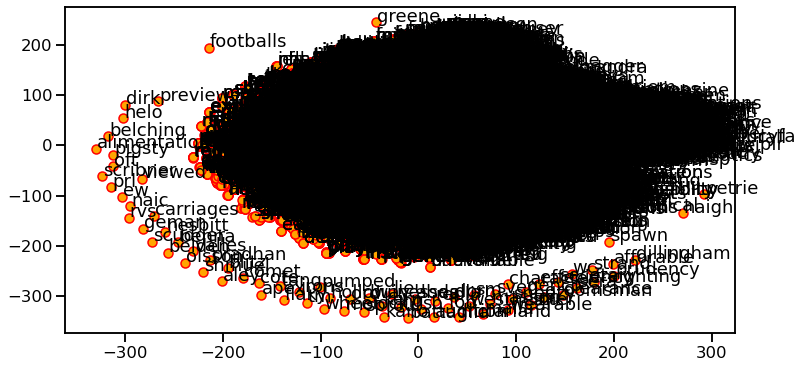

In [409]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Cluster documents with GloVe Embeddings


In [410]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in nlp_X])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([nlp_emails, cluster_labels], axis=1)

array([[0.9691364, 1.2250391, 1.4212031],
       [1.8179492, 1.5127261, 2.2094977],
       [1.5885079, 2.0164826, 1.471523 ],
       ...,
       [1.4195511, 1.8789587, 1.3800957],
       [1.1652528, 1.5509859, 0.9043066],
       [1.2525054, 1.0174894, 1.7900046]], dtype=float32)

nlp_X  \
0    subject interview steve submitted evaluation general impression negative consultant type person speaks confidence short depth technical details personable outspoken organized positive red flag jum...   
1    subject ink prices got like save printer fax copier supplies brands like epson canon hewlett packard lexmark quality satisfaction guarantee money free day shipping orders beat price internet guara...   
2    subject hiya hon mandamus hi babie crystal clear remember dating website told thought id hi hon want pictures read wont sleep hear sexy later baby cryssie gal cix bornfruit cr jeffersondarcy rpbw ...   
3    subject confirmation needed reply email message confirm subscription enl dailyupdate txt email address entered subscription enl dailyupdate txt mailing list new subscription requires confirmation ...   
4    subject ready hello viagra med struggle mens erectile dysfunction like jokes sais stronq enouqh man woman orderinq viaqra online convinient fast secure way millions people daily save privacy money...   
..                                                                                                                                                                                                       ...   
995  subject moze cie zainteresuje vince dawno ze soba nie rozmawialismy mam nadzieje ze u ciebie wszystko k nie wiem czy znana jest ci postac prof aleksandra werona zajmuje sie zastosowaniem metod mat...   
996  subject var vince thanks update especially point echoes discussion yesterday want clarify responsibilities maintenance administration var need transparency process mapping decisions example easily...   
997                                                             subject vince kaminski bio good morning jim attached find short bio vince kaminski need let know presentations forthcoming great day shirley   
998  subject li sun jeff met li sun night shall rotation comes smart highly motivated person planning mark palmer wharton october finalize deal vince jeffrey shankman jana giovannini hou vince j kamins...   
999  subject urgent reply desk barr arisman shonikon chambers associates b aba road port harcourt nigeria private email address shymail dear sincerely apologize intruding privacy especially contacting ...   

     topic  ClusterLabel  
0        0             0  
1        3             1  
2        3             2  
3        1             1  
4        3             0  
..     ...           ...  
995      0             2  
996      0             1  
997      4             2  
998      4             2  
999      3             1  

[1000 rows x 3 columns]

### Leveraging gensim for building a FastText model

In [411]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in nlp_X]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [412]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['business', 'new', 'market', 'received', 'prices', 'enron', 'id', 'power', 'message', 'energy']}
similar_words

{'business': ['marketinq', 'rhythm', 'turnaround', 'wiii', 'marketing'],
 'new': ['iso', 'market', 'york', 'update', 'design'],
 'market': ['markets', 'wholesale', 'power', 'electricity', 'interconnection'],
 'received': ['invoked', 'qmail', 'helo', 'compos', 'mailwisconsin'],
 'prices': ['price', 'power', 'volatilities', 'model', 'starting'],
 'enron': ['corp', 'forwarded', 'hou', 'na', 'subject'],
 'id': ['carpenter', 'reinsurance', 'rendez', 'exim', 'smtp'],
 'power': ['plants', 'market', 'electricity', 'grid', 'gas'],
 'message': ['sent', 'original', 'subject', 'sender', 'j'],
 'energy': ['finance', 'power', 'ut', 'industry', 'gas']}

<Figure size 1296x720 with 0 Axes>

Text(0, 0, 'business')

Text(0, 0, 'marketinq')

Text(0, 0, 'rhythm')

Text(0, 0, 'turnaround')

Text(0, 0, 'wiii')

Text(0, 0, 'marketing')

Text(0, 0, 'new')

Text(0, 0, 'iso')

Text(0, 0, 'market')

Text(0, 0, 'york')

Text(0, 0, 'update')

Text(0, 0, 'design')

Text(0, 0, 'market')

Text(0, 0, 'markets')

Text(0, 0, 'wholesale')

Text(0, 0, 'power')

Text(0, 0, 'electricity')

Text(0, 0, 'interconnection')

Text(0, 0, 'received')

Text(0, 0, 'invoked')

Text(0, 0, 'qmail')

Text(0, 0, 'helo')

Text(0, 0, 'compos')

Text(0, 0, 'mailwisconsin')

Text(0, 0, 'prices')

Text(0, 0, 'price')

Text(0, 0, 'power')

Text(0, 0, 'volatilities')

Text(0, 0, 'model')

Text(0, 0, 'starting')

Text(0, 0, 'enron')

Text(0, 0, 'corp')

Text(0, 0, 'forwarded')

Text(0, 0, 'hou')

Text(0, 0, 'na')

Text(0, 0, 'subject')

Text(0, 0, 'id')

Text(0, 0, 'carpenter')

Text(0, 0, 'reinsurance')

Text(0, 0, 'rendez')

Text(0, 0, 'exim')

Text(0, 0, 'smtp')

Text(0, 0, 'power')

Text(0, 0, 'plants')

Text(0, 0, 'market')

Text(0, 0, 'electricity')

Text(0, 0, 'grid')

Text(0, 0, 'gas')

Text(0, 0, 'message')

Text(0, 0, 'sent')

Text(0, 0, 'original')

Text(0, 0, 'subject')

Text(0, 0, 'sender')

Text(0, 0, 'j')

Text(0, 0, 'energy')

Text(0, 0, 'finance')

Text(0, 0, 'power')

Text(0, 0, 'ut')

Text(0, 0, 'industry')

Text(0, 0, 'gas')

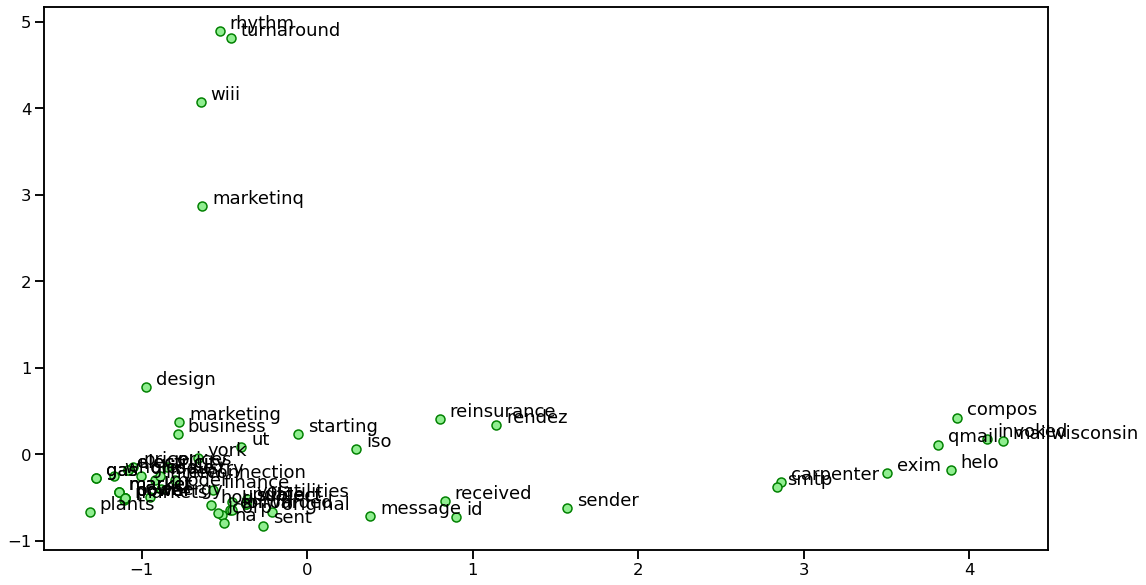

In [413]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [414]:
print(ft_model.wv.similarity(w1='marketing', w2='design'))
print(ft_model.wv.similarity(w1='business', w2='decision'))

0.24796192
0.1303517


## Recreate Final Model

In [418]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

## Train the Naive Bayes Model

In [432]:
tv = TfidfVectorizer(max_features= 2500)
tv_nlp_X = tv.fit_transform(nlp_X)
tv_nlp_X = tv_nlp_X.toarray()

vocab = tv.get_feature_names()

len(vocab)

2500

In [439]:
emails[0:4]

text  \
4410  Subject: re : interview  steve ,  i submitted my evaluation . general impression was rather  negative : he seems to be a consultant type person  who speaks about everything with confidence but is ...   
121   Subject: re : ink prices got you down ? 11956  would you like to  save up to 80 %  on printer , fax  copier supplies ?  on  brands like -  epson  canon  hewlett  packard  lexmark  more !  100 %  q...   
184   Subject: hiya hon , , . . . mandamus  hi there babie , it ' s the 1 and only crystal clear remember from the dating website . i was told all about you so i thought id say hi hon . i want you to se...   
2552  Subject: your confirmation is needed  please reply to this email message to confirm your subscription to  enl - dailyupdate - txt .  your email address has been entered for a subscription to the  ...   

      spam  \
4410     0   
121      1   
184      1   
2552     0   

                                                                                                                                                                                                       norm_X  \
4410  subject   interview steve  submitted evaluation  general impression rather negative  seems consultant type person speaks everything confidence short depth technical details  personable  outspoken ...   
121   subject   ink prices got   would like save   printer  fax copier supplies  brands like  epson canon hewlett packard lexmark    quality satisfaction guarantee money back  free day shipping us order...   
184   subject  hiya hon      mandamus hi babie    crystal clear remember dating website  told thought id say hi hon  want see pictures read  wont sleep hear sexy   later baby  cryssie gal http    cix  b...   
2552  subject  confirmation needed please reply email message confirm subscription enl  dailyupdate  txt  email address entered subscription enl  dailyupdate  txt mailing list  however  new subscription...   

                                                                                                                                                                                                        nlp_X  
4410  subject interview steve submitted evaluation general impression negative consultant type person speaks confidence short depth technical details personable outspoken organized positive red flag jum...  
121   subject ink prices got like save printer fax copier supplies brands like epson canon hewlett packard lexmark quality satisfaction guarantee money free day shipping orders beat price internet guara...  
184   subject hiya hon mandamus hi babie crystal clear remember dating website told thought id hi hon want pictures read wont sleep hear sexy later baby cryssie gal cix bornfruit cr jeffersondarcy rpbw ...  
2552  subject confirmation needed reply email message confirm subscription enl dailyupdate txt email address entered subscription enl dailyupdate txt mailing list new subscription requires confirmation ...

In [457]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features=1000)
tv_nlp_X = tv.fit_transform(nlp_X)
tv_nlp_X = tv_nlp_X.toarray()

vocab = tv.get_feature_names()
#pd.DataFrame(np.round(tv_train_matrix, 2), columns=vocab)
len(vocab)

1000

In [458]:
y = np.array(new_emails['spam'])

### Split emails dataset into to train/ test se

In [459]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tv_nlp_X, y, test_size=0.33, random_state=42)

In [460]:
X_train_features=pd.DataFrame(np.round(X_train, 2),columns = vocab)

X_test_features=pd.DataFrame(np.round(X_test, 2), columns = vocab)

In [461]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train,y_train)

GaussianNB()

### Predict the Test set result

In [462]:

y_pred = clf.predict(X_test)
result=np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
result[0:10]

array([[1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

### Making the Confusion Matrix

In [463]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[239   1]
 [ 32  58]]


0.9

In [464]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       240
           1       0.98      0.64      0.78        90

    accuracy                           0.90       330
   macro avg       0.93      0.82      0.86       330
weighted avg       0.91      0.90      0.89       330



### GradientBoostingRegressor Model

In [465]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(X_train_features)

# Transform both training data and testing data
X = imputer.transform(X_train_features)
X_test = imputer.transform(X_test_features)


SimpleImputer(strategy='median')

In [466]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [467]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X_train, y_train)

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=800,
                          random_state=42)

In [468]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 0.1152


## Interprete the Model¶
Explore several ways to interpret our model: Feature importances Locally Interpretable Model-agnostic Explainer (LIME) Examining a single decision tree in the ensemble.

### Feature Importances

In [469]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(X_train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

feature  importance
0        vince    0.444670
1        enron    0.287429
2     research    0.097852
3       thanks    0.085223
4        model    0.083563
5   investment    0.000201
6  information    0.000197
7      trading    0.000185
8       future    0.000182
9       energy    0.000175

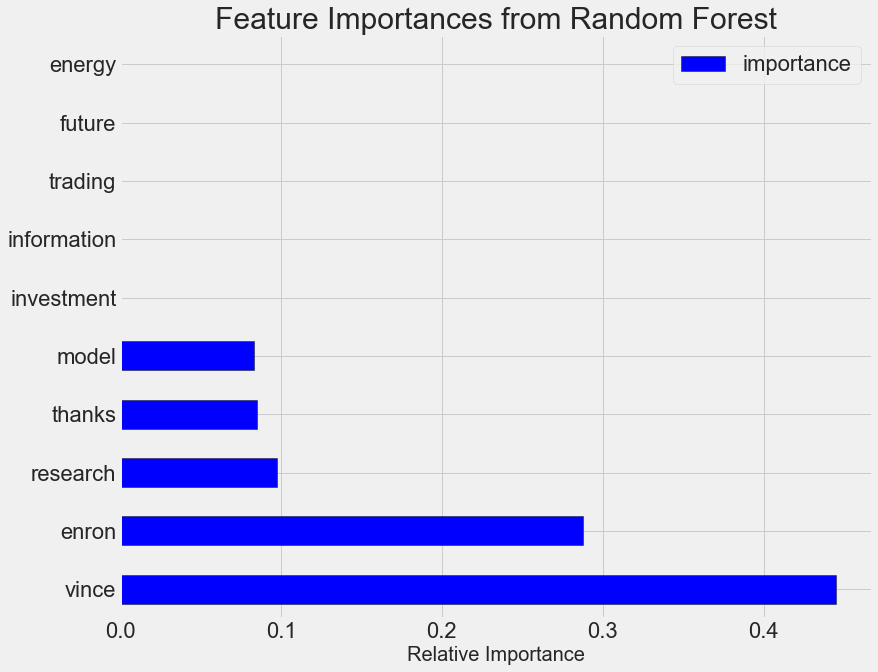

In [470]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

### Use Feature Importances for Feature Selection¶

In [471]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(X_train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (670, 10)
Most important testing  features shape:  (330, 10)


In [472]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X_train, y_train)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y_train)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))


LinearRegression()

LinearRegression()

Linear Regression Full Results: MAE =    0.2220.
Linear Regression Reduced Results: MAE = 0.3096.


In [474]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y_train)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=800,
                          random_state=42)

Gradient Boosted Reduced Results: MAE = 0.1152


### Locally Interpretable Model-agnostic Explanations (LIME)

In [475]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [476]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 0.0000
Actual Value: 1.0000


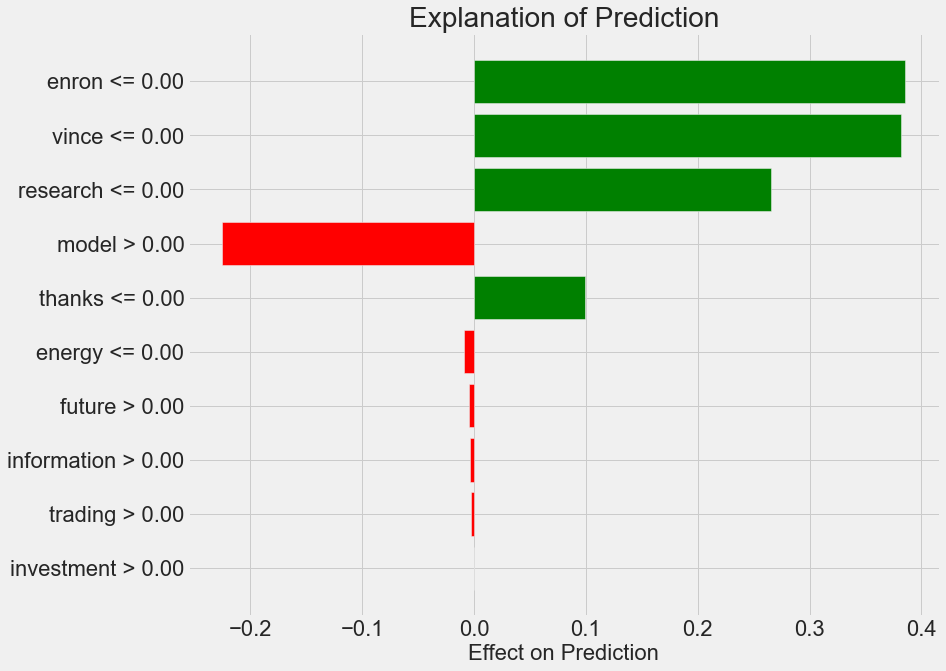

In [477]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [478]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 0.0000
Actual Value: 0.0000


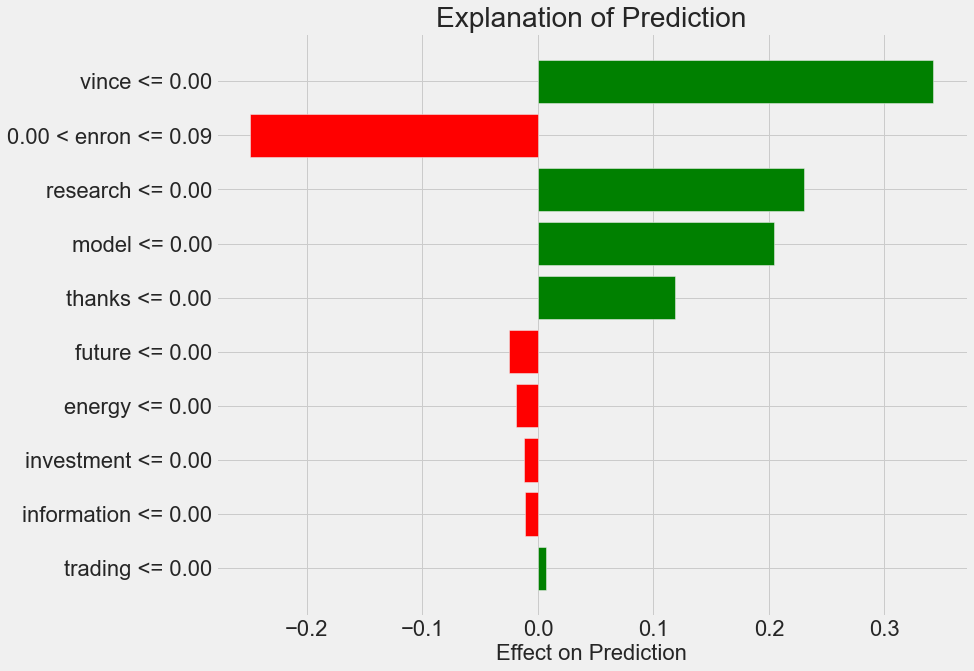

In [479]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

## Examining a Single Decision Tree

In [480]:
# Extract a single tree
from sklearn.tree import export_graphviz

single_tree = model_reduced.estimators_[105][0]


tree.export_graphviz(single_tree, out_file = 'images_tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=6,
                      min_samples_split=6,
                      random_state=RandomState(MT19937) at 0x7F9BDF8C8440)

In [481]:
tree.export_graphviz(single_tree, out_file = 'images_tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

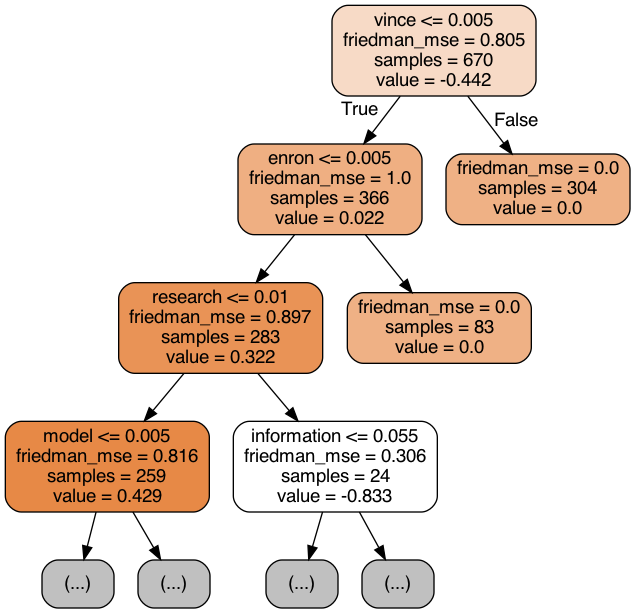

In [483]:
!dot -Tpng images_tree_small.dot -o images_tree_small.png
from IPython.display import Image
Image(filename = 'images_tree_small.png')